In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'legend.fontsize': 14})
plt.rcParams['font.family'] = 'times'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.minor.size'] = 3
import uproot

### DUNE neutrino spectra

In [12]:
##### function definitions
# different definitions of hadronic energy
def cal_Ehadtrue(pdg, E, m):
    Ehadtrue = 0
    for ip in range(len(pdg)):
        if pdg[ip] in [2212, 2112]:
            Ehadtrue += (E[ip] - m[ip])
        elif pdg[ip] in [211, -211, 111, 22, 321, -321, 311]:
            Ehadtrue += E[ip]
    return Ehadtrue
def cal_Ehadreco(pdg, E, m):
    Ehadreco = 0
    for ip in range(len(pdg)):
        if pdg[ip] in [2212]:
            Ehadreco += (E[ip] - m[ip])
        elif pdg[ip] in [211, -211, 111, 22, 321, -321, 311]:
            Ehadreco += E[ip]
    return Ehadreco
def cal_Eavail(pdg, E, m):
    Eavail = 0
    for ip in range(len(pdg)):
        if pdg[ip] in [2212, 211, -211]:
            Eavail += (E[ip] - m[ip])
        elif pdg[ip] in [111, 22, 321, -321, 311]:
            Eavail += E[ip]
    return Eavail
def get_Ehad_array(vars_dict, cal_Ehad_func):
    nevts = len(vars_dict["Ev"])
    pdgi = vars_dict["pdgi"]
    Ei = vars_dict["Ei"]
    mi = []
    Eavail_i = []
    pdgf = vars_dict["pdgf"]
    Ef = vars_dict["Ef"]
    mf = []
    Eavail_f = []
    
    for ievt in range(nevts):
        pisq = vars_dict["pxi"][ievt]*vars_dict["pxi"][ievt] + vars_dict["pyi"][ievt]*vars_dict["pyi"][ievt] + vars_dict["pzi"][ievt]*vars_dict["pzi"][ievt]
        mi.append(np.sqrt(Ei[ievt]*Ei[ievt] - pisq))
        Eavail_i.append(cal_Ehad_func(pdgi[ievt], Ei[ievt], mi[ievt]))
        
        mf.append(np.sqrt(Ef[ievt]*Ef[ievt] - vars_dict["pf"][ievt]*vars_dict["pf"][ievt]))
        Eavail_f.append(cal_Ehad_func(pdgf[ievt], Ef[ievt], mf[ievt]))
        
    return np.array(Eavail_i), np.array(Eavail_f)

# neutrino energy bias
def get_Ebias(vars_dict, cal_Ehad_func):
    Ehadi, Ehadf = get_Ehad_array(vars_dict, cal_Ehad_func)
    return vars_dict["El"] + Ehadi - vars_dict["Ev"], vars_dict["El"] + Ehadf - vars_dict["Ev"]
def get_relative_Ebias(vars_dict, cal_Ehad_func):
    Ebiasi, Ebiasf = get_Ebias(vars_dict, cal_Ehad_func)
    return Ebiasi / vars_dict["Ev"], Ebiasf / vars_dict["Ev"]

# other useful
def safe_divide(numerator, denominator, default_value=100):
    # 0/0 = 1, 0/x = 0, x/0 = default_value
    result = np.ones_like(numerator, dtype=float)  # Default result is 1
    mask_both_zero = (numerator == 0) & (denominator == 0)
    mask_only_denominator_zero = (denominator == 0) & ~mask_both_zero

    result[~mask_both_zero & ~mask_only_denominator_zero] = numerator[~mask_both_zero & ~mask_only_denominator_zero] / denominator[~mask_both_zero & ~mask_only_denominator_zero]
    result[mask_only_denominator_zero] = default_value  # Assign default value where denominator is zero and numerator is non-zero
    return np.nan_to_num(result, nan=default_value)  # Replace NaN with default_value

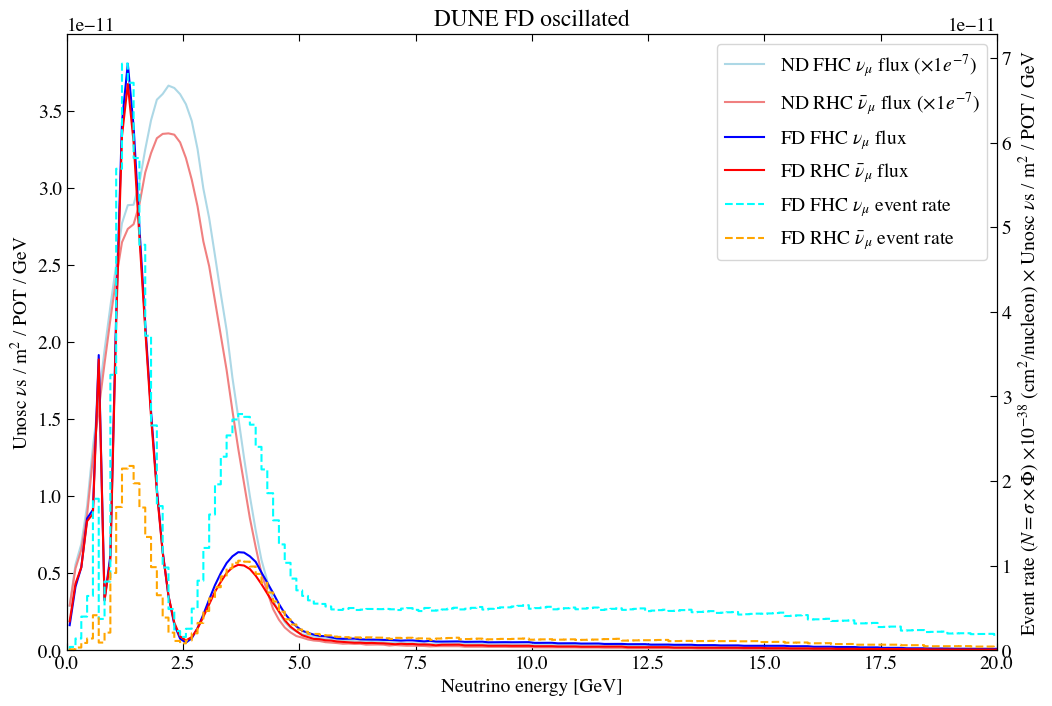

In [3]:
# from cern lxplus /afs/cern.ch/work/s/sdolan/public/temp/DUNEFD_osc_*.root
FDosc_Ev = np.array([0.0625,0.1875,0.3125,0.4375,0.5625,0.6875,0.8125,0.9375,1.0625,1.1875,1.3125,1.4375,1.5625,1.6875,1.8125,1.9375,2.0625,2.1875,2.3125,2.4375,2.5625,2.6875,2.8125,2.9375,3.0625,3.1875,3.3125,3.4375,3.5625,3.6875,3.8125,3.9375,4.0625,4.1875,4.3125,4.4375,4.5625,4.6875,4.8125,4.9375,5.0625,5.1875,5.3125,5.4375,5.5625,5.6875,5.8125,5.9375,6.0625,6.1875,6.3125,6.4375,6.5625,6.6875,6.8125,6.9375,7.0625,7.1875,7.3125,7.4375,7.5625,7.6875,7.8125,7.9375,8.0625,8.1875,8.3125,8.4375,8.5625,8.6875,8.8125,8.9375,9.0625,9.1875,9.3125,9.4375,9.5625,9.6875,9.8125,9.9375,10.0625,10.1875,10.3125,10.4375,10.5625,10.6875,10.8125,10.9375,11.0625,11.1875,11.3125,11.4375,11.5625,11.6875,11.8125,11.9375,12.0625,12.1875,12.3125,12.4375,12.5625,12.6875,12.8125,12.9375,13.0625,13.1875,13.3125,13.4375,13.5625,13.6875,13.8125,13.9375,14.0625,14.1875,14.3125,14.4375,14.5625,14.6875,14.8125,14.9375,15.0625,15.1875,15.3125,15.4375,15.5625,15.6875,15.8125,15.9375,16.0625,16.1875,16.3125,16.4375,16.5625,16.6875,16.8125,16.9375,17.0625,17.1875,17.3125,17.4375,17.5625,17.6875,17.8125,17.9375,18.0625,18.1875,18.3125,18.4375,18.5625,18.6875,18.8125,18.9375,19.0625,19.1875,19.3125,19.4375,19.5625,19.6875,19.8125,19.9375,20.0625,20.1875,20.3125,20.4375,20.5625,20.6875,20.8125,20.9375,21.0625,21.1875,21.3125,21.4375,21.5625,21.6875,21.8125,21.9375,22.0625,22.1875,22.3125,22.4375,22.5625,22.6875,22.8125,22.9375,23.0625,23.1875,23.3125,23.4375,23.5625,23.6875,23.8125,23.9375,24.0625,24.1875,24.3125,24.4375,24.5625,24.6875,24.8125,24.9375,25.0625,25.1875,25.3125,25.4375,25.5625,25.6875,25.8125,25.9375,26.0625,26.1875,26.3125,26.4375,26.5625,26.6875,26.8125,26.9375,27.0625,27.1875,27.3125,27.4375,27.5625,27.6875,27.8125,27.9375,28.0625,28.1875,28.3125,28.4375,28.5625,28.6875,28.8125,28.9375,29.0625,29.1875,29.3125,29.4375,29.5625,29.6875,29.8125,29.9375,30.0625,30.1875,30.3125,30.4375,30.5625,30.6875,30.8125,30.9375,31.0625,31.1875,31.3125,31.4375,31.5625,31.6875,31.8125,31.9375,32.0625,32.1875,32.3125,32.4375,32.5625,32.6875,32.8125,32.9375,33.0625,33.1875,33.3125,33.4375,33.5625,33.6875,33.8125,33.9375,34.0625,34.1875,34.3125,34.4375,34.5625,34.6875,34.8125,34.9375,35.0625,35.1875,35.3125,35.4375,35.5625,35.6875,35.8125,35.9375,36.0625,36.1875,36.3125,36.4375,36.5625,36.6875,36.8125,36.9375,37.0625,37.1875,37.3125,37.4375,37.5625,37.6875,37.8125,37.9375,38.0625,38.1875,38.3125,38.4375,38.5625,38.6875,38.8125,38.9375,39.0625,39.1875,39.3125,39.4375,39.5625,39.6875,39.8125,39.9375,40.0625,40.1875,40.3125,40.4375,40.5625,40.6875,40.8125,40.9375,41.0625,41.1875,41.3125,41.4375,41.5625,41.6875,41.8125,41.9375,42.0625,42.1875,42.3125,42.4375,42.5625,42.6875,42.8125,42.9375,43.0625,43.1875,43.3125,43.4375,43.5625,43.6875,43.8125,43.9375,44.0625,44.1875,44.3125,44.4375,44.5625,44.6875,44.8125,44.9375,45.0625,45.1875,45.3125,45.4375,45.5625,45.6875,45.8125,45.9375,46.0625,46.1875,46.3125,46.4375,46.5625,46.6875,46.8125,46.9375,47.0625,47.1875,47.3125,47.4375,47.5625,47.6875,47.8125,47.9375,48.0625,48.1875,48.3125,48.4375,48.5625,48.6875,48.8125,48.9375,49.0625,49.1875,49.3125,49.4375,49.5625,49.6875,49.8125,49.9375,50.0625,50.1875,50.3125,50.4375,50.5625,50.6875,50.8125,50.9375,51.0625,51.1875,51.3125,51.4375,51.5625,51.6875,51.8125,51.9375,52.0625,52.1875,52.3125,52.4375,52.5625,52.6875,52.8125,52.9375,53.0625,53.1875,53.3125,53.4375,53.5625,53.6875,53.8125,53.9375,54.0625,54.1875,54.3125,54.4375,54.5625,54.6875,54.8125,54.9375,55.0625,55.1875,55.3125,55.4375,55.5625,55.6875,55.8125,55.9375,56.0625,56.1875,56.3125,56.4375,56.5625,56.6875,56.8125,56.9375,57.0625,57.1875,57.3125,57.4375,57.5625,57.6875,57.8125,57.9375,58.0625,58.1875,58.3125,58.4375,58.5625,58.6875,58.8125,58.9375,59.0625,59.1875,59.3125,59.4375,59.5625,59.6875,59.8125,59.9375,60.0625,60.1875,60.3125,60.4375,60.5625,60.6875,60.8125,60.9375,61.0625,61.1875,61.3125,61.4375,61.5625,61.6875,61.8125,61.9375,62.0625,62.1875,62.3125,62.4375,62.5625,62.6875,62.8125,62.9375,63.0625,63.1875,63.3125,63.4375,63.5625,63.6875,63.8125,63.9375,64.0625,64.1875,64.3125,64.4375,64.5625,64.6875,64.8125,64.9375,65.0625,65.1875,65.3125,65.4375,65.5625,65.6875,65.8125,65.9375,66.0625,66.1875,66.3125,66.4375,66.5625,66.6875,66.8125,66.9375,67.0625,67.1875,67.3125,67.4375,67.5625,67.6875,67.8125,67.9375,68.0625,68.1875,68.3125,68.4375,68.5625,68.6875,68.8125,68.9375,69.0625,69.1875,69.3125,69.4375,69.5625,69.6875,69.8125,69.9375])
FDosc_Flux_FHCnumu = np.array([1.63405e-12,4.12733e-12,5.38704e-12,8.55592e-12,9.12222e-12,1.91554e-11,3.26591e-12,6.15031e-12,2.17698e-11,3.4263e-11,3.80553e-11,3.39788e-11,2.74429e-11,2.1182e-11,1.54875e-11,1.04909e-11,6.42248e-12,3.52103e-12,1.68448e-12,7.56139e-13,5.05388e-13,7.80638e-13,1.44649e-12,2.32681e-12,3.30167e-12,4.231e-12,5.00679e-12,5.6621e-12,6.10054e-12,6.36879e-12,6.34221e-12,6.10165e-12,5.74587e-12,5.05295e-12,4.38315e-12,3.72114e-12,3.00999e-12,2.39804e-12,1.93632e-12,1.55815e-12,1.27356e-12,1.13407e-12,1.02051e-12,9.34646e-13,9.12487e-13,8.44278e-13,7.74428e-13,7.50618e-13,7.55514e-13,7.61492e-13,7.12097e-13,7.0687e-13,7.04477e-13,6.92804e-13,6.78475e-13,6.73991e-13,6.55081e-13,6.33905e-13,6.46797e-13,6.44828e-13,6.10278e-13,5.8265e-13,6.19544e-13,5.7291e-13,5.68738e-13,5.73353e-13,5.77784e-13,5.82041e-13,5.51502e-13,5.55204e-13,5.58764e-13,5.62191e-13,5.23095e-13,5.26034e-13,5.28866e-13,5.31596e-13,5.25355e-13,5.27852e-13,5.30261e-13,5.32587e-13,4.84886e-13,4.86853e-13,4.88755e-13,4.90593e-13,4.57071e-13,4.58668e-13,4.60213e-13,4.61708e-13,4.39891e-13,4.41223e-13,4.42515e-13,4.43766e-13,4.15368e-13,4.16467e-13,4.17532e-13,4.18566e-13,3.99514e-13,4.00442e-13,4.01343e-13,4.02219e-13,3.73592e-13,3.74358e-13,3.75103e-13,3.75827e-13,3.61307e-13,3.61965e-13,3.62605e-13,3.63228e-13,3.37656e-13,3.38205e-13,3.38739e-13,3.39259e-13,3.2029e-13,3.20756e-13,3.2121e-13,3.21653e-13,2.97542e-13,2.97931e-13,2.98311e-13,2.98681e-13,2.94805e-13,2.95153e-13,2.95493e-13,2.95825e-13,2.68586e-13,2.68873e-13,2.69154e-13,2.69428e-13,2.33933e-13,2.3416e-13,2.34383e-13,2.346e-13,2.1669e-13,2.16882e-13,2.1707e-13,2.17253e-13,1.91998e-13,1.92154e-13,1.92306e-13,1.92455e-13,1.62995e-13,1.63115e-13,1.63234e-13,1.6335e-13,1.35321e-13,1.35413e-13,1.35503e-13,1.35592e-13,1.22e-13,1.22076e-13,1.22151e-13,1.22225e-13,1.09406e-13,1.09469e-13,1.09531e-13,1.09592e-13,1.02548e-13,1.02602e-13,1.02656e-13,1.02709e-13,9.64874e-14,9.65352e-14,9.65822e-14,9.66284e-14,9.66737e-14,9.67182e-14,9.67619e-14,9.68048e-14,9.6847e-14,9.68885e-14,9.69292e-14,9.69693e-14,9.70086e-14,9.70473e-14,9.70854e-14,9.71228e-14,7.94927e-14,7.95223e-14,7.95514e-14,7.958e-14,7.96081e-14,7.96358e-14,7.96631e-14,7.96899e-14,7.97163e-14,7.97422e-14,7.97678e-14,7.9793e-14,7.98177e-14,7.98421e-14,7.98661e-14,7.98897e-14,6.29188e-14,6.29369e-14,6.29546e-14,6.29721e-14,6.29893e-14,6.30063e-14,6.3023e-14,6.30395e-14,6.30557e-14,6.30717e-14,6.30875e-14,6.3103e-14,6.31183e-14,6.31334e-14,6.31482e-14,6.31629e-14,4.95111e-14,4.95222e-14,4.95332e-14,4.95441e-14,4.95548e-14,4.95653e-14,4.95757e-14,4.9586e-14,4.95961e-14,4.96061e-14,4.96159e-14,4.96257e-14,4.96352e-14,4.96447e-14,4.9654e-14,4.96632e-14,3.87794e-14,3.87864e-14,3.87933e-14,3.88001e-14,3.88068e-14,3.88135e-14,3.882e-14,3.88265e-14,3.88329e-14,3.88392e-14,3.88454e-14,3.88516e-14,3.88576e-14,3.88636e-14,3.88696e-14,3.88754e-14,3.36445e-14,3.36494e-14,3.36543e-14,3.36591e-14,3.36639e-14,3.36686e-14,3.36732e-14,3.36778e-14,3.36823e-14,3.36868e-14,3.36913e-14,3.36956e-14,3.37e-14,3.37042e-14,3.37084e-14,3.37126e-14,2.46533e-14,2.46563e-14,2.46592e-14,2.46621e-14,2.4665e-14,2.46678e-14,2.46707e-14,2.46734e-14,2.46762e-14,2.46789e-14,2.46816e-14,2.46843e-14,2.46869e-14,2.46895e-14,2.46921e-14,2.46946e-14,1.84345e-14,1.84364e-14,1.84382e-14,1.844e-14,1.84418e-14,1.84436e-14,1.84454e-14,1.84471e-14,1.84488e-14,1.84506e-14,1.84522e-14,1.84539e-14,1.84556e-14,1.84572e-14,1.84588e-14,1.84604e-14,1.59067e-14,1.5908e-14,1.59094e-14,1.59107e-14,1.5912e-14,1.59133e-14,1.59146e-14,1.59159e-14,1.59171e-14,1.59184e-14,1.59196e-14,1.59208e-14,1.5922e-14,1.59232e-14,1.59244e-14,1.59256e-14,1.43962e-14,1.43972e-14,1.43983e-14,1.43993e-14,1.44003e-14,1.44013e-14,1.44023e-14,1.44033e-14,1.44043e-14,1.44052e-14,1.44062e-14,1.44071e-14,1.4408e-14,1.4409e-14,1.44099e-14,1.44108e-14,1.05176e-14,1.05183e-14,1.05189e-14,1.05196e-14,1.05202e-14,1.05208e-14,1.05215e-14,1.05221e-14,1.05227e-14,1.05233e-14,1.05239e-14,1.05245e-14,1.05251e-14,1.05257e-14,1.05262e-14,1.05268e-14,8.75973e-15,8.7602e-15,8.76066e-15,8.76112e-15,8.76158e-15,8.76203e-15,8.76248e-15,8.76293e-15,8.76337e-15,8.7638e-15,8.76424e-15,8.76466e-15,8.76509e-15,8.76551e-15,8.76593e-15,8.76635e-15,7.98764e-15,7.98801e-15,7.98838e-15,7.98875e-15,7.98911e-15,7.98947e-15,7.98983e-15,7.99018e-15,7.99053e-15,7.99088e-15,7.99122e-15,7.99156e-15,7.9919e-15,7.99224e-15,7.99257e-15,7.9929e-15,6.55917e-15,6.55943e-15,6.5597e-15,6.55996e-15,6.56022e-15,6.56048e-15,6.56074e-15,6.56099e-15,6.56124e-15,6.5615e-15,6.56174e-15,6.56199e-15,6.56224e-15,6.56248e-15,6.56272e-15,6.56296e-15,4.70059e-15,4.70075e-15,4.70092e-15,4.70109e-15,4.70125e-15,4.70142e-15,4.70158e-15,4.70174e-15,4.7019e-15,4.70206e-15,4.70221e-15,4.70237e-15,4.70253e-15,4.70268e-15,4.70283e-15,4.70298e-15,4.43055e-15,4.43069e-15,4.43083e-15,4.43096e-15,4.4311e-15,4.43124e-15,4.43137e-15,4.43151e-15,4.43164e-15,4.43177e-15,4.43191e-15,4.43204e-15,4.43217e-15,4.43229e-15,4.43242e-15,4.43255e-15,3.22597e-15,3.22607e-15,3.22616e-15,3.22625e-15,3.22633e-15,3.22642e-15,3.22651e-15,3.2266e-15,3.22668e-15,3.22677e-15,3.22686e-15,3.22694e-15,3.22703e-15,3.22711e-15,3.22719e-15,3.22727e-15,2.55888e-15,2.55894e-15,2.55901e-15,2.55907e-15,2.55913e-15,2.5592e-15,2.55926e-15,2.55932e-15,2.55938e-15,2.55944e-15,2.5595e-15,2.55956e-15,2.55962e-15,2.55968e-15,2.55974e-15,2.5598e-15,2.81309e-15,2.81316e-15,2.81322e-15,2.81328e-15,2.81334e-15,2.81341e-15,2.81347e-15,2.81353e-15,2.81359e-15,2.81365e-15,2.81371e-15,2.81377e-15,2.81383e-15,2.81389e-15,2.81395e-15,2.814e-15,1.69875e-15,1.69878e-15,1.69882e-15,1.69885e-15,1.69888e-15,1.69892e-15,1.69895e-15,1.69898e-15,1.69902e-15,1.69905e-15,1.69908e-15,1.69911e-15,1.69915e-15,1.69918e-15,1.69921e-15,1.69924e-15,1.88905e-15,1.88908e-15,1.88911e-15,1.88915e-15,1.88918e-15,1.88922e-15,1.88925e-15,1.88928e-15,1.88932e-15,1.88935e-15,1.88938e-15,1.88942e-15,1.88945e-15,1.88948e-15,1.88951e-15,1.88954e-15,1.28525e-15,1.28527e-15,1.28529e-15,1.28532e-15,1.28534e-15,1.28536e-15,1.28538e-15,1.2854e-15,1.28542e-15,1.28544e-15,1.28546e-15,1.28548e-15,1.2855e-15,1.28552e-15,1.28554e-15,1.28556e-15,9.40961e-16,9.40975e-16,9.40989e-16,9.41004e-16,9.41018e-16,9.41032e-16,9.41045e-16,9.41059e-16,9.41073e-16,9.41086e-16,9.411e-16,9.41113e-16,9.41127e-16,9.4114e-16,9.41153e-16,9.41166e-16,1.29714e-15,1.29716e-15,1.29717e-15,1.29719e-15,1.29721e-15,1.29723e-15,1.29724e-15,1.29726e-15,1.29728e-15,1.2973e-15,1.29731e-15,1.29733e-15,1.29735e-15,1.29736e-15,1.29738e-15,1.2974e-15,7.29266e-16,7.29275e-16,7.29284e-16,7.29293e-16,7.29302e-16,7.29312e-16,7.2932e-16,7.29329e-16,7.29338e-16,7.29347e-16,7.29356e-16,7.29365e-16,7.29373e-16,7.29382e-16,7.2939e-16,7.29399e-16])
FDosc_ER_FHCnumu = np.array([0,4.06955e-13,1.39996e-12,3.993e-12,6.42788e-12,1.79117e-11,3.7138e-12,8.13167e-12,3.2561e-11,5.69056e-11,6.93175e-11,6.70633e-11,5.81699e-11,4.79229e-11,3.71737e-11,2.65809e-11,1.70488e-11,9.78844e-12,4.88428e-12,2.28513e-12,1.58962e-12,2.55334e-12,4.93198e-12,8.23193e-12,1.21019e-11,1.60511e-11,1.96174e-11,2.28834e-11,2.53962e-11,2.72808e-11,2.79248e-11,2.75922e-11,2.66664e-11,2.40446e-11,2.13765e-11,1.85725e-11,1.53653e-11,1.25204e-11,1.03441e-11,8.47799e-12,7.09365e-12,6.43594e-12,5.90926e-12,5.52189e-12,5.48581e-12,5.18328e-12,4.83612e-12,4.7789e-12,4.90046e-12,5.00371e-12,4.76984e-12,4.81783e-12,4.89258e-12,4.88513e-12,4.8707e-12,4.89753e-12,4.85294e-12,4.76532e-12,4.93774e-12,4.99173e-12,4.78699e-12,4.64476e-12,5.01003e-12,4.69526e-12,4.72371e-12,4.83347e-12,4.93783e-12,5.03711e-12,4.83541e-12,4.92464e-12,5.02495e-12,5.12564e-12,4.81794e-12,4.91191e-12,5.00861e-12,5.08139e-12,5.08239e-12,5.18456e-12,5.25954e-12,5.33445e-12,4.91951e-12,4.99234e-12,5.06733e-12,5.14824e-12,4.84952e-12,4.91597e-12,4.98048e-12,5.05881e-12,4.85777e-12,4.93368e-12,4.99795e-12,5.05908e-12,4.77462e-12,4.84112e-12,4.90651e-12,4.96794e-12,4.78438e-12,4.84456e-12,4.90632e-12,4.95738e-12,4.63584e-12,4.69916e-12,4.75013e-12,4.80514e-12,4.65706e-12,4.6968e-12,4.75702e-12,4.80088e-12,4.5057e-12,4.54283e-12,4.59487e-12,4.63842e-12,4.42409e-12,4.45483e-12,4.50244e-12,4.53202e-12,4.22997e-12,4.27097e-12,4.3124e-12,4.34158e-12,4.32481e-12,4.36423e-12,4.41078e-12,4.45658e-12,4.05779e-12,4.09376e-12,4.13771e-12,4.1687e-12,3.64659e-12,3.66875e-12,3.70539e-12,3.73361e-12,3.47132e-12,3.49278e-12,3.51212e-12,3.54585e-12,3.16785e-12,3.18936e-12,3.2074e-12,3.24236e-12,2.75777e-12,2.77992e-12,2.80622e-12,2.81142e-12,2.33634e-12,2.36098e-12,2.39282e-12,2.40059e-12,2.16654e-12,2.18562e-12,2.19934e-12,2.21984e-12,1.99149e-12,2.0049e-12,2.02119e-12,2.02637e-12,1.91432e-12,1.93259e-12,1.94047e-12,1.95248e-12,1.84233e-12,1.8435e-12,1.86037e-12,1.88223e-12,1.88216e-12,1.91332e-12,1.9211e-12,1.92471e-12,1.93688e-12,1.95438e-12,1.96596e-12,1.97529e-12,1.9852e-12,1.98249e-12,2.01514e-12,2.01643e-12,1.65546e-12,1.67836e-12,1.66943e-12,1.6856e-12,1.70148e-12,1.71778e-12,1.717e-12,1.71917e-12,1.73574e-12,1.749e-12,1.7571e-12,1.7642e-12,1.77442e-12,1.79108e-12,1.78993e-12,1.80031e-12,1.41988e-12,1.43503e-12,1.4374e-12,1.44369e-12,1.44996e-12,1.45475e-12,1.47184e-12,1.47026e-12,1.46871e-12,1.49956e-12,1.50017e-12,1.51189e-12,1.51035e-12,1.52864e-12,1.53151e-12,1.54184e-12,1.2059e-12,1.21596e-12,1.21609e-12,1.22137e-12,1.23214e-12,1.23155e-12,1.23317e-12,1.24999e-12,1.25085e-12,1.25943e-12,1.26285e-12,1.27276e-12,1.28378e-12,1.27794e-12,1.28544e-12,1.29365e-12,1.00308e-12,1.00474e-12,1.01808e-12,1.0179e-12,1.01467e-12,1.02928e-12,1.02936e-12,1.04248e-12,1.05146e-12,1.05319e-12,1.05917e-12,1.06262e-12,1.06554e-12,1.05919e-12,1.07183e-12,1.06443e-12,9.41159e-13,9.36026e-13,9.43651e-13,9.42952e-13,9.51974e-13,9.55909e-13,9.55254e-13,9.6671e-13,9.63963e-13,9.72845e-13,9.77244e-13,9.89404e-13,9.74066e-13,9.92269e-13,9.87886e-13,9.94876e-13,7.23795e-13,7.31595e-13,7.3606e-13,7.25855e-13,7.4227e-13,7.37941e-13,7.42569e-13,7.47838e-13,7.40864e-13,7.50251e-13,7.49368e-13,7.5974e-13,7.54928e-13,7.56034e-13,7.61575e-13,7.68426e-13,5.6751e-13,5.70946e-13,5.77346e-13,5.8255e-13,5.86314e-13,5.7973e-13,5.63391e-13,5.80239e-13,5.86285e-13,5.81143e-13,5.87908e-13,5.9986e-13,5.97707e-13,6.01087e-13,5.99642e-13,6.0912e-13,5.23061e-13,5.16256e-13,5.21564e-13,5.20745e-13,5.23233e-13,5.28353e-13,5.2973e-13,5.27378e-13,5.39623e-13,5.43183e-13,5.35578e-13,5.35326e-13,5.37108e-13,5.49817e-13,5.37821e-13,5.51023e-13,4.79475e-13,4.94923e-13,4.96815e-13,4.90518e-13,5.01984e-13,5.0013e-13,5.0684e-13,5.07325e-13,5.11731e-13,5.08158e-13,5.09719e-13,5.16293e-13,5.18364e-13,5.16421e-13,5.12845e-13,5.16162e-13,3.78643e-13,3.77304e-13,3.7833e-13,3.77308e-13,3.78618e-13,3.68004e-13,3.81072e-13,3.89019e-13,3.93502e-13,3.78111e-13,3.86069e-13,3.92678e-13,3.89459e-13,3.93855e-13,3.96467e-13,3.90727e-13,3.26989e-13,3.26759e-13,3.30103e-13,3.32214e-13,3.31753e-13,3.26982e-13,3.26661e-13,3.31525e-13,3.30606e-13,3.27358e-13,3.27381e-13,3.38238e-13,3.33289e-13,3.4178e-13,3.45026e-13,3.43996e-13,3.05151e-13,3.11652e-13,3.12918e-13,3.13862e-13,3.12866e-13,3.17784e-13,3.12628e-13,3.14206e-13,3.16726e-13,3.22169e-13,3.11355e-13,3.21095e-13,3.24602e-13,3.22544e-13,3.25785e-13,3.27254e-13,2.58136e-13,2.63069e-13,2.68964e-13,2.66732e-13,2.62634e-13,2.69288e-13,2.74131e-13,2.71796e-13,2.71132e-13,2.72057e-13,2.7501e-13,2.76873e-13,2.76078e-13,2.68864e-13,2.74318e-13,2.82446e-13,1.94398e-13,1.91165e-13,1.98184e-13,1.94531e-13,1.97515e-13,1.9981e-13,2.00579e-13,1.97193e-13,2.01482e-13,2.00327e-13,2.04505e-13,1.97078e-13,2.00168e-13,2.01743e-13,2.01936e-13,1.99455e-13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
FDosc_Flux_RHCnumubar = np.array([1.88386e-12,4.33288e-12,5.38235e-12,8.3846e-12,8.85273e-12,1.88708e-11,3.22815e-12,5.89203e-12,2.11902e-11,3.33622e-11,3.67324e-11,3.29525e-11,2.67958e-11,2.08101e-11,1.51559e-11,1.02828e-11,6.35232e-12,3.53868e-12,1.80058e-12,9.08959e-13,6.42628e-13,8.62837e-13,1.4164e-12,2.17513e-12,2.99268e-12,3.79923e-12,4.44164e-12,5.01737e-12,5.37798e-12,5.5496e-12,5.50282e-12,5.27668e-12,4.84522e-12,4.29272e-12,3.69035e-12,3.07582e-12,2.53259e-12,1.95599e-12,1.53433e-12,1.2457e-12,9.80796e-13,8.57692e-13,7.43367e-13,7.24802e-13,6.545e-13,6.32955e-13,5.74097e-13,5.49404e-13,5.26921e-13,4.95495e-13,4.98635e-13,4.73895e-13,4.83457e-13,4.64668e-13,4.55996e-13,4.27974e-13,3.99144e-13,4.26588e-13,4.07557e-13,4.17028e-13,3.80919e-13,3.85101e-13,3.70466e-13,3.27825e-13,3.64579e-13,3.67535e-13,3.70373e-13,3.73099e-13,3.22552e-13,3.24715e-13,3.26796e-13,3.28798e-13,3.00469e-13,3.02156e-13,3.03782e-13,3.05349e-13,2.96757e-13,2.98166e-13,2.99526e-13,3.0084e-13,2.67296e-13,2.6838e-13,2.69428e-13,2.7044e-13,2.53093e-13,2.53977e-13,2.54832e-13,2.5566e-13,2.39048e-13,2.39772e-13,2.40473e-13,2.41153e-13,2.45291e-13,2.45939e-13,2.46568e-13,2.47178e-13,2.06677e-13,2.07157e-13,2.07623e-13,2.08075e-13,2.0691e-13,2.07335e-13,2.07747e-13,2.08148e-13,1.81306e-13,1.81636e-13,1.81957e-13,1.8227e-13,1.74572e-13,1.74855e-13,1.75131e-13,1.754e-13,1.68703e-13,1.68948e-13,1.69187e-13,1.6942e-13,1.60544e-13,1.60754e-13,1.60959e-13,1.61159e-13,1.43448e-13,1.43618e-13,1.43783e-13,1.43944e-13,1.28222e-13,1.28359e-13,1.28493e-13,1.28624e-13,1.14202e-13,1.14313e-13,1.14421e-13,1.14527e-13,9.84705e-14,9.85576e-14,9.86429e-14,9.87263e-14,8.70876e-14,8.7158e-14,8.7227e-14,8.72944e-14,8.33187e-14,8.33804e-14,8.34409e-14,8.35001e-14,7.45236e-14,7.45743e-14,7.4624e-14,7.46727e-14,5.80224e-14,5.80588e-14,5.80945e-14,5.81294e-14,5.78108e-14,5.78443e-14,5.78771e-14,5.79092e-14,5.11145e-14,5.11418e-14,5.11687e-14,5.1195e-14,4.15429e-14,4.15635e-14,4.15837e-14,4.16035e-14,4.1623e-14,4.16422e-14,4.1661e-14,4.16795e-14,4.16976e-14,4.17155e-14,4.1733e-14,4.17503e-14,4.17672e-14,4.17839e-14,4.18003e-14,4.18163e-14,3.43186e-14,3.43314e-14,3.4344e-14,3.43563e-14,3.43685e-14,3.43804e-14,3.43922e-14,3.44038e-14,3.44152e-14,3.44264e-14,3.44374e-14,3.44483e-14,3.4459e-14,3.44695e-14,3.44798e-14,3.449e-14,2.61001e-14,2.61075e-14,2.61149e-14,2.61222e-14,2.61293e-14,2.61364e-14,2.61433e-14,2.61501e-14,2.61568e-14,2.61635e-14,2.617e-14,2.61764e-14,2.61828e-14,2.61891e-14,2.61952e-14,2.62013e-14,1.94368e-14,1.94411e-14,1.94454e-14,1.94497e-14,1.94539e-14,1.9458e-14,1.94621e-14,1.94662e-14,1.94701e-14,1.9474e-14,1.94779e-14,1.94817e-14,1.94855e-14,1.94892e-14,1.94929e-14,1.94965e-14,1.63815e-14,1.63844e-14,1.63873e-14,1.63902e-14,1.63931e-14,1.63959e-14,1.63986e-14,1.64014e-14,1.64041e-14,1.64067e-14,1.64094e-14,1.6412e-14,1.64145e-14,1.64171e-14,1.64196e-14,1.6422e-14,1.13189e-14,1.13206e-14,1.13222e-14,1.13239e-14,1.13255e-14,1.1327e-14,1.13286e-14,1.13301e-14,1.13317e-14,1.13332e-14,1.13347e-14,1.13361e-14,1.13376e-14,1.1339e-14,1.13405e-14,1.13419e-14,8.56729e-15,8.56833e-15,8.56935e-15,8.57036e-15,8.57137e-15,8.57235e-15,8.57333e-15,8.5743e-15,8.57525e-15,8.5762e-15,8.57713e-15,8.57806e-15,8.57897e-15,8.57988e-15,8.58077e-15,8.58166e-15,5.3382e-15,5.33874e-15,5.33927e-15,5.3398e-15,5.34032e-15,5.34083e-15,5.34134e-15,5.34185e-15,5.34235e-15,5.34284e-15,5.34333e-15,5.34381e-15,5.34429e-15,5.34476e-15,5.34523e-15,5.3457e-15,4.10589e-15,4.10624e-15,4.10659e-15,4.10693e-15,4.10727e-15,4.1076e-15,4.10793e-15,4.10826e-15,4.10859e-15,4.10891e-15,4.10922e-15,4.10954e-15,4.10985e-15,4.11016e-15,4.11047e-15,4.11077e-15,3.29682e-15,3.29706e-15,3.2973e-15,3.29753e-15,3.29776e-15,3.29799e-15,3.29822e-15,3.29844e-15,3.29867e-15,3.29889e-15,3.2991e-15,3.29932e-15,3.29953e-15,3.29975e-15,3.29996e-15,3.30017e-15,2.73652e-15,2.73669e-15,2.73686e-15,2.73703e-15,2.73719e-15,2.73735e-15,2.73752e-15,2.73768e-15,2.73783e-15,2.73799e-15,2.73815e-15,2.7383e-15,2.73846e-15,2.73861e-15,2.73876e-15,2.73891e-15,3.31615e-15,3.31633e-15,3.3165e-15,3.31667e-15,3.31685e-15,3.31702e-15,3.31719e-15,3.31736e-15,3.31752e-15,3.31769e-15,3.31785e-15,3.31802e-15,3.31818e-15,3.31834e-15,3.3185e-15,3.31865e-15,1.29879e-15,1.29885e-15,1.29891e-15,1.29897e-15,1.29903e-15,1.29909e-15,1.29915e-15,1.2992e-15,1.29926e-15,1.29932e-15,1.29937e-15,1.29943e-15,1.29948e-15,1.29954e-15,1.29959e-15,1.29965e-15,1.03656e-15,1.0366e-15,1.03664e-15,1.03669e-15,1.03673e-15,1.03677e-15,1.03681e-15,1.03685e-15,1.03689e-15,1.03693e-15,1.03697e-15,1.03701e-15,1.03705e-15,1.03708e-15,1.03712e-15,1.03716e-15,3.61068e-16,3.61081e-16,3.61094e-16,3.61107e-16,3.61119e-16,3.61132e-16,3.61144e-16,3.61157e-16,3.61169e-16,3.61181e-16,3.61193e-16,3.61205e-16,3.61217e-16,3.61229e-16,3.61241e-16,3.61252e-16,4.02574e-16,4.02587e-16,4.026e-16,4.02612e-16,4.02625e-16,4.02637e-16,4.02649e-16,4.02662e-16,4.02674e-16,4.02686e-16,4.02698e-16,4.0271e-16,4.02721e-16,4.02733e-16,4.02745e-16,4.02756e-16,5.77859e-16,5.77875e-16,5.77892e-16,5.77908e-16,5.77924e-16,5.77939e-16,5.77955e-16,5.77971e-16,5.77986e-16,5.78002e-16,5.78017e-16,5.78032e-16,5.78047e-16,5.78062e-16,5.78077e-16,5.78092e-16,2.07308e-16,2.07314e-16,2.07319e-16,2.07324e-16,2.07329e-16,2.07334e-16,2.07339e-16,2.07344e-16,2.07349e-16,2.07354e-16,2.07359e-16,2.07364e-16,2.07369e-16,2.07374e-16,2.07378e-16,2.07383e-16,3.24863e-16,3.2487e-16,3.24878e-16,3.24885e-16,3.24892e-16,3.24899e-16,3.24906e-16,3.24913e-16,3.2492e-16,3.24927e-16,3.24934e-16,3.24941e-16,3.24948e-16,3.24955e-16,3.24961e-16,3.24968e-16,1.20937e-16,1.2094e-16,1.20942e-16,1.20945e-16,1.20947e-16,1.20949e-16,1.20952e-16,1.20954e-16,1.20957e-16,1.20959e-16,1.20961e-16,1.20963e-16,1.20966e-16,1.20968e-16,1.2097e-16,1.20973e-16,1.27097e-16,1.27099e-16,1.27102e-16,1.27104e-16,1.27106e-16,1.27109e-16,1.27111e-16,1.27113e-16,1.27115e-16,1.27118e-16,1.2712e-16,1.27122e-16,1.27124e-16,1.27126e-16,1.27128e-16,1.27131e-16,6.71631e-17,6.71642e-17,6.71653e-17,6.71664e-17,6.71675e-17,6.71686e-17,6.71697e-17,6.71708e-17,6.71718e-17,6.71729e-17,6.71739e-17,6.7175e-17,6.7176e-17,6.71771e-17,6.71781e-17,6.71792e-17,7.29504e-17,7.29515e-17,7.29526e-17,7.29537e-17,7.29548e-17,7.29559e-17,7.2957e-17,7.2958e-17,7.29591e-17,7.29602e-17,7.29612e-17,7.29622e-17,7.29633e-17,7.29643e-17,7.29653e-17,7.29664e-17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
FDosc_ER_RHCnumubar = np.array([0,1.17176e-13,3.36034e-13,8.76893e-13,1.40165e-12,4.15272e-12,9.2098e-13,2.09753e-12,9.14861e-12,1.69437e-11,2.14796e-11,2.17894e-11,1.97423e-11,1.6877e-11,1.33988e-11,9.83245e-12,6.51576e-12,3.87402e-12,2.09305e-12,1.11575e-12,8.31267e-13,1.17413e-12,2.01426e-12,3.24393e-12,4.65307e-12,6.14699e-12,7.4624e-12,8.74086e-12,9.69936e-12,1.03473e-11,1.05923e-11,1.04747e-11,9.90613e-12,9.03168e-12,7.98002e-12,6.83206e-12,5.77378e-12,4.57246e-12,3.66995e-12,3.0556e-12,2.46297e-12,2.20228e-12,1.94522e-12,1.94013e-12,1.78651e-12,1.76764e-12,1.62976e-12,1.59215e-12,1.56049e-12,1.49411e-12,1.53054e-12,1.47909e-12,1.53956e-12,1.50395e-12,1.50251e-12,1.43173e-12,1.35866e-12,1.47832e-12,1.43391e-12,1.4891e-12,1.38008e-12,1.41655e-12,1.38354e-12,1.24042e-12,1.39833e-12,1.43308e-12,1.46309e-12,1.49663e-12,1.30643e-12,1.33448e-12,1.36195e-12,1.38964e-12,1.28453e-12,1.30763e-12,1.33377e-12,1.3564e-12,1.3353e-12,1.35761e-12,1.38212e-12,1.40465e-12,1.26027e-12,1.27762e-12,1.29945e-12,1.31869e-12,1.24667e-12,1.26625e-12,1.28192e-12,1.30469e-12,1.22797e-12,1.24483e-12,1.26393e-12,1.27746e-12,1.31546e-12,1.33008e-12,1.35086e-12,1.36859e-12,1.15255e-12,1.16588e-12,1.18061e-12,1.19578e-12,1.19828e-12,1.20922e-12,1.22501e-12,1.23682e-12,1.08738e-12,1.09915e-12,1.11024e-12,1.12212e-12,1.08405e-12,1.09806e-12,1.10682e-12,1.11855e-12,1.08542e-12,1.09417e-12,1.10574e-12,1.11221e-12,1.0674e-12,1.07622e-12,1.08763e-12,1.09757e-12,9.8241e-13,9.92752e-13,9.9905e-13,1.01177e-12,9.05033e-13,9.13788e-13,9.22899e-13,9.29948e-13,8.32064e-13,8.38459e-13,8.4445e-13,8.49867e-13,7.36746e-13,7.39534e-13,7.49011e-13,7.54297e-13,6.71501e-13,6.73283e-13,6.79022e-13,6.81073e-13,6.59406e-13,6.63749e-13,6.66255e-13,6.71377e-13,6.04546e-13,6.08315e-13,6.11117e-13,6.17316e-13,4.83347e-13,4.85174e-13,4.87118e-13,4.90768e-13,4.91684e-13,4.94233e-13,4.98038e-13,5.01348e-13,4.44934e-13,4.4536e-13,4.51192e-13,4.5391e-13,3.68385e-13,3.73117e-13,3.76388e-13,3.76582e-13,3.7796e-13,3.79791e-13,3.85988e-13,3.85306e-13,3.88222e-13,3.92361e-13,3.94081e-13,3.9484e-13,3.9586e-13,4.0003e-13,4.02354e-13,4.03864e-13,3.33081e-13,3.35188e-13,3.35407e-13,3.38703e-13,3.4217e-13,3.42214e-13,3.41838e-13,3.48013e-13,3.46383e-13,3.52271e-13,3.54125e-13,3.524e-13,3.57606e-13,3.58698e-13,3.61628e-13,3.59236e-13,2.7586e-13,2.77129e-13,2.79071e-13,2.77182e-13,2.79425e-13,2.82717e-13,2.84289e-13,2.84465e-13,2.86878e-13,2.90548e-13,2.89107e-13,2.90101e-13,2.91889e-13,2.92246e-13,2.94399e-13,2.95743e-13,2.19747e-13,2.21267e-13,2.23707e-13,2.23702e-13,2.23447e-13,2.2426e-13,2.27598e-13,2.27271e-13,2.28018e-13,2.27734e-13,2.32475e-13,2.31178e-13,2.33312e-13,2.34874e-13,2.31257e-13,2.38261e-13,1.96485e-13,2.01057e-13,1.99348e-13,2.00347e-13,1.99417e-13,2.03733e-13,2.03593e-13,2.05579e-13,2.04971e-13,2.07551e-13,2.0632e-13,2.09187e-13,2.07697e-13,2.10795e-13,2.1352e-13,2.11445e-13,1.38838e-13,1.47216e-13,1.46208e-13,1.49807e-13,1.49188e-13,1.48924e-13,1.49032e-13,1.50218e-13,1.501e-13,1.51495e-13,1.51708e-13,1.51563e-13,1.5399e-13,1.5189e-13,1.51814e-13,1.55345e-13,1.16146e-13,1.15633e-13,1.18031e-13,1.18075e-13,1.19374e-13,1.17904e-13,1.17804e-13,1.17099e-13,1.21281e-13,1.19557e-13,1.1791e-13,1.20225e-13,1.21434e-13,1.2071e-13,1.21621e-13,1.21425e-13,7.6029e-14,7.32888e-14,7.49335e-14,7.7531e-14,7.80808e-14,7.67602e-14,7.58094e-14,7.56569e-14,7.57757e-14,7.41222e-14,7.6265e-14,7.53678e-14,7.72128e-14,7.98204e-14,7.70469e-14,7.79305e-14,5.96086e-14,6.05139e-14,6.04839e-14,6.15443e-14,6.24823e-14,6.15887e-14,6.04423e-14,6.1989e-14,6.09585e-14,6.21453e-14,6.26319e-14,6.2907e-14,6.40293e-14,6.41924e-14,6.18365e-14,6.33454e-14,4.84856e-14,4.92588e-14,5.01326e-14,5.12906e-14,5.08012e-14,5.24122e-14,5.05504e-14,5.24817e-14,5.16611e-14,5.07305e-14,5.18965e-14,5.16252e-14,5.25662e-14,5.26366e-14,5.24243e-14,5.40442e-14,4.22539e-14,4.34635e-14,4.36024e-14,4.34183e-14,4.41822e-14,4.26783e-14,4.49097e-14,4.17407e-14,4.33294e-14,4.44723e-14,4.42018e-14,4.17707e-14,4.58943e-14,4.52931e-14,4.51616e-14,4.63416e-14,5.44889e-14,5.80501e-14,5.49629e-14,5.65825e-14,5.79089e-14,5.72477e-14,5.64059e-14,5.70399e-14,5.85491e-14,5.77099e-14,5.67487e-14,5.79147e-14,5.87693e-14,5.63559e-14,5.75521e-14,5.90969e-14,2.19076e-14,2.15873e-14,2.17315e-14,2.27626e-14,2.03062e-14,2.16866e-14,2.1852e-14,2.22367e-14,1.96774e-14,2.02349e-14,2.07462e-14,2.28511e-14,1.9909e-14,2.16627e-14,2.11054e-14,2.09397e-14,1.84638e-14,1.84402e-14,1.66957e-14,1.81105e-14,1.80259e-14,1.78429e-14,1.85228e-14,1.73529e-14,1.69212e-14,1.67786e-14,1.77119e-14,1.65873e-14,1.67301e-14,1.9424e-14,1.66392e-14,1.70512e-14,5.55367e-15,5.43931e-15,5.29705e-15,4.6134e-15,4.76731e-15,5.98454e-15,5.40285e-15,4.86685e-15,4.11356e-15,5.54701e-15,4.27205e-15,5.84716e-15,5.24749e-15,3.71011e-16,6.18971e-15,4.28112e-15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
ND_Flux_FHCnumu = np.array([2.88412e-05, 5.5657e-05, 6.90372e-05, 9.36508e-05, 0.000131912, 0.000163412, 0.000194663, 0.000223033, 0.000250143, 0.000277031, 0.000288777, 0.000289059, 0.000303559, 0.000324979, 0.000343879, 0.0003572, 0.000360902, 0.000366329, 0.000364808, 0.000360762, 0.000354266, 0.000343475, 0.00032522, 0.000299536, 0.000280358, 0.00025608, 0.000231222, 0.000207731, 0.000176895, 0.000151328, 0.000124887, 0.00010007, 7.78938e-05, 5.86302e-05, 4.4989e-05, 3.26501e-05, 2.47507e-05, 1.8374e-05, 1.4434e-05, 1.22927e-05, 1.0361e-05, 9.78268e-06, 8.96306e-06, 8.00095e-06, 7.35369e-06, 7.23956e-06, 6.84992e-06, 6.83176e-06, 6.32486e-06, 5.9591e-06, 5.74616e-06, 5.93792e-06, 5.91509e-06, 5.48036e-06, 5.37693e-06, 5.12867e-06, 5.13994e-06, 5.08259e-06, 4.67995e-06, 4.5968e-06, 4.69928e-06, 4.51217e-06, 4.4134e-06, 4.54468e-06, 4.33344e-06, 4.33344e-06, 4.33344e-06, 4.33344e-06, 4.17034e-06, 4.17034e-06, 4.17034e-06, 4.17034e-06, 3.88487e-06, 3.88487e-06, 3.88487e-06, 3.88487e-06, 3.75466e-06, 3.75466e-06, 3.75466e-06, 3.75466e-06, 3.60257e-06, 3.60257e-06, 3.60257e-06, 3.60257e-06, 3.44396e-06, 3.44396e-06, 3.44396e-06, 3.44396e-06, 3.19802e-06, 3.19802e-06, 3.19802e-06, 3.19802e-06, 3.06053e-06, 3.06053e-06, 3.06053e-06, 3.06053e-06, 3.00246e-06, 3.00246e-06, 3.00246e-06, 3.00246e-06, 2.85653e-06, 2.85653e-06, 2.85653e-06, 2.85653e-06, 2.71077e-06, 2.71077e-06, 2.71077e-06, 2.71077e-06, 2.42241e-06, 2.42241e-06, 2.42241e-06, 2.42241e-06, 2.2554e-06, 2.2554e-06, 2.2554e-06, 2.2554e-06, 1.94193e-06, 1.94193e-06, 1.94193e-06, 1.94193e-06, 1.68469e-06, 1.68469e-06, 1.68469e-06, 1.68469e-06, 1.48656e-06, 1.48656e-06, 1.48656e-06, 1.48656e-06, 1.17342e-06, 1.17342e-06, 1.17342e-06, 1.17342e-06, 1.15931e-06, 1.15931e-06, 1.15931e-06, 1.15931e-06, 9.43213e-07, 9.43213e-07, 9.43213e-07, 9.43213e-07, 8.41735e-07, 8.41735e-07, 8.41735e-07, 8.41735e-07, 7.70112e-07, 7.70112e-07, 7.70112e-07, 7.70112e-07, 7.20983e-07, 7.20983e-07, 7.20983e-07, 7.20983e-07, 6.21981e-07, 6.21981e-07, 6.21981e-07, 6.21981e-07, 6.01574e-07, 6.01574e-07, 6.01574e-07, 6.01574e-07, 5.78678e-07, 5.78678e-07, 5.78678e-07, 5.78678e-07, 5.78678e-07, 5.78678e-07, 5.78678e-07, 5.78678e-07, 5.78678e-07, 5.78678e-07, 5.78678e-07, 5.78678e-07, 5.78678e-07, 5.78678e-07, 5.78678e-07, 5.78678e-07, 4.18653e-07, 4.18653e-07, 4.18653e-07, 4.18653e-07, 4.18653e-07, 4.18653e-07, 4.18653e-07, 4.18653e-07, 4.18653e-07, 4.18653e-07, 4.18653e-07, 4.18653e-07, 4.18653e-07, 4.18653e-07, 4.18653e-07, 4.18653e-07, 3.18179e-07, 3.18179e-07, 3.18179e-07, 3.18179e-07, 3.18179e-07, 3.18179e-07, 3.18179e-07, 3.18179e-07, 3.18179e-07, 3.18179e-07, 3.18179e-07, 3.18179e-07, 3.18179e-07, 3.18179e-07, 3.18179e-07, 3.18179e-07, 2.4146e-07, 2.4146e-07, 2.4146e-07, 2.4146e-07, 2.4146e-07, 2.4146e-07, 2.4146e-07, 2.4146e-07, 2.4146e-07, 2.4146e-07, 2.4146e-07, 2.4146e-07, 2.4146e-07, 2.4146e-07, 2.4146e-07, 2.4146e-07, 2.06529e-07, 2.06529e-07, 2.06529e-07, 2.06529e-07, 2.06529e-07, 2.06529e-07, 2.06529e-07, 2.06529e-07, 2.06529e-07, 2.06529e-07, 2.06529e-07, 2.06529e-07, 2.06529e-07, 2.06529e-07, 2.06529e-07, 2.06529e-07, 1.35478e-07, 1.35478e-07, 1.35478e-07, 1.35478e-07, 1.35478e-07, 1.35478e-07, 1.35478e-07, 1.35478e-07, 1.35478e-07, 1.35478e-07, 1.35478e-07, 1.35478e-07, 1.35478e-07, 1.35478e-07, 1.35478e-07, 1.35478e-07, 1.18936e-07, 1.18936e-07, 1.18936e-07, 1.18936e-07, 1.18936e-07, 1.18936e-07, 1.18936e-07, 1.18936e-07, 1.18936e-07, 1.18936e-07, 1.18936e-07, 1.18936e-07, 1.18936e-07, 1.18936e-07, 1.18936e-07, 1.18936e-07, 9.94648e-08, 9.94648e-08, 9.94648e-08, 9.94648e-08, 9.94648e-08, 9.94648e-08, 9.94648e-08, 9.94648e-08, 9.94648e-08, 9.94648e-08, 9.94648e-08, 9.94648e-08, 9.94648e-08, 9.94648e-08, 9.94648e-08, 9.94648e-08, 7.74895e-08, 7.74895e-08, 7.74895e-08, 7.74895e-08, 7.74895e-08, 7.74895e-08, 7.74895e-08, 7.74895e-08, 7.74895e-08, 7.74895e-08, 7.74895e-08, 7.74895e-08, 7.74895e-08, 7.74895e-08, 7.74895e-08, 7.74895e-08, 8.64638e-08, 8.64638e-08, 8.64638e-08, 8.64638e-08, 8.64638e-08, 8.64638e-08, 8.64638e-08, 8.64638e-08, 8.64638e-08, 8.64638e-08, 8.64638e-08, 8.64638e-08, 8.64638e-08, 8.64638e-08, 8.64638e-08, 8.64638e-08, 4.87245e-08, 4.87245e-08, 4.87245e-08, 4.87245e-08, 4.87245e-08, 4.87245e-08, 4.87245e-08, 4.87245e-08, 4.87245e-08, 4.87245e-08, 4.87245e-08, 4.87245e-08, 4.87245e-08, 4.87245e-08, 4.87245e-08, 4.87245e-08, 4.23677e-08, 4.23677e-08, 4.23677e-08, 4.23677e-08, 4.23677e-08, 4.23677e-08, 4.23677e-08, 4.23677e-08, 4.23677e-08, 4.23677e-08, 4.23677e-08, 4.23677e-08, 4.23677e-08, 4.23677e-08, 4.23677e-08, 4.23677e-08, 3.26685e-08, 3.26685e-08, 3.26685e-08, 3.26685e-08, 3.26685e-08, 3.26685e-08, 3.26685e-08, 3.26685e-08, 3.26685e-08, 3.26685e-08, 3.26685e-08, 3.26685e-08, 3.26685e-08, 3.26685e-08, 3.26685e-08, 3.26685e-08, 3.37552e-08, 3.37552e-08, 3.37552e-08, 3.37552e-08, 3.37552e-08, 3.37552e-08, 3.37552e-08, 3.37552e-08, 3.37552e-08, 3.37552e-08, 3.37552e-08, 3.37552e-08, 3.37552e-08, 3.37552e-08, 3.37552e-08, 3.37552e-08, 2.87013e-08, 2.87013e-08, 2.87013e-08, 2.87013e-08, 2.87013e-08, 2.87013e-08, 2.87013e-08, 2.87013e-08, 2.87013e-08, 2.87013e-08, 2.87013e-08, 2.87013e-08, 2.87013e-08, 2.87013e-08, 2.87013e-08, 2.87013e-08, 2.39943e-08, 2.39943e-08, 2.39943e-08, 2.39943e-08, 2.39943e-08, 2.39943e-08, 2.39943e-08, 2.39943e-08, 2.39943e-08, 2.39943e-08, 2.39943e-08, 2.39943e-08, 2.39943e-08, 2.39943e-08, 2.39943e-08, 2.39943e-08, 1.39799e-08, 1.39799e-08, 1.39799e-08, 1.39799e-08, 1.39799e-08, 1.39799e-08, 1.39799e-08, 1.39799e-08, 1.39799e-08, 1.39799e-08, 1.39799e-08, 1.39799e-08, 1.39799e-08, 1.39799e-08, 1.39799e-08, 1.39799e-08, 1.47492e-08, 1.47492e-08, 1.47492e-08, 1.47492e-08, 1.47492e-08, 1.47492e-08, 1.47492e-08, 1.47492e-08, 1.47492e-08, 1.47492e-08, 1.47492e-08, 1.47492e-08, 1.47492e-08, 1.47492e-08, 1.47492e-08, 1.47492e-08, 1.50919e-08, 1.50919e-08, 1.50919e-08, 1.50919e-08, 1.50919e-08, 1.50919e-08, 1.50919e-08, 1.50919e-08, 1.50919e-08, 1.50919e-08, 1.50919e-08, 1.50919e-08, 1.50919e-08, 1.50919e-08, 1.50919e-08, 1.50919e-08, 7.37613e-09, 7.37613e-09, 7.37613e-09, 7.37613e-09, 7.37613e-09, 7.37613e-09, 7.37613e-09, 7.37613e-09, 7.37613e-09, 7.37613e-09, 7.37613e-09, 7.37613e-09, 7.37613e-09, 7.37613e-09, 7.37613e-09, 7.37613e-09, 1.01041e-08, 1.01041e-08, 1.01041e-08, 1.01041e-08, 1.01041e-08, 1.01041e-08, 1.01041e-08, 1.01041e-08, 1.01041e-08, 1.01041e-08, 1.01041e-08, 1.01041e-08, 1.01041e-08, 1.01041e-08, 1.01041e-08, 1.01041e-08, 7.61707e-09, 7.61707e-09, 7.61707e-09, 7.61707e-09, 7.61707e-09, 7.61707e-09, 7.61707e-09, 7.61707e-09, 7.61707e-09, 7.61707e-09, 7.61707e-09, 7.61707e-09, 7.61707e-09, 7.61707e-09, 7.61707e-09, 7.61707e-09, 6.13179e-09, 6.13179e-09, 6.13179e-09, 6.13179e-09, 6.13179e-09, 6.13179e-09, 6.13179e-09, 6.13179e-09, 6.13179e-09, 6.13179e-09, 6.13179e-09, 6.13179e-09, 6.13179e-09, 6.13179e-09, 6.13179e-09, 6.13179e-09, 4.97793e-09, 4.97793e-09, 4.97793e-09, 4.97793e-09, 4.97793e-09, 4.97793e-09, 4.97793e-09, 4.97793e-09, 4.97793e-09, 4.97793e-09, 4.97793e-09, 4.97793e-09, 4.97793e-09, 4.97793e-09, 4.97793e-09, 4.97793e-09, 3.88543e-09, 3.88543e-09, 3.88543e-09, 3.88543e-09, 3.88543e-09, 3.88543e-09, 3.88543e-09, 3.88543e-09, 3.88543e-09, 3.88543e-09, 3.88543e-09, 3.88543e-09, 3.88543e-09, 3.88543e-09, 3.88543e-09, 3.88543e-09])
ND_Flux_RHCnumubar = np.array([2.91243e-05, 5.3149e-05, 6.51693e-05, 8.78416e-05, 0.000125068, 0.000156141, 0.000186091, 0.000214523, 0.000241363, 0.000264721, 0.00027338, 0.000276437, 0.000289354, 0.000309919, 0.000322554, 0.00033221, 0.000335019, 0.000335351, 0.000334519, 0.000329519, 0.000319362, 0.00030535, 0.000288024, 0.000265236, 0.000249174, 0.000226602, 0.000204406, 0.000181831, 0.000155487, 0.000130859, 0.000108448, 8.58123e-05, 6.70682e-05, 4.98928e-05, 3.81713e-05, 2.67924e-05, 1.98776e-05, 1.48518e-05, 1.16341e-05, 9.28928e-06, 8.25961e-06, 7.06896e-06, 6.38312e-06, 6.08253e-06, 5.31541e-06, 5.04872e-06, 4.72883e-06, 4.29026e-06, 4.41781e-06, 4.19458e-06, 4.2663e-06, 3.71296e-06, 3.78159e-06, 3.80756e-06, 3.66728e-06, 3.10643e-06, 3.45642e-06, 3.18814e-06, 3.00018e-06, 3.01189e-06, 2.90831e-06, 2.85015e-06, 2.55091e-06, 2.70348e-06, 2.67997e-06, 2.67997e-06, 2.67997e-06, 2.67997e-06, 2.35503e-06, 2.35503e-06, 2.35503e-06, 2.35503e-06, 2.26367e-06, 2.26367e-06, 2.26367e-06, 2.26367e-06, 2.16732e-06, 2.16732e-06, 2.16732e-06, 2.16732e-06, 1.93317e-06, 1.93317e-06, 1.93317e-06, 1.93317e-06, 1.8917e-06, 1.8917e-06, 1.8917e-06, 1.8917e-06, 1.79576e-06, 1.79576e-06, 1.79576e-06, 1.79576e-06, 1.65909e-06, 1.65909e-06, 1.65909e-06, 1.65909e-06, 1.43916e-06, 1.43916e-06, 1.43916e-06, 1.43916e-06, 1.41079e-06, 1.41079e-06, 1.41079e-06, 1.41079e-06, 1.34194e-06, 1.34194e-06, 1.34194e-06, 1.34194e-06, 1.17677e-06, 1.17677e-06, 1.17677e-06, 1.17677e-06, 1.11719e-06, 1.11719e-06, 1.11719e-06, 1.11719e-06, 1.02642e-06, 1.02642e-06, 1.02642e-06, 1.02642e-06, 8.26749e-07, 8.26749e-07, 8.26749e-07, 8.26749e-07, 6.90912e-07, 6.90912e-07, 6.90912e-07, 6.90912e-07, 6.82909e-07, 6.82909e-07, 6.82909e-07, 6.82909e-07, 4.94287e-07, 4.94287e-07, 4.94287e-07, 4.94287e-07, 5.55349e-07, 5.55349e-07, 5.55349e-07, 5.55349e-07, 3.89949e-07, 3.89949e-07, 3.89949e-07, 3.89949e-07, 4.20556e-07, 4.20556e-07, 4.20556e-07, 4.20556e-07, 3.19466e-07, 3.19466e-07, 3.19466e-07, 3.19466e-07, 2.90756e-07, 2.90756e-07, 2.90756e-07, 2.90756e-07, 3.60088e-07, 3.60088e-07, 3.60088e-07, 3.60088e-07, 2.37243e-07, 2.37243e-07, 2.37243e-07, 2.37243e-07, 2.37243e-07, 2.37243e-07, 2.37243e-07, 2.37243e-07, 2.37243e-07, 2.37243e-07, 2.37243e-07, 2.37243e-07, 2.37243e-07, 2.37243e-07, 2.37243e-07, 2.37243e-07, 1.7404e-07, 1.7404e-07, 1.7404e-07, 1.7404e-07, 1.7404e-07, 1.7404e-07, 1.7404e-07, 1.7404e-07, 1.7404e-07, 1.7404e-07, 1.7404e-07, 1.7404e-07, 1.7404e-07, 1.7404e-07, 1.7404e-07, 1.7404e-07, 1.49921e-07, 1.49921e-07, 1.49921e-07, 1.49921e-07, 1.49921e-07, 1.49921e-07, 1.49921e-07, 1.49921e-07, 1.49921e-07, 1.49921e-07, 1.49921e-07, 1.49921e-07, 1.49921e-07, 1.49921e-07, 1.49921e-07, 1.49921e-07, 9.63317e-08, 9.63317e-08, 9.63317e-08, 9.63317e-08, 9.63317e-08, 9.63317e-08, 9.63317e-08, 9.63317e-08, 9.63317e-08, 9.63317e-08, 9.63317e-08, 9.63317e-08, 9.63317e-08, 9.63317e-08, 9.63317e-08, 9.63317e-08, 7.21734e-08, 7.21734e-08, 7.21734e-08, 7.21734e-08, 7.21734e-08, 7.21734e-08, 7.21734e-08, 7.21734e-08, 7.21734e-08, 7.21734e-08, 7.21734e-08, 7.21734e-08, 7.21734e-08, 7.21734e-08, 7.21734e-08, 7.21734e-08, 5.42481e-08, 5.42481e-08, 5.42481e-08, 5.42481e-08, 5.42481e-08, 5.42481e-08, 5.42481e-08, 5.42481e-08, 5.42481e-08, 5.42481e-08, 5.42481e-08, 5.42481e-08, 5.42481e-08, 5.42481e-08, 5.42481e-08, 5.42481e-08, 4.25083e-08, 4.25083e-08, 4.25083e-08, 4.25083e-08, 4.25083e-08, 4.25083e-08, 4.25083e-08, 4.25083e-08, 4.25083e-08, 4.25083e-08, 4.25083e-08, 4.25083e-08, 4.25083e-08, 4.25083e-08, 4.25083e-08, 4.25083e-08, 2.62311e-08, 2.62311e-08, 2.62311e-08, 2.62311e-08, 2.62311e-08, 2.62311e-08, 2.62311e-08, 2.62311e-08, 2.62311e-08, 2.62311e-08, 2.62311e-08, 2.62311e-08, 2.62311e-08, 2.62311e-08, 2.62311e-08, 2.62311e-08, 1.9805e-08, 1.9805e-08, 1.9805e-08, 1.9805e-08, 1.9805e-08, 1.9805e-08, 1.9805e-08, 1.9805e-08, 1.9805e-08, 1.9805e-08, 1.9805e-08, 1.9805e-08, 1.9805e-08, 1.9805e-08, 1.9805e-08, 1.9805e-08, 1.69365e-08, 1.69365e-08, 1.69365e-08, 1.69365e-08, 1.69365e-08, 1.69365e-08, 1.69365e-08, 1.69365e-08, 1.69365e-08, 1.69365e-08, 1.69365e-08, 1.69365e-08, 1.69365e-08, 1.69365e-08, 1.69365e-08, 1.69365e-08, 3.56238e-08, 3.56238e-08, 3.56238e-08, 3.56238e-08, 3.56238e-08, 3.56238e-08, 3.56238e-08, 3.56238e-08, 3.56238e-08, 3.56238e-08, 3.56238e-08, 3.56238e-08, 3.56238e-08, 3.56238e-08, 3.56238e-08, 3.56238e-08, 9.17504e-09, 9.17504e-09, 9.17504e-09, 9.17504e-09, 9.17504e-09, 9.17504e-09, 9.17504e-09, 9.17504e-09, 9.17504e-09, 9.17504e-09, 9.17504e-09, 9.17504e-09, 9.17504e-09, 9.17504e-09, 9.17504e-09, 9.17504e-09, 6.48111e-09, 6.48111e-09, 6.48111e-09, 6.48111e-09, 6.48111e-09, 6.48111e-09, 6.48111e-09, 6.48111e-09, 6.48111e-09, 6.48111e-09, 6.48111e-09, 6.48111e-09, 6.48111e-09, 6.48111e-09, 6.48111e-09, 6.48111e-09, 2.76197e-09, 2.76197e-09, 2.76197e-09, 2.76197e-09, 2.76197e-09, 2.76197e-09, 2.76197e-09, 2.76197e-09, 2.76197e-09, 2.76197e-09, 2.76197e-09, 2.76197e-09, 2.76197e-09, 2.76197e-09, 2.76197e-09, 2.76197e-09, 1.07439e-09, 1.07439e-09, 1.07439e-09, 1.07439e-09, 1.07439e-09, 1.07439e-09, 1.07439e-09, 1.07439e-09, 1.07439e-09, 1.07439e-09, 1.07439e-09, 1.07439e-09, 1.07439e-09, 1.07439e-09, 1.07439e-09, 1.07439e-09, 4.39155e-09, 4.39155e-09, 4.39155e-09, 4.39155e-09, 4.39155e-09, 4.39155e-09, 4.39155e-09, 4.39155e-09, 4.39155e-09, 4.39155e-09, 4.39155e-09, 4.39155e-09, 4.39155e-09, 4.39155e-09, 4.39155e-09, 4.39155e-09, 2.68636e-09, 2.68636e-09, 2.68636e-09, 2.68636e-09, 2.68636e-09, 2.68636e-09, 2.68636e-09, 2.68636e-09, 2.68636e-09, 2.68636e-09, 2.68636e-09, 2.68636e-09, 2.68636e-09, 2.68636e-09, 2.68636e-09, 2.68636e-09, 1.23633e-09, 1.23633e-09, 1.23633e-09, 1.23633e-09, 1.23633e-09, 1.23633e-09, 1.23633e-09, 1.23633e-09, 1.23633e-09, 1.23633e-09, 1.23633e-09, 1.23633e-09, 1.23633e-09, 1.23633e-09, 1.23633e-09, 1.23633e-09, 1.43915e-09, 1.43915e-09, 1.43915e-09, 1.43915e-09, 1.43915e-09, 1.43915e-09, 1.43915e-09, 1.43915e-09, 1.43915e-09, 1.43915e-09, 1.43915e-09, 1.43915e-09, 1.43915e-09, 1.43915e-09, 1.43915e-09, 1.43915e-09, 3.5189e-10, 3.5189e-10, 3.5189e-10, 3.5189e-10, 3.5189e-10, 3.5189e-10, 3.5189e-10, 3.5189e-10, 3.5189e-10, 3.5189e-10, 3.5189e-10, 3.5189e-10, 3.5189e-10, 3.5189e-10, 3.5189e-10, 3.5189e-10, 8.05827e-10, 8.05827e-10, 8.05827e-10, 8.05827e-10, 8.05827e-10, 8.05827e-10, 8.05827e-10, 8.05827e-10, 8.05827e-10, 8.05827e-10, 8.05827e-10, 8.05827e-10, 8.05827e-10, 8.05827e-10, 8.05827e-10, 8.05827e-10, 5.81483e-10, 5.81483e-10, 5.81483e-10, 5.81483e-10, 5.81483e-10, 5.81483e-10, 5.81483e-10, 5.81483e-10, 5.81483e-10, 5.81483e-10, 5.81483e-10, 5.81483e-10, 5.81483e-10, 5.81483e-10, 5.81483e-10, 5.81483e-10, 5.66262e-10, 5.66262e-10, 5.66262e-10, 5.66262e-10, 5.66262e-10, 5.66262e-10, 5.66262e-10, 5.66262e-10, 5.66262e-10, 5.66262e-10, 5.66262e-10, 5.66262e-10, 5.66262e-10, 5.66262e-10, 5.66262e-10, 5.66262e-10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

fig, ax1 = plt.subplots(figsize=[12,8])
ax1.plot(FDosc_Ev, ND_Flux_FHCnumu/1e7, label=r"ND FHC $\nu_\mu$ flux ($\times 1e^{-7}$)", color='lightblue')
ax1.plot(FDosc_Ev, ND_Flux_RHCnumubar/1e7, label=r"ND RHC $\bar{\nu}_\mu$ flux ($\times 1e^{-7}$)", color='lightcoral')
ax1.plot(FDosc_Ev, FDosc_Flux_FHCnumu, label=r"FD FHC $\nu_\mu$ flux", color='blue')
ax1.plot(FDosc_Ev, FDosc_Flux_RHCnumubar, label=r"FD RHC $\bar{\nu}_\mu$ flux", color='red')
ax1.set_ylabel(r"Unosc $\nu$s / m$^2$ / POT / GeV")
ax1.set_ylim([0, None])
ax2 = ax1.twinx()
ax2.step(FDosc_Ev, FDosc_ER_FHCnumu, label=r"FD FHC $\nu_\mu$ event rate", color='cyan', linestyle='--')
ax2.step(FDosc_Ev, FDosc_ER_RHCnumubar, label=r"FD RHC $\bar{\nu}_\mu$ event rate", color='orange', linestyle='--')
ax2.set_ylabel(r"Event rate ($N=\sigma\times\Phi$) $\times 10^{-38}$ (cm$^2$/nucleon) $\times$ Unosc $\nu$s / m$^2$ / POT / GeV")
ax2.set_ylim([0, None])
ax1.set_xlabel("Neutrino energy [GeV]")
plt.xlim([0, 20])
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
plt.legend(handles1 + handles2, labels1 + labels2)
plt.title(r"DUNE FD oscillated")
plt.show()

### numu oscillation

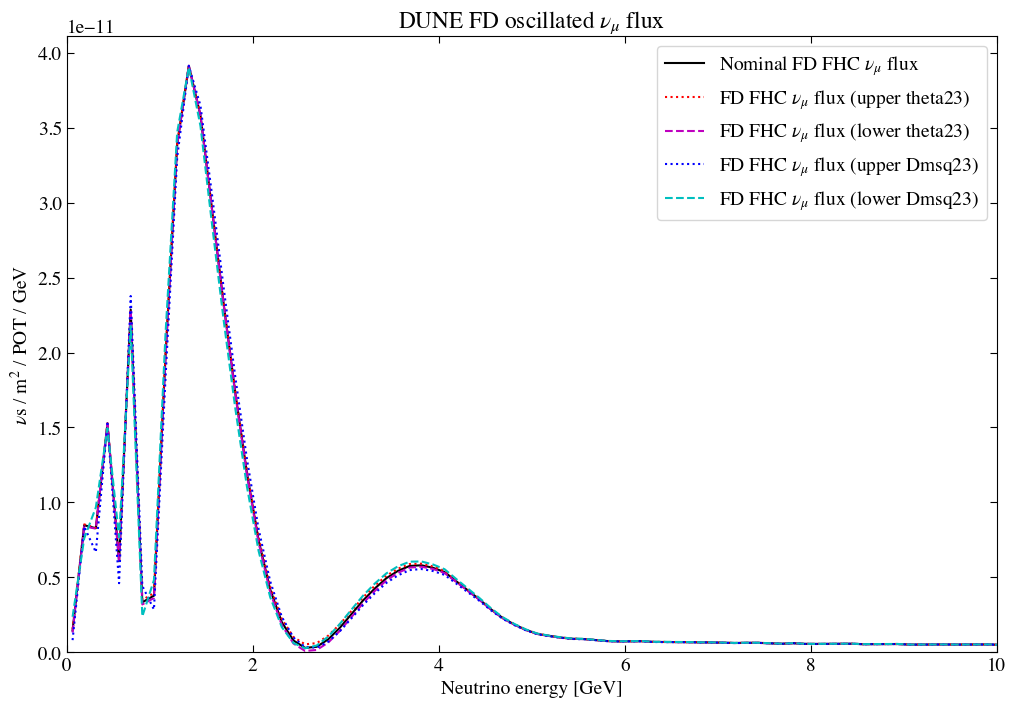

In [4]:
FDosc_Flux_FHCnumu_1300 = np.array([1.45665e-12,8.4815e-12,8.27856e-12,1.5271e-11,6.08194e-12,2.28604e-11,3.34159e-12,3.78033e-12,1.98519e-11,3.39012e-11,3.9121e-11,3.58217e-11,2.95231e-11,2.3216e-11,1.7298e-11,1.19582e-11,7.48608e-12,4.1935e-12,2.00848e-12,7.91106e-13,2.99613e-13,3.71911e-13,8.75393e-13,1.64957e-12,2.56207e-12,3.47155e-12,4.26377e-12,4.9506e-12,5.43927e-12,5.7645e-12,5.80917e-12,5.64294e-12,5.35631e-12,4.74185e-12,4.13661e-12,3.52893e-12,2.86655e-12,2.29219e-12,1.85686e-12,1.49852e-12,1.22797e-12,1.09599e-12,9.88299e-13,9.06843e-13,8.86857e-13,8.21843e-13,7.54924e-13,7.32672e-13,7.38341e-13,7.45011e-13,6.97402e-13,6.92944e-13,6.91213e-13,6.80321e-13,6.66765e-13,6.62837e-13,6.44675e-13,6.24231e-13,6.37306e-13,6.35722e-13,6.01978e-13,5.75012e-13,6.1171e-13,5.65918e-13,5.62034e-13,5.66821e-13,5.71418e-13,5.75835e-13,5.45809e-13,5.49651e-13,5.53348e-13,5.56906e-13,5.18324e-13,5.21377e-13,5.24318e-13,5.27154e-13,5.21088e-13,5.23683e-13,5.26187e-13,5.28605e-13,4.81356e-13,4.83401e-13,4.85378e-13,4.8729e-13,4.5407e-13,4.55731e-13,4.57338e-13,4.58894e-13,4.37273e-13,4.38659e-13,4.40002e-13,4.41304e-13,4.13116e-13,4.14259e-13,4.15368e-13,4.16444e-13,3.97532e-13,3.98498e-13,3.99436e-13,4.00348e-13,3.7189e-13,3.72687e-13,3.73463e-13,3.74217e-13,3.5979e-13,3.60475e-13,3.61141e-13,3.6179e-13,3.36345e-13,3.36916e-13,3.37472e-13,3.38014e-13,3.19136e-13,3.19621e-13,3.20094e-13,3.20555e-13,2.96545e-13,2.96951e-13,2.97346e-13,2.97732e-13,2.93884e-13,2.94246e-13,2.946e-13,2.94946e-13,2.67801e-13,2.681e-13,2.68393e-13,2.68678e-13,2.33293e-13,2.3353e-13,2.33761e-13,2.33987e-13,2.16133e-13,2.16333e-13,2.16528e-13,2.1672e-13,1.91534e-13,1.91696e-13,1.91854e-13,1.92009e-13,1.62623e-13,1.62749e-13,1.62872e-13,1.62993e-13,1.3503e-13,1.35126e-13,1.3522e-13,1.35312e-13,1.21751e-13,1.21831e-13,1.21909e-13,1.21986e-13,1.09195e-13,1.09261e-13,1.09325e-13,1.09389e-13,1.0236e-13,1.02417e-13,1.02473e-13,1.02528e-13,9.63199e-14,9.63697e-14,9.64187e-14,9.64668e-14,9.6514e-14,9.65604e-14,9.66059e-14,9.66507e-14,9.66947e-14,9.67379e-14,9.67804e-14,9.68221e-14,9.68632e-14,9.69035e-14,9.69432e-14,9.69822e-14,7.93789e-14,7.94097e-14,7.94401e-14,7.94699e-14,7.94993e-14,7.95282e-14,7.95566e-14,7.95845e-14,7.9612e-14,7.96391e-14,7.96657e-14,7.9692e-14,7.97178e-14,7.97432e-14,7.97682e-14,7.97928e-14,6.28433e-14,6.28621e-14,6.28806e-14,6.28989e-14,6.29168e-14,6.29345e-14,6.2952e-14,6.29691e-14,6.29861e-14,6.30027e-14,6.30192e-14,6.30353e-14,6.30513e-14,6.3067e-14,6.30825e-14,6.30978e-14,4.94605e-14,4.94722e-14,4.94836e-14,4.94949e-14,4.95061e-14,4.95171e-14,4.9528e-14,4.95386e-14,4.95492e-14,4.95596e-14,4.95699e-14,4.958e-14,4.959e-14,4.95999e-14,4.96096e-14,4.96192e-14,3.87453e-14,3.87526e-14,3.87598e-14,3.87669e-14,3.87739e-14,3.87808e-14,3.87877e-14,3.87944e-14,3.88011e-14,3.88077e-14,3.88141e-14,3.88206e-14,3.88269e-14,3.88331e-14,3.88393e-14,3.88454e-14,3.36188e-14,3.36239e-14,3.3629e-14,3.3634e-14,3.3639e-14,3.36439e-14,3.36487e-14,3.36535e-14,3.36582e-14,3.36629e-14,3.36675e-14,3.36721e-14,3.36766e-14,3.3681e-14,3.36854e-14,3.36898e-14,2.46367e-14,2.46398e-14,2.46429e-14,2.46459e-14,2.46489e-14,2.46519e-14,2.46548e-14,2.46578e-14,2.46606e-14,2.46635e-14,2.46663e-14,2.4669e-14,2.46718e-14,2.46745e-14,2.46772e-14,2.46798e-14,1.84236e-14,1.84255e-14,1.84274e-14,1.84293e-14,1.84312e-14,1.84331e-14,1.84349e-14,1.84367e-14,1.84385e-14,1.84403e-14,1.8442e-14,1.84438e-14,1.84455e-14,1.84472e-14,1.84489e-14,1.84506e-14,1.58983e-14,1.58997e-14,1.59011e-14,1.59024e-14,1.59038e-14,1.59052e-14,1.59065e-14,1.59078e-14,1.59091e-14,1.59104e-14,1.59117e-14,1.5913e-14,1.59143e-14,1.59155e-14,1.59167e-14,1.5918e-14,1.43894e-14,1.43905e-14,1.43915e-14,1.43926e-14,1.43936e-14,1.43947e-14,1.43957e-14,1.43967e-14,1.43978e-14,1.43988e-14,1.43998e-14,1.44007e-14,1.44017e-14,1.44027e-14,1.44036e-14,1.44046e-14,1.05131e-14,1.05138e-14,1.05145e-14,1.05152e-14,1.05158e-14,1.05165e-14,1.05171e-14,1.05178e-14,1.05184e-14,1.0519e-14,1.05197e-14,1.05203e-14,1.05209e-14,1.05215e-14,1.05221e-14,1.05227e-14,8.75632e-15,8.75681e-15,8.7573e-15,8.75778e-15,8.75825e-15,8.75873e-15,8.75919e-15,8.75966e-15,8.76012e-15,8.76057e-15,8.76102e-15,8.76147e-15,8.76192e-15,8.76236e-15,8.76279e-15,8.76323e-15,7.98481e-15,7.9852e-15,7.98558e-15,7.98597e-15,7.98634e-15,7.98672e-15,7.98709e-15,7.98746e-15,7.98783e-15,7.98819e-15,7.98855e-15,7.9889e-15,7.98926e-15,7.98961e-15,7.98996e-15,7.9903e-15,6.55704e-15,6.55732e-15,6.5576e-15,6.55787e-15,6.55814e-15,6.55841e-15,6.55868e-15,6.55895e-15,6.55921e-15,6.55947e-15,6.55973e-15,6.55999e-15,6.56024e-15,6.5605e-15,6.56075e-15,6.561e-15,4.69919e-15,4.69936e-15,4.69954e-15,4.69971e-15,4.69988e-15,4.70005e-15,4.70022e-15,4.70039e-15,4.70056e-15,4.70072e-15,4.70089e-15,4.70105e-15,4.70121e-15,4.70137e-15,4.70153e-15,4.70169e-15,4.42933e-15,4.42948e-15,4.42962e-15,4.42977e-15,4.42991e-15,4.43005e-15,4.4302e-15,4.43034e-15,4.43048e-15,4.43061e-15,4.43075e-15,4.43089e-15,4.43102e-15,4.43116e-15,4.43129e-15,4.43142e-15,3.22516e-15,3.22525e-15,3.22535e-15,3.22544e-15,3.22553e-15,3.22563e-15,3.22572e-15,3.22581e-15,3.2259e-15,3.22599e-15,3.22608e-15,3.22617e-15,3.22625e-15,3.22634e-15,3.22643e-15,3.22651e-15,2.55828e-15,2.55835e-15,2.55841e-15,2.55848e-15,2.55854e-15,2.55861e-15,2.55867e-15,2.55874e-15,2.5588e-15,2.55887e-15,2.55893e-15,2.55899e-15,2.55906e-15,2.55912e-15,2.55918e-15,2.55924e-15,2.81248e-15,2.81254e-15,2.81261e-15,2.81268e-15,2.81274e-15,2.81281e-15,2.81287e-15,2.81293e-15,2.813e-15,2.81306e-15,2.81312e-15,2.81318e-15,2.81325e-15,2.81331e-15,2.81337e-15,2.81343e-15,1.6984e-15,1.69844e-15,1.69847e-15,1.69851e-15,1.69854e-15,1.69858e-15,1.69861e-15,1.69865e-15,1.69868e-15,1.69872e-15,1.69875e-15,1.69878e-15,1.69882e-15,1.69885e-15,1.69888e-15,1.69892e-15,1.88869e-15,1.88872e-15,1.88876e-15,1.88879e-15,1.88883e-15,1.88886e-15,1.8889e-15,1.88893e-15,1.88897e-15,1.889e-15,1.88904e-15,1.88907e-15,1.88911e-15,1.88914e-15,1.88917e-15,1.88921e-15,1.28502e-15,1.28505e-15,1.28507e-15,1.28509e-15,1.28511e-15,1.28513e-15,1.28515e-15,1.28518e-15,1.2852e-15,1.28522e-15,1.28524e-15,1.28526e-15,1.28528e-15,1.2853e-15,1.28532e-15,1.28534e-15,9.40804e-16,9.40819e-16,9.40834e-16,9.40848e-16,9.40863e-16,9.40877e-16,9.40892e-16,9.40906e-16,9.4092e-16,9.40935e-16,9.40949e-16,9.40963e-16,9.40977e-16,9.40991e-16,9.41004e-16,9.41018e-16,1.29694e-15,1.29695e-15,1.29697e-15,1.29699e-15,1.29701e-15,1.29703e-15,1.29705e-15,1.29706e-15,1.29708e-15,1.2971e-15,1.29712e-15,1.29714e-15,1.29715e-15,1.29717e-15,1.29719e-15,1.2972e-15,7.29158e-16,7.29168e-16,7.29177e-16,7.29187e-16,7.29196e-16,7.29206e-16,7.29215e-16,7.29224e-16,7.29234e-16,7.29243e-16,7.29252e-16,7.29261e-16,7.2927e-16,7.29279e-16,7.29288e-16,7.29297e-16])
FDosc_Flux_FHCnumu_t23p = np.array([1.55477e-12,8.53591e-12,8.30342e-12,1.52841e-11,6.16843e-12,2.28817e-11,3.49777e-12,3.95173e-12,1.99437e-11,3.39221e-11,3.91144e-11,3.58264e-11,2.95592e-11,2.32923e-11,1.74167e-11,1.21159e-11,7.67355e-12,4.40202e-12,2.22908e-12,1.0213e-12,5.36652e-13,6.15437e-13,1.11997e-12,1.88506e-12,2.78434e-12,3.67632e-12,4.44796e-12,5.11553e-12,5.58441e-12,5.89124e-12,5.91678e-12,5.73258e-12,5.43034e-12,4.79955e-12,4.18137e-12,3.56318e-12,2.8917e-12,2.31048e-12,1.87041e-12,1.50857e-12,1.23557e-12,1.10228e-12,9.93573e-13,9.11358e-13,8.90989e-13,8.25436e-13,7.5803e-13,7.35513e-13,7.41046e-13,7.47595e-13,6.99696e-13,6.9511e-13,6.93267e-13,6.82248e-13,6.68567e-13,6.64548e-13,6.46267e-13,6.25707e-13,6.38751e-13,6.37105e-13,6.03236e-13,5.76167e-13,6.12893e-13,5.66972e-13,5.63043e-13,5.67802e-13,5.72373e-13,5.76765e-13,5.46661e-13,5.50481e-13,5.54157e-13,5.57694e-13,5.19035e-13,5.2207e-13,5.24995e-13,5.27814e-13,5.21721e-13,5.24301e-13,5.26791e-13,5.29195e-13,4.81878e-13,4.83912e-13,4.85877e-13,4.87778e-13,4.54514e-13,4.56164e-13,4.57762e-13,4.59309e-13,4.37659e-13,4.39037e-13,4.40372e-13,4.41667e-13,4.13448e-13,4.14584e-13,4.15687e-13,4.16757e-13,3.97824e-13,3.98784e-13,3.99716e-13,4.00622e-13,3.7214e-13,3.72933e-13,3.73704e-13,3.74454e-13,3.60012e-13,3.60693e-13,3.61356e-13,3.62001e-13,3.36537e-13,3.37105e-13,3.37658e-13,3.38196e-13,3.19305e-13,3.19788e-13,3.20258e-13,3.20716e-13,2.96691e-13,2.97094e-13,2.97487e-13,2.97871e-13,2.94019e-13,2.94379e-13,2.94731e-13,2.95074e-13,2.67916e-13,2.68214e-13,2.68504e-13,2.68788e-13,2.33387e-13,2.33622e-13,2.33852e-13,2.34077e-13,2.16215e-13,2.16413e-13,2.16608e-13,2.16798e-13,1.91602e-13,1.91763e-13,1.9192e-13,1.92075e-13,1.62677e-13,1.62803e-13,1.62925e-13,1.63045e-13,1.35072e-13,1.35168e-13,1.35261e-13,1.35353e-13,1.21788e-13,1.21867e-13,1.21945e-13,1.22021e-13,1.09226e-13,1.09291e-13,1.09355e-13,1.09419e-13,1.02388e-13,1.02444e-13,1.025e-13,1.02555e-13,9.63444e-14,9.63939e-14,9.64426e-14,9.64904e-14,9.65374e-14,9.65835e-14,9.66288e-14,9.66733e-14,9.6717e-14,9.676e-14,9.68022e-14,9.68437e-14,9.68845e-14,9.69246e-14,9.6964e-14,9.70027e-14,7.93955e-14,7.94262e-14,7.94564e-14,7.9486e-14,7.95152e-14,7.95439e-14,7.95722e-14,7.95999e-14,7.96273e-14,7.96542e-14,7.96807e-14,7.97067e-14,7.97324e-14,7.97577e-14,7.97825e-14,7.9807e-14,6.28544e-14,6.28731e-14,6.28915e-14,6.29096e-14,6.29275e-14,6.2945e-14,6.29624e-14,6.29794e-14,6.29963e-14,6.30128e-14,6.30292e-14,6.30452e-14,6.30611e-14,6.30767e-14,6.30921e-14,6.31073e-14,4.94679e-14,4.94795e-14,4.94909e-14,4.95021e-14,4.95132e-14,4.95242e-14,4.95349e-14,4.95456e-14,4.95561e-14,4.95664e-14,4.95766e-14,4.95867e-14,4.95966e-14,4.96064e-14,4.96161e-14,4.96256e-14,3.87503e-14,3.87575e-14,3.87647e-14,3.87718e-14,3.87787e-14,3.87856e-14,3.87924e-14,3.87991e-14,3.88057e-14,3.88123e-14,3.88187e-14,3.88251e-14,3.88314e-14,3.88376e-14,3.88437e-14,3.88498e-14,3.36225e-14,3.36277e-14,3.36327e-14,3.36377e-14,3.36426e-14,3.36475e-14,3.36523e-14,3.36571e-14,3.36618e-14,3.36664e-14,3.3671e-14,3.36755e-14,3.368e-14,3.36844e-14,3.36888e-14,3.36931e-14,2.46392e-14,2.46422e-14,2.46453e-14,2.46483e-14,2.46513e-14,2.46543e-14,2.46572e-14,2.46601e-14,2.46629e-14,2.46657e-14,2.46685e-14,2.46713e-14,2.4674e-14,2.46767e-14,2.46794e-14,2.4682e-14,1.84252e-14,1.84271e-14,1.8429e-14,1.84309e-14,1.84328e-14,1.84346e-14,1.84364e-14,1.84382e-14,1.844e-14,1.84418e-14,1.84435e-14,1.84453e-14,1.8447e-14,1.84487e-14,1.84504e-14,1.8452e-14,1.58995e-14,1.59009e-14,1.59023e-14,1.59037e-14,1.5905e-14,1.59064e-14,1.59077e-14,1.5909e-14,1.59103e-14,1.59116e-14,1.59129e-14,1.59141e-14,1.59154e-14,1.59166e-14,1.59179e-14,1.59191e-14,1.43904e-14,1.43914e-14,1.43925e-14,1.43936e-14,1.43946e-14,1.43957e-14,1.43967e-14,1.43977e-14,1.43987e-14,1.43997e-14,1.44007e-14,1.44017e-14,1.44026e-14,1.44036e-14,1.44046e-14,1.44055e-14,1.05138e-14,1.05145e-14,1.05151e-14,1.05158e-14,1.05165e-14,1.05171e-14,1.05178e-14,1.05184e-14,1.0519e-14,1.05197e-14,1.05203e-14,1.05209e-14,1.05215e-14,1.05221e-14,1.05227e-14,1.05233e-14,8.75682e-15,8.75731e-15,8.75779e-15,8.75827e-15,8.75874e-15,8.75921e-15,8.75968e-15,8.76014e-15,8.76059e-15,8.76105e-15,8.7615e-15,8.76194e-15,8.76238e-15,8.76282e-15,8.76325e-15,8.76368e-15,7.98523e-15,7.98561e-15,7.986e-15,7.98637e-15,7.98675e-15,7.98712e-15,7.98749e-15,7.98786e-15,7.98822e-15,7.98858e-15,7.98894e-15,7.98929e-15,7.98965e-15,7.99e-15,7.99034e-15,7.99068e-15,6.55735e-15,6.55763e-15,6.55791e-15,6.55818e-15,6.55845e-15,6.55872e-15,6.55898e-15,6.55925e-15,6.55951e-15,6.55977e-15,6.56003e-15,6.56028e-15,6.56054e-15,6.56079e-15,6.56104e-15,6.56129e-15,4.69939e-15,4.69957e-15,4.69974e-15,4.69991e-15,4.70008e-15,4.70025e-15,4.70042e-15,4.70059e-15,4.70075e-15,4.70092e-15,4.70108e-15,4.70124e-15,4.7014e-15,4.70156e-15,4.70172e-15,4.70188e-15,4.42951e-15,4.42966e-15,4.4298e-15,4.42994e-15,4.43009e-15,4.43023e-15,4.43037e-15,4.43051e-15,4.43065e-15,4.43078e-15,4.43092e-15,4.43106e-15,4.43119e-15,4.43132e-15,4.43146e-15,4.43159e-15,3.22528e-15,3.22537e-15,3.22547e-15,3.22556e-15,3.22565e-15,3.22574e-15,3.22583e-15,3.22592e-15,3.22601e-15,3.2261e-15,3.22619e-15,3.22628e-15,3.22637e-15,3.22645e-15,3.22654e-15,3.22663e-15,2.55837e-15,2.55843e-15,2.5585e-15,2.55857e-15,2.55863e-15,2.5587e-15,2.55876e-15,2.55883e-15,2.55889e-15,2.55895e-15,2.55901e-15,2.55908e-15,2.55914e-15,2.5592e-15,2.55926e-15,2.55932e-15,2.81257e-15,2.81263e-15,2.8127e-15,2.81277e-15,2.81283e-15,2.81289e-15,2.81296e-15,2.81302e-15,2.81308e-15,2.81315e-15,2.81321e-15,2.81327e-15,2.81333e-15,2.81339e-15,2.81345e-15,2.81351e-15,1.69845e-15,1.69849e-15,1.69852e-15,1.69856e-15,1.69859e-15,1.69863e-15,1.69866e-15,1.6987e-15,1.69873e-15,1.69877e-15,1.6988e-15,1.69883e-15,1.69887e-15,1.6989e-15,1.69893e-15,1.69897e-15,1.88874e-15,1.88878e-15,1.88881e-15,1.88885e-15,1.88888e-15,1.88892e-15,1.88895e-15,1.88899e-15,1.88902e-15,1.88905e-15,1.88909e-15,1.88912e-15,1.88916e-15,1.88919e-15,1.88922e-15,1.88926e-15,1.28506e-15,1.28508e-15,1.2851e-15,1.28512e-15,1.28514e-15,1.28517e-15,1.28519e-15,1.28521e-15,1.28523e-15,1.28525e-15,1.28527e-15,1.28529e-15,1.28531e-15,1.28534e-15,1.28536e-15,1.28538e-15,9.40827e-16,9.40842e-16,9.40857e-16,9.40871e-16,9.40886e-16,9.409e-16,9.40914e-16,9.40929e-16,9.40943e-16,9.40957e-16,9.40971e-16,9.40985e-16,9.40999e-16,9.41013e-16,9.41026e-16,9.4104e-16,1.29697e-15,1.29698e-15,1.297e-15,1.29702e-15,1.29704e-15,1.29706e-15,1.29708e-15,1.29709e-15,1.29711e-15,1.29713e-15,1.29715e-15,1.29716e-15,1.29718e-15,1.2972e-15,1.29722e-15,1.29723e-15,7.29174e-16,7.29184e-16,7.29193e-16,7.29203e-16,7.29212e-16,7.29221e-16,7.29231e-16,7.2924e-16,7.29249e-16,7.29258e-16,7.29267e-16,7.29276e-16,7.29285e-16,7.29294e-16,7.29303e-16,7.29312e-16])
FDosc_Flux_FHCnumu_t23m = np.array([1.32444e-12,8.40522e-12,8.25221e-12,1.52521e-11,6.00359e-12,2.28367e-11,3.1969e-12,3.62344e-12,1.97674e-11,3.38823e-11,3.91296e-11,3.58227e-11,2.94979e-11,2.31562e-11,1.72011e-11,1.18269e-11,7.32784e-12,4.01585e-12,1.81921e-12,5.9251e-13,9.4186e-14,1.60053e-13,6.61919e-13,1.44344e-12,2.36702e-12,3.29145e-12,4.10145e-12,4.80497e-12,5.31092e-12,5.65223e-12,5.71372e-12,5.56333e-12,5.29048e-12,4.69048e-12,4.09671e-12,3.49837e-12,2.8441e-12,2.27585e-12,1.84475e-12,1.48953e-12,1.22116e-12,1.09035e-12,9.83569e-13,9.0279e-13,8.83145e-13,8.18613e-13,7.52132e-13,7.30115e-13,7.35905e-13,7.42684e-13,6.95335e-13,6.90993e-13,6.8936e-13,6.78583e-13,6.65139e-13,6.61292e-13,6.43237e-13,6.22897e-13,6.36e-13,6.34472e-13,6.0084e-13,5.73967e-13,6.1064e-13,5.64964e-13,5.6112e-13,5.65932e-13,5.70553e-13,5.74993e-13,5.45036e-13,5.48899e-13,5.52615e-13,5.56191e-13,5.17679e-13,5.20748e-13,5.23705e-13,5.26556e-13,5.20513e-13,5.23121e-13,5.25639e-13,5.28069e-13,4.80881e-13,4.82937e-13,4.84925e-13,4.86846e-13,4.53668e-13,4.55337e-13,4.56952e-13,4.58516e-13,4.36922e-13,4.38315e-13,4.39666e-13,4.40975e-13,4.12815e-13,4.13964e-13,4.15079e-13,4.1616e-13,3.97267e-13,3.98238e-13,3.99181e-13,4.00097e-13,3.71662e-13,3.72464e-13,3.73244e-13,3.74002e-13,3.59587e-13,3.60275e-13,3.60946e-13,3.61598e-13,3.3617e-13,3.36744e-13,3.37303e-13,3.37847e-13,3.18982e-13,3.1947e-13,3.19945e-13,3.20409e-13,2.96412e-13,2.96819e-13,2.97217e-13,2.97605e-13,2.93761e-13,2.94125e-13,2.94481e-13,2.94828e-13,2.67696e-13,2.67997e-13,2.68291e-13,2.68578e-13,2.33207e-13,2.33445e-13,2.33678e-13,2.33905e-13,2.16059e-13,2.1626e-13,2.16456e-13,2.16648e-13,1.91472e-13,1.91635e-13,1.91794e-13,1.9195e-13,1.62573e-13,1.627e-13,1.62824e-13,1.62945e-13,1.34991e-13,1.35087e-13,1.35182e-13,1.35275e-13,1.21718e-13,1.21798e-13,1.21877e-13,1.21954e-13,1.09166e-13,1.09233e-13,1.09298e-13,1.09362e-13,1.02335e-13,1.02392e-13,1.02449e-13,1.02504e-13,9.62974e-14,9.63476e-14,9.63968e-14,9.64451e-14,9.64926e-14,9.65393e-14,9.65851e-14,9.66301e-14,9.66743e-14,9.67178e-14,9.67605e-14,9.68024e-14,9.68437e-14,9.68842e-14,9.69241e-14,9.69633e-14,7.93636e-14,7.93947e-14,7.94252e-14,7.94552e-14,7.94847e-14,7.95137e-14,7.95423e-14,7.95704e-14,7.9598e-14,7.96253e-14,7.9652e-14,7.96784e-14,7.97044e-14,7.97299e-14,7.97551e-14,7.97798e-14,6.28332e-14,6.28521e-14,6.28707e-14,6.28891e-14,6.29071e-14,6.29249e-14,6.29424e-14,6.29597e-14,6.29767e-14,6.29935e-14,6.301e-14,6.30263e-14,6.30423e-14,6.30581e-14,6.30737e-14,6.30891e-14,4.94537e-14,4.94654e-14,4.9477e-14,4.94884e-14,4.94996e-14,4.95106e-14,4.95215e-14,4.95323e-14,4.95429e-14,4.95534e-14,4.95637e-14,4.95739e-14,4.95839e-14,4.95938e-14,4.96036e-14,4.96133e-14,3.87407e-14,3.8748e-14,3.87553e-14,3.87624e-14,3.87695e-14,3.87764e-14,3.87833e-14,3.87901e-14,3.87968e-14,3.88034e-14,3.88099e-14,3.88164e-14,3.88228e-14,3.8829e-14,3.88353e-14,3.88414e-14,3.36153e-14,3.36205e-14,3.36256e-14,3.36306e-14,3.36356e-14,3.36406e-14,3.36454e-14,3.36502e-14,3.3655e-14,3.36597e-14,3.36643e-14,3.36689e-14,3.36734e-14,3.36779e-14,3.36824e-14,3.36867e-14,2.46345e-14,2.46376e-14,2.46407e-14,2.46438e-14,2.46468e-14,2.46498e-14,2.46527e-14,2.46556e-14,2.46585e-14,2.46614e-14,2.46642e-14,2.4667e-14,2.46697e-14,2.46725e-14,2.46752e-14,2.46778e-14,1.84221e-14,1.8424e-14,1.8426e-14,1.84279e-14,1.84298e-14,1.84316e-14,1.84335e-14,1.84353e-14,1.84371e-14,1.84389e-14,1.84407e-14,1.84424e-14,1.84441e-14,1.84459e-14,1.84476e-14,1.84492e-14,1.58971e-14,1.58985e-14,1.58999e-14,1.59013e-14,1.59027e-14,1.59041e-14,1.59054e-14,1.59067e-14,1.59081e-14,1.59094e-14,1.59107e-14,1.59119e-14,1.59132e-14,1.59145e-14,1.59157e-14,1.59169e-14,1.43884e-14,1.43895e-14,1.43906e-14,1.43917e-14,1.43927e-14,1.43938e-14,1.43948e-14,1.43959e-14,1.43969e-14,1.43979e-14,1.43989e-14,1.43999e-14,1.44009e-14,1.44018e-14,1.44028e-14,1.44037e-14,1.05125e-14,1.05132e-14,1.05139e-14,1.05146e-14,1.05152e-14,1.05159e-14,1.05165e-14,1.05172e-14,1.05178e-14,1.05185e-14,1.05191e-14,1.05197e-14,1.05203e-14,1.05209e-14,1.05215e-14,1.05221e-14,8.75586e-15,8.75636e-15,8.75684e-15,8.75733e-15,8.7578e-15,8.75828e-15,8.75875e-15,8.75922e-15,8.75968e-15,8.76014e-15,8.76059e-15,8.76104e-15,8.76149e-15,8.76193e-15,8.76237e-15,8.7628e-15,7.98443e-15,7.98482e-15,7.98521e-15,7.98559e-15,7.98597e-15,7.98635e-15,7.98672e-15,7.98709e-15,7.98746e-15,7.98782e-15,7.98819e-15,7.98854e-15,7.9889e-15,7.98925e-15,7.9896e-15,7.98995e-15,6.55676e-15,6.55704e-15,6.55731e-15,6.55759e-15,6.55786e-15,6.55813e-15,6.5584e-15,6.55867e-15,6.55894e-15,6.5592e-15,6.55946e-15,6.55972e-15,6.55997e-15,6.56023e-15,6.56048e-15,6.56073e-15,4.699e-15,4.69918e-15,4.69935e-15,4.69953e-15,4.6997e-15,4.69987e-15,4.70004e-15,4.70021e-15,4.70038e-15,4.70054e-15,4.70071e-15,4.70087e-15,4.70103e-15,4.70119e-15,4.70135e-15,4.70151e-15,4.42917e-15,4.42932e-15,4.42946e-15,4.42961e-15,4.42975e-15,4.42989e-15,4.43004e-15,4.43018e-15,4.43032e-15,4.43046e-15,4.43059e-15,4.43073e-15,4.43087e-15,4.431e-15,4.43114e-15,4.43127e-15,3.22505e-15,3.22514e-15,3.22524e-15,3.22533e-15,3.22542e-15,3.22552e-15,3.22561e-15,3.2257e-15,3.22579e-15,3.22588e-15,3.22597e-15,3.22606e-15,3.22615e-15,3.22624e-15,3.22632e-15,3.22641e-15,2.5582e-15,2.55826e-15,2.55833e-15,2.5584e-15,2.55846e-15,2.55853e-15,2.5586e-15,2.55866e-15,2.55873e-15,2.55879e-15,2.55885e-15,2.55892e-15,2.55898e-15,2.55904e-15,2.5591e-15,2.55916e-15,2.8124e-15,2.81246e-15,2.81253e-15,2.81259e-15,2.81266e-15,2.81272e-15,2.81279e-15,2.81285e-15,2.81292e-15,2.81298e-15,2.81304e-15,2.8131e-15,2.81317e-15,2.81323e-15,2.81329e-15,2.81335e-15,1.69835e-15,1.69839e-15,1.69843e-15,1.69846e-15,1.6985e-15,1.69853e-15,1.69857e-15,1.6986e-15,1.69864e-15,1.69867e-15,1.69871e-15,1.69874e-15,1.69877e-15,1.69881e-15,1.69884e-15,1.69887e-15,1.88864e-15,1.88867e-15,1.88871e-15,1.88875e-15,1.88878e-15,1.88882e-15,1.88885e-15,1.88889e-15,1.88892e-15,1.88896e-15,1.88899e-15,1.88903e-15,1.88906e-15,1.88909e-15,1.88913e-15,1.88916e-15,1.28499e-15,1.28501e-15,1.28504e-15,1.28506e-15,1.28508e-15,1.2851e-15,1.28512e-15,1.28515e-15,1.28517e-15,1.28519e-15,1.28521e-15,1.28523e-15,1.28525e-15,1.28527e-15,1.28529e-15,1.28532e-15,9.40783e-16,9.40798e-16,9.40812e-16,9.40827e-16,9.40842e-16,9.40857e-16,9.40871e-16,9.40885e-16,9.409e-16,9.40914e-16,9.40928e-16,9.40942e-16,9.40956e-16,9.4097e-16,9.40984e-16,9.40998e-16,1.29691e-15,1.29693e-15,1.29695e-15,1.29696e-15,1.29698e-15,1.297e-15,1.29702e-15,1.29704e-15,1.29706e-15,1.29707e-15,1.29709e-15,1.29711e-15,1.29713e-15,1.29714e-15,1.29716e-15,1.29718e-15,7.29144e-16,7.29153e-16,7.29163e-16,7.29172e-16,7.29182e-16,7.29191e-16,7.29201e-16,7.2921e-16,7.29219e-16,7.29229e-16,7.29238e-16,7.29247e-16,7.29256e-16,7.29265e-16,7.29274e-16,7.29283e-16])
FDosc_Flux_FHCnumu_t232p = np.array([1.65588e-12,8.5902e-12,8.33336e-12,1.52969e-11,6.28043e-12,2.29066e-11,3.69798e-12,4.17265e-12,2.00619e-11,3.39492e-11,3.91075e-11,3.58355e-11,2.96104e-11,2.33964e-11,1.75767e-11,1.23267e-11,7.92303e-12,4.67854e-12,2.52087e-12,1.32513e-12,8.48957e-13,9.35814e-13,1.44133e-12,2.19412e-12,3.07576e-12,3.94455e-12,4.68903e-12,5.33126e-12,5.7741e-12,6.0568e-12,6.05726e-12,5.84955e-12,5.52688e-12,4.87476e-12,4.2397e-12,3.6078e-12,2.92443e-12,2.33428e-12,1.88803e-12,1.52164e-12,1.24545e-12,1.11045e-12,1.00043e-12,9.17225e-13,8.96357e-13,8.30103e-13,7.62062e-13,7.39202e-13,7.44557e-13,7.50948e-13,7.02672e-13,6.97918e-13,6.95932e-13,6.84747e-13,6.70903e-13,6.66766e-13,6.48331e-13,6.2762e-13,6.40623e-13,6.38897e-13,6.04865e-13,5.77664e-13,6.14425e-13,5.68337e-13,5.64349e-13,5.69072e-13,5.73609e-13,5.77969e-13,5.47763e-13,5.51555e-13,5.55203e-13,5.58714e-13,5.19954e-13,5.22966e-13,5.25869e-13,5.28668e-13,5.2254e-13,5.25101e-13,5.27572e-13,5.29958e-13,4.82554e-13,4.84572e-13,4.86523e-13,4.88409e-13,4.55086e-13,4.56725e-13,4.5831e-13,4.59845e-13,4.38157e-13,4.39525e-13,4.4085e-13,4.42135e-13,4.13876e-13,4.15004e-13,4.16098e-13,4.1716e-13,3.982e-13,3.99153e-13,4.00078e-13,4.00977e-13,3.72462e-13,3.73249e-13,3.74015e-13,3.74759e-13,3.603e-13,3.60976e-13,3.61633e-13,3.62273e-13,3.36785e-13,3.37349e-13,3.37897e-13,3.38432e-13,3.19524e-13,3.20002e-13,3.20469e-13,3.20924e-13,2.9688e-13,2.9728e-13,2.9767e-13,2.9805e-13,2.94193e-13,2.9455e-13,2.94899e-13,2.9524e-13,2.68064e-13,2.6836e-13,2.68648e-13,2.6893e-13,2.33508e-13,2.33741e-13,2.33969e-13,2.34193e-13,2.1632e-13,2.16517e-13,2.1671e-13,2.16898e-13,1.9169e-13,1.91849e-13,1.92006e-13,1.92159e-13,1.62748e-13,1.62872e-13,1.62993e-13,1.63113e-13,1.35127e-13,1.35222e-13,1.35315e-13,1.35406e-13,1.21834e-13,1.21913e-13,1.2199e-13,1.22066e-13,1.09265e-13,1.0933e-13,1.09394e-13,1.09457e-13,1.02423e-13,1.02479e-13,1.02535e-13,1.02589e-13,9.6376e-14,9.64252e-14,9.64735e-14,9.65209e-14,9.65675e-14,9.66132e-14,9.66582e-14,9.67023e-14,9.67457e-14,9.67883e-14,9.68302e-14,9.68714e-14,9.69119e-14,9.69517e-14,9.69908e-14,9.70293e-14,7.9417e-14,7.94474e-14,7.94773e-14,7.95068e-14,7.95357e-14,7.95642e-14,7.95922e-14,7.96198e-14,7.96469e-14,7.96736e-14,7.96999e-14,7.97258e-14,7.97512e-14,7.97763e-14,7.9801e-14,7.98253e-14,6.28686e-14,6.28872e-14,6.29054e-14,6.29234e-14,6.29411e-14,6.29586e-14,6.29758e-14,6.29927e-14,6.30094e-14,6.30258e-14,6.3042e-14,6.3058e-14,6.30737e-14,6.30893e-14,6.31045e-14,6.31196e-14,4.94775e-14,4.94889e-14,4.95003e-14,4.95114e-14,4.95224e-14,4.95333e-14,4.9544e-14,4.95545e-14,4.95649e-14,4.95752e-14,4.95853e-14,4.95953e-14,4.96052e-14,4.96149e-14,4.96245e-14,4.96339e-14,3.87567e-14,3.87639e-14,3.8771e-14,3.8778e-14,3.87849e-14,3.87918e-14,3.87985e-14,3.88052e-14,3.88117e-14,3.88182e-14,3.88246e-14,3.8831e-14,3.88372e-14,3.88434e-14,3.88495e-14,3.88555e-14,3.36274e-14,3.36325e-14,3.36375e-14,3.36424e-14,3.36473e-14,3.36522e-14,3.36569e-14,3.36617e-14,3.36663e-14,3.36709e-14,3.36755e-14,3.368e-14,3.36844e-14,3.36888e-14,3.36932e-14,3.36975e-14,2.46423e-14,2.46453e-14,2.46484e-14,2.46514e-14,2.46543e-14,2.46573e-14,2.46602e-14,2.4663e-14,2.46658e-14,2.46686e-14,2.46714e-14,2.46741e-14,2.46769e-14,2.46795e-14,2.46822e-14,2.46848e-14,1.84272e-14,1.84292e-14,1.84311e-14,1.84329e-14,1.84348e-14,1.84366e-14,1.84384e-14,1.84402e-14,1.8442e-14,1.84437e-14,1.84455e-14,1.84472e-14,1.84489e-14,1.84506e-14,1.84522e-14,1.84539e-14,1.59011e-14,1.59025e-14,1.59039e-14,1.59052e-14,1.59066e-14,1.59079e-14,1.59092e-14,1.59105e-14,1.59118e-14,1.59131e-14,1.59144e-14,1.59156e-14,1.59169e-14,1.59181e-14,1.59193e-14,1.59205e-14,1.43917e-14,1.43927e-14,1.43938e-14,1.43948e-14,1.43959e-14,1.43969e-14,1.43979e-14,1.43989e-14,1.43999e-14,1.44009e-14,1.44019e-14,1.44029e-14,1.44038e-14,1.44048e-14,1.44057e-14,1.44067e-14,1.05147e-14,1.05153e-14,1.0516e-14,1.05166e-14,1.05173e-14,1.05179e-14,1.05186e-14,1.05192e-14,1.05198e-14,1.05205e-14,1.05211e-14,1.05217e-14,1.05223e-14,1.05229e-14,1.05235e-14,1.05241e-14,8.75747e-15,8.75795e-15,8.75843e-15,8.7589e-15,8.75937e-15,8.75984e-15,8.7603e-15,8.76075e-15,8.76121e-15,8.76166e-15,8.7621e-15,8.76254e-15,8.76298e-15,8.76342e-15,8.76385e-15,8.76427e-15,7.98576e-15,7.98615e-15,7.98652e-15,7.9869e-15,7.98727e-15,7.98764e-15,7.98801e-15,7.98837e-15,7.98873e-15,7.98909e-15,7.98945e-15,7.9898e-15,7.99015e-15,7.99049e-15,7.99084e-15,7.99118e-15,6.55776e-15,6.55803e-15,6.5583e-15,6.55857e-15,6.55884e-15,6.55911e-15,6.55937e-15,6.55963e-15,6.55989e-15,6.56015e-15,6.56041e-15,6.56066e-15,6.56091e-15,6.56116e-15,6.56141e-15,6.56166e-15,4.69966e-15,4.69983e-15,4.7e-15,4.70017e-15,4.70034e-15,4.70051e-15,4.70068e-15,4.70084e-15,4.70101e-15,4.70117e-15,4.70133e-15,4.70149e-15,4.70165e-15,4.70181e-15,4.70197e-15,4.70212e-15,4.42974e-15,4.42989e-15,4.43003e-15,4.43017e-15,4.43031e-15,4.43045e-15,4.43059e-15,4.43073e-15,4.43087e-15,4.431e-15,4.43114e-15,4.43127e-15,4.43141e-15,4.43154e-15,4.43167e-15,4.4318e-15,3.22543e-15,3.22553e-15,3.22562e-15,3.22571e-15,3.2258e-15,3.22589e-15,3.22598e-15,3.22607e-15,3.22616e-15,3.22625e-15,3.22634e-15,3.22643e-15,3.22651e-15,3.2266e-15,3.22668e-15,3.22677e-15,2.55848e-15,2.55855e-15,2.55861e-15,2.55868e-15,2.55874e-15,2.55881e-15,2.55887e-15,2.55894e-15,2.559e-15,2.55906e-15,2.55912e-15,2.55919e-15,2.55925e-15,2.55931e-15,2.55937e-15,2.55943e-15,2.81269e-15,2.81275e-15,2.81282e-15,2.81288e-15,2.81294e-15,2.81301e-15,2.81307e-15,2.81313e-15,2.8132e-15,2.81326e-15,2.81332e-15,2.81338e-15,2.81344e-15,2.8135e-15,2.81356e-15,2.81362e-15,1.69852e-15,1.69855e-15,1.69859e-15,1.69862e-15,1.69866e-15,1.69869e-15,1.69873e-15,1.69876e-15,1.6988e-15,1.69883e-15,1.69886e-15,1.6989e-15,1.69893e-15,1.69896e-15,1.69899e-15,1.69903e-15,1.88881e-15,1.88884e-15,1.88888e-15,1.88891e-15,1.88895e-15,1.88898e-15,1.88902e-15,1.88905e-15,1.88909e-15,1.88912e-15,1.88915e-15,1.88919e-15,1.88922e-15,1.88925e-15,1.88929e-15,1.88932e-15,1.2851e-15,1.28512e-15,1.28514e-15,1.28517e-15,1.28519e-15,1.28521e-15,1.28523e-15,1.28525e-15,1.28527e-15,1.28529e-15,1.28531e-15,1.28534e-15,1.28536e-15,1.28538e-15,1.2854e-15,1.28542e-15,9.40857e-16,9.40872e-16,9.40886e-16,9.40901e-16,9.40915e-16,9.40929e-16,9.40944e-16,9.40958e-16,9.40972e-16,9.40986e-16,9.41e-16,9.41014e-16,9.41027e-16,9.41041e-16,9.41055e-16,9.41068e-16,1.297e-15,1.29702e-15,1.29704e-15,1.29706e-15,1.29708e-15,1.2971e-15,1.29711e-15,1.29713e-15,1.29715e-15,1.29717e-15,1.29718e-15,1.2972e-15,1.29722e-15,1.29724e-15,1.29725e-15,1.29727e-15,7.29194e-16,7.29204e-16,7.29213e-16,7.29223e-16,7.29232e-16,7.29241e-16,7.29251e-16,7.2926e-16,7.29269e-16,7.29278e-16,7.29287e-16,7.29296e-16,7.29305e-16,7.29314e-16,7.29322e-16,7.29331e-16])
FDosc_Flux_FHCnumu_t232m = np.array([1.19838e-12,8.32889e-12,8.2356e-12,1.52326e-11,5.97493e-12,2.28202e-11,3.13852e-12,3.56331e-12,1.97342e-11,3.38755e-11,3.91373e-11,3.58326e-11,2.95022e-11,2.31514e-11,1.71852e-11,1.17999e-11,7.2912e-12,3.97153e-12,1.76944e-12,5.3819e-13,3.62266e-14,9.87497e-14,5.98831e-13,1.38141e-12,2.3074e-12,3.23565e-12,4.05055e-12,4.75881e-12,5.26983e-12,5.61598e-12,5.68264e-12,5.53721e-12,5.26874e-12,4.67341e-12,4.08338e-12,3.4881e-12,2.83652e-12,2.27031e-12,1.84062e-12,1.48645e-12,1.21882e-12,1.08841e-12,9.81931e-13,9.01382e-13,8.81851e-13,8.17484e-13,7.51154e-13,7.29217e-13,7.35047e-13,7.41862e-13,6.94604e-13,6.903e-13,6.887e-13,6.77963e-13,6.64558e-13,6.60739e-13,6.42722e-13,6.22418e-13,6.35531e-13,6.34021e-13,6.00429e-13,5.73589e-13,6.10253e-13,5.64618e-13,5.60789e-13,5.65609e-13,5.70238e-13,5.74686e-13,5.44755e-13,5.48624e-13,5.52347e-13,5.5593e-13,5.17443e-13,5.20517e-13,5.23479e-13,5.26335e-13,5.20301e-13,5.22914e-13,5.25436e-13,5.27871e-13,4.80705e-13,4.82766e-13,4.84757e-13,4.86682e-13,4.53518e-13,4.55191e-13,4.56809e-13,4.58376e-13,4.36791e-13,4.38187e-13,4.3954e-13,4.40852e-13,4.12702e-13,4.13854e-13,4.1497e-13,4.16054e-13,3.97168e-13,3.98141e-13,3.99086e-13,4.00003e-13,3.71577e-13,3.7238e-13,3.73161e-13,3.73921e-13,3.59511e-13,3.60201e-13,3.60872e-13,3.61526e-13,3.36104e-13,3.36679e-13,3.37239e-13,3.37785e-13,3.18924e-13,3.19413e-13,3.19889e-13,3.20353e-13,2.96362e-13,2.9677e-13,2.97168e-13,2.97557e-13,2.93714e-13,2.94079e-13,2.94436e-13,2.94784e-13,2.67657e-13,2.67958e-13,2.68252e-13,2.6854e-13,2.33175e-13,2.33413e-13,2.33646e-13,2.33874e-13,2.1603e-13,2.16232e-13,2.16429e-13,2.16621e-13,1.91448e-13,1.91611e-13,1.91771e-13,1.91927e-13,1.62555e-13,1.62681e-13,1.62806e-13,1.62927e-13,1.34976e-13,1.35073e-13,1.35167e-13,1.3526e-13,1.21705e-13,1.21786e-13,1.21864e-13,1.21942e-13,1.09156e-13,1.09222e-13,1.09287e-13,1.09351e-13,1.02325e-13,1.02383e-13,1.0244e-13,1.02495e-13,9.62889e-14,9.63391e-14,9.63884e-14,9.64369e-14,9.64844e-14,9.65312e-14,9.65771e-14,9.66222e-14,9.66665e-14,9.671e-14,9.67528e-14,9.67949e-14,9.68362e-14,9.68769e-14,9.69168e-14,9.69561e-14,7.93578e-14,7.93889e-14,7.94195e-14,7.94495e-14,7.94791e-14,7.95082e-14,7.95368e-14,7.9565e-14,7.95927e-14,7.962e-14,7.96468e-14,7.96732e-14,7.96992e-14,7.97248e-14,7.975e-14,7.97748e-14,6.28293e-14,6.28482e-14,6.28669e-14,6.28853e-14,6.29034e-14,6.29212e-14,6.29388e-14,6.29561e-14,6.29731e-14,6.29899e-14,6.30065e-14,6.30228e-14,6.30388e-14,6.30547e-14,6.30703e-14,6.30857e-14,4.94511e-14,4.94629e-14,4.94744e-14,4.94858e-14,4.94971e-14,4.95081e-14,4.95191e-14,4.95298e-14,4.95405e-14,4.9551e-14,4.95613e-14,4.95715e-14,4.95816e-14,4.95915e-14,4.96013e-14,4.9611e-14,3.87389e-14,3.87463e-14,3.87535e-14,3.87607e-14,3.87678e-14,3.87748e-14,3.87816e-14,3.87884e-14,3.87952e-14,3.88018e-14,3.88083e-14,3.88148e-14,3.88212e-14,3.88275e-14,3.88337e-14,3.88398e-14,3.3614e-14,3.36192e-14,3.36243e-14,3.36293e-14,3.36343e-14,3.36393e-14,3.36442e-14,3.3649e-14,3.36537e-14,3.36584e-14,3.36631e-14,3.36677e-14,3.36722e-14,3.36767e-14,3.36812e-14,3.36855e-14,2.46336e-14,2.46368e-14,2.46399e-14,2.46429e-14,2.46459e-14,2.46489e-14,2.46519e-14,2.46548e-14,2.46577e-14,2.46606e-14,2.46634e-14,2.46662e-14,2.4669e-14,2.46717e-14,2.46744e-14,2.46771e-14,1.84215e-14,1.84235e-14,1.84254e-14,1.84273e-14,1.84292e-14,1.84311e-14,1.84329e-14,1.84348e-14,1.84366e-14,1.84384e-14,1.84401e-14,1.84419e-14,1.84436e-14,1.84453e-14,1.8447e-14,1.84487e-14,1.58967e-14,1.58981e-14,1.58995e-14,1.59009e-14,1.59023e-14,1.59036e-14,1.5905e-14,1.59063e-14,1.59076e-14,1.5909e-14,1.59102e-14,1.59115e-14,1.59128e-14,1.59141e-14,1.59153e-14,1.59165e-14,1.43881e-14,1.43892e-14,1.43903e-14,1.43913e-14,1.43924e-14,1.43934e-14,1.43945e-14,1.43955e-14,1.43965e-14,1.43975e-14,1.43985e-14,1.43995e-14,1.44005e-14,1.44015e-14,1.44025e-14,1.44034e-14,1.05123e-14,1.0513e-14,1.05137e-14,1.05143e-14,1.0515e-14,1.05157e-14,1.05163e-14,1.0517e-14,1.05176e-14,1.05182e-14,1.05189e-14,1.05195e-14,1.05201e-14,1.05207e-14,1.05213e-14,1.05219e-14,8.75569e-15,8.75618e-15,8.75667e-15,8.75715e-15,8.75763e-15,8.75811e-15,8.75858e-15,8.75904e-15,8.75951e-15,8.75997e-15,8.76042e-15,8.76087e-15,8.76132e-15,8.76176e-15,8.7622e-15,8.76264e-15,7.98428e-15,7.98467e-15,7.98506e-15,7.98544e-15,7.98583e-15,7.9862e-15,7.98658e-15,7.98695e-15,7.98732e-15,7.98768e-15,7.98805e-15,7.9884e-15,7.98876e-15,7.98911e-15,7.98947e-15,7.98981e-15,6.55664e-15,6.55692e-15,6.5572e-15,6.55748e-15,6.55775e-15,6.55803e-15,6.5583e-15,6.55856e-15,6.55883e-15,6.55909e-15,6.55935e-15,6.55961e-15,6.55987e-15,6.56012e-15,6.56038e-15,6.56063e-15,4.69893e-15,4.6991e-15,4.69928e-15,4.69945e-15,4.69963e-15,4.6998e-15,4.69997e-15,4.70014e-15,4.70031e-15,4.70047e-15,4.70064e-15,4.7008e-15,4.70096e-15,4.70113e-15,4.70129e-15,4.70145e-15,4.4291e-15,4.42925e-15,4.4294e-15,4.42954e-15,4.42969e-15,4.42983e-15,4.42997e-15,4.43012e-15,4.43026e-15,4.4304e-15,4.43053e-15,4.43067e-15,4.43081e-15,4.43094e-15,4.43108e-15,4.43121e-15,3.225e-15,3.2251e-15,3.22519e-15,3.22529e-15,3.22538e-15,3.22548e-15,3.22557e-15,3.22566e-15,3.22575e-15,3.22584e-15,3.22593e-15,3.22602e-15,3.22611e-15,3.2262e-15,3.22628e-15,3.22637e-15,2.55817e-15,2.55823e-15,2.5583e-15,2.55837e-15,2.55843e-15,2.5585e-15,2.55857e-15,2.55863e-15,2.55869e-15,2.55876e-15,2.55882e-15,2.55889e-15,2.55895e-15,2.55901e-15,2.55907e-15,2.55913e-15,2.81236e-15,2.81243e-15,2.8125e-15,2.81256e-15,2.81263e-15,2.81269e-15,2.81276e-15,2.81282e-15,2.81289e-15,2.81295e-15,2.81301e-15,2.81307e-15,2.81314e-15,2.8132e-15,2.81326e-15,2.81332e-15,1.69834e-15,1.69837e-15,1.69841e-15,1.69844e-15,1.69848e-15,1.69851e-15,1.69855e-15,1.69859e-15,1.69862e-15,1.69865e-15,1.69869e-15,1.69872e-15,1.69876e-15,1.69879e-15,1.69882e-15,1.69886e-15,1.88862e-15,1.88866e-15,1.88869e-15,1.88873e-15,1.88876e-15,1.8888e-15,1.88883e-15,1.88887e-15,1.8889e-15,1.88894e-15,1.88897e-15,1.88901e-15,1.88904e-15,1.88908e-15,1.88911e-15,1.88914e-15,1.28498e-15,1.285e-15,1.28502e-15,1.28505e-15,1.28507e-15,1.28509e-15,1.28511e-15,1.28513e-15,1.28516e-15,1.28518e-15,1.2852e-15,1.28522e-15,1.28524e-15,1.28526e-15,1.28528e-15,1.2853e-15,9.40774e-16,9.40789e-16,9.40804e-16,9.40819e-16,9.40834e-16,9.40848e-16,9.40863e-16,9.40877e-16,9.40892e-16,9.40906e-16,9.4092e-16,9.40934e-16,9.40948e-16,9.40962e-16,9.40976e-16,9.4099e-16,1.2969e-15,1.29692e-15,1.29693e-15,1.29695e-15,1.29697e-15,1.29699e-15,1.29701e-15,1.29703e-15,1.29704e-15,1.29706e-15,1.29708e-15,1.2971e-15,1.29712e-15,1.29713e-15,1.29715e-15,1.29717e-15,7.29138e-16,7.29147e-16,7.29157e-16,7.29167e-16,7.29176e-16,7.29186e-16,7.29195e-16,7.29204e-16,7.29214e-16,7.29223e-16,7.29232e-16,7.29241e-16,7.29251e-16,7.2926e-16,7.29269e-16,7.29278e-16])
FDosc_Flux_FHCnumu_m23p = np.array([8.15445e-13,8.39051e-12,6.68127e-12,1.52607e-11,4.61324e-12,2.3768e-11,4.43069e-12,2.85491e-12,1.83617e-11,3.30178e-11,3.91231e-11,3.6469e-11,3.0491e-11,2.42962e-11,1.83527e-11,1.28892e-11,8.23189e-12,4.74093e-12,2.36672e-12,9.87768e-13,3.57945e-13,3.1219e-13,7.16627e-13,1.41737e-12,2.27969e-12,3.16173e-12,3.94663e-12,4.63671e-12,5.14011e-12,5.4856e-12,5.55913e-12,5.42486e-12,5.16899e-12,4.5908e-12,4.01589e-12,3.43412e-12,2.79534e-12,2.23934e-12,1.81698e-12,1.46845e-12,1.20488e-12,1.07663e-12,9.71865e-13,8.92613e-13,8.737e-13,8.10294e-13,7.4486e-13,7.23389e-13,7.29437e-13,7.36449e-13,6.89754e-13,6.85683e-13,6.84284e-13,6.73791e-13,6.6063e-13,6.56984e-13,6.39208e-13,6.19142e-13,6.32307e-13,6.3092e-13,5.97596e-13,5.70975e-13,6.07566e-13,5.62216e-13,5.5848e-13,5.63355e-13,5.68038e-13,5.72538e-13,5.42781e-13,5.46696e-13,5.50463e-13,5.5409e-13,5.1578e-13,5.18891e-13,5.2189e-13,5.24782e-13,5.18807e-13,5.21453e-13,5.24007e-13,5.26473e-13,4.79465e-13,4.81551e-13,4.83568e-13,4.85518e-13,4.5246e-13,4.54154e-13,4.55794e-13,4.57381e-13,4.35866e-13,4.3728e-13,4.38651e-13,4.3998e-13,4.11904e-13,4.13071e-13,4.14203e-13,4.15301e-13,3.96464e-13,3.9745e-13,3.98408e-13,3.99338e-13,3.70971e-13,3.71786e-13,3.72578e-13,3.73348e-13,3.5897e-13,3.5967e-13,3.6035e-13,3.61013e-13,3.35636e-13,3.36219e-13,3.36787e-13,3.3734e-13,3.18512e-13,3.19007e-13,3.1949e-13,3.19961e-13,2.96005e-13,2.96419e-13,2.96823e-13,2.97217e-13,2.93384e-13,2.93755e-13,2.94116e-13,2.94469e-13,2.67376e-13,2.67681e-13,2.6798e-13,2.68272e-13,2.32945e-13,2.33187e-13,2.33424e-13,2.33655e-13,2.15831e-13,2.16035e-13,2.16235e-13,2.1643e-13,1.91282e-13,1.91447e-13,1.91609e-13,1.91768e-13,1.62421e-13,1.6255e-13,1.62676e-13,1.62799e-13,1.34871e-13,1.34969e-13,1.35066e-13,1.3516e-13,1.21616e-13,1.21698e-13,1.21778e-13,1.21856e-13,1.0908e-13,1.09147e-13,1.09213e-13,1.09278e-13,1.02258e-13,1.02316e-13,1.02374e-13,1.0243e-13,9.62286e-14,9.62796e-14,9.63296e-14,9.63787e-14,9.6427e-14,9.64744e-14,9.6521e-14,9.65667e-14,9.66117e-14,9.66558e-14,9.66993e-14,9.67419e-14,9.67839e-14,9.68251e-14,9.68656e-14,9.69055e-14,7.93168e-14,7.93484e-14,7.93794e-14,7.94099e-14,7.94399e-14,7.94694e-14,7.94984e-14,7.9527e-14,7.95551e-14,7.95828e-14,7.961e-14,7.96368e-14,7.96632e-14,7.96892e-14,7.97147e-14,7.97399e-14,6.28021e-14,6.28213e-14,6.28402e-14,6.28589e-14,6.28772e-14,6.28953e-14,6.29132e-14,6.29307e-14,6.2948e-14,6.2965e-14,6.29818e-14,6.29984e-14,6.30147e-14,6.30308e-14,6.30466e-14,6.30622e-14,4.94329e-14,4.94448e-14,4.94565e-14,4.94681e-14,4.94795e-14,4.94907e-14,4.95018e-14,4.95128e-14,4.95236e-14,4.95342e-14,4.95447e-14,4.9555e-14,4.95653e-14,4.95753e-14,4.95853e-14,4.95951e-14,3.87266e-14,3.87341e-14,3.87415e-14,3.87487e-14,3.87559e-14,3.8763e-14,3.877e-14,3.87769e-14,3.87837e-14,3.87904e-14,3.8797e-14,3.88036e-14,3.88101e-14,3.88165e-14,3.88228e-14,3.8829e-14,3.36047e-14,3.36099e-14,3.36151e-14,3.36203e-14,3.36254e-14,3.36304e-14,3.36353e-14,3.36402e-14,3.3645e-14,3.36498e-14,3.36545e-14,3.36592e-14,3.36638e-14,3.36684e-14,3.36729e-14,3.36773e-14,2.46277e-14,2.46308e-14,2.4634e-14,2.46371e-14,2.46402e-14,2.46432e-14,2.46462e-14,2.46492e-14,2.46521e-14,2.4655e-14,2.46579e-14,2.46607e-14,2.46635e-14,2.46663e-14,2.4669e-14,2.46717e-14,1.84176e-14,1.84196e-14,1.84215e-14,1.84234e-14,1.84254e-14,1.84273e-14,1.84291e-14,1.8431e-14,1.84328e-14,1.84347e-14,1.84365e-14,1.84382e-14,1.844e-14,1.84417e-14,1.84435e-14,1.84452e-14,1.58936e-14,1.58951e-14,1.58965e-14,1.58979e-14,1.58993e-14,1.59007e-14,1.59021e-14,1.59034e-14,1.59048e-14,1.59061e-14,1.59074e-14,1.59087e-14,1.591e-14,1.59113e-14,1.59125e-14,1.59138e-14,1.43856e-14,1.43867e-14,1.43878e-14,1.43889e-14,1.439e-14,1.43911e-14,1.43921e-14,1.43932e-14,1.43942e-14,1.43952e-14,1.43962e-14,1.43972e-14,1.43982e-14,1.43992e-14,1.44002e-14,1.44012e-14,1.05107e-14,1.05114e-14,1.0512e-14,1.05127e-14,1.05134e-14,1.05141e-14,1.05147e-14,1.05154e-14,1.0516e-14,1.05167e-14,1.05173e-14,1.0518e-14,1.05186e-14,1.05192e-14,1.05198e-14,1.05204e-14,8.75446e-15,8.75496e-15,8.75545e-15,8.75594e-15,8.75643e-15,8.75691e-15,8.75739e-15,8.75786e-15,8.75833e-15,8.7588e-15,8.75926e-15,8.75972e-15,8.76017e-15,8.76062e-15,8.76107e-15,8.76151e-15,7.98326e-15,7.98366e-15,7.98405e-15,7.98444e-15,7.98483e-15,7.98521e-15,7.98559e-15,7.98597e-15,7.98634e-15,7.98671e-15,7.98708e-15,7.98744e-15,7.98781e-15,7.98816e-15,7.98852e-15,7.98887e-15,6.55588e-15,6.55616e-15,6.55644e-15,6.55672e-15,6.557e-15,6.55728e-15,6.55755e-15,6.55782e-15,6.55809e-15,6.55836e-15,6.55863e-15,6.55889e-15,6.55915e-15,6.55941e-15,6.55967e-15,6.55992e-15,4.69842e-15,4.6986e-15,4.69878e-15,4.69896e-15,4.69913e-15,4.69931e-15,4.69948e-15,4.69965e-15,4.69982e-15,4.69999e-15,4.70016e-15,4.70032e-15,4.70049e-15,4.70065e-15,4.70082e-15,4.70098e-15,4.42867e-15,4.42882e-15,4.42896e-15,4.42911e-15,4.42926e-15,4.4294e-15,4.42955e-15,4.42969e-15,4.42983e-15,4.42998e-15,4.43012e-15,4.43026e-15,4.43039e-15,4.43053e-15,4.43067e-15,4.4308e-15,3.22471e-15,3.22481e-15,3.2249e-15,3.225e-15,3.22509e-15,3.22519e-15,3.22528e-15,3.22537e-15,3.22547e-15,3.22556e-15,3.22565e-15,3.22574e-15,3.22583e-15,3.22592e-15,3.22601e-15,3.2261e-15,2.55795e-15,2.55802e-15,2.55809e-15,2.55815e-15,2.55822e-15,2.55829e-15,2.55835e-15,2.55842e-15,2.55849e-15,2.55855e-15,2.55862e-15,2.55868e-15,2.55874e-15,2.55881e-15,2.55887e-15,2.55893e-15,2.81214e-15,2.81221e-15,2.81228e-15,2.81234e-15,2.81241e-15,2.81248e-15,2.81254e-15,2.81261e-15,2.81267e-15,2.81274e-15,2.8128e-15,2.81286e-15,2.81293e-15,2.81299e-15,2.81305e-15,2.81311e-15,1.69821e-15,1.69825e-15,1.69828e-15,1.69832e-15,1.69836e-15,1.69839e-15,1.69843e-15,1.69846e-15,1.6985e-15,1.69853e-15,1.69857e-15,1.6986e-15,1.69864e-15,1.69867e-15,1.69871e-15,1.69874e-15,1.88849e-15,1.88853e-15,1.88856e-15,1.8886e-15,1.88864e-15,1.88867e-15,1.88871e-15,1.88874e-15,1.88878e-15,1.88881e-15,1.88885e-15,1.88888e-15,1.88892e-15,1.88895e-15,1.88899e-15,1.88902e-15,1.2849e-15,1.28492e-15,1.28494e-15,1.28497e-15,1.28499e-15,1.28501e-15,1.28503e-15,1.28505e-15,1.28508e-15,1.2851e-15,1.28512e-15,1.28514e-15,1.28516e-15,1.28518e-15,1.2852e-15,1.28523e-15,9.40718e-16,9.40733e-16,9.40748e-16,9.40763e-16,9.40778e-16,9.40793e-16,9.40807e-16,9.40822e-16,9.40837e-16,9.40851e-16,9.40866e-16,9.4088e-16,9.40894e-16,9.40908e-16,9.40923e-16,9.40937e-16,1.29682e-15,1.29684e-15,1.29686e-15,1.29688e-15,1.2969e-15,1.29692e-15,1.29694e-15,1.29695e-15,1.29697e-15,1.29699e-15,1.29701e-15,1.29703e-15,1.29705e-15,1.29706e-15,1.29708e-15,1.2971e-15,7.29099e-16,7.29109e-16,7.29118e-16,7.29128e-16,7.29138e-16,7.29147e-16,7.29157e-16,7.29166e-16,7.29176e-16,7.29185e-16,7.29195e-16,7.29204e-16,7.29213e-16,7.29222e-16,7.29232e-16,7.29241e-16])
FDosc_Flux_FHCnumu_m23m = np.array([2.37443e-12,7.60281e-12,9.66307e-12,1.49471e-11,7.67043e-12,2.17713e-11,2.39844e-12,4.82645e-12,2.13244e-11,3.46937e-11,3.90231e-11,3.51077e-11,2.85208e-11,2.21271e-11,1.62535e-11,1.10501e-11,6.77005e-12,3.6785e-12,1.68238e-12,6.25208e-13,2.70006e-13,4.58211e-13,1.0581e-12,1.90237e-12,2.86179e-12,3.79559e-12,4.59226e-12,5.27347e-12,5.74542e-12,6.04874e-12,6.06316e-12,5.86389e-12,5.54566e-12,4.89425e-12,4.2582e-12,3.62429e-12,2.93809e-12,2.34523e-12,1.89684e-12,1.52864e-12,1.25107e-12,1.11535e-12,1.00473e-12,9.21057e-13,8.99992e-13,8.33366e-13,7.64963e-13,7.41927e-13,7.47213e-13,7.53541e-13,7.05019e-13,7.00173e-13,6.98108e-13,6.86819e-13,6.72869e-13,6.68658e-13,6.50111e-13,6.2929e-13,6.42275e-13,6.40494e-13,6.06331e-13,5.79022e-13,6.15826e-13,5.69595e-13,5.65562e-13,5.70261e-13,5.74773e-13,5.79108e-13,5.48813e-13,5.52583e-13,5.5621e-13,5.597e-13,5.20848e-13,5.23842e-13,5.26727e-13,5.29508e-13,5.2335e-13,5.25894e-13,5.28349e-13,5.30719e-13,4.8323e-13,4.85235e-13,4.87173e-13,4.89046e-13,4.55666e-13,4.57293e-13,4.58868e-13,4.60392e-13,4.38667e-13,4.40025e-13,4.41341e-13,4.42617e-13,4.14317e-13,4.15437e-13,4.16523e-13,4.17577e-13,3.9859e-13,3.99536e-13,4.00455e-13,4.01347e-13,3.72799e-13,3.7358e-13,3.7434e-13,3.75078e-13,3.60601e-13,3.61272e-13,3.61925e-13,3.6256e-13,3.37047e-13,3.37606e-13,3.3815e-13,3.38681e-13,3.19754e-13,3.20229e-13,3.20692e-13,3.21144e-13,2.9708e-13,2.97477e-13,2.97864e-13,2.98241e-13,2.94378e-13,2.94733e-13,2.95079e-13,2.95417e-13,2.68223e-13,2.68515e-13,2.68801e-13,2.69081e-13,2.33637e-13,2.33869e-13,2.34095e-13,2.34316e-13,2.16432e-13,2.16628e-13,2.16819e-13,2.17007e-13,1.91784e-13,1.91942e-13,1.92097e-13,1.92249e-13,1.62823e-13,1.62946e-13,1.63067e-13,1.63185e-13,1.35186e-13,1.3528e-13,1.35372e-13,1.35463e-13,1.21885e-13,1.21963e-13,1.22039e-13,1.22114e-13,1.09308e-13,1.09373e-13,1.09436e-13,1.09498e-13,1.02461e-13,1.02517e-13,1.02572e-13,1.02626e-13,9.64102e-14,9.64589e-14,9.65068e-14,9.65539e-14,9.66001e-14,9.66455e-14,9.669e-14,9.67338e-14,9.67768e-14,9.68191e-14,9.68607e-14,9.69015e-14,9.69416e-14,9.69811e-14,9.70199e-14,9.7058e-14,7.94403e-14,7.94705e-14,7.95001e-14,7.95293e-14,7.9558e-14,7.95863e-14,7.96141e-14,7.96414e-14,7.96683e-14,7.96948e-14,7.97208e-14,7.97465e-14,7.97717e-14,7.97966e-14,7.98211e-14,7.98451e-14,6.28841e-14,6.29025e-14,6.29206e-14,6.29384e-14,6.2956e-14,6.29733e-14,6.29904e-14,6.30072e-14,6.30237e-14,6.304e-14,6.30561e-14,6.30719e-14,6.30875e-14,6.31029e-14,6.3118e-14,6.3133e-14,4.94878e-14,4.94992e-14,4.95104e-14,4.95215e-14,4.95324e-14,4.95432e-14,4.95538e-14,4.95642e-14,4.95746e-14,4.95847e-14,4.95948e-14,4.96047e-14,4.96145e-14,4.96241e-14,4.96336e-14,4.9643e-14,3.87637e-14,3.87709e-14,3.87779e-14,3.87848e-14,3.87917e-14,3.87985e-14,3.88052e-14,3.88118e-14,3.88183e-14,3.88247e-14,3.88311e-14,3.88373e-14,3.88435e-14,3.88496e-14,3.88557e-14,3.88616e-14,3.36327e-14,3.36377e-14,3.36427e-14,3.36476e-14,3.36525e-14,3.36573e-14,3.3662e-14,3.36667e-14,3.36713e-14,3.36759e-14,3.36804e-14,3.36848e-14,3.36892e-14,3.36936e-14,3.36979e-14,3.37022e-14,2.46457e-14,2.46487e-14,2.46517e-14,2.46547e-14,2.46576e-14,2.46605e-14,2.46634e-14,2.46662e-14,2.46691e-14,2.46718e-14,2.46746e-14,2.46773e-14,2.468e-14,2.46826e-14,2.46852e-14,2.46878e-14,1.84295e-14,1.84314e-14,1.84333e-14,1.84351e-14,1.8437e-14,1.84388e-14,1.84406e-14,1.84424e-14,1.84441e-14,1.84458e-14,1.84476e-14,1.84493e-14,1.8451e-14,1.84526e-14,1.84543e-14,1.84559e-14,1.59028e-14,1.59042e-14,1.59056e-14,1.59069e-14,1.59083e-14,1.59096e-14,1.59109e-14,1.59122e-14,1.59135e-14,1.59147e-14,1.5916e-14,1.59172e-14,1.59185e-14,1.59197e-14,1.59209e-14,1.59221e-14,1.43931e-14,1.43941e-14,1.43952e-14,1.43962e-14,1.43973e-14,1.43983e-14,1.43993e-14,1.44003e-14,1.44013e-14,1.44023e-14,1.44032e-14,1.44042e-14,1.44051e-14,1.44061e-14,1.4407e-14,1.4408e-14,1.05156e-14,1.05162e-14,1.05169e-14,1.05176e-14,1.05182e-14,1.05188e-14,1.05195e-14,1.05201e-14,1.05207e-14,1.05213e-14,1.0522e-14,1.05226e-14,1.05232e-14,1.05238e-14,1.05243e-14,1.05249e-14,8.75817e-15,8.75865e-15,8.75912e-15,8.75959e-15,8.76006e-15,8.76052e-15,8.76098e-15,8.76143e-15,8.76188e-15,8.76232e-15,8.76277e-15,8.7632e-15,8.76364e-15,8.76407e-15,8.7645e-15,8.76492e-15,7.98635e-15,7.98673e-15,7.9871e-15,7.98747e-15,7.98784e-15,7.98821e-15,7.98857e-15,7.98893e-15,7.98929e-15,7.98965e-15,7.99e-15,7.99035e-15,7.99069e-15,7.99104e-15,7.99138e-15,7.99171e-15,6.5582e-15,6.55847e-15,6.55874e-15,6.55901e-15,6.55927e-15,6.55954e-15,6.5598e-15,6.56006e-15,6.56031e-15,6.56057e-15,6.56082e-15,6.56108e-15,6.56132e-15,6.56157e-15,6.56182e-15,6.56206e-15,4.69995e-15,4.70012e-15,4.70029e-15,4.70046e-15,4.70063e-15,4.70079e-15,4.70096e-15,4.70112e-15,4.70129e-15,4.70145e-15,4.70161e-15,4.70177e-15,4.70192e-15,4.70208e-15,4.70224e-15,4.70239e-15,4.42999e-15,4.43013e-15,4.43028e-15,4.43042e-15,4.43056e-15,4.4307e-15,4.43084e-15,4.43097e-15,4.43111e-15,4.43124e-15,4.43138e-15,4.43151e-15,4.43164e-15,4.43177e-15,4.4319e-15,4.43203e-15,3.2256e-15,3.22569e-15,3.22579e-15,3.22588e-15,3.22597e-15,3.22606e-15,3.22615e-15,3.22624e-15,3.22633e-15,3.22641e-15,3.2265e-15,3.22659e-15,3.22667e-15,3.22676e-15,3.22684e-15,3.22693e-15,2.5586e-15,2.55867e-15,2.55874e-15,2.5588e-15,2.55886e-15,2.55893e-15,2.55899e-15,2.55906e-15,2.55912e-15,2.55918e-15,2.55924e-15,2.5593e-15,2.55936e-15,2.55943e-15,2.55949e-15,2.55955e-15,2.81281e-15,2.81288e-15,2.81294e-15,2.81301e-15,2.81307e-15,2.81313e-15,2.81319e-15,2.81326e-15,2.81332e-15,2.81338e-15,2.81344e-15,2.8135e-15,2.81356e-15,2.81362e-15,2.81368e-15,2.81374e-15,1.69859e-15,1.69862e-15,1.69866e-15,1.69869e-15,1.69873e-15,1.69876e-15,1.6988e-15,1.69883e-15,1.69886e-15,1.6989e-15,1.69893e-15,1.69896e-15,1.699e-15,1.69903e-15,1.69906e-15,1.69909e-15,1.88888e-15,1.88892e-15,1.88895e-15,1.88899e-15,1.88902e-15,1.88906e-15,1.88909e-15,1.88912e-15,1.88916e-15,1.88919e-15,1.88923e-15,1.88926e-15,1.88929e-15,1.88932e-15,1.88936e-15,1.88939e-15,1.28515e-15,1.28517e-15,1.28519e-15,1.28521e-15,1.28523e-15,1.28526e-15,1.28528e-15,1.2853e-15,1.28532e-15,1.28534e-15,1.28536e-15,1.28538e-15,1.2854e-15,1.28542e-15,1.28544e-15,1.28546e-15,9.40889e-16,9.40904e-16,9.40918e-16,9.40933e-16,9.40947e-16,9.40961e-16,9.40975e-16,9.40989e-16,9.41003e-16,9.41017e-16,9.41031e-16,9.41045e-16,9.41058e-16,9.41072e-16,9.41085e-16,9.41099e-16,1.29705e-15,1.29706e-15,1.29708e-15,1.2971e-15,1.29712e-15,1.29714e-15,1.29715e-15,1.29717e-15,1.29719e-15,1.29721e-15,1.29722e-15,1.29724e-15,1.29726e-15,1.29728e-15,1.29729e-15,1.29731e-15,7.29217e-16,7.29226e-16,7.29235e-16,7.29245e-16,7.29254e-16,7.29263e-16,7.29272e-16,7.29281e-16,7.2929e-16,7.29299e-16,7.29308e-16,7.29317e-16,7.29326e-16,7.29335e-16,7.29344e-16,7.29352e-16])
FDosc_Flux_FHCnumu_m232p = np.array([1.6115e-12,7.35144e-12,5.0093e-12,1.49168e-11,3.30372e-12,2.44778e-11,5.65172e-12,2.05913e-12,1.68652e-11,3.20489e-11,3.90293e-11,3.70471e-11,3.14211e-11,2.53646e-11,1.9415e-11,1.3841e-11,9.006e-12,5.31982e-12,2.75654e-12,1.21491e-12,4.44926e-13,2.7912e-13,5.81972e-13,1.206e-12,2.01491e-12,2.86638e-12,3.64108e-12,4.33205e-12,4.84811e-12,5.21222e-12,5.31321e-12,5.20977e-12,4.98381e-12,4.44117e-12,3.89612e-12,3.33991e-12,2.72449e-12,2.18669e-12,1.77722e-12,1.43844e-12,1.18182e-12,1.05728e-12,9.55426e-13,8.78372e-13,8.60525e-13,7.98724e-13,7.34771e-13,7.1408e-13,7.20506e-13,7.27857e-13,6.82076e-13,6.78392e-13,6.77324e-13,6.67229e-13,6.54463e-13,6.511e-13,6.3371e-13,6.14024e-13,6.27278e-13,6.26089e-13,5.93186e-13,5.66913e-13,6.03395e-13,5.58488e-13,5.54902e-13,5.59866e-13,5.64634e-13,5.69217e-13,5.39731e-13,5.43719e-13,5.47557e-13,5.51251e-13,5.13215e-13,5.16386e-13,5.19443e-13,5.2239e-13,5.16508e-13,5.19205e-13,5.21809e-13,5.24323e-13,4.77558e-13,4.79685e-13,4.81742e-13,4.83731e-13,4.50836e-13,4.52564e-13,4.54236e-13,4.55855e-13,4.34446e-13,4.35889e-13,4.37287e-13,4.38643e-13,4.10681e-13,4.11871e-13,4.13026e-13,4.14147e-13,3.95386e-13,3.96393e-13,3.9737e-13,3.98319e-13,3.70044e-13,3.70875e-13,3.71684e-13,3.7247e-13,3.58143e-13,3.58857e-13,3.59552e-13,3.60228e-13,3.3492e-13,3.35515e-13,3.36095e-13,3.3666e-13,3.17881e-13,3.18387e-13,3.1888e-13,3.19361e-13,2.9546e-13,2.95883e-13,2.96295e-13,2.96697e-13,2.9288e-13,2.93258e-13,2.93627e-13,2.93988e-13,2.66946e-13,2.67258e-13,2.67563e-13,2.67861e-13,2.32594e-13,2.32841e-13,2.33083e-13,2.33319e-13,2.15525e-13,2.15734e-13,2.15938e-13,2.16137e-13,1.91027e-13,1.91196e-13,1.91361e-13,1.91523e-13,1.62217e-13,1.62349e-13,1.62477e-13,1.62603e-13,1.34711e-13,1.34812e-13,1.3491e-13,1.35006e-13,1.2148e-13,1.21563e-13,1.21645e-13,1.21725e-13,1.08964e-13,1.09033e-13,1.091e-13,1.09167e-13,1.02155e-13,1.02215e-13,1.02273e-13,1.02331e-13,9.61364e-14,9.61884e-14,9.62396e-14,9.62898e-14,9.63391e-14,9.63875e-14,9.64351e-14,9.64818e-14,9.65278e-14,9.65729e-14,9.66173e-14,9.66609e-14,9.67037e-14,9.67458e-14,9.67873e-14,9.6828e-14,7.92541e-14,7.92863e-14,7.9318e-14,7.93492e-14,7.93799e-14,7.941e-14,7.94397e-14,7.94689e-14,7.94976e-14,7.95259e-14,7.95537e-14,7.95811e-14,7.96081e-14,7.96346e-14,7.96607e-14,7.96865e-14,6.27604e-14,6.27801e-14,6.27994e-14,6.28185e-14,6.28372e-14,6.28557e-14,6.28739e-14,6.28919e-14,6.29095e-14,6.29269e-14,6.29441e-14,6.2961e-14,6.29777e-14,6.29941e-14,6.30103e-14,6.30263e-14,4.9405e-14,4.94172e-14,4.94291e-14,4.9441e-14,4.94526e-14,4.94641e-14,4.94754e-14,4.94866e-14,4.94976e-14,4.95085e-14,4.95192e-14,4.95298e-14,4.95403e-14,4.95506e-14,4.95607e-14,4.95707e-14,3.87078e-14,3.87154e-14,3.8723e-14,3.87304e-14,3.87377e-14,3.87449e-14,3.87521e-14,3.87591e-14,3.87661e-14,3.8773e-14,3.87798e-14,3.87865e-14,3.87931e-14,3.87996e-14,3.88061e-14,3.88124e-14,3.35905e-14,3.35958e-14,3.36011e-14,3.36064e-14,3.36116e-14,3.36167e-14,3.36218e-14,3.36268e-14,3.36317e-14,3.36366e-14,3.36414e-14,3.36462e-14,3.36509e-14,3.36555e-14,3.36601e-14,3.36647e-14,2.46185e-14,2.46217e-14,2.4625e-14,2.46281e-14,2.46313e-14,2.46344e-14,2.46374e-14,2.46405e-14,2.46435e-14,2.46464e-14,2.46494e-14,2.46523e-14,2.46551e-14,2.4658e-14,2.46608e-14,2.46635e-14,1.84115e-14,1.84135e-14,1.84155e-14,1.84175e-14,1.84195e-14,1.84214e-14,1.84233e-14,1.84252e-14,1.84271e-14,1.8429e-14,1.84308e-14,1.84326e-14,1.84344e-14,1.84362e-14,1.8438e-14,1.84397e-14,1.5889e-14,1.58904e-14,1.58919e-14,1.58933e-14,1.58948e-14,1.58962e-14,1.58976e-14,1.5899e-14,1.59003e-14,1.59017e-14,1.5903e-14,1.59044e-14,1.59057e-14,1.5907e-14,1.59083e-14,1.59096e-14,1.43818e-14,1.4383e-14,1.43841e-14,1.43852e-14,1.43863e-14,1.43874e-14,1.43885e-14,1.43895e-14,1.43906e-14,1.43916e-14,1.43927e-14,1.43937e-14,1.43947e-14,1.43957e-14,1.43967e-14,1.43977e-14,1.05082e-14,1.05089e-14,1.05096e-14,1.05103e-14,1.0511e-14,1.05116e-14,1.05123e-14,1.0513e-14,1.05137e-14,1.05143e-14,1.0515e-14,1.05156e-14,1.05163e-14,1.05169e-14,1.05175e-14,1.05182e-14,8.75257e-15,8.75308e-15,8.75359e-15,8.75409e-15,8.75458e-15,8.75508e-15,8.75557e-15,8.75605e-15,8.75653e-15,8.75701e-15,8.75748e-15,8.75795e-15,8.75841e-15,8.75887e-15,8.75933e-15,8.75978e-15,7.98169e-15,7.9821e-15,7.9825e-15,7.9829e-15,7.98329e-15,7.98369e-15,7.98407e-15,7.98446e-15,7.98484e-15,7.98522e-15,7.9856e-15,7.98597e-15,7.98634e-15,7.98671e-15,7.98707e-15,7.98743e-15,6.5547e-15,6.55499e-15,6.55528e-15,6.55557e-15,6.55585e-15,6.55613e-15,6.55641e-15,6.55669e-15,6.55696e-15,6.55724e-15,6.55751e-15,6.55778e-15,6.55804e-15,6.55831e-15,6.55857e-15,6.55883e-15,4.69765e-15,4.69783e-15,4.69801e-15,4.69819e-15,4.69837e-15,4.69855e-15,4.69873e-15,4.6989e-15,4.69908e-15,4.69925e-15,4.69942e-15,4.69959e-15,4.69976e-15,4.69993e-15,4.70009e-15,4.70026e-15,4.42799e-15,4.42815e-15,4.4283e-15,4.42845e-15,4.4286e-15,4.42875e-15,4.42889e-15,4.42904e-15,4.42919e-15,4.42933e-15,4.42947e-15,4.42962e-15,4.42976e-15,4.4299e-15,4.43004e-15,4.43018e-15,3.22426e-15,3.22435e-15,3.22445e-15,3.22455e-15,3.22465e-15,3.22474e-15,3.22484e-15,3.22494e-15,3.22503e-15,3.22512e-15,3.22522e-15,3.22531e-15,3.2254e-15,3.22549e-15,3.22558e-15,3.22567e-15,2.55762e-15,2.55769e-15,2.55776e-15,2.55782e-15,2.55789e-15,2.55796e-15,2.55803e-15,2.5581e-15,2.55816e-15,2.55823e-15,2.5583e-15,2.55836e-15,2.55843e-15,2.55849e-15,2.55856e-15,2.55862e-15,2.8118e-15,2.81187e-15,2.81194e-15,2.81201e-15,2.81207e-15,2.81214e-15,2.81221e-15,2.81228e-15,2.81234e-15,2.81241e-15,2.81247e-15,2.81254e-15,2.8126e-15,2.81267e-15,2.81273e-15,2.81279e-15,1.69802e-15,1.69806e-15,1.69809e-15,1.69813e-15,1.69817e-15,1.6982e-15,1.69824e-15,1.69828e-15,1.69831e-15,1.69835e-15,1.69839e-15,1.69842e-15,1.69846e-15,1.69849e-15,1.69853e-15,1.69856e-15,1.88829e-15,1.88833e-15,1.88836e-15,1.8884e-15,1.88844e-15,1.88848e-15,1.88851e-15,1.88855e-15,1.88859e-15,1.88862e-15,1.88866e-15,1.88869e-15,1.88873e-15,1.88876e-15,1.8888e-15,1.88883e-15,1.28477e-15,1.28479e-15,1.28482e-15,1.28484e-15,1.28486e-15,1.28489e-15,1.28491e-15,1.28493e-15,1.28495e-15,1.28498e-15,1.285e-15,1.28502e-15,1.28504e-15,1.28506e-15,1.28508e-15,1.28511e-15,9.4063e-16,9.40646e-16,9.40661e-16,9.40677e-16,9.40692e-16,9.40707e-16,9.40722e-16,9.40737e-16,9.40752e-16,9.40767e-16,9.40782e-16,9.40796e-16,9.40811e-16,9.40825e-16,9.4084e-16,9.40854e-16,1.29671e-15,1.29673e-15,1.29675e-15,1.29677e-15,1.29679e-15,1.29681e-15,1.29683e-15,1.29684e-15,1.29686e-15,1.29688e-15,1.2969e-15,1.29692e-15,1.29694e-15,1.29696e-15,1.29697e-15,1.29699e-15,7.29039e-16,7.29049e-16,7.29059e-16,7.29069e-16,7.29079e-16,7.29089e-16,7.29098e-16,7.29108e-16,7.29118e-16,7.29127e-16,7.29137e-16,7.29146e-16,7.29156e-16,7.29165e-16,7.29175e-16,7.29184e-16])
FDosc_Flux_FHCnumu_m232m = np.array([1.90736e-12,5.96276e-12,1.07151e-11,1.43035e-11,9.33612e-12,2.05204e-11,1.61338e-12,5.98315e-12,2.27682e-11,3.53904e-11,3.88299e-11,3.433e-11,2.74877e-11,2.10328e-11,1.5222e-11,1.0167e-11,6.08523e-12,3.19685e-12,1.38894e-12,4.90313e-13,2.69164e-13,5.70992e-13,1.26455e-12,2.17554e-12,3.17859e-12,4.13357e-12,4.93184e-12,5.60509e-12,6.05832e-12,6.33815e-12,6.32097e-12,6.08757e-12,5.73695e-12,5.04793e-12,4.38062e-12,3.72017e-12,3.00993e-12,2.39844e-12,1.93691e-12,1.5588e-12,1.27419e-12,1.1347e-12,1.02114e-12,9.35251e-13,9.13102e-13,8.44862e-13,7.74974e-13,7.51151e-13,7.56054e-13,7.62036e-13,7.12604e-13,7.07369e-13,7.04971e-13,6.93283e-13,6.78939e-13,6.74445e-13,6.55516e-13,6.34319e-13,6.47213e-13,6.45235e-13,6.10656e-13,5.83004e-13,6.19914e-13,5.73246e-13,5.69065e-13,5.73676e-13,5.78103e-13,5.82356e-13,5.51794e-13,5.55492e-13,5.59049e-13,5.62472e-13,5.23351e-13,5.26287e-13,5.29115e-13,5.31841e-13,5.25592e-13,5.28085e-13,5.30492e-13,5.32814e-13,4.85088e-13,4.87053e-13,4.88951e-13,4.90787e-13,4.57248e-13,4.58842e-13,4.60384e-13,4.61877e-13,4.40049e-13,4.41379e-13,4.42668e-13,4.43917e-13,4.15507e-13,4.16603e-13,4.17667e-13,4.18699e-13,3.99638e-13,4.00564e-13,4.01464e-13,4.02337e-13,3.737e-13,3.74465e-13,3.75208e-13,3.75931e-13,3.61405e-13,3.62062e-13,3.627e-13,3.63322e-13,3.37742e-13,3.38289e-13,3.38822e-13,3.39341e-13,3.20366e-13,3.20831e-13,3.21284e-13,3.21726e-13,2.97609e-13,2.97997e-13,2.98376e-13,2.98745e-13,2.94867e-13,2.95215e-13,2.95553e-13,2.95884e-13,2.6864e-13,2.68926e-13,2.69206e-13,2.69479e-13,2.33977e-13,2.34204e-13,2.34426e-13,2.34642e-13,2.16729e-13,2.1692e-13,2.17107e-13,2.1729e-13,1.92031e-13,1.92186e-13,1.92337e-13,1.92486e-13,1.63021e-13,1.63141e-13,1.63259e-13,1.63375e-13,1.35341e-13,1.35433e-13,1.35523e-13,1.35612e-13,1.22017e-13,1.22093e-13,1.22168e-13,1.22242e-13,1.09421e-13,1.09484e-13,1.09546e-13,1.09606e-13,1.02561e-13,1.02616e-13,1.02669e-13,1.02722e-13,9.64995e-14,9.65472e-14,9.65941e-14,9.66401e-14,9.66852e-14,9.67296e-14,9.67732e-14,9.6816e-14,9.68581e-14,9.68994e-14,9.69401e-14,9.698e-14,9.70193e-14,9.70579e-14,9.70958e-14,9.71331e-14,7.9501e-14,7.95305e-14,7.95595e-14,7.95881e-14,7.96161e-14,7.96438e-14,7.96709e-14,7.96977e-14,7.9724e-14,7.97499e-14,7.97754e-14,7.98004e-14,7.98251e-14,7.98494e-14,7.98733e-14,7.98969e-14,6.29244e-14,6.29424e-14,6.29601e-14,6.29776e-14,6.29947e-14,6.30117e-14,6.30283e-14,6.30448e-14,6.30609e-14,6.30769e-14,6.30926e-14,6.31081e-14,6.31233e-14,6.31384e-14,6.31532e-14,6.31678e-14,4.95149e-14,4.9526e-14,4.9537e-14,4.95478e-14,4.95584e-14,4.9569e-14,4.95793e-14,4.95896e-14,4.95997e-14,4.96096e-14,4.96194e-14,4.96291e-14,4.96387e-14,4.96481e-14,4.96574e-14,4.96666e-14,3.8782e-14,3.87889e-14,3.87958e-14,3.88026e-14,3.88093e-14,3.88159e-14,3.88225e-14,3.88289e-14,3.88353e-14,3.88416e-14,3.88478e-14,3.88539e-14,3.886e-14,3.8866e-14,3.88719e-14,3.88777e-14,3.36465e-14,3.36514e-14,3.36562e-14,3.3661e-14,3.36658e-14,3.36705e-14,3.36751e-14,3.36797e-14,3.36842e-14,3.36887e-14,3.36931e-14,3.36974e-14,3.37017e-14,3.3706e-14,3.37102e-14,3.37144e-14,2.46546e-14,2.46575e-14,2.46605e-14,2.46634e-14,2.46662e-14,2.46691e-14,2.46719e-14,2.46747e-14,2.46774e-14,2.46801e-14,2.46828e-14,2.46854e-14,2.46881e-14,2.46907e-14,2.46932e-14,2.46958e-14,1.84354e-14,1.84372e-14,1.84391e-14,1.84409e-14,1.84427e-14,1.84444e-14,1.84462e-14,1.84479e-14,1.84497e-14,1.84514e-14,1.8453e-14,1.84547e-14,1.84563e-14,1.8458e-14,1.84596e-14,1.84612e-14,1.59073e-14,1.59087e-14,1.591e-14,1.59113e-14,1.59126e-14,1.59139e-14,1.59152e-14,1.59165e-14,1.59177e-14,1.5919e-14,1.59202e-14,1.59214e-14,1.59226e-14,1.59238e-14,1.5925e-14,1.59262e-14,1.43967e-14,1.43978e-14,1.43988e-14,1.43998e-14,1.44008e-14,1.44018e-14,1.44028e-14,1.44038e-14,1.44048e-14,1.44057e-14,1.44067e-14,1.44076e-14,1.44085e-14,1.44095e-14,1.44104e-14,1.44113e-14,1.0518e-14,1.05186e-14,1.05193e-14,1.05199e-14,1.05206e-14,1.05212e-14,1.05218e-14,1.05224e-14,1.0523e-14,1.05236e-14,1.05242e-14,1.05248e-14,1.05254e-14,1.0526e-14,1.05266e-14,1.05271e-14,8.76e-15,8.76046e-15,8.76093e-15,8.76139e-15,8.76184e-15,8.76229e-15,8.76274e-15,8.76318e-15,8.76362e-15,8.76406e-15,8.76449e-15,8.76492e-15,8.76534e-15,8.76576e-15,8.76618e-15,8.76659e-15,7.98786e-15,7.98823e-15,7.9886e-15,7.98897e-15,7.98933e-15,7.98969e-15,7.99004e-15,7.99039e-15,7.99074e-15,7.99109e-15,7.99143e-15,7.99177e-15,7.99211e-15,7.99245e-15,7.99278e-15,7.99311e-15,6.55933e-15,6.5596e-15,6.55987e-15,6.56013e-15,6.56039e-15,6.56065e-15,6.5609e-15,6.56115e-15,6.56141e-15,6.56166e-15,6.5619e-15,6.56215e-15,6.56239e-15,6.56264e-15,6.56288e-15,6.56311e-15,4.7007e-15,4.70086e-15,4.70103e-15,4.7012e-15,4.70136e-15,4.70152e-15,4.70169e-15,4.70185e-15,4.70201e-15,4.70216e-15,4.70232e-15,4.70248e-15,4.70263e-15,4.70278e-15,4.70294e-15,4.70309e-15,4.43064e-15,4.43078e-15,4.43092e-15,4.43106e-15,4.4312e-15,4.43133e-15,4.43147e-15,4.4316e-15,4.43173e-15,4.43187e-15,4.432e-15,4.43213e-15,4.43226e-15,4.43239e-15,4.43251e-15,4.43264e-15,3.22604e-15,3.22613e-15,3.22622e-15,3.22631e-15,3.2264e-15,3.22649e-15,3.22657e-15,3.22666e-15,3.22675e-15,3.22683e-15,3.22692e-15,3.227e-15,3.22709e-15,3.22717e-15,3.22725e-15,3.22734e-15,2.55893e-15,2.55899e-15,2.55906e-15,2.55912e-15,2.55918e-15,2.55924e-15,2.55931e-15,2.55937e-15,2.55943e-15,2.55949e-15,2.55955e-15,2.55961e-15,2.55967e-15,2.55973e-15,2.55979e-15,2.55985e-15,2.81314e-15,2.81321e-15,2.81327e-15,2.81333e-15,2.81339e-15,2.81345e-15,2.81352e-15,2.81358e-15,2.81364e-15,2.8137e-15,2.81376e-15,2.81382e-15,2.81387e-15,2.81393e-15,2.81399e-15,2.81405e-15,1.69877e-15,1.69881e-15,1.69884e-15,1.69888e-15,1.69891e-15,1.69894e-15,1.69898e-15,1.69901e-15,1.69904e-15,1.69908e-15,1.69911e-15,1.69914e-15,1.69917e-15,1.69921e-15,1.69924e-15,1.69927e-15,1.88907e-15,1.88911e-15,1.88914e-15,1.88918e-15,1.88921e-15,1.88924e-15,1.88928e-15,1.88931e-15,1.88934e-15,1.88938e-15,1.88941e-15,1.88944e-15,1.88948e-15,1.88951e-15,1.88954e-15,1.88957e-15,1.28527e-15,1.28529e-15,1.28531e-15,1.28533e-15,1.28535e-15,1.28538e-15,1.2854e-15,1.28542e-15,1.28544e-15,1.28546e-15,1.28548e-15,1.2855e-15,1.28552e-15,1.28554e-15,1.28556e-15,1.28558e-15,9.40974e-16,9.40988e-16,9.41002e-16,9.41016e-16,9.4103e-16,9.41044e-16,9.41058e-16,9.41071e-16,9.41085e-16,9.41099e-16,9.41112e-16,9.41126e-16,9.41139e-16,9.41152e-16,9.41165e-16,9.41178e-16,1.29716e-15,1.29717e-15,1.29719e-15,1.29721e-15,1.29723e-15,1.29724e-15,1.29726e-15,1.29728e-15,1.2973e-15,1.29731e-15,1.29733e-15,1.29735e-15,1.29736e-15,1.29738e-15,1.2974e-15,1.29741e-15,7.29275e-16,7.29284e-16,7.29293e-16,7.29302e-16,7.29311e-16,7.2932e-16,7.29329e-16,7.29338e-16,7.29347e-16,7.29356e-16,7.29364e-16,7.29373e-16,7.29382e-16,7.2939e-16,7.29399e-16,7.29407e-16])
FDosc_Flux_FHCnumu_t12p = np.array([1.51136e-12,8.49936e-12,8.21986e-12,1.52765e-11,6.02397e-12,2.28979e-11,3.38007e-12,3.74321e-12,1.9796e-11,3.38695e-11,3.91229e-11,3.58473e-11,2.95603e-11,2.32569e-11,1.73376e-11,1.19929e-11,7.51366e-12,4.21355e-12,2.02139e-12,7.97953e-13,3.01282e-13,3.69167e-13,8.68964e-13,1.64043e-12,2.5511e-12,3.4596e-12,4.25161e-12,4.9386e-12,5.42787e-12,5.75388e-12,5.79967e-12,5.63467e-12,5.34921e-12,4.73613e-12,4.13204e-12,3.52535e-12,2.86386e-12,2.2902e-12,1.85536e-12,1.49739e-12,1.2271e-12,1.09526e-12,9.8768e-13,9.06307e-13,8.86361e-13,8.21408e-13,7.54546e-13,7.32322e-13,7.38006e-13,7.44689e-13,6.97115e-13,6.92671e-13,6.90952e-13,6.80076e-13,6.66534e-13,6.62617e-13,6.4447e-13,6.2404e-13,6.37118e-13,6.35542e-13,6.01813e-13,5.7486e-13,6.11555e-13,5.65779e-13,5.619e-13,5.6669e-13,5.71291e-13,5.75712e-13,5.45695e-13,5.4954e-13,5.5324e-13,5.568e-13,5.18228e-13,5.21283e-13,5.24227e-13,5.27065e-13,5.21002e-13,5.23599e-13,5.26105e-13,5.28525e-13,4.81285e-13,4.83332e-13,4.8531e-13,4.87223e-13,4.5401e-13,4.55672e-13,4.5728e-13,4.58837e-13,4.3722e-13,4.38607e-13,4.39952e-13,4.41255e-13,4.13071e-13,4.14215e-13,4.15325e-13,4.16402e-13,3.97492e-13,3.98459e-13,3.99398e-13,4.0031e-13,3.71855e-13,3.72654e-13,3.7343e-13,3.74185e-13,3.59759e-13,3.60445e-13,3.61112e-13,3.61761e-13,3.36318e-13,3.3689e-13,3.37446e-13,3.37989e-13,3.19113e-13,3.19598e-13,3.20072e-13,3.20533e-13,2.96525e-13,2.96931e-13,2.97326e-13,2.97713e-13,2.93865e-13,2.94228e-13,2.94582e-13,2.94928e-13,2.67785e-13,2.68085e-13,2.68377e-13,2.68663e-13,2.3328e-13,2.33517e-13,2.33748e-13,2.33975e-13,2.16122e-13,2.16322e-13,2.16517e-13,2.16709e-13,1.91525e-13,1.91687e-13,1.91845e-13,1.92e-13,1.62616e-13,1.62742e-13,1.62865e-13,1.62986e-13,1.35024e-13,1.3512e-13,1.35214e-13,1.35306e-13,1.21746e-13,1.21826e-13,1.21904e-13,1.21981e-13,1.0919e-13,1.09256e-13,1.09321e-13,1.09385e-13,1.02356e-13,1.02413e-13,1.0247e-13,1.02525e-13,9.63164e-14,9.63664e-14,9.64154e-14,9.64635e-14,9.65107e-14,9.65572e-14,9.66028e-14,9.66476e-14,9.66916e-14,9.67348e-14,9.67774e-14,9.68191e-14,9.68602e-14,9.69006e-14,9.69403e-14,9.69793e-14,7.93766e-14,7.94074e-14,7.94378e-14,7.94677e-14,7.9497e-14,7.95259e-14,7.95544e-14,7.95824e-14,7.96099e-14,7.9637e-14,7.96636e-14,7.96899e-14,7.97157e-14,7.97412e-14,7.97662e-14,7.97908e-14,6.28418e-14,6.28606e-14,6.28791e-14,6.28974e-14,6.29154e-14,6.29331e-14,6.29505e-14,6.29677e-14,6.29846e-14,6.30013e-14,6.30178e-14,6.3034e-14,6.30499e-14,6.30657e-14,6.30812e-14,6.30965e-14,4.94595e-14,4.94711e-14,4.94826e-14,4.94939e-14,4.95051e-14,4.95161e-14,4.9527e-14,4.95377e-14,4.95482e-14,4.95587e-14,4.95689e-14,4.95791e-14,4.95891e-14,4.95989e-14,4.96087e-14,4.96183e-14,3.87446e-14,3.87519e-14,3.87591e-14,3.87662e-14,3.87732e-14,3.87802e-14,3.8787e-14,3.87938e-14,3.88004e-14,3.8807e-14,3.88135e-14,3.88199e-14,3.88263e-14,3.88325e-14,3.88387e-14,3.88448e-14,3.36182e-14,3.36234e-14,3.36285e-14,3.36335e-14,3.36385e-14,3.36434e-14,3.36482e-14,3.3653e-14,3.36577e-14,3.36624e-14,3.3667e-14,3.36716e-14,3.36761e-14,3.36806e-14,3.3685e-14,3.36893e-14,2.46364e-14,2.46395e-14,2.46426e-14,2.46456e-14,2.46486e-14,2.46516e-14,2.46545e-14,2.46574e-14,2.46603e-14,2.46631e-14,2.46659e-14,2.46687e-14,2.46715e-14,2.46742e-14,2.46769e-14,2.46795e-14,1.84233e-14,1.84253e-14,1.84272e-14,1.84291e-14,1.8431e-14,1.84328e-14,1.84347e-14,1.84365e-14,1.84383e-14,1.84401e-14,1.84418e-14,1.84436e-14,1.84453e-14,1.8447e-14,1.84487e-14,1.84504e-14,1.58981e-14,1.58995e-14,1.59009e-14,1.59023e-14,1.59036e-14,1.5905e-14,1.59063e-14,1.59077e-14,1.5909e-14,1.59103e-14,1.59116e-14,1.59128e-14,1.59141e-14,1.59153e-14,1.59166e-14,1.59178e-14,1.43892e-14,1.43903e-14,1.43914e-14,1.43924e-14,1.43935e-14,1.43945e-14,1.43956e-14,1.43966e-14,1.43976e-14,1.43986e-14,1.43996e-14,1.44006e-14,1.44016e-14,1.44025e-14,1.44035e-14,1.44045e-14,1.0513e-14,1.05137e-14,1.05144e-14,1.05151e-14,1.05157e-14,1.05164e-14,1.0517e-14,1.05177e-14,1.05183e-14,1.05189e-14,1.05196e-14,1.05202e-14,1.05208e-14,1.05214e-14,1.0522e-14,1.05226e-14,8.75625e-15,8.75674e-15,8.75723e-15,8.75771e-15,8.75818e-15,8.75866e-15,8.75913e-15,8.75959e-15,8.76005e-15,8.76051e-15,8.76096e-15,8.76141e-15,8.76185e-15,8.76229e-15,8.76273e-15,8.76316e-15,7.98475e-15,7.98514e-15,7.98553e-15,7.98591e-15,7.98629e-15,7.98666e-15,7.98703e-15,7.9874e-15,7.98777e-15,7.98813e-15,7.98849e-15,7.98885e-15,7.9892e-15,7.98955e-15,7.9899e-15,7.99025e-15,6.557e-15,6.55728e-15,6.55755e-15,6.55783e-15,6.5581e-15,6.55837e-15,6.55864e-15,6.5589e-15,6.55917e-15,6.55943e-15,6.55969e-15,6.55995e-15,6.5602e-15,6.56046e-15,6.56071e-15,6.56096e-15,4.69916e-15,4.69934e-15,4.69951e-15,4.69968e-15,4.69986e-15,4.70003e-15,4.7002e-15,4.70036e-15,4.70053e-15,4.7007e-15,4.70086e-15,4.70102e-15,4.70118e-15,4.70134e-15,4.7015e-15,4.70166e-15,4.42931e-15,4.42945e-15,4.4296e-15,4.42974e-15,4.42989e-15,4.43003e-15,4.43017e-15,4.43031e-15,4.43045e-15,4.43059e-15,4.43073e-15,4.43086e-15,4.431e-15,4.43113e-15,4.43127e-15,4.4314e-15,3.22514e-15,3.22524e-15,3.22533e-15,3.22542e-15,3.22552e-15,3.22561e-15,3.2257e-15,3.22579e-15,3.22588e-15,3.22597e-15,3.22606e-15,3.22615e-15,3.22624e-15,3.22632e-15,3.22641e-15,3.2265e-15,2.55827e-15,2.55833e-15,2.5584e-15,2.55847e-15,2.55853e-15,2.5586e-15,2.55866e-15,2.55873e-15,2.55879e-15,2.55886e-15,2.55892e-15,2.55898e-15,2.55904e-15,2.55911e-15,2.55917e-15,2.55923e-15,2.81247e-15,2.81253e-15,2.8126e-15,2.81266e-15,2.81273e-15,2.81279e-15,2.81286e-15,2.81292e-15,2.81298e-15,2.81305e-15,2.81311e-15,2.81317e-15,2.81323e-15,2.8133e-15,2.81336e-15,2.81342e-15,1.69839e-15,1.69843e-15,1.69847e-15,1.6985e-15,1.69854e-15,1.69857e-15,1.69861e-15,1.69864e-15,1.69868e-15,1.69871e-15,1.69874e-15,1.69878e-15,1.69881e-15,1.69885e-15,1.69888e-15,1.69891e-15,1.88868e-15,1.88872e-15,1.88875e-15,1.88879e-15,1.88882e-15,1.88886e-15,1.88889e-15,1.88893e-15,1.88896e-15,1.889e-15,1.88903e-15,1.88907e-15,1.8891e-15,1.88913e-15,1.88917e-15,1.8892e-15,1.28502e-15,1.28504e-15,1.28506e-15,1.28508e-15,1.28511e-15,1.28513e-15,1.28515e-15,1.28517e-15,1.28519e-15,1.28521e-15,1.28524e-15,1.28526e-15,1.28528e-15,1.2853e-15,1.28532e-15,1.28534e-15,9.40801e-16,9.40816e-16,9.4083e-16,9.40845e-16,9.4086e-16,9.40874e-16,9.40889e-16,9.40903e-16,9.40917e-16,9.40932e-16,9.40946e-16,9.4096e-16,9.40974e-16,9.40988e-16,9.41001e-16,9.41015e-16,1.29693e-15,1.29695e-15,1.29697e-15,1.29699e-15,1.29701e-15,1.29702e-15,1.29704e-15,1.29706e-15,1.29708e-15,1.2971e-15,1.29711e-15,1.29713e-15,1.29715e-15,1.29717e-15,1.29718e-15,1.2972e-15,7.29156e-16,7.29166e-16,7.29175e-16,7.29185e-16,7.29194e-16,7.29203e-16,7.29213e-16,7.29222e-16,7.29231e-16,7.29241e-16,7.2925e-16,7.29259e-16,7.29268e-16,7.29277e-16,7.29286e-16,7.29295e-16])
FDosc_Flux_FHCnumu_t12m = np.array([1.40194e-12,8.46403e-12,8.33824e-12,1.52654e-11,6.14078e-12,2.28223e-11,3.3029e-12,3.81803e-12,1.99083e-11,3.3933e-11,3.91189e-11,3.57955e-11,2.94854e-11,2.31745e-11,1.72579e-11,1.19231e-11,7.45821e-12,4.17326e-12,1.99545e-12,7.84225e-13,2.97972e-13,3.74731e-13,8.81939e-13,1.65885e-12,2.57319e-12,3.48366e-12,4.2761e-12,4.96275e-12,5.45083e-12,5.77524e-12,5.81878e-12,5.65132e-12,5.36349e-12,4.74763e-12,4.14123e-12,3.53255e-12,2.86927e-12,2.29421e-12,1.85839e-12,1.49967e-12,1.22885e-12,1.09673e-12,9.88926e-13,9.07385e-13,8.87358e-13,8.22282e-13,7.55308e-13,7.33025e-13,7.38679e-13,7.45337e-13,6.97693e-13,6.9322e-13,6.91476e-13,6.80569e-13,6.66998e-13,6.63059e-13,6.44883e-13,6.24424e-13,6.37496e-13,6.35905e-13,6.02144e-13,5.75165e-13,6.11868e-13,5.66059e-13,5.62169e-13,5.66952e-13,5.71546e-13,5.75961e-13,5.45923e-13,5.49763e-13,5.53457e-13,5.57013e-13,5.1842e-13,5.21471e-13,5.24411e-13,5.27244e-13,5.21174e-13,5.23767e-13,5.2627e-13,5.28686e-13,4.81427e-13,4.83471e-13,4.85447e-13,4.87357e-13,4.54132e-13,4.55791e-13,4.57396e-13,4.58951e-13,4.37326e-13,4.38711e-13,4.40054e-13,4.41355e-13,4.13162e-13,4.14305e-13,4.15413e-13,4.16488e-13,3.97573e-13,3.98538e-13,3.99475e-13,4.00386e-13,3.71924e-13,3.72721e-13,3.73496e-13,3.7425e-13,3.59821e-13,3.60505e-13,3.61171e-13,3.6182e-13,3.36372e-13,3.36942e-13,3.37498e-13,3.38039e-13,3.1916e-13,3.19645e-13,3.20117e-13,3.20578e-13,2.96566e-13,2.96971e-13,2.97366e-13,2.97751e-13,2.93903e-13,2.94265e-13,2.94618e-13,2.94964e-13,2.67817e-13,2.68116e-13,2.68408e-13,2.68694e-13,2.33306e-13,2.33543e-13,2.33774e-13,2.34e-13,2.16145e-13,2.16344e-13,2.1654e-13,2.16731e-13,1.91544e-13,1.91705e-13,1.91864e-13,1.92019e-13,1.62631e-13,1.62757e-13,1.6288e-13,1.63e-13,1.35036e-13,1.35132e-13,1.35226e-13,1.35318e-13,1.21756e-13,1.21836e-13,1.21914e-13,1.21991e-13,1.09199e-13,1.09265e-13,1.0933e-13,1.09393e-13,1.02364e-13,1.02421e-13,1.02477e-13,1.02532e-13,9.63233e-14,9.63731e-14,9.64221e-14,9.64701e-14,9.65173e-14,9.65636e-14,9.66092e-14,9.66539e-14,9.66978e-14,9.6741e-14,9.67835e-14,9.68252e-14,9.68662e-14,9.69065e-14,9.69461e-14,9.69851e-14,7.93812e-14,7.94121e-14,7.94424e-14,7.94722e-14,7.95015e-14,7.95304e-14,7.95588e-14,7.95867e-14,7.96142e-14,7.96412e-14,7.96678e-14,7.9694e-14,7.97198e-14,7.97452e-14,7.97702e-14,7.97948e-14,6.28449e-14,6.28637e-14,6.28822e-14,6.29004e-14,6.29183e-14,6.2936e-14,6.29534e-14,6.29706e-14,6.29875e-14,6.30041e-14,6.30206e-14,6.30367e-14,6.30527e-14,6.30684e-14,6.30839e-14,6.30991e-14,4.94616e-14,4.94732e-14,4.94847e-14,4.9496e-14,4.95071e-14,4.95181e-14,4.95289e-14,4.95396e-14,4.95502e-14,4.95606e-14,4.95708e-14,4.95809e-14,4.95909e-14,4.96008e-14,4.96105e-14,4.96201e-14,3.8746e-14,3.87533e-14,3.87605e-14,3.87676e-14,3.87746e-14,3.87815e-14,3.87883e-14,3.87951e-14,3.88017e-14,3.88083e-14,3.88148e-14,3.88212e-14,3.88275e-14,3.88338e-14,3.88399e-14,3.8846e-14,3.36193e-14,3.36244e-14,3.36295e-14,3.36345e-14,3.36395e-14,3.36444e-14,3.36492e-14,3.3654e-14,3.36587e-14,3.36634e-14,3.3668e-14,3.36726e-14,3.36771e-14,3.36815e-14,3.36859e-14,3.36903e-14,2.46371e-14,2.46402e-14,2.46432e-14,2.46463e-14,2.46493e-14,2.46522e-14,2.46552e-14,2.46581e-14,2.46609e-14,2.46638e-14,2.46666e-14,2.46694e-14,2.46721e-14,2.46748e-14,2.46775e-14,2.46801e-14,1.84238e-14,1.84257e-14,1.84277e-14,1.84295e-14,1.84314e-14,1.84333e-14,1.84351e-14,1.84369e-14,1.84387e-14,1.84405e-14,1.84423e-14,1.8444e-14,1.84457e-14,1.84474e-14,1.84491e-14,1.84508e-14,1.58984e-14,1.58998e-14,1.59012e-14,1.59026e-14,1.5904e-14,1.59053e-14,1.59067e-14,1.5908e-14,1.59093e-14,1.59106e-14,1.59119e-14,1.59132e-14,1.59144e-14,1.59157e-14,1.59169e-14,1.59181e-14,1.43895e-14,1.43906e-14,1.43917e-14,1.43927e-14,1.43938e-14,1.43948e-14,1.43959e-14,1.43969e-14,1.43979e-14,1.43989e-14,1.43999e-14,1.44009e-14,1.44018e-14,1.44028e-14,1.44038e-14,1.44047e-14,1.05132e-14,1.05139e-14,1.05146e-14,1.05152e-14,1.05159e-14,1.05166e-14,1.05172e-14,1.05179e-14,1.05185e-14,1.05191e-14,1.05197e-14,1.05204e-14,1.0521e-14,1.05216e-14,1.05222e-14,1.05228e-14,8.75639e-15,8.75688e-15,8.75737e-15,8.75785e-15,8.75832e-15,8.75879e-15,8.75926e-15,8.75972e-15,8.76018e-15,8.76064e-15,8.76109e-15,8.76154e-15,8.76198e-15,8.76242e-15,8.76286e-15,8.76329e-15,7.98487e-15,7.98526e-15,7.98564e-15,7.98602e-15,7.9864e-15,7.98678e-15,7.98715e-15,7.98752e-15,7.98788e-15,7.98824e-15,7.9886e-15,7.98896e-15,7.98931e-15,7.98966e-15,7.99001e-15,7.99036e-15,6.55709e-15,6.55736e-15,6.55764e-15,6.55792e-15,6.55819e-15,6.55846e-15,6.55872e-15,6.55899e-15,6.55925e-15,6.55951e-15,6.55977e-15,6.56003e-15,6.56028e-15,6.56054e-15,6.56079e-15,6.56104e-15,4.69922e-15,4.69939e-15,4.69957e-15,4.69974e-15,4.69991e-15,4.70008e-15,4.70025e-15,4.70042e-15,4.70059e-15,4.70075e-15,4.70091e-15,4.70108e-15,4.70124e-15,4.7014e-15,4.70156e-15,4.70172e-15,4.42936e-15,4.4295e-15,4.42965e-15,4.42979e-15,4.42994e-15,4.43008e-15,4.43022e-15,4.43036e-15,4.4305e-15,4.43064e-15,4.43077e-15,4.43091e-15,4.43105e-15,4.43118e-15,4.43131e-15,4.43145e-15,3.22517e-15,3.22527e-15,3.22536e-15,3.22546e-15,3.22555e-15,3.22564e-15,3.22573e-15,3.22582e-15,3.22591e-15,3.226e-15,3.22609e-15,3.22618e-15,3.22627e-15,3.22636e-15,3.22644e-15,3.22653e-15,2.55829e-15,2.55836e-15,2.55842e-15,2.55849e-15,2.55856e-15,2.55862e-15,2.55869e-15,2.55875e-15,2.55882e-15,2.55888e-15,2.55894e-15,2.55901e-15,2.55907e-15,2.55913e-15,2.55919e-15,2.55925e-15,2.81249e-15,2.81256e-15,2.81262e-15,2.81269e-15,2.81275e-15,2.81282e-15,2.81288e-15,2.81295e-15,2.81301e-15,2.81307e-15,2.81313e-15,2.8132e-15,2.81326e-15,2.81332e-15,2.81338e-15,2.81344e-15,1.69841e-15,1.69844e-15,1.69848e-15,1.69852e-15,1.69855e-15,1.69859e-15,1.69862e-15,1.69866e-15,1.69869e-15,1.69872e-15,1.69876e-15,1.69879e-15,1.69883e-15,1.69886e-15,1.69889e-15,1.69892e-15,1.88869e-15,1.88873e-15,1.88877e-15,1.8888e-15,1.88884e-15,1.88887e-15,1.88891e-15,1.88894e-15,1.88898e-15,1.88901e-15,1.88905e-15,1.88908e-15,1.88911e-15,1.88915e-15,1.88918e-15,1.88921e-15,1.28503e-15,1.28505e-15,1.28507e-15,1.28509e-15,1.28512e-15,1.28514e-15,1.28516e-15,1.28518e-15,1.2852e-15,1.28522e-15,1.28524e-15,1.28527e-15,1.28529e-15,1.28531e-15,1.28533e-15,1.28535e-15,9.40807e-16,9.40822e-16,9.40837e-16,9.40852e-16,9.40866e-16,9.40881e-16,9.40895e-16,9.40909e-16,9.40924e-16,9.40938e-16,9.40952e-16,9.40966e-16,9.4098e-16,9.40994e-16,9.41007e-16,9.41021e-16,1.29694e-15,1.29696e-15,1.29698e-15,1.297e-15,1.29701e-15,1.29703e-15,1.29705e-15,1.29707e-15,1.29709e-15,1.2971e-15,1.29712e-15,1.29714e-15,1.29716e-15,1.29717e-15,1.29719e-15,1.29721e-15,7.2916e-16,7.2917e-16,7.2918e-16,7.29189e-16,7.29198e-16,7.29208e-16,7.29217e-16,7.29226e-16,7.29236e-16,7.29245e-16,7.29254e-16,7.29263e-16,7.29272e-16,7.29281e-16,7.2929e-16,7.29299e-16])
FDosc_Flux_FHCnumu_t13p = np.array([1.46493e-12,8.49057e-12,8.27131e-12,1.52755e-11,6.07052e-12,2.28678e-11,3.34375e-12,3.76968e-12,1.98397e-11,3.38932e-11,3.91174e-11,3.58206e-11,2.95226e-11,2.32148e-11,1.72955e-11,1.19543e-11,7.48085e-12,4.18718e-12,2.00138e-12,7.8337e-13,2.91384e-13,3.63243e-13,8.66519e-13,1.64089e-12,2.55378e-12,3.46385e-12,4.25679e-12,4.94431e-12,5.43372e-12,5.75962e-12,5.80502e-12,5.63948e-12,5.35345e-12,4.73961e-12,4.13487e-12,3.5276e-12,2.86558e-12,2.29148e-12,1.85634e-12,1.49813e-12,1.22767e-12,1.09575e-12,9.88095e-13,9.06668e-13,8.86697e-13,8.21704e-13,7.54805e-13,7.32562e-13,7.38236e-13,7.44912e-13,6.97314e-13,6.92861e-13,6.91134e-13,6.80247e-13,6.66696e-13,6.62771e-13,6.44614e-13,6.24175e-13,6.37251e-13,6.3567e-13,6.0193e-13,5.74968e-13,6.11666e-13,5.65878e-13,5.61995e-13,5.66783e-13,5.71382e-13,5.758e-13,5.45776e-13,5.4962e-13,5.53317e-13,5.56876e-13,5.18297e-13,5.21351e-13,5.24293e-13,5.2713e-13,5.21064e-13,5.2366e-13,5.26165e-13,5.28583e-13,4.81336e-13,4.83382e-13,4.8536e-13,4.87272e-13,4.54054e-13,4.55715e-13,4.57322e-13,4.58878e-13,4.37259e-13,4.38645e-13,4.39989e-13,4.41291e-13,4.13104e-13,4.14247e-13,4.15357e-13,4.16433e-13,3.97522e-13,3.98488e-13,3.99426e-13,4.00337e-13,3.7188e-13,3.72678e-13,3.73454e-13,3.74209e-13,3.59782e-13,3.60467e-13,3.61134e-13,3.61783e-13,3.36338e-13,3.36909e-13,3.37465e-13,3.38007e-13,3.1913e-13,3.19615e-13,3.20088e-13,3.2055e-13,2.9654e-13,2.96945e-13,2.97341e-13,2.97727e-13,2.93879e-13,2.94241e-13,2.94595e-13,2.94941e-13,2.67797e-13,2.68096e-13,2.68389e-13,2.68674e-13,2.33289e-13,2.33526e-13,2.33758e-13,2.33984e-13,2.1613e-13,2.1633e-13,2.16526e-13,2.16717e-13,1.91532e-13,1.91694e-13,1.91852e-13,1.92007e-13,1.62621e-13,1.62747e-13,1.6287e-13,1.62991e-13,1.35028e-13,1.35124e-13,1.35218e-13,1.35311e-13,1.2175e-13,1.2183e-13,1.21908e-13,1.21985e-13,1.09194e-13,1.0926e-13,1.09324e-13,1.09388e-13,1.02359e-13,1.02416e-13,1.02472e-13,1.02528e-13,9.6319e-14,9.63689e-14,9.64178e-14,9.64659e-14,9.65132e-14,9.65596e-14,9.66051e-14,9.66499e-14,9.66939e-14,9.67371e-14,9.67796e-14,9.68214e-14,9.68624e-14,9.69028e-14,9.69424e-14,9.69814e-14,7.93783e-14,7.94091e-14,7.94395e-14,7.94693e-14,7.94987e-14,7.95276e-14,7.9556e-14,7.9584e-14,7.96115e-14,7.96386e-14,7.96652e-14,7.96914e-14,7.97172e-14,7.97427e-14,7.97677e-14,7.97923e-14,6.28429e-14,6.28617e-14,6.28803e-14,6.28985e-14,6.29165e-14,6.29342e-14,6.29516e-14,6.29688e-14,6.29857e-14,6.30024e-14,6.30188e-14,6.3035e-14,6.30509e-14,6.30667e-14,6.30822e-14,6.30975e-14,4.94603e-14,4.94719e-14,4.94834e-14,4.94947e-14,4.95058e-14,4.95169e-14,4.95277e-14,4.95384e-14,4.9549e-14,4.95594e-14,4.95696e-14,4.95798e-14,4.95898e-14,4.95996e-14,4.96094e-14,4.9619e-14,3.87451e-14,3.87524e-14,3.87596e-14,3.87667e-14,3.87737e-14,3.87807e-14,3.87875e-14,3.87942e-14,3.88009e-14,3.88075e-14,3.8814e-14,3.88204e-14,3.88267e-14,3.8833e-14,3.88392e-14,3.88453e-14,3.36186e-14,3.36238e-14,3.36289e-14,3.36339e-14,3.36389e-14,3.36438e-14,3.36486e-14,3.36534e-14,3.36581e-14,3.36628e-14,3.36674e-14,3.3672e-14,3.36765e-14,3.36809e-14,3.36853e-14,3.36897e-14,2.46366e-14,2.46397e-14,2.46428e-14,2.46459e-14,2.46489e-14,2.46518e-14,2.46548e-14,2.46577e-14,2.46605e-14,2.46634e-14,2.46662e-14,2.4669e-14,2.46717e-14,2.46744e-14,2.46771e-14,2.46798e-14,1.84235e-14,1.84255e-14,1.84274e-14,1.84293e-14,1.84311e-14,1.8433e-14,1.84348e-14,1.84367e-14,1.84384e-14,1.84402e-14,1.8442e-14,1.84437e-14,1.84455e-14,1.84472e-14,1.84488e-14,1.84505e-14,1.58982e-14,1.58996e-14,1.5901e-14,1.59024e-14,1.59038e-14,1.59051e-14,1.59065e-14,1.59078e-14,1.59091e-14,1.59104e-14,1.59117e-14,1.5913e-14,1.59142e-14,1.59155e-14,1.59167e-14,1.59179e-14,1.43893e-14,1.43904e-14,1.43915e-14,1.43926e-14,1.43936e-14,1.43946e-14,1.43957e-14,1.43967e-14,1.43977e-14,1.43987e-14,1.43997e-14,1.44007e-14,1.44017e-14,1.44026e-14,1.44036e-14,1.44046e-14,1.05131e-14,1.05138e-14,1.05145e-14,1.05151e-14,1.05158e-14,1.05164e-14,1.05171e-14,1.05177e-14,1.05184e-14,1.0519e-14,1.05196e-14,1.05203e-14,1.05209e-14,1.05215e-14,1.05221e-14,1.05227e-14,8.75631e-15,8.7568e-15,8.75728e-15,8.75776e-15,8.75824e-15,8.75871e-15,8.75918e-15,8.75964e-15,8.7601e-15,8.76056e-15,8.76101e-15,8.76146e-15,8.7619e-15,8.76234e-15,8.76278e-15,8.76321e-15,7.9848e-15,7.98519e-15,7.98557e-15,7.98595e-15,7.98633e-15,7.9867e-15,7.98708e-15,7.98745e-15,7.98781e-15,7.98817e-15,7.98853e-15,7.98889e-15,7.98924e-15,7.98959e-15,7.98994e-15,7.99029e-15,6.55703e-15,6.55731e-15,6.55759e-15,6.55786e-15,6.55813e-15,6.5584e-15,6.55867e-15,6.55894e-15,6.5592e-15,6.55946e-15,6.55972e-15,6.55998e-15,6.56023e-15,6.56049e-15,6.56074e-15,6.56099e-15,4.69918e-15,4.69936e-15,4.69953e-15,4.6997e-15,4.69988e-15,4.70005e-15,4.70022e-15,4.70038e-15,4.70055e-15,4.70072e-15,4.70088e-15,4.70104e-15,4.7012e-15,4.70136e-15,4.70152e-15,4.70168e-15,4.42933e-15,4.42947e-15,4.42962e-15,4.42976e-15,4.42991e-15,4.43005e-15,4.43019e-15,4.43033e-15,4.43047e-15,4.43061e-15,4.43074e-15,4.43088e-15,4.43102e-15,4.43115e-15,4.43128e-15,4.43142e-15,3.22515e-15,3.22525e-15,3.22534e-15,3.22544e-15,3.22553e-15,3.22562e-15,3.22571e-15,3.2258e-15,3.22589e-15,3.22598e-15,3.22607e-15,3.22616e-15,3.22625e-15,3.22634e-15,3.22642e-15,3.22651e-15,2.55828e-15,2.55834e-15,2.55841e-15,2.55848e-15,2.55854e-15,2.55861e-15,2.55867e-15,2.55874e-15,2.5588e-15,2.55886e-15,2.55893e-15,2.55899e-15,2.55905e-15,2.55911e-15,2.55918e-15,2.55924e-15,2.81248e-15,2.81254e-15,2.81261e-15,2.81267e-15,2.81274e-15,2.8128e-15,2.81287e-15,2.81293e-15,2.81299e-15,2.81306e-15,2.81312e-15,2.81318e-15,2.81324e-15,2.8133e-15,2.81336e-15,2.81343e-15,1.6984e-15,1.69844e-15,1.69847e-15,1.69851e-15,1.69854e-15,1.69858e-15,1.69861e-15,1.69865e-15,1.69868e-15,1.69872e-15,1.69875e-15,1.69878e-15,1.69882e-15,1.69885e-15,1.69888e-15,1.69892e-15,1.88868e-15,1.88872e-15,1.88876e-15,1.88879e-15,1.88883e-15,1.88886e-15,1.8889e-15,1.88893e-15,1.88897e-15,1.889e-15,1.88904e-15,1.88907e-15,1.8891e-15,1.88914e-15,1.88917e-15,1.8892e-15,1.28502e-15,1.28504e-15,1.28507e-15,1.28509e-15,1.28511e-15,1.28513e-15,1.28515e-15,1.28518e-15,1.2852e-15,1.28522e-15,1.28524e-15,1.28526e-15,1.28528e-15,1.2853e-15,1.28532e-15,1.28534e-15,9.40803e-16,9.40818e-16,9.40833e-16,9.40848e-16,9.40862e-16,9.40877e-16,9.40891e-16,9.40905e-16,9.4092e-16,9.40934e-16,9.40948e-16,9.40962e-16,9.40976e-16,9.4099e-16,9.41004e-16,9.41017e-16,1.29693e-15,1.29695e-15,1.29697e-15,1.29699e-15,1.29701e-15,1.29703e-15,1.29704e-15,1.29706e-15,1.29708e-15,1.2971e-15,1.29712e-15,1.29713e-15,1.29715e-15,1.29717e-15,1.29719e-15,1.2972e-15,7.29158e-16,7.29167e-16,7.29177e-16,7.29186e-16,7.29196e-16,7.29205e-16,7.29214e-16,7.29224e-16,7.29233e-16,7.29242e-16,7.29251e-16,7.2926e-16,7.29269e-16,7.29278e-16,7.29287e-16,7.29296e-16])
FDosc_Flux_FHCnumu_t13m = np.array([1.44822e-12,8.47225e-12,8.28589e-12,1.52664e-11,6.0935e-12,2.28528e-11,3.33938e-12,3.79112e-12,1.98642e-11,3.39092e-11,3.91245e-11,3.58227e-11,2.95236e-11,2.32171e-11,1.73004e-11,1.19621e-11,7.49137e-12,4.19991e-12,2.01568e-12,7.98967e-13,3.07981e-13,3.80727e-13,8.84422e-13,1.65839e-12,2.5705e-12,3.47939e-12,4.27088e-12,4.957e-12,5.44493e-12,5.76946e-12,5.81339e-12,5.64647e-12,5.35923e-12,4.74412e-12,4.13838e-12,3.53028e-12,2.86755e-12,2.29292e-12,1.8574e-12,1.49892e-12,1.22827e-12,1.09624e-12,9.88507e-13,9.07021e-13,8.87019e-13,8.21984e-13,7.55046e-13,7.32783e-13,7.38447e-13,7.45112e-13,6.97492e-13,6.93029e-13,6.91293e-13,6.80396e-13,6.66835e-13,6.62903e-13,6.44737e-13,6.24289e-13,6.37362e-13,6.35776e-13,6.02026e-13,5.75057e-13,6.11756e-13,5.65959e-13,5.62073e-13,5.66858e-13,5.71455e-13,5.75871e-13,5.45841e-13,5.49683e-13,5.53379e-13,5.56936e-13,5.18351e-13,5.21403e-13,5.24344e-13,5.2718e-13,5.21112e-13,5.23706e-13,5.2621e-13,5.28628e-13,4.81375e-13,4.83421e-13,4.85397e-13,4.87308e-13,4.54087e-13,4.55747e-13,4.57354e-13,4.58909e-13,4.37287e-13,4.38673e-13,4.40016e-13,4.41318e-13,4.13129e-13,4.14272e-13,4.1538e-13,4.16456e-13,3.97543e-13,3.98509e-13,3.99447e-13,4.00358e-13,3.71899e-13,3.72697e-13,3.73472e-13,3.74226e-13,3.59798e-13,3.60483e-13,3.61149e-13,3.61798e-13,3.36352e-13,3.36923e-13,3.37479e-13,3.38021e-13,3.19143e-13,3.19628e-13,3.201e-13,3.20561e-13,2.96551e-13,2.96956e-13,2.97351e-13,2.97737e-13,2.93889e-13,2.94251e-13,2.94605e-13,2.94951e-13,2.67806e-13,2.68105e-13,2.68397e-13,2.68682e-13,2.33296e-13,2.33533e-13,2.33764e-13,2.33991e-13,2.16136e-13,2.16336e-13,2.16531e-13,2.16723e-13,1.91537e-13,1.91698e-13,1.91857e-13,1.92012e-13,1.62625e-13,1.62751e-13,1.62874e-13,1.62995e-13,1.35031e-13,1.35127e-13,1.35221e-13,1.35314e-13,1.21753e-13,1.21832e-13,1.2191e-13,1.21987e-13,1.09196e-13,1.09262e-13,1.09326e-13,1.0939e-13,1.02361e-13,1.02418e-13,1.02474e-13,1.02529e-13,9.63208e-14,9.63706e-14,9.64196e-14,9.64676e-14,9.65149e-14,9.65612e-14,9.66068e-14,9.66515e-14,9.66955e-14,9.67387e-14,9.67812e-14,9.68229e-14,9.6864e-14,9.69043e-14,9.69439e-14,9.69829e-14,7.93795e-14,7.94103e-14,7.94407e-14,7.94705e-14,7.94999e-14,7.95287e-14,7.95571e-14,7.95851e-14,7.96126e-14,7.96396e-14,7.96663e-14,7.96925e-14,7.97183e-14,7.97437e-14,7.97687e-14,7.97933e-14,6.28437e-14,6.28625e-14,6.2881e-14,6.28993e-14,6.29172e-14,6.29349e-14,6.29523e-14,6.29695e-14,6.29864e-14,6.30031e-14,6.30195e-14,6.30357e-14,6.30516e-14,6.30674e-14,6.30829e-14,6.30981e-14,4.94608e-14,4.94724e-14,4.94839e-14,4.94952e-14,4.95064e-14,4.95174e-14,4.95282e-14,4.95389e-14,4.95494e-14,4.95599e-14,4.95701e-14,4.95802e-14,4.95902e-14,4.96001e-14,4.96098e-14,4.96194e-14,3.87455e-14,3.87528e-14,3.876e-14,3.87671e-14,3.87741e-14,3.8781e-14,3.87878e-14,3.87946e-14,3.88012e-14,3.88078e-14,3.88143e-14,3.88207e-14,3.88271e-14,3.88333e-14,3.88395e-14,3.88456e-14,3.36189e-14,3.3624e-14,3.36291e-14,3.36342e-14,3.36391e-14,3.3644e-14,3.36489e-14,3.36536e-14,3.36584e-14,3.3663e-14,3.36676e-14,3.36722e-14,3.36767e-14,3.36812e-14,3.36856e-14,3.36899e-14,2.46368e-14,2.46399e-14,2.4643e-14,2.4646e-14,2.4649e-14,2.4652e-14,2.46549e-14,2.46578e-14,2.46607e-14,2.46635e-14,2.46663e-14,2.46691e-14,2.46719e-14,2.46746e-14,2.46773e-14,2.46799e-14,1.84236e-14,1.84256e-14,1.84275e-14,1.84294e-14,1.84313e-14,1.84331e-14,1.84349e-14,1.84368e-14,1.84386e-14,1.84403e-14,1.84421e-14,1.84438e-14,1.84456e-14,1.84473e-14,1.84489e-14,1.84506e-14,1.58983e-14,1.58997e-14,1.59011e-14,1.59025e-14,1.59039e-14,1.59052e-14,1.59065e-14,1.59079e-14,1.59092e-14,1.59105e-14,1.59118e-14,1.5913e-14,1.59143e-14,1.59155e-14,1.59168e-14,1.5918e-14,1.43894e-14,1.43905e-14,1.43916e-14,1.43926e-14,1.43937e-14,1.43947e-14,1.43958e-14,1.43968e-14,1.43978e-14,1.43988e-14,1.43998e-14,1.44008e-14,1.44017e-14,1.44027e-14,1.44037e-14,1.44046e-14,1.05132e-14,1.05138e-14,1.05145e-14,1.05152e-14,1.05158e-14,1.05165e-14,1.05171e-14,1.05178e-14,1.05184e-14,1.05191e-14,1.05197e-14,1.05203e-14,1.05209e-14,1.05215e-14,1.05221e-14,1.05227e-14,8.75634e-15,8.75683e-15,8.75731e-15,8.75779e-15,8.75827e-15,8.75874e-15,8.75921e-15,8.75967e-15,8.76013e-15,8.76059e-15,8.76104e-15,8.76149e-15,8.76193e-15,8.76237e-15,8.76281e-15,8.76324e-15,7.98483e-15,7.98522e-15,7.9856e-15,7.98598e-15,7.98636e-15,7.98673e-15,7.98711e-15,7.98747e-15,7.98784e-15,7.9882e-15,7.98856e-15,7.98892e-15,7.98927e-15,7.98962e-15,7.98997e-15,7.99032e-15,6.55705e-15,6.55733e-15,6.55761e-15,6.55788e-15,6.55815e-15,6.55842e-15,6.55869e-15,6.55896e-15,6.55922e-15,6.55948e-15,6.55974e-15,6.56e-15,6.56025e-15,6.56051e-15,6.56076e-15,6.56101e-15,4.6992e-15,4.69937e-15,4.69955e-15,4.69972e-15,4.69989e-15,4.70006e-15,4.70023e-15,4.7004e-15,4.70056e-15,4.70073e-15,4.70089e-15,4.70106e-15,4.70122e-15,4.70138e-15,4.70154e-15,4.7017e-15,4.42934e-15,4.42949e-15,4.42963e-15,4.42977e-15,4.42992e-15,4.43006e-15,4.4302e-15,4.43034e-15,4.43048e-15,4.43062e-15,4.43076e-15,4.43089e-15,4.43103e-15,4.43116e-15,4.4313e-15,4.43143e-15,3.22516e-15,3.22526e-15,3.22535e-15,3.22544e-15,3.22554e-15,3.22563e-15,3.22572e-15,3.22581e-15,3.2259e-15,3.22599e-15,3.22608e-15,3.22617e-15,3.22626e-15,3.22634e-15,3.22643e-15,3.22652e-15,2.55828e-15,2.55835e-15,2.55842e-15,2.55848e-15,2.55855e-15,2.55861e-15,2.55868e-15,2.55874e-15,2.55881e-15,2.55887e-15,2.55893e-15,2.559e-15,2.55906e-15,2.55912e-15,2.55918e-15,2.55924e-15,2.81248e-15,2.81255e-15,2.81261e-15,2.81268e-15,2.81274e-15,2.81281e-15,2.81287e-15,2.81294e-15,2.813e-15,2.81306e-15,2.81313e-15,2.81319e-15,2.81325e-15,2.81331e-15,2.81337e-15,2.81343e-15,1.6984e-15,1.69844e-15,1.69847e-15,1.69851e-15,1.69855e-15,1.69858e-15,1.69862e-15,1.69865e-15,1.69868e-15,1.69872e-15,1.69875e-15,1.69879e-15,1.69882e-15,1.69885e-15,1.69889e-15,1.69892e-15,1.88869e-15,1.88872e-15,1.88876e-15,1.8888e-15,1.88883e-15,1.88887e-15,1.8889e-15,1.88894e-15,1.88897e-15,1.88901e-15,1.88904e-15,1.88907e-15,1.88911e-15,1.88914e-15,1.88917e-15,1.88921e-15,1.28502e-15,1.28505e-15,1.28507e-15,1.28509e-15,1.28511e-15,1.28513e-15,1.28516e-15,1.28518e-15,1.2852e-15,1.28522e-15,1.28524e-15,1.28526e-15,1.28528e-15,1.2853e-15,1.28532e-15,1.28535e-15,9.40805e-16,9.4082e-16,9.40834e-16,9.40849e-16,9.40864e-16,9.40878e-16,9.40893e-16,9.40907e-16,9.40921e-16,9.40935e-16,9.4095e-16,9.40964e-16,9.40978e-16,9.40991e-16,9.41005e-16,9.41019e-16,1.29694e-15,1.29696e-15,1.29697e-15,1.29699e-15,1.29701e-15,1.29703e-15,1.29705e-15,1.29706e-15,1.29708e-15,1.2971e-15,1.29712e-15,1.29714e-15,1.29715e-15,1.29717e-15,1.29719e-15,1.29721e-15,7.29159e-16,7.29168e-16,7.29178e-16,7.29187e-16,7.29197e-16,7.29206e-16,7.29216e-16,7.29225e-16,7.29234e-16,7.29243e-16,7.29252e-16,7.29261e-16,7.29271e-16,7.2928e-16,7.29288e-16,7.29297e-16])
FDosc_Flux_FHCnumu_m12p = np.array([1.3149e-12,8.40339e-12,8.17499e-12,1.5257e-11,6.00463e-12,2.29027e-11,3.39086e-12,3.73301e-12,1.97821e-11,3.38651e-11,3.91295e-11,3.58609e-11,2.95764e-11,2.32732e-11,1.73525e-11,1.20056e-11,7.52338e-12,4.22039e-12,2.02563e-12,8.00049e-13,3.01599e-13,3.68005e-13,8.666e-13,1.63721e-12,2.54733e-12,3.45558e-12,4.24756e-12,4.93465e-12,5.42415e-12,5.75046e-12,5.79662e-12,5.63204e-12,5.34697e-12,4.73433e-12,4.13062e-12,3.52423e-12,2.86303e-12,2.28958e-12,1.8549e-12,1.49704e-12,1.22683e-12,1.09504e-12,9.87493e-13,9.06146e-13,8.86213e-13,8.21278e-13,7.54433e-13,7.32219e-13,7.37906e-13,7.44594e-13,6.9703e-13,6.92591e-13,6.90876e-13,6.80004e-13,6.66467e-13,6.62553e-13,6.4441e-13,6.23985e-13,6.37064e-13,6.3549e-13,6.01766e-13,5.74817e-13,6.1151e-13,5.65739e-13,5.61862e-13,5.66653e-13,5.71255e-13,5.75676e-13,5.45663e-13,5.49509e-13,5.53209e-13,5.5677e-13,5.18201e-13,5.21257e-13,5.24202e-13,5.2704e-13,5.20978e-13,5.23576e-13,5.26082e-13,5.28503e-13,4.81265e-13,4.83312e-13,4.85291e-13,4.87205e-13,4.53993e-13,4.55655e-13,4.57264e-13,4.58821e-13,4.37205e-13,4.38593e-13,4.39938e-13,4.41241e-13,4.13058e-13,4.14203e-13,4.15313e-13,4.1639e-13,3.97481e-13,3.98448e-13,3.99387e-13,4.00299e-13,3.71846e-13,3.72644e-13,3.73421e-13,3.74176e-13,3.59751e-13,3.60436e-13,3.61104e-13,3.61753e-13,3.36311e-13,3.36883e-13,3.37439e-13,3.37982e-13,3.19106e-13,3.19592e-13,3.20066e-13,3.20527e-13,2.96519e-13,2.96925e-13,2.97321e-13,2.97707e-13,2.9386e-13,2.94223e-13,2.94577e-13,2.94923e-13,2.67781e-13,2.6808e-13,2.68373e-13,2.68659e-13,2.33276e-13,2.33513e-13,2.33745e-13,2.33972e-13,2.16119e-13,2.16319e-13,2.16514e-13,2.16706e-13,1.91522e-13,1.91684e-13,1.91843e-13,1.91998e-13,1.62614e-13,1.6274e-13,1.62863e-13,1.62984e-13,1.35022e-13,1.35118e-13,1.35212e-13,1.35305e-13,1.21745e-13,1.21825e-13,1.21903e-13,1.2198e-13,1.09189e-13,1.09255e-13,1.0932e-13,1.09384e-13,1.02355e-13,1.02412e-13,1.02469e-13,1.02524e-13,9.63155e-14,9.63654e-14,9.64145e-14,9.64626e-14,9.65099e-14,9.65563e-14,9.66019e-14,9.66467e-14,9.66908e-14,9.6734e-14,9.67765e-14,9.68183e-14,9.68594e-14,9.68998e-14,9.69395e-14,9.69785e-14,7.93759e-14,7.94068e-14,7.94372e-14,7.94671e-14,7.94965e-14,7.95254e-14,7.95538e-14,7.95818e-14,7.96093e-14,7.96364e-14,7.96631e-14,7.96893e-14,7.97152e-14,7.97406e-14,7.97657e-14,7.97903e-14,6.28414e-14,6.28602e-14,6.28787e-14,6.2897e-14,6.2915e-14,6.29327e-14,6.29501e-14,6.29673e-14,6.29843e-14,6.30009e-14,6.30174e-14,6.30336e-14,6.30496e-14,6.30653e-14,6.30808e-14,6.30961e-14,4.94592e-14,4.94709e-14,4.94824e-14,4.94937e-14,4.95048e-14,4.95159e-14,4.95267e-14,4.95374e-14,4.9548e-14,4.95584e-14,4.95687e-14,4.95788e-14,4.95888e-14,4.95987e-14,4.96084e-14,4.9618e-14,3.87444e-14,3.87517e-14,3.87589e-14,3.8766e-14,3.87731e-14,3.878e-14,3.87868e-14,3.87936e-14,3.88003e-14,3.88068e-14,3.88133e-14,3.88198e-14,3.88261e-14,3.88324e-14,3.88385e-14,3.88446e-14,3.36181e-14,3.36233e-14,3.36283e-14,3.36334e-14,3.36383e-14,3.36432e-14,3.36481e-14,3.36529e-14,3.36576e-14,3.36623e-14,3.36669e-14,3.36715e-14,3.3676e-14,3.36804e-14,3.36849e-14,3.36892e-14,2.46363e-14,2.46394e-14,2.46425e-14,2.46455e-14,2.46485e-14,2.46515e-14,2.46544e-14,2.46573e-14,2.46602e-14,2.46631e-14,2.46659e-14,2.46686e-14,2.46714e-14,2.46741e-14,2.46768e-14,2.46794e-14,1.84233e-14,1.84252e-14,1.84271e-14,1.8429e-14,1.84309e-14,1.84328e-14,1.84346e-14,1.84364e-14,1.84382e-14,1.844e-14,1.84418e-14,1.84435e-14,1.84452e-14,1.84469e-14,1.84486e-14,1.84503e-14,1.5898e-14,1.58995e-14,1.59008e-14,1.59022e-14,1.59036e-14,1.59049e-14,1.59063e-14,1.59076e-14,1.59089e-14,1.59102e-14,1.59115e-14,1.59128e-14,1.59141e-14,1.59153e-14,1.59165e-14,1.59178e-14,1.43892e-14,1.43903e-14,1.43913e-14,1.43924e-14,1.43935e-14,1.43945e-14,1.43955e-14,1.43966e-14,1.43976e-14,1.43986e-14,1.43996e-14,1.44006e-14,1.44015e-14,1.44025e-14,1.44035e-14,1.44044e-14,1.0513e-14,1.05137e-14,1.05144e-14,1.0515e-14,1.05157e-14,1.05164e-14,1.0517e-14,1.05176e-14,1.05183e-14,1.05189e-14,1.05195e-14,1.05202e-14,1.05208e-14,1.05214e-14,1.0522e-14,1.05226e-14,8.75624e-15,8.75672e-15,8.75721e-15,8.75769e-15,8.75817e-15,8.75864e-15,8.75911e-15,8.75957e-15,8.76003e-15,8.76049e-15,8.76094e-15,8.76139e-15,8.76183e-15,8.76227e-15,8.76271e-15,8.76314e-15,7.98474e-15,7.98513e-15,7.98551e-15,7.98589e-15,7.98627e-15,7.98665e-15,7.98702e-15,7.98739e-15,7.98775e-15,7.98812e-15,7.98848e-15,7.98883e-15,7.98919e-15,7.98954e-15,7.98989e-15,7.99023e-15,6.55699e-15,6.55727e-15,6.55754e-15,6.55782e-15,6.55809e-15,6.55836e-15,6.55863e-15,6.55889e-15,6.55916e-15,6.55942e-15,6.55968e-15,6.55994e-15,6.56019e-15,6.56045e-15,6.5607e-15,6.56095e-15,4.69915e-15,4.69933e-15,4.6995e-15,4.69968e-15,4.69985e-15,4.70002e-15,4.70019e-15,4.70036e-15,4.70052e-15,4.70069e-15,4.70085e-15,4.70102e-15,4.70118e-15,4.70134e-15,4.7015e-15,4.70166e-15,4.4293e-15,4.42945e-15,4.42959e-15,4.42974e-15,4.42988e-15,4.43002e-15,4.43017e-15,4.43031e-15,4.43044e-15,4.43058e-15,4.43072e-15,4.43086e-15,4.43099e-15,4.43113e-15,4.43126e-15,4.43139e-15,3.22514e-15,3.22523e-15,3.22533e-15,3.22542e-15,3.22551e-15,3.2256e-15,3.2257e-15,3.22579e-15,3.22588e-15,3.22597e-15,3.22606e-15,3.22615e-15,3.22623e-15,3.22632e-15,3.22641e-15,3.22649e-15,2.55826e-15,2.55833e-15,2.5584e-15,2.55846e-15,2.55853e-15,2.55859e-15,2.55866e-15,2.55872e-15,2.55879e-15,2.55885e-15,2.55892e-15,2.55898e-15,2.55904e-15,2.5591e-15,2.55916e-15,2.55923e-15,2.81246e-15,2.81253e-15,2.81259e-15,2.81266e-15,2.81273e-15,2.81279e-15,2.81285e-15,2.81292e-15,2.81298e-15,2.81304e-15,2.81311e-15,2.81317e-15,2.81323e-15,2.81329e-15,2.81335e-15,2.81341e-15,1.69839e-15,1.69843e-15,1.69846e-15,1.6985e-15,1.69853e-15,1.69857e-15,1.6986e-15,1.69864e-15,1.69867e-15,1.69871e-15,1.69874e-15,1.69878e-15,1.69881e-15,1.69884e-15,1.69888e-15,1.69891e-15,1.88868e-15,1.88871e-15,1.88875e-15,1.88878e-15,1.88882e-15,1.88886e-15,1.88889e-15,1.88893e-15,1.88896e-15,1.889e-15,1.88903e-15,1.88906e-15,1.8891e-15,1.88913e-15,1.88916e-15,1.8892e-15,1.28502e-15,1.28504e-15,1.28506e-15,1.28508e-15,1.28511e-15,1.28513e-15,1.28515e-15,1.28517e-15,1.28519e-15,1.28521e-15,1.28523e-15,1.28526e-15,1.28528e-15,1.2853e-15,1.28532e-15,1.28534e-15,9.408e-16,9.40815e-16,9.4083e-16,9.40844e-16,9.40859e-16,9.40873e-16,9.40888e-16,9.40902e-16,9.40917e-16,9.40931e-16,9.40945e-16,9.40959e-16,9.40973e-16,9.40987e-16,9.41001e-16,9.41014e-16,1.29693e-15,1.29695e-15,1.29697e-15,1.29699e-15,1.297e-15,1.29702e-15,1.29704e-15,1.29706e-15,1.29708e-15,1.29709e-15,1.29711e-15,1.29713e-15,1.29715e-15,1.29717e-15,1.29718e-15,1.2972e-15,7.29155e-16,7.29165e-16,7.29175e-16,7.29184e-16,7.29193e-16,7.29203e-16,7.29212e-16,7.29222e-16,7.29231e-16,7.2924e-16,7.29249e-16,7.29258e-16,7.29267e-16,7.29276e-16,7.29285e-16,7.29294e-16])
FDosc_Flux_FHCnumu_m12m = np.array([1.54476e-12,8.52814e-12,8.34428e-12,1.52788e-11,6.13162e-12,2.28325e-11,3.31011e-12,3.81086e-12,1.98964e-11,3.3924e-11,3.91152e-11,3.57963e-11,2.94888e-11,2.31792e-11,1.72629e-11,1.19278e-11,7.46215e-12,4.17627e-12,1.9975e-12,7.85405e-13,2.98381e-13,3.7446e-13,8.81079e-13,1.65753e-12,2.57156e-12,3.48183e-12,4.27421e-12,4.96086e-12,5.449e-12,5.77352e-12,5.81723e-12,5.64995e-12,5.36231e-12,4.74668e-12,4.14046e-12,3.53195e-12,2.86882e-12,2.29387e-12,1.85813e-12,1.49947e-12,1.2287e-12,1.0966e-12,9.88817e-13,9.07291e-13,8.8727e-13,8.22205e-13,7.5524e-13,7.32963e-13,7.38619e-13,7.45279e-13,6.97641e-13,6.93171e-13,6.91429e-13,6.80525e-13,6.66956e-13,6.63019e-13,6.44845e-13,6.2439e-13,6.37462e-13,6.35872e-13,6.02114e-13,5.75137e-13,6.11839e-13,5.66033e-13,5.62144e-13,5.66928e-13,5.71523e-13,5.75938e-13,5.45902e-13,5.49743e-13,5.53437e-13,5.56993e-13,5.18402e-13,5.21453e-13,5.24393e-13,5.27228e-13,5.21158e-13,5.23752e-13,5.26254e-13,5.28671e-13,4.81414e-13,4.83458e-13,4.85434e-13,4.87344e-13,4.5412e-13,4.55779e-13,4.57385e-13,4.5894e-13,4.37316e-13,4.38701e-13,4.40044e-13,4.41345e-13,4.13154e-13,4.14296e-13,4.15404e-13,4.1648e-13,3.97565e-13,3.9853e-13,3.99468e-13,4.00378e-13,3.71918e-13,3.72715e-13,3.7349e-13,3.74244e-13,3.59815e-13,3.60499e-13,3.61166e-13,3.61814e-13,3.36367e-13,3.36937e-13,3.37493e-13,3.38034e-13,3.19155e-13,3.1964e-13,3.20113e-13,3.20574e-13,2.96562e-13,2.96967e-13,2.97362e-13,2.97748e-13,2.93899e-13,2.94261e-13,2.94615e-13,2.9496e-13,2.67814e-13,2.68113e-13,2.68405e-13,2.68691e-13,2.33304e-13,2.3354e-13,2.33771e-13,2.33998e-13,2.16142e-13,2.16342e-13,2.16537e-13,2.16729e-13,1.91542e-13,1.91704e-13,1.91862e-13,1.92017e-13,1.62629e-13,1.62755e-13,1.62878e-13,1.62999e-13,1.35035e-13,1.3513e-13,1.35224e-13,1.35317e-13,1.21755e-13,1.21835e-13,1.21913e-13,1.2199e-13,1.09198e-13,1.09264e-13,1.09329e-13,1.09392e-13,1.02363e-13,1.0242e-13,1.02476e-13,1.02531e-13,9.63226e-14,9.63725e-14,9.64214e-14,9.64695e-14,9.65166e-14,9.6563e-14,9.66085e-14,9.66533e-14,9.66972e-14,9.67404e-14,9.67829e-14,9.68246e-14,9.68656e-14,9.69059e-14,9.69455e-14,9.69845e-14,7.93808e-14,7.94116e-14,7.94419e-14,7.94717e-14,7.95011e-14,7.95299e-14,7.95583e-14,7.95863e-14,7.96138e-14,7.96408e-14,7.96674e-14,7.96936e-14,7.97194e-14,7.97448e-14,7.97698e-14,7.97944e-14,6.28446e-14,6.28634e-14,6.28819e-14,6.29001e-14,6.2918e-14,6.29357e-14,6.29531e-14,6.29703e-14,6.29872e-14,6.30039e-14,6.30203e-14,6.30365e-14,6.30524e-14,6.30681e-14,6.30836e-14,6.30989e-14,4.94614e-14,4.9473e-14,4.94845e-14,4.94958e-14,4.95069e-14,4.95179e-14,4.95287e-14,4.95394e-14,4.955e-14,4.95604e-14,4.95706e-14,4.95808e-14,4.95907e-14,4.96006e-14,4.96103e-14,4.96199e-14,3.87458e-14,3.87531e-14,3.87603e-14,3.87674e-14,3.87745e-14,3.87814e-14,3.87882e-14,3.87949e-14,3.88016e-14,3.88082e-14,3.88147e-14,3.88211e-14,3.88274e-14,3.88336e-14,3.88398e-14,3.88459e-14,3.36192e-14,3.36243e-14,3.36294e-14,3.36344e-14,3.36394e-14,3.36443e-14,3.36491e-14,3.36539e-14,3.36586e-14,3.36633e-14,3.36679e-14,3.36725e-14,3.3677e-14,3.36814e-14,3.36858e-14,3.36902e-14,2.4637e-14,2.46401e-14,2.46432e-14,2.46462e-14,2.46492e-14,2.46522e-14,2.46551e-14,2.4658e-14,2.46609e-14,2.46637e-14,2.46665e-14,2.46693e-14,2.4672e-14,2.46747e-14,2.46774e-14,2.46801e-14,1.84238e-14,1.84257e-14,1.84276e-14,1.84295e-14,1.84314e-14,1.84332e-14,1.84351e-14,1.84369e-14,1.84387e-14,1.84405e-14,1.84422e-14,1.84439e-14,1.84457e-14,1.84474e-14,1.84491e-14,1.84507e-14,1.58984e-14,1.58998e-14,1.59012e-14,1.59026e-14,1.59039e-14,1.59053e-14,1.59066e-14,1.5908e-14,1.59093e-14,1.59106e-14,1.59119e-14,1.59131e-14,1.59144e-14,1.59156e-14,1.59169e-14,1.59181e-14,1.43895e-14,1.43906e-14,1.43916e-14,1.43927e-14,1.43938e-14,1.43948e-14,1.43958e-14,1.43968e-14,1.43979e-14,1.43989e-14,1.43999e-14,1.44008e-14,1.44018e-14,1.44028e-14,1.44037e-14,1.44047e-14,1.05132e-14,1.05139e-14,1.05146e-14,1.05152e-14,1.05159e-14,1.05165e-14,1.05172e-14,1.05178e-14,1.05185e-14,1.05191e-14,1.05197e-14,1.05203e-14,1.0521e-14,1.05216e-14,1.05222e-14,1.05228e-14,8.75638e-15,8.75687e-15,8.75735e-15,8.75783e-15,8.75831e-15,8.75878e-15,8.75925e-15,8.75971e-15,8.76017e-15,8.76063e-15,8.76108e-15,8.76152e-15,8.76197e-15,8.76241e-15,8.76284e-15,8.76328e-15,7.98486e-15,7.98525e-15,7.98563e-15,7.98601e-15,7.98639e-15,7.98676e-15,7.98714e-15,7.9875e-15,7.98787e-15,7.98823e-15,7.98859e-15,7.98895e-15,7.9893e-15,7.98965e-15,7.99e-15,7.99034e-15,6.55708e-15,6.55736e-15,6.55763e-15,6.55791e-15,6.55818e-15,6.55845e-15,6.55872e-15,6.55898e-15,6.55924e-15,6.55951e-15,6.55976e-15,6.56002e-15,6.56028e-15,6.56053e-15,6.56078e-15,6.56103e-15,4.69921e-15,4.69939e-15,4.69956e-15,4.69973e-15,4.69991e-15,4.70008e-15,4.70025e-15,4.70041e-15,4.70058e-15,4.70074e-15,4.70091e-15,4.70107e-15,4.70123e-15,4.70139e-15,4.70155e-15,4.70171e-15,4.42935e-15,4.4295e-15,4.42964e-15,4.42979e-15,4.42993e-15,4.43007e-15,4.43022e-15,4.43036e-15,4.43049e-15,4.43063e-15,4.43077e-15,4.43091e-15,4.43104e-15,4.43118e-15,4.43131e-15,4.43144e-15,3.22517e-15,3.22527e-15,3.22536e-15,3.22545e-15,3.22555e-15,3.22564e-15,3.22573e-15,3.22582e-15,3.22591e-15,3.226e-15,3.22609e-15,3.22618e-15,3.22627e-15,3.22635e-15,3.22644e-15,3.22653e-15,2.55829e-15,2.55836e-15,2.55842e-15,2.55849e-15,2.55855e-15,2.55862e-15,2.55868e-15,2.55875e-15,2.55881e-15,2.55888e-15,2.55894e-15,2.559e-15,2.55907e-15,2.55913e-15,2.55919e-15,2.55925e-15,2.81249e-15,2.81256e-15,2.81262e-15,2.81269e-15,2.81275e-15,2.81282e-15,2.81288e-15,2.81294e-15,2.81301e-15,2.81307e-15,2.81313e-15,2.81319e-15,2.81326e-15,2.81332e-15,2.81338e-15,2.81344e-15,1.69841e-15,1.69844e-15,1.69848e-15,1.69851e-15,1.69855e-15,1.69858e-15,1.69862e-15,1.69865e-15,1.69869e-15,1.69872e-15,1.69876e-15,1.69879e-15,1.69882e-15,1.69886e-15,1.69889e-15,1.69892e-15,1.88869e-15,1.88873e-15,1.88876e-15,1.8888e-15,1.88884e-15,1.88887e-15,1.88891e-15,1.88894e-15,1.88898e-15,1.88901e-15,1.88904e-15,1.88908e-15,1.88911e-15,1.88915e-15,1.88918e-15,1.88921e-15,1.28503e-15,1.28505e-15,1.28507e-15,1.28509e-15,1.28512e-15,1.28514e-15,1.28516e-15,1.28518e-15,1.2852e-15,1.28522e-15,1.28524e-15,1.28527e-15,1.28529e-15,1.28531e-15,1.28533e-15,1.28535e-15,9.40807e-16,9.40821e-16,9.40836e-16,9.40851e-16,9.40865e-16,9.4088e-16,9.40894e-16,9.40909e-16,9.40923e-16,9.40937e-16,9.40951e-16,9.40965e-16,9.40979e-16,9.40993e-16,9.41007e-16,9.41021e-16,1.29694e-15,1.29696e-15,1.29698e-15,1.29699e-15,1.29701e-15,1.29703e-15,1.29705e-15,1.29707e-15,1.29709e-15,1.2971e-15,1.29712e-15,1.29714e-15,1.29716e-15,1.29717e-15,1.29719e-15,1.29721e-15,7.2916e-16,7.2917e-16,7.29179e-16,7.29189e-16,7.29198e-16,7.29207e-16,7.29217e-16,7.29226e-16,7.29235e-16,7.29244e-16,7.29254e-16,7.29263e-16,7.29272e-16,7.29281e-16,7.2929e-16,7.29299e-16])

fig, ax1 = plt.subplots(figsize=[12,8])
ax1.plot(FDosc_Ev, FDosc_Flux_FHCnumu_1300, "k", label=r"Nominal FD FHC $\nu_\mu$ flux")
ax1.plot(FDosc_Ev, FDosc_Flux_FHCnumu_t23p, "r:", label=r"FD FHC $\nu_\mu$ flux (upper theta23)")
ax1.plot(FDosc_Ev, FDosc_Flux_FHCnumu_t23m, "m--", label=r"FD FHC $\nu_\mu$ flux (lower theta23)")
ax1.plot(FDosc_Ev, FDosc_Flux_FHCnumu_m23p, "b:", label=r"FD FHC $\nu_\mu$ flux (upper Dmsq23)")
ax1.plot(FDosc_Ev, FDosc_Flux_FHCnumu_m23m, "c--", label=r"FD FHC $\nu_\mu$ flux (lower Dmsq23)")
ax1.set_ylabel(r"$\nu$s / m$^2$ / POT / GeV")
ax1.set_ylim([0, None])
ax1.set_xlabel("Neutrino energy [GeV]")
plt.xlim([0, 10])
plt.legend()
plt.title(r"DUNE FD oscillated $\nu_\mu$ flux")
plt.show()

In [46]:
##### numu
gst_numu_hA18 = uproot.open("/Users/lyret/Downloads/numu_argon_G18_10a_gst.root")
gst_numu_hN18 = uproot.open("/Users/lyret/Downloads/numu_argon_G18_10b_gst.root")
gst_numu_INCL = uproot.open("/Users/lyret/Downloads/numu_argon_G18_10c_gst.root")
gst_numu_G4BC = uproot.open("/Users/lyret/Downloads/numu_argon_G18_10d_gst.root")
Tree_numu_hA18 = gst_numu_hA18["gst"]
Tree_numu_hN18 = gst_numu_hN18["gst"]
Tree_numu_INCL = gst_numu_INCL["gst"]
Tree_numu_G4BC = gst_numu_G4BC["gst"]
print("gst variables:\n", Tree_numu_hA18.keys())

# load variables to arrays
gst_vars_to_load = ["Ev", "El", "pdgi", "Ei", "pxi", "pyi", "pzi", "pdgf", "Ef", "pf"]
vars_numu_hA18 = Tree_numu_hA18.arrays(gst_vars_to_load, library="np")
vars_numu_hN18 = Tree_numu_hN18.arrays(gst_vars_to_load, library="np")
vars_numu_INCL = Tree_numu_INCL.arrays(gst_vars_to_load, library="np")
vars_numu_G4BC = Tree_numu_G4BC.arrays(gst_vars_to_load, library="np")

Ebiasi_numu_hA18, Ebiasf_numu_hA18 = get_Ebias(vars_numu_hA18, cal_Eavail) # cal_Eavail, cal_Ehadreco, cal_Ehadtrue
Ebiasi_numu_hN18, Ebiasf_numu_hN18 = get_Ebias(vars_numu_hN18, cal_Eavail)
Ebiasi_numu_INCL, Ebiasf_numu_INCL = get_Ebias(vars_numu_INCL, cal_Eavail)
Ebiasi_numu_G4BC, Ebiasf_numu_G4BC = get_Ebias(vars_numu_G4BC, cal_Eavail)

gst variables:
 ['iev', 'neu', 'fspl', 'tgt', 'Z', 'A', 'hitnuc', 'hitqrk', 'resid', 'sea', 'qel', 'mec', 'res', 'dis', 'coh', 'dfr', 'imd', 'imdanh', 'singlek', 'nuel', 'em', 'cc', 'nc', 'charm', 'amnugamma', 'neut_code', 'nuance_code', 'wght', 'xs', 'ys', 'ts', 'Q2s', 'Ws', 'x', 'y', 't', 'Q2', 'W', 'EvRF', 'Ev', 'pxv', 'pyv', 'pzv', 'En', 'pxn', 'pyn', 'pzn', 'El', 'pxl', 'pyl', 'pzl', 'pl', 'cthl', 'nfp', 'nfn', 'nfpip', 'nfpim', 'nfpi0', 'nfkp', 'nfkm', 'nfk0', 'nfem', 'nfother', 'nip', 'nin', 'nipip', 'nipim', 'nipi0', 'nikp', 'nikm', 'nik0', 'niem', 'niother', 'ni', 'pdgi', 'resc', 'Ei', 'pxi', 'pyi', 'pzi', 'nf', 'pdgf', 'Ef', 'pxf', 'pyf', 'pzf', 'pf', 'cthf', 'vtxx', 'vtxy', 'vtxz', 'vtxt', 'sumKEf', 'calresp0', 'XSec', 'DXSec', 'KPS']


/var/folders/xk/87tb0s5506b1_cd1jnk_jm9c0000gn/T/ipykernel_47731/330552889.py:40: RuntimeWarning: invalid value encountered in sqrt
  mi.append(np.sqrt(Ei[ievt]*Ei[ievt] - pisq))
/var/folders/xk/87tb0s5506b1_cd1jnk_jm9c0000gn/T/ipykernel_47731/330552889.py:43: RuntimeWarning: invalid value encountered in sqrt
  mf.append(np.sqrt(Ef[ievt]*Ef[ievt] - vars_dict["pf"][ievt]*vars_dict["pf"][ievt]))


Check if all having the same #events: 300000 300000 299900 300000 298518


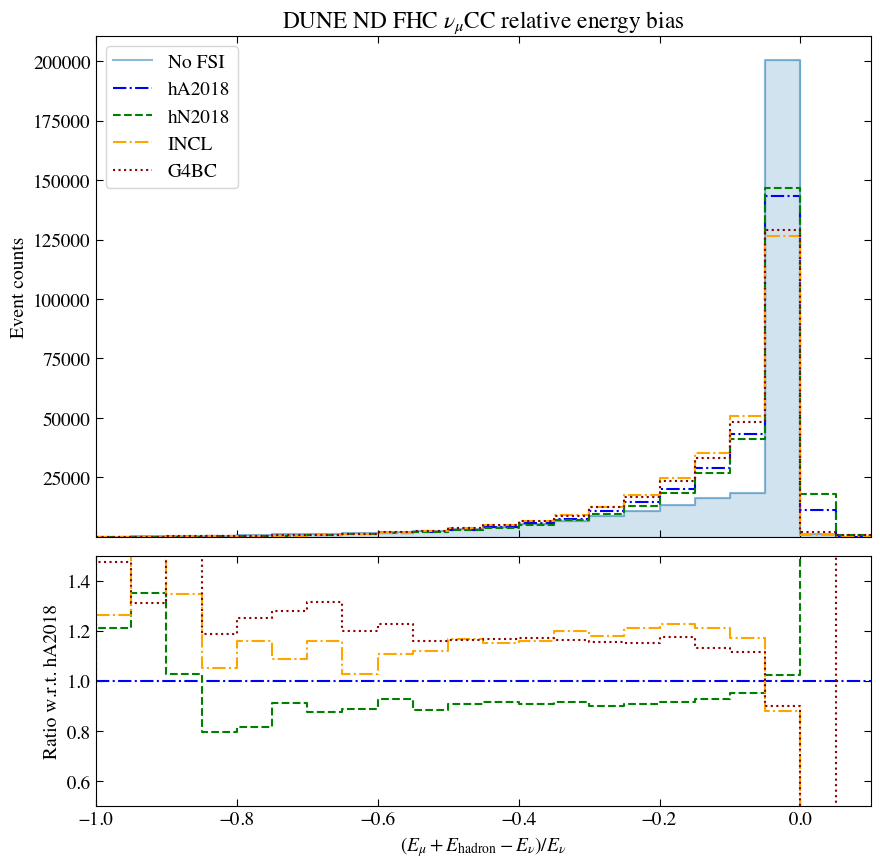

#events: 268183 273739 274314 272503 268269


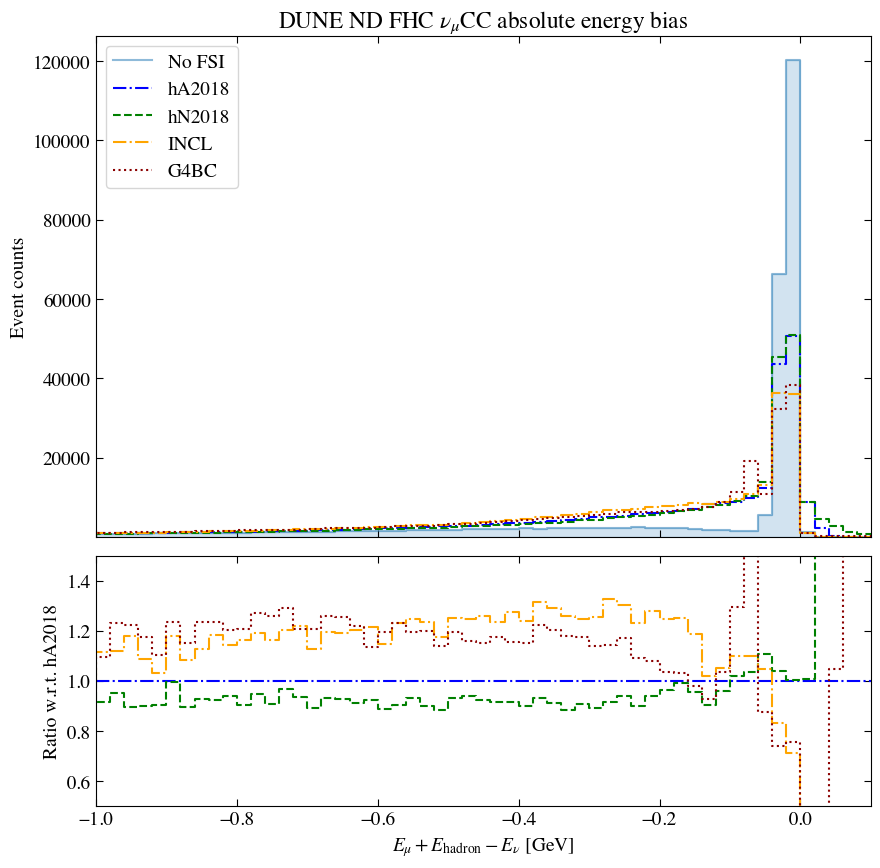

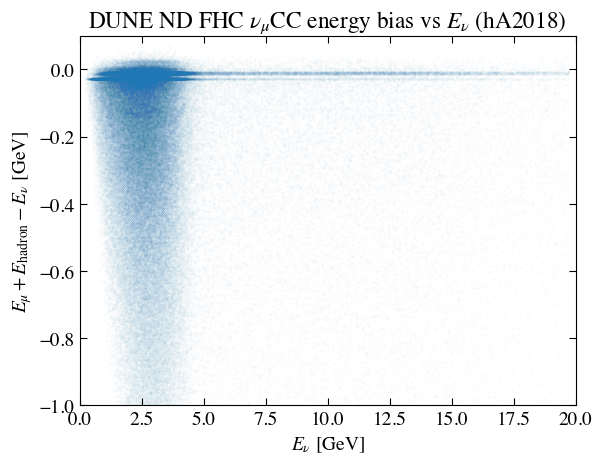

In [44]:
# relative energy bias
xx = np.linspace(-1, 0.1, 22+1)
yyi, _ = np.histogram(Ebiasi_numu_hA18/vars_numu_hA18["Ev"], bins=xx); yyi = np.concatenate([[0],yyi])
yyf_hA18, _ = np.histogram(Ebiasf_numu_hA18/vars_numu_hA18["Ev"], bins=xx); yyf_hA18 = np.concatenate([[0],yyf_hA18])
yyf_hN18, _ = np.histogram(Ebiasf_numu_hN18/vars_numu_hN18["Ev"], bins=xx); yyf_hN18 = np.concatenate([[0],yyf_hN18])
yyf_INCL, _ = np.histogram(Ebiasf_numu_INCL/vars_numu_INCL["Ev"], bins=xx); yyf_INCL = np.concatenate([[0],yyf_INCL])
yyf_G4BC, _ = np.histogram(Ebiasf_numu_G4BC/vars_numu_G4BC["Ev"], bins=xx); yyf_G4BC = np.concatenate([[0],yyf_G4BC])
print("Check if all having the same #events:", np.sum(yyi), np.sum(yyf_hA18), np.sum(yyf_hN18), np.sum(yyf_INCL), np.sum(yyf_G4BC))

fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1], 'hspace': 0.05})

axes[0].step(xx, yyi, label="No FSI", alpha=0.5, color='tab:blue')
axes[0].fill_between(xx, yyi, step="pre", alpha=0.2, color='tab:blue')
axes[0].step(xx, yyf_hA18, "-.", label="hA2018", color='blue')
axes[0].step(xx, yyf_hN18, "--", label="hN2018", color='green')
axes[0].step(xx, yyf_INCL, "-.", label="INCL", color='orange')
axes[0].step(xx, yyf_G4BC, ":", label="G4BC", color='darkred')
axes[0].legend()
axes[0].set_ylabel("Event counts")
axes[0].set_title(r"DUNE ND FHC $\nu_\mu$CC relative energy bias")
#axes[0].set_yscale('log')
axes[0].set_ylim([0.6, None])
axes[0].set_xlim([-1, 0.1])

axes[1].step(xx, safe_divide(yyf_hA18, yyf_hA18), "-.", label="hA2018", color='blue')
axes[1].step(xx, safe_divide(yyf_hN18, yyf_hA18), "--", label="hN2018", color='green')
axes[1].step(xx, safe_divide(yyf_INCL, yyf_hA18), "-.", label="INCL", color='orange')
axes[1].step(xx, safe_divide(yyf_G4BC, yyf_hA18), ":", label="G4BC", color='darkred')
axes[1].set_xlabel(r"$(E_\mu+E_{\rm hadron}-E_\nu)/E_\nu$")
axes[1].set_ylabel("Ratio w.r.t. hA2018")
axes[1].set_xlim([-1, 0.1])
axes[1].set_ylim([0.5, 1.5])
plt.savefig("FSIplots/relaEvbias_Ehad_FSI_numu.png")
plt.show()


# absolute energy bias
xlow, xupp = -1, 0.1
xx = np.linspace(xlow, xupp, 55+1)
yyi, _ = np.histogram(Ebiasi_numu_hA18, bins=xx); yyi = np.concatenate([[0],yyi])
yyf_hA18, _ = np.histogram(Ebiasf_numu_hA18, bins=xx); yyf_hA18 = np.concatenate([[0],yyf_hA18])
yyf_hN18, _ = np.histogram(Ebiasf_numu_hN18, bins=xx); yyf_hN18 = np.concatenate([[0],yyf_hN18])
yyf_INCL, _ = np.histogram(Ebiasf_numu_INCL, bins=xx); yyf_INCL = np.concatenate([[0],yyf_INCL])
yyf_G4BC, _ = np.histogram(Ebiasf_numu_G4BC, bins=xx); yyf_G4BC = np.concatenate([[0],yyf_G4BC])
print("#events:", np.sum(yyi), np.sum(yyf_hA18), np.sum(yyf_hN18), np.sum(yyf_INCL), np.sum(yyf_G4BC))

fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1], 'hspace': 0.05})

axes[0].step(xx, yyi, label="No FSI", alpha=0.5, color='tab:blue')
axes[0].fill_between(xx, yyi, step="pre", alpha=0.2, color='tab:blue')
axes[0].step(xx, yyf_hA18, "-.", label="hA2018", color='blue')
axes[0].step(xx, yyf_hN18, "--", label="hN2018", color='green')
axes[0].step(xx, yyf_INCL, "-.", label="INCL", color='orange')
axes[0].step(xx, yyf_G4BC, ":", label="G4BC", color='darkred')
axes[0].legend()
axes[0].set_ylabel("Event counts")
axes[0].set_title(r"DUNE ND FHC $\nu_\mu$CC absolute energy bias")
#axes[0].set_yscale('log')
axes[0].set_ylim([0.6, None])
axes[0].set_xlim([xlow, xupp])

axes[1].step(xx, safe_divide(yyf_hA18, yyf_hA18), "-.", label="hA2018", color='blue')
axes[1].step(xx, safe_divide(yyf_hN18, yyf_hA18), "--", label="hN2018", color='green')
axes[1].step(xx, safe_divide(yyf_INCL, yyf_hA18), "-.", label="INCL", color='orange')
axes[1].step(xx, safe_divide(yyf_G4BC, yyf_hA18), ":", label="G4BC", color='darkred')
axes[1].set_xlabel(r"$E_\mu+E_{\rm hadron}-E_\nu$ [GeV]")
axes[1].set_ylabel("Ratio w.r.t. hA2018")
axes[1].set_xlim([xlow, xupp])
axes[1].set_ylim([0.5, 1.5])
plt.savefig("FSIplots/absoEvbias_Ehad_FSI_numu.png")
plt.show()


# energy bias vs neutrino energy
plt.scatter(vars_numu_hA18["Ev"], Ebiasf_numu_hA18, alpha=0.1, s=0.01)
plt.xlabel(r"$E_\nu$ [GeV]")
plt.ylabel(r"$E_\mu+E_{\rm hadron}-E_\nu$ [GeV]")
plt.xlim(0, 20)
plt.ylim(xlow, xupp)
plt.title(r"DUNE ND FHC $\nu_\mu$CC energy bias vs $E_\nu$ (hA2018)")
plt.savefig("FSIplots/2DEvbias_Ehad_hA18_numu.png")
plt.show()


Check if all having the same #events: 10.0 10.0 9.999999999999998 10.0 10.000000000000002


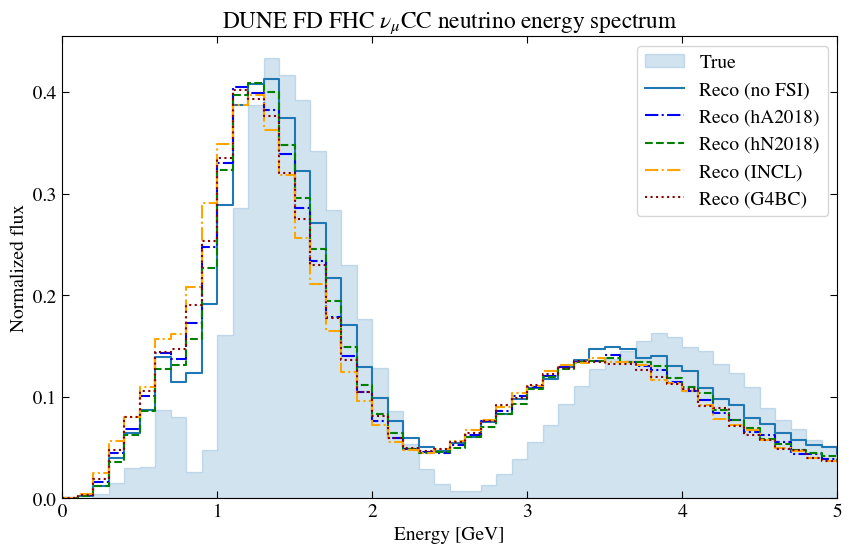

In [38]:
# oscillation
fluxND2FD_numu_1300 = FDosc_Flux_FHCnumu_1300*1e7/ND_Flux_FHCnumu
ND2FD_numu_wei_hA18 = np.interp(vars_numu_hA18["Ev"], FDosc_Ev, fluxND2FD_numu_1300)
ND2FD_numu_wei_hN18 = np.interp(vars_numu_hN18["Ev"], FDosc_Ev, fluxND2FD_numu_1300)
ND2FD_numu_wei_INCL = np.interp(vars_numu_INCL["Ev"], FDosc_Ev, fluxND2FD_numu_1300)
ND2FD_numu_wei_G4BC = np.interp(vars_numu_G4BC["Ev"], FDosc_Ev, fluxND2FD_numu_1300)
#plt.hist(vars_numu_hA18["Ev"], bins=100, alpha=0.3)
#plt.hist(vars_numu_hA18["Ev"], bins=100, alpha=0.3, weights=ND2FD_numu_wei_hA18)
#plt.show()

xx = np.arange(0, 20+0.1, 0.1)
yyt, _ = np.histogram(vars_numu_hA18["Ev"], bins=xx, weights=ND2FD_numu_wei_hA18, density=True); yyt = np.concatenate([[0],yyt])
yyi, _ = np.histogram(vars_numu_hA18["Ev"]+Ebiasi_numu_hA18, bins=xx, weights=ND2FD_numu_wei_hA18, density=True); yyi = np.concatenate([[0],yyi])
yyf_hA18, _ = np.histogram(vars_numu_hA18["Ev"]+Ebiasf_numu_hA18, bins=xx, weights=ND2FD_numu_wei_hA18, density=True); yyf_hA18 = np.concatenate([[0],yyf_hA18])
yyf_hN18, _ = np.histogram(vars_numu_hN18["Ev"]+Ebiasf_numu_hN18, bins=xx, weights=ND2FD_numu_wei_hN18, density=True); yyf_hN18 = np.concatenate([[0],yyf_hN18])
yyf_INCL, _ = np.histogram(vars_numu_INCL["Ev"]+Ebiasf_numu_INCL, bins=xx, weights=ND2FD_numu_wei_INCL, density=True); yyf_INCL = np.concatenate([[0],yyf_INCL])
yyf_G4BC, _ = np.histogram(vars_numu_G4BC["Ev"]+Ebiasf_numu_G4BC, bins=xx, weights=ND2FD_numu_wei_G4BC, density=True); yyf_G4BC = np.concatenate([[0],yyf_G4BC])
print("Check if all having the same #events:", np.sum(yyi), np.sum(yyf_hA18), np.sum(yyf_hN18), np.sum(yyf_INCL), np.sum(yyf_G4BC))

fig, ax = plt.subplots(figsize=(10, 6))
ax.fill_between(xx, yyt, step="pre", label="True", alpha=0.2, color='tab:blue')
ax.step(xx, yyi, label="Reco (no FSI)", alpha=1, color='tab:blue')
ax.step(xx, yyf_hA18, "-.", label="Reco (hA2018)", color='blue')
ax.step(xx, yyf_hN18, "--", label="Reco (hN2018)", color='green')
ax.step(xx, yyf_INCL, "-.", label="Reco (INCL)", color='orange')
ax.step(xx, yyf_G4BC, ":", label="Reco (G4BC)", color='darkred')
ax.legend()
ax.set_xlabel("Energy [GeV]")
ax.set_ylabel("Normalized flux")
ax.set_title(r"DUNE FD FHC $\nu_\mu$CC neutrino energy spectrum")
ax.set_ylim([0, None])
ax.set_xlim([0, 5])
#plt.savefig("FSIplots/FDoscNv_Eavail_FSI_numu.png")
plt.show()

Check if all having the same #events: 10.0 300000 10.0 10.0 10.000000000000002


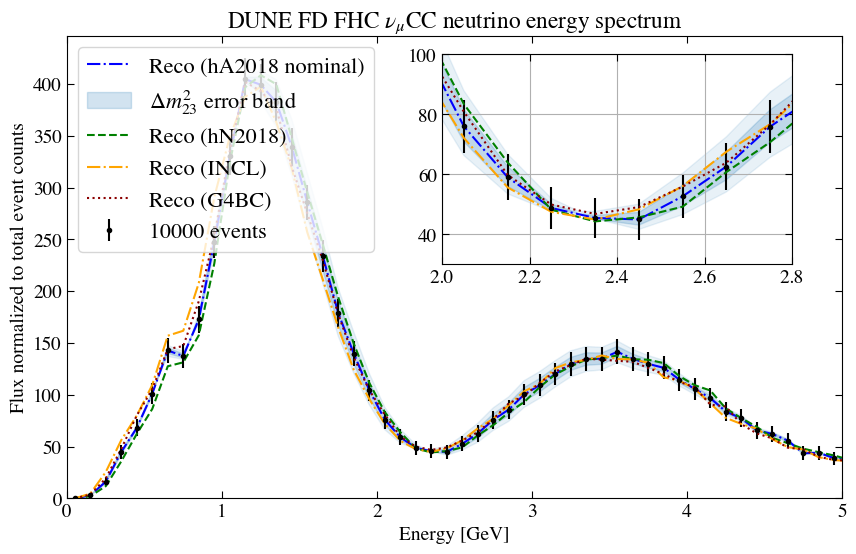

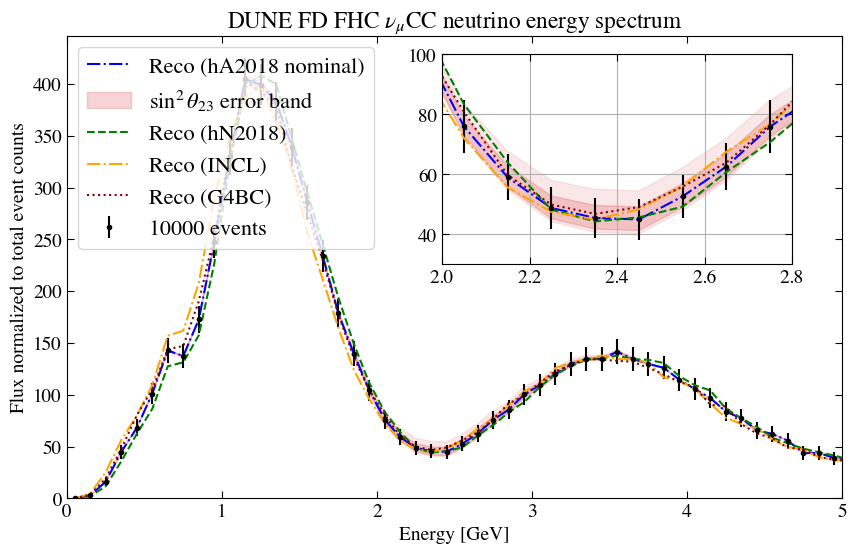

In [59]:
# oscillation
fluxND2FD_numu_m23p = FDosc_Flux_FHCnumu_m23p*1e7/ND_Flux_FHCnumu
fluxND2FD_numu_m23m = FDosc_Flux_FHCnumu_m23m*1e7/ND_Flux_FHCnumu
fluxND2FD_numu_m232p = FDosc_Flux_FHCnumu_m232p*1e7/ND_Flux_FHCnumu
fluxND2FD_numu_m232m = FDosc_Flux_FHCnumu_m232m*1e7/ND_Flux_FHCnumu
fluxND2FD_numu_t23p = FDosc_Flux_FHCnumu_t23p*1e7/ND_Flux_FHCnumu
fluxND2FD_numu_t23m = FDosc_Flux_FHCnumu_t23m*1e7/ND_Flux_FHCnumu
fluxND2FD_numu_t232p = FDosc_Flux_FHCnumu_t232p*1e7/ND_Flux_FHCnumu
fluxND2FD_numu_t232m = FDosc_Flux_FHCnumu_t232m*1e7/ND_Flux_FHCnumu

ND2FD_numu_wei_1300 = np.interp(vars_numu_hA18["Ev"], FDosc_Ev, fluxND2FD_numu_1300)
ND2FD_numu_wei_m23p = np.interp(vars_numu_hA18["Ev"], FDosc_Ev, fluxND2FD_numu_m23p)
ND2FD_numu_wei_m23m = np.interp(vars_numu_hA18["Ev"], FDosc_Ev, fluxND2FD_numu_m23m)
ND2FD_numu_wei_m232p = np.interp(vars_numu_hA18["Ev"], FDosc_Ev, fluxND2FD_numu_m232p)
ND2FD_numu_wei_m232m = np.interp(vars_numu_hA18["Ev"], FDosc_Ev, fluxND2FD_numu_m232m)
ND2FD_numu_wei_t23p = np.interp(vars_numu_hA18["Ev"], FDosc_Ev, fluxND2FD_numu_t23p)
ND2FD_numu_wei_t23m = np.interp(vars_numu_hA18["Ev"], FDosc_Ev, fluxND2FD_numu_t23m)
ND2FD_numu_wei_t232p = np.interp(vars_numu_hA18["Ev"], FDosc_Ev, fluxND2FD_numu_t232p)
ND2FD_numu_wei_t232m = np.interp(vars_numu_hA18["Ev"], FDosc_Ev, fluxND2FD_numu_t232m)

xx = np.arange(0, 20+0.1, 0.1)
yyi, _ = np.histogram(vars_numu_hA18["Ev"]+Ebiasi_numu_hA18, bins=xx, weights=ND2FD_numu_wei_hA18, density=True)
yyf_hN18, _ = np.histogram(vars_numu_hN18["Ev"]+Ebiasf_numu_hN18, bins=xx, weights=ND2FD_numu_wei_hN18, density=True);
yyf_INCL, _ = np.histogram(vars_numu_INCL["Ev"]+Ebiasf_numu_INCL, bins=xx, weights=ND2FD_numu_wei_INCL, density=True);
yyf_G4BC, _ = np.histogram(vars_numu_G4BC["Ev"]+Ebiasf_numu_G4BC, bins=xx, weights=ND2FD_numu_wei_G4BC, density=True);
yyf_1300, _ = np.histogram(vars_numu_hA18["Ev"]+Ebiasf_numu_hA18, bins=xx, weights=ND2FD_numu_wei_1300, density=True); #yyf_1300 = np.concatenate([[0],yyf_1300])
yyf_m23p, _ = np.histogram(vars_numu_hA18["Ev"]+Ebiasf_numu_hA18, bins=xx, weights=ND2FD_numu_wei_m23p, density=True); #yyf_m23p = np.concatenate([[0],yyf_m23p])
yyf_m23m, _ = np.histogram(vars_numu_hA18["Ev"]+Ebiasf_numu_hA18, bins=xx, weights=ND2FD_numu_wei_m23m, density=True); #yyf_m23m = np.concatenate([[0],yyf_m23m])
yyf_m232p, _ = np.histogram(vars_numu_hA18["Ev"]+Ebiasf_numu_hA18, bins=xx, weights=ND2FD_numu_wei_m232p, density=True); #yyf_m232p = np.concatenate([[0],yyf_m232p])
yyf_m232m, _ = np.histogram(vars_numu_hA18["Ev"]+Ebiasf_numu_hA18, bins=xx, weights=ND2FD_numu_wei_m232m, density=True); #yyf_m232m = np.concatenate([[0],yyf_m232m])
yyf_t23p, _ = np.histogram(vars_numu_hA18["Ev"]+Ebiasf_numu_hA18, bins=xx, weights=ND2FD_numu_wei_t23p, density=True); #yyf_t23p = np.concatenate([[0],yyf_t23p])
yyf_t23m, _ = np.histogram(vars_numu_hA18["Ev"]+Ebiasf_numu_hA18, bins=xx, weights=ND2FD_numu_wei_t23m, density=True); #yyf_t23m = np.concatenate([[0],yyf_t23m])
yyf_t232p, _ = np.histogram(vars_numu_hA18["Ev"]+Ebiasf_numu_hA18, bins=xx, weights=ND2FD_numu_wei_t232p, density=True); #yyf_t232p = np.concatenate([[0],yyf_t232p])
yyf_t232m, _ = np.histogram(vars_numu_hA18["Ev"]+Ebiasf_numu_hA18, bins=xx, weights=ND2FD_numu_wei_t232m, density=True); #yyf_t232m = np.concatenate([[0],yyf_t232m])
print("Check if all having the same #events:", np.sum(yyi), np.sum(yyf_hA18), np.sum(yyf_hN18), np.sum(yyf_INCL), np.sum(yyf_G4BC))

Nv = 10000 # estimated total event counts
scale = Nv/np.sum(yyf_1300)
xx = (xx[1:]+xx[:-1])/2

### Δm^2_{23}
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(xx, scale*yyf_1300, "-.", label="Reco (hA2018 nominal)", alpha=1, color='blue')
ax.errorbar(xx, scale*yyf_1300, np.sqrt(scale*yyf_1300), fmt="k.", label=f"{Nv} events")
ax.fill_between(xx, scale*yyf_m23m, scale*yyf_m23p, label=r"$\Delta m^2_{23}$ error band", alpha=0.2, color='tab:blue')
ax.fill_between(xx, scale*yyf_m232m, scale*yyf_m232p, alpha=0.1, color='tab:blue')
#ax.plot(xx, scale*yyi, label="Reco (no FSI)", alpha=1, color='tab:blue')
ax.plot(xx, scale*yyf_hN18, "--", label="Reco (hN2018)", color='green')
ax.plot(xx, scale*yyf_INCL, "-.", label="Reco (INCL)", color='orange')
ax.plot(xx, scale*yyf_G4BC, ":", label="Reco (G4BC)", color='darkred')
ax.legend(loc="upper left", fontsize=16)
ax.set_xlabel("Energy [GeV]")
ax.set_ylabel("Flux normalized to total event counts")
ax.set_title(r"DUNE FD FHC $\nu_\mu$CC neutrino energy spectrum")
ax.set_ylim([0, None])
ax.set_xlim([0, 5])

ax_inset = fig.add_axes([0.5, 0.5, 0.35, 0.35])  # Adjust these values as needed
# Plot the same data on the inset axes
ax_inset.plot(xx, scale*yyf_1300, "-.", label="Reco (hA2018 nominal)", alpha=1, color='blue')
ax_inset.fill_between(xx, scale*yyf_m23m, scale*yyf_m23p, label=r"$\Delta m^2_{23}$ error band", alpha=0.2, color='tab:blue')
ax_inset.fill_between(xx, scale*yyf_m232m, scale*yyf_m232p, alpha=0.1, color='tab:blue')
ax_inset.errorbar(xx, scale*yyf_1300, np.sqrt(scale*yyf_1300), fmt="k.", label=f"{Nv} events")
#ax_inset.plot(xx, scale*yyi, label="Reco (no FSI)", alpha=1, color='tab:blue')
ax_inset.plot(xx, scale*yyf_hN18, "--", label="Reco (hN2018)", color='green')
ax_inset.plot(xx, scale*yyf_INCL, "-.", label="Reco (INCL)", color='orange')
ax_inset.plot(xx, scale*yyf_G4BC, ":", label="Reco (G4BC)", color='darkred')
ax_inset.set_ylim([0.03*scale, 0.1*scale])
ax_inset.set_xlim([2, 2.8])
ax_inset.grid(True)
plt.savefig("FSIplots/FDoscNv_Eavail_FSI_numu_m23.png")
plt.show()

### sin^2 θ_{23}
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(xx, scale*yyf_1300, "-.", label="Reco (hA2018 nominal)", alpha=1, color='blue')
ax.errorbar(xx, scale*yyf_1300, np.sqrt(scale*yyf_1300), fmt="k.", label=f"{Nv} events")
ax.fill_between(xx, scale*yyf_t23m, scale*yyf_t23p, label=r"$\sin^2 \theta_{23}$ error band", alpha=0.2, color='tab:red')
ax.fill_between(xx, scale*yyf_t232m, scale*yyf_t232p, alpha=0.1, color='tab:red')
#ax.plot(xx, scale*yyi, label="Reco (no FSI)", alpha=1, color='tab:blue')
ax.plot(xx, scale*yyf_hN18, "--", label="Reco (hN2018)", color='green')
ax.plot(xx, scale*yyf_INCL, "-.", label="Reco (INCL)", color='orange')
ax.plot(xx, scale*yyf_G4BC, ":", label="Reco (G4BC)", color='darkred')
ax.legend(loc="upper left", fontsize=16)
ax.set_xlabel("Energy [GeV]")
ax.set_ylabel("Flux normalized to total event counts")
ax.set_title(r"DUNE FD FHC $\nu_\mu$CC neutrino energy spectrum")
ax.set_ylim([0, None])
ax.set_xlim([0, 5])

ax_inset = fig.add_axes([0.5, 0.5, 0.35, 0.35])  # Adjust these values as needed
# Plot the same data on the inset axes
ax_inset.plot(xx, scale*yyf_1300, "-.", label="Reco (hA2018 nominal)", alpha=1, color='blue')
ax_inset.errorbar(xx, scale*yyf_1300, np.sqrt(scale*yyf_1300), fmt="k.", label=f"{Nv} events")
ax_inset.fill_between(xx, scale*yyf_t23m, scale*yyf_t23p, label=r"$\sin^2 \theta_{23}$ error band", alpha=0.2, color='tab:red')
ax_inset.fill_between(xx, scale*yyf_t232m, scale*yyf_t232p, alpha=0.1, color='tab:red')
#ax_inset.plot(xx, scale*yyi, label="Reco (no FSI)", alpha=1, color='tab:blue')
ax_inset.plot(xx, scale*yyf_hN18, "--", label="Reco (hN2018)", color='green')
ax_inset.plot(xx, scale*yyf_INCL, "-.", label="Reco (INCL)", color='orange')
ax_inset.plot(xx, scale*yyf_G4BC, ":", label="Reco (G4BC)", color='darkred')
ax_inset.set_ylim([0.03*scale, 0.1*scale])
ax_inset.set_xlim([2, 2.8])
ax_inset.grid(True)
plt.savefig("FSIplots/FDoscNv_Eavail_FSI_numu_t23.png")
plt.show()


### numubar oscillation

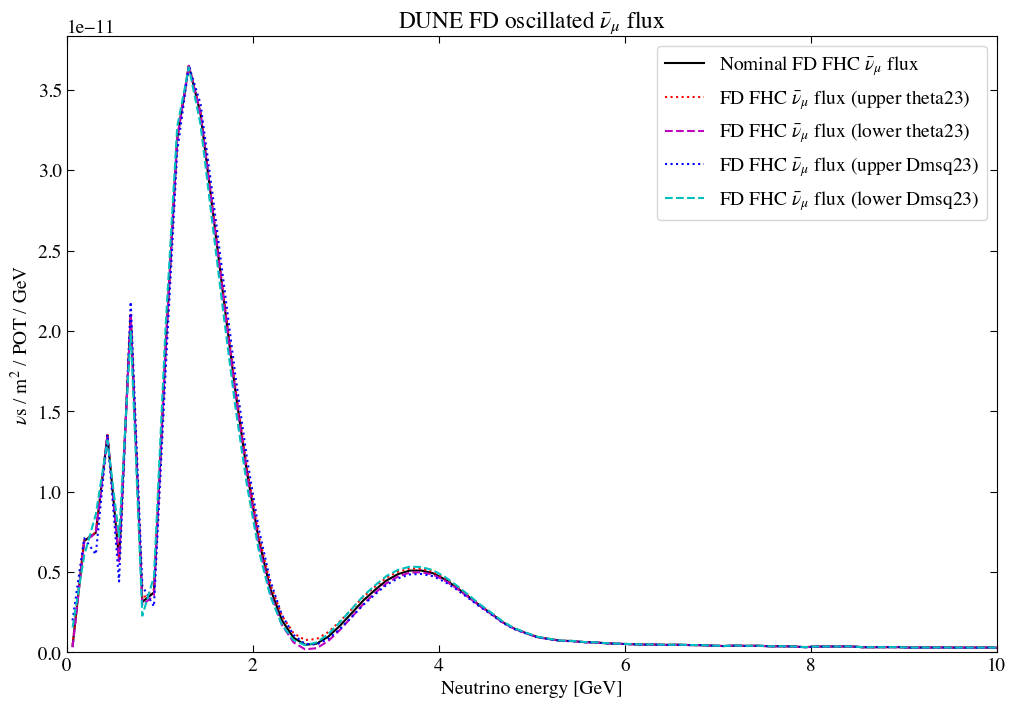

In [9]:
FDosc_Flux_FHCnumub_1300 = np.array([4.01485e-13,6.93591e-12,7.44494e-12,1.35086e-11,5.7469e-12,2.09644e-11,3.13892e-12,3.7256e-12,1.88492e-11,3.19689e-11,3.64935e-11,3.35389e-11,2.78027e-11,2.19667e-11,1.62671e-11,1.12254e-11,7.05358e-12,3.98222e-12,2.00924e-12,9.13803e-13,4.73394e-13,5.44775e-13,9.82795e-13,1.65994e-12,2.43276e-12,3.22028e-12,3.87551e-12,4.47096e-12,4.86902e-12,5.08696e-12,5.09421e-12,4.92448e-12,4.55225e-12,4.05605e-12,3.50377e-12,2.93252e-12,2.42339e-12,1.87763e-12,1.47703e-12,1.20219e-12,9.48676e-13,8.31286e-13,7.21801e-13,7.04946e-13,6.37536e-13,6.17405e-13,5.60706e-13,5.37217e-13,5.1579e-13,4.85513e-13,4.89043e-13,4.6518e-13,4.74947e-13,4.56832e-13,4.4862e-13,4.21327e-13,3.93187e-13,4.20465e-13,4.01926e-13,4.11477e-13,3.76031e-13,3.80334e-13,3.66038e-13,3.24039e-13,3.60509e-13,3.63566e-13,3.66502e-13,3.69323e-13,3.19388e-13,3.21627e-13,3.23781e-13,3.25855e-13,2.97858e-13,2.99605e-13,3.01289e-13,3.02913e-13,2.94454e-13,2.95915e-13,2.97325e-13,2.98687e-13,2.65433e-13,2.66557e-13,2.67643e-13,2.68694e-13,2.51499e-13,2.52415e-13,2.53303e-13,2.54162e-13,2.37681e-13,2.38432e-13,2.3916e-13,2.39865e-13,2.4401e-13,2.44683e-13,2.45336e-13,2.4597e-13,2.05688e-13,2.06186e-13,2.0667e-13,2.07141e-13,2.06e-13,2.0644e-13,2.06869e-13,2.07286e-13,1.8057e-13,1.80913e-13,1.81246e-13,1.81571e-13,1.73915e-13,1.7421e-13,1.74497e-13,1.74776e-13,1.68114e-13,1.68369e-13,1.68617e-13,1.6886e-13,1.60022e-13,1.6024e-13,1.60453e-13,1.60661e-13,1.43013e-13,1.43189e-13,1.43361e-13,1.43528e-13,1.27858e-13,1.28001e-13,1.2814e-13,1.28276e-13,1.13897e-13,1.14013e-13,1.14125e-13,1.14236e-13,9.82239e-14,9.83146e-14,9.84032e-14,9.849e-14,8.68823e-14,8.69556e-14,8.70273e-14,8.70975e-14,8.31334e-14,8.31976e-14,8.32606e-14,8.33222e-14,7.4367e-14,7.44198e-14,7.44715e-14,7.45222e-14,5.79071e-14,5.79449e-14,5.7982e-14,5.80184e-14,5.77019e-14,5.77367e-14,5.77708e-14,5.78043e-14,5.10231e-14,5.10516e-14,5.10795e-14,5.11069e-14,4.14723e-14,4.14937e-14,4.15147e-14,4.15354e-14,4.15557e-14,4.15757e-14,4.15952e-14,4.16145e-14,4.16334e-14,4.1652e-14,4.16702e-14,4.16882e-14,4.17058e-14,4.17232e-14,4.17402e-14,4.1757e-14,3.42705e-14,3.42838e-14,3.42969e-14,3.43097e-14,3.43224e-14,3.43348e-14,3.43471e-14,3.43591e-14,3.4371e-14,3.43827e-14,3.43942e-14,3.44055e-14,3.44166e-14,3.44275e-14,3.44383e-14,3.44489e-14,2.60693e-14,2.60771e-14,2.60848e-14,2.60923e-14,2.60998e-14,2.61071e-14,2.61143e-14,2.61214e-14,2.61284e-14,2.61353e-14,2.61422e-14,2.61489e-14,2.61555e-14,2.6162e-14,2.61684e-14,2.61747e-14,1.94172e-14,1.94218e-14,1.94263e-14,1.94307e-14,1.94351e-14,1.94394e-14,1.94437e-14,1.94479e-14,1.9452e-14,1.94561e-14,1.94601e-14,1.94641e-14,1.9468e-14,1.94719e-14,1.94757e-14,1.94794e-14,1.63673e-14,1.63704e-14,1.63734e-14,1.63764e-14,1.63794e-14,1.63823e-14,1.63852e-14,1.6388e-14,1.63908e-14,1.63936e-14,1.63964e-14,1.63991e-14,1.64017e-14,1.64044e-14,1.6407e-14,1.64095e-14,1.13104e-14,1.13121e-14,1.13138e-14,1.13155e-14,1.13172e-14,1.13189e-14,1.13205e-14,1.13221e-14,1.13237e-14,1.13252e-14,1.13268e-14,1.13283e-14,1.13298e-14,1.13313e-14,1.13328e-14,1.13343e-14,8.56162e-15,8.5627e-15,8.56376e-15,8.56482e-15,8.56586e-15,8.56689e-15,8.56791e-15,8.56892e-15,8.56991e-15,8.5709e-15,8.57187e-15,8.57283e-15,8.57379e-15,8.57473e-15,8.57566e-15,8.57658e-15,5.33507e-15,5.33563e-15,5.33618e-15,5.33673e-15,5.33728e-15,5.33781e-15,5.33834e-15,5.33887e-15,5.33939e-15,5.3399e-15,5.34041e-15,5.34092e-15,5.34141e-15,5.34191e-15,5.3424e-15,5.34288e-15,4.10374e-15,4.10411e-15,4.10447e-15,4.10482e-15,4.10518e-15,4.10552e-15,4.10587e-15,4.10621e-15,4.10655e-15,4.10688e-15,4.10722e-15,4.10754e-15,4.10787e-15,4.10819e-15,4.10851e-15,4.10882e-15,3.29527e-15,3.29552e-15,3.29577e-15,3.29601e-15,3.29625e-15,3.29649e-15,3.29673e-15,3.29696e-15,3.29719e-15,3.29742e-15,3.29765e-15,3.29788e-15,3.2981e-15,3.29832e-15,3.29854e-15,3.29876e-15,2.73536e-15,2.73554e-15,2.73571e-15,2.73589e-15,2.73606e-15,2.73623e-15,2.7364e-15,2.73656e-15,2.73673e-15,2.73689e-15,2.73706e-15,2.73722e-15,2.73738e-15,2.73753e-15,2.73769e-15,2.73785e-15,3.31487e-15,3.31506e-15,3.31524e-15,3.31542e-15,3.3156e-15,3.31578e-15,3.31596e-15,3.31613e-15,3.31631e-15,3.31648e-15,3.31665e-15,3.31682e-15,3.31699e-15,3.31715e-15,3.31732e-15,3.31748e-15,1.29834e-15,1.2984e-15,1.29846e-15,1.29852e-15,1.29858e-15,1.29865e-15,1.29871e-15,1.29877e-15,1.29882e-15,1.29888e-15,1.29894e-15,1.299e-15,1.29906e-15,1.29911e-15,1.29917e-15,1.29923e-15,1.03623e-15,1.03627e-15,1.03632e-15,1.03636e-15,1.0364e-15,1.03644e-15,1.03649e-15,1.03653e-15,1.03657e-15,1.03661e-15,1.03665e-15,1.03669e-15,1.03673e-15,1.03677e-15,1.03681e-15,1.03685e-15,3.60962e-16,3.60975e-16,3.60989e-16,3.61002e-16,3.61015e-16,3.61028e-16,3.61041e-16,3.61054e-16,3.61067e-16,3.6108e-16,3.61092e-16,3.61105e-16,3.61117e-16,3.61129e-16,3.61142e-16,3.61154e-16,4.02465e-16,4.02478e-16,4.02491e-16,4.02504e-16,4.02517e-16,4.0253e-16,4.02543e-16,4.02556e-16,4.02569e-16,4.02581e-16,4.02594e-16,4.02606e-16,4.02618e-16,4.0263e-16,4.02643e-16,4.02655e-16,5.77714e-16,5.77731e-16,5.77748e-16,5.77765e-16,5.77781e-16,5.77798e-16,5.77814e-16,5.7783e-16,5.77847e-16,5.77863e-16,5.77879e-16,5.77894e-16,5.7791e-16,5.77926e-16,5.77941e-16,5.77957e-16,2.0726e-16,2.07266e-16,2.07271e-16,2.07276e-16,2.07282e-16,2.07287e-16,2.07292e-16,2.07298e-16,2.07303e-16,2.07308e-16,2.07313e-16,2.07318e-16,2.07323e-16,2.07328e-16,2.07333e-16,2.07338e-16,3.24793e-16,3.248e-16,3.24808e-16,3.24815e-16,3.24823e-16,3.2483e-16,3.24838e-16,3.24845e-16,3.24852e-16,3.2486e-16,3.24867e-16,3.24874e-16,3.24881e-16,3.24888e-16,3.24895e-16,3.24902e-16,1.20913e-16,1.20915e-16,1.20918e-16,1.20921e-16,1.20923e-16,1.20926e-16,1.20928e-16,1.2093e-16,1.20933e-16,1.20935e-16,1.20938e-16,1.2094e-16,1.20943e-16,1.20945e-16,1.20947e-16,1.2095e-16,1.27073e-16,1.27076e-16,1.27078e-16,1.2708e-16,1.27083e-16,1.27085e-16,1.27087e-16,1.2709e-16,1.27092e-16,1.27094e-16,1.27097e-16,1.27099e-16,1.27101e-16,1.27104e-16,1.27106e-16,1.27108e-16,6.71512e-17,6.71524e-17,6.71535e-17,6.71547e-17,6.71558e-17,6.71569e-17,6.71581e-17,6.71592e-17,6.71603e-17,6.71614e-17,6.71625e-17,6.71636e-17,6.71647e-17,6.71658e-17,6.71669e-17,6.7168e-17,7.29383e-17,7.29395e-17,7.29406e-17,7.29418e-17,7.29429e-17,7.2944e-17,7.29451e-17,7.29463e-17,7.29474e-17,7.29485e-17,7.29496e-17,7.29506e-17,7.29517e-17,7.29528e-17,7.29539e-17,7.29549e-17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
FDosc_Flux_FHCnumub_t23p = np.array([4.70968e-13,6.98753e-12,7.46624e-12,1.3525e-11,5.834e-12,2.10075e-11,3.34251e-12,3.90508e-12,1.8922e-11,3.19747e-11,3.64945e-11,3.35759e-11,2.7891e-11,2.21106e-11,1.64624e-11,1.1463e-11,7.31912e-12,4.26155e-12,2.29516e-12,1.20389e-12,7.62572e-13,8.33965e-13,1.26353e-12,1.92656e-12,2.67908e-12,3.44514e-12,4.07463e-12,4.64816e-12,5.02326e-12,5.21933e-12,5.20548e-12,5.01635e-12,4.62584e-12,4.11354e-12,3.54777e-12,2.96543e-12,2.44786e-12,1.89481e-12,1.48935e-12,1.21138e-12,9.55347e-13,8.36688e-13,7.26151e-13,7.089e-13,6.40873e-13,6.2043e-13,5.63284e-13,5.3954e-13,5.17893e-13,4.87383e-13,4.90825e-13,4.66787e-13,4.76506e-13,4.58257e-13,4.49953e-13,4.22522e-13,3.94251e-13,4.21554e-13,4.02922e-13,4.12454e-13,3.76887e-13,3.81165e-13,3.66807e-13,3.24694e-13,3.6121e-13,3.64247e-13,3.67164e-13,3.69966e-13,3.19926e-13,3.2215e-13,3.24291e-13,3.26351e-13,2.98296e-13,3.00032e-13,3.01706e-13,3.03319e-13,2.94837e-13,2.96289e-13,2.9769e-13,2.99042e-13,2.6574e-13,2.66857e-13,2.67936e-13,2.6898e-13,2.5176e-13,2.52671e-13,2.53552e-13,2.54406e-13,2.37903e-13,2.38649e-13,2.39373e-13,2.40074e-13,2.44217e-13,2.44886e-13,2.45535e-13,2.46164e-13,2.05847e-13,2.06342e-13,2.06823e-13,2.0729e-13,2.06145e-13,2.06583e-13,2.07009e-13,2.07423e-13,1.80687e-13,1.81028e-13,1.81359e-13,1.81682e-13,1.7402e-13,1.74312e-13,1.74597e-13,1.74875e-13,1.68207e-13,1.6846e-13,1.68707e-13,1.68948e-13,1.60104e-13,1.60321e-13,1.60533e-13,1.60739e-13,1.43081e-13,1.43256e-13,1.43427e-13,1.43594e-13,1.27915e-13,1.28057e-13,1.28195e-13,1.2833e-13,1.13945e-13,1.1406e-13,1.14172e-13,1.14281e-13,9.82624e-14,9.83525e-14,9.84406e-14,9.85269e-14,8.69143e-14,8.69871e-14,8.70584e-14,8.71282e-14,8.31622e-14,8.32261e-14,8.32886e-14,8.33498e-14,7.43913e-14,7.44438e-14,7.44952e-14,7.45456e-14,5.7925e-14,5.79626e-14,5.79994e-14,5.80356e-14,5.77188e-14,5.77533e-14,5.77873e-14,5.78206e-14,5.10372e-14,5.10655e-14,5.10933e-14,5.11205e-14,4.14832e-14,4.15045e-14,4.15254e-14,4.15459e-14,4.15661e-14,4.15859e-14,4.16054e-14,4.16245e-14,4.16433e-14,4.16618e-14,4.16799e-14,4.16977e-14,4.17153e-14,4.17325e-14,4.17495e-14,4.17661e-14,3.42779e-14,3.42911e-14,3.43041e-14,3.43169e-14,3.43295e-14,3.43418e-14,3.4354e-14,3.4366e-14,3.43778e-14,3.43894e-14,3.44008e-14,3.4412e-14,3.44231e-14,3.4434e-14,3.44447e-14,3.44552e-14,2.6074e-14,2.60818e-14,2.60894e-14,2.60969e-14,2.61043e-14,2.61116e-14,2.61187e-14,2.61258e-14,2.61328e-14,2.61396e-14,2.61464e-14,2.61531e-14,2.61596e-14,2.61661e-14,2.61725e-14,2.61788e-14,1.94202e-14,1.94247e-14,1.94292e-14,1.94336e-14,1.9438e-14,1.94423e-14,1.94465e-14,1.94507e-14,1.94548e-14,1.94588e-14,1.94628e-14,1.94668e-14,1.94707e-14,1.94745e-14,1.94783e-14,1.9482e-14,1.63695e-14,1.63725e-14,1.63755e-14,1.63785e-14,1.63815e-14,1.63844e-14,1.63872e-14,1.63901e-14,1.63929e-14,1.63956e-14,1.63983e-14,1.6401e-14,1.64037e-14,1.64063e-14,1.64089e-14,1.64114e-14,1.13117e-14,1.13134e-14,1.13151e-14,1.13168e-14,1.13185e-14,1.13201e-14,1.13217e-14,1.13233e-14,1.13249e-14,1.13264e-14,1.1328e-14,1.13295e-14,1.1331e-14,1.13325e-14,1.1334e-14,1.13354e-14,8.56248e-15,8.56355e-15,8.56461e-15,8.56566e-15,8.56669e-15,8.56772e-15,8.56873e-15,8.56973e-15,8.57072e-15,8.5717e-15,8.57267e-15,8.57363e-15,8.57457e-15,8.57551e-15,8.57643e-15,8.57735e-15,5.33554e-15,5.3361e-15,5.33665e-15,5.3372e-15,5.33774e-15,5.33827e-15,5.3388e-15,5.33932e-15,5.33984e-15,5.34035e-15,5.34085e-15,5.34135e-15,5.34185e-15,5.34234e-15,5.34282e-15,5.3433e-15,4.10407e-15,4.10443e-15,4.10479e-15,4.10514e-15,4.10549e-15,4.10584e-15,4.10618e-15,4.10652e-15,4.10686e-15,4.10719e-15,4.10752e-15,4.10785e-15,4.10817e-15,4.10849e-15,4.10881e-15,4.10912e-15,3.29551e-15,3.29576e-15,3.296e-15,3.29624e-15,3.29648e-15,3.29672e-15,3.29695e-15,3.29719e-15,3.29742e-15,3.29764e-15,3.29787e-15,3.29809e-15,3.29832e-15,3.29854e-15,3.29875e-15,3.29897e-15,2.73554e-15,2.73571e-15,2.73589e-15,2.73606e-15,2.73623e-15,2.7364e-15,2.73657e-15,2.73673e-15,2.7369e-15,2.73706e-15,2.73722e-15,2.73738e-15,2.73754e-15,2.7377e-15,2.73785e-15,2.73801e-15,3.31506e-15,3.31525e-15,3.31543e-15,3.31561e-15,3.31579e-15,3.31597e-15,3.31614e-15,3.31632e-15,3.31649e-15,3.31666e-15,3.31683e-15,3.317e-15,3.31717e-15,3.31733e-15,3.3175e-15,3.31766e-15,1.2984e-15,1.29847e-15,1.29853e-15,1.29859e-15,1.29865e-15,1.29871e-15,1.29877e-15,1.29883e-15,1.29889e-15,1.29895e-15,1.29901e-15,1.29906e-15,1.29912e-15,1.29918e-15,1.29923e-15,1.29929e-15,1.03628e-15,1.03632e-15,1.03636e-15,1.03641e-15,1.03645e-15,1.03649e-15,1.03654e-15,1.03658e-15,1.03662e-15,1.03666e-15,1.0367e-15,1.03674e-15,1.03678e-15,1.03682e-15,1.03686e-15,1.0369e-15,3.60978e-16,3.60991e-16,3.61004e-16,3.61018e-16,3.61031e-16,3.61044e-16,3.61057e-16,3.61069e-16,3.61082e-16,3.61095e-16,3.61107e-16,3.6112e-16,3.61132e-16,3.61144e-16,3.61156e-16,3.61168e-16,4.02481e-16,4.02494e-16,4.02508e-16,4.02521e-16,4.02534e-16,4.02546e-16,4.02559e-16,4.02572e-16,4.02584e-16,4.02597e-16,4.02609e-16,4.02621e-16,4.02634e-16,4.02646e-16,4.02658e-16,4.0267e-16,5.77736e-16,5.77753e-16,5.77769e-16,5.77786e-16,5.77803e-16,5.77819e-16,5.77835e-16,5.77851e-16,5.77868e-16,5.77883e-16,5.77899e-16,5.77915e-16,5.77931e-16,5.77946e-16,5.77962e-16,5.77977e-16,2.07267e-16,2.07273e-16,2.07278e-16,2.07284e-16,2.07289e-16,2.07294e-16,2.07299e-16,2.07305e-16,2.0731e-16,2.07315e-16,2.0732e-16,2.07325e-16,2.0733e-16,2.07335e-16,2.0734e-16,2.07345e-16,3.24803e-16,3.24811e-16,3.24818e-16,3.24826e-16,3.24833e-16,3.24841e-16,3.24848e-16,3.24855e-16,3.24863e-16,3.2487e-16,3.24877e-16,3.24884e-16,3.24891e-16,3.24898e-16,3.24905e-16,3.24912e-16,1.20917e-16,1.20919e-16,1.20922e-16,1.20924e-16,1.20927e-16,1.20929e-16,1.20932e-16,1.20934e-16,1.20936e-16,1.20939e-16,1.20941e-16,1.20944e-16,1.20946e-16,1.20948e-16,1.20951e-16,1.20953e-16,1.27077e-16,1.27079e-16,1.27082e-16,1.27084e-16,1.27086e-16,1.27089e-16,1.27091e-16,1.27093e-16,1.27096e-16,1.27098e-16,1.271e-16,1.27102e-16,1.27105e-16,1.27107e-16,1.27109e-16,1.27111e-16,6.7153e-17,6.71541e-17,6.71553e-17,6.71564e-17,6.71576e-17,6.71587e-17,6.71598e-17,6.71609e-17,6.7162e-17,6.71632e-17,6.71642e-17,6.71653e-17,6.71664e-17,6.71675e-17,6.71686e-17,6.71696e-17,7.29402e-17,7.29413e-17,7.29424e-17,7.29436e-17,7.29447e-17,7.29458e-17,7.29469e-17,7.2948e-17,7.29491e-17,7.29502e-17,7.29513e-17,7.29524e-17,7.29535e-17,7.29545e-17,7.29556e-17,7.29566e-17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
FDosc_Flux_FHCnumub_t23m = np.array([3.14555e-13,6.86613e-12,7.42264e-12,1.34869e-11,5.66402e-12,2.09129e-11,2.92761e-12,3.55285e-12,1.87873e-11,3.19698e-11,3.64927e-11,3.34976e-11,2.77081e-11,2.18163e-11,1.60663e-11,1.09837e-11,6.78606e-12,3.70287e-12,1.72503e-12,6.26934e-13,1.88691e-13,2.61161e-13,7.08411e-13,1.40014e-12,2.1934e-12,3.0023e-12,3.68292e-12,4.29992e-12,4.72042e-12,4.95965e-12,4.98737e-12,4.83639e-12,4.48179e-12,4.00107e-12,3.46175e-12,2.90113e-12,2.40005e-12,1.86126e-12,1.4653e-12,1.19346e-12,9.42339e-13,8.26159e-13,7.17675e-13,7.012e-13,6.34375e-13,6.14542e-13,5.58267e-13,5.3502e-13,5.13803e-13,4.83747e-13,4.87361e-13,4.63664e-13,4.73478e-13,4.55488e-13,4.47364e-13,4.20203e-13,3.92185e-13,4.19442e-13,4.0099e-13,4.10559e-13,3.75226e-13,3.79553e-13,3.65315e-13,3.23424e-13,3.59851e-13,3.62926e-13,3.6588e-13,3.68719e-13,3.18884e-13,3.21137e-13,3.23304e-13,3.25391e-13,2.97447e-13,2.99205e-13,3.00899e-13,3.02533e-13,2.94096e-13,2.95566e-13,2.96984e-13,2.98354e-13,2.65145e-13,2.66276e-13,2.67369e-13,2.68426e-13,2.51255e-13,2.52177e-13,2.5307e-13,2.53934e-13,2.37473e-13,2.38229e-13,2.38961e-13,2.39671e-13,2.43817e-13,2.44494e-13,2.45151e-13,2.45788e-13,2.0554e-13,2.06041e-13,2.06528e-13,2.07001e-13,2.05864e-13,2.06307e-13,2.06738e-13,2.07157e-13,1.8046e-13,1.80805e-13,1.81141e-13,1.81468e-13,1.73818e-13,1.74115e-13,1.74403e-13,1.74684e-13,1.68027e-13,1.68283e-13,1.68533e-13,1.68777e-13,1.59945e-13,1.60165e-13,1.60379e-13,1.60588e-13,1.42949e-13,1.43126e-13,1.43299e-13,1.43468e-13,1.27805e-13,1.27948e-13,1.28088e-13,1.28225e-13,1.13853e-13,1.13969e-13,1.14083e-13,1.14193e-13,9.81881e-14,9.82793e-14,9.83685e-14,9.84558e-14,8.68525e-14,8.69262e-14,8.69984e-14,8.7069e-14,8.31066e-14,8.31712e-14,8.32345e-14,8.32965e-14,7.43444e-14,7.43975e-14,7.44495e-14,7.45005e-14,5.78905e-14,5.79285e-14,5.79659e-14,5.80025e-14,5.76862e-14,5.77212e-14,5.77556e-14,5.77893e-14,5.101e-14,5.10386e-14,5.10667e-14,5.10943e-14,4.14621e-14,4.14837e-14,4.15049e-14,4.15257e-14,4.15461e-14,4.15661e-14,4.15858e-14,4.16052e-14,4.16242e-14,4.16429e-14,4.16613e-14,4.16793e-14,4.16971e-14,4.17145e-14,4.17317e-14,4.17485e-14,3.42636e-14,3.4277e-14,3.42902e-14,3.43031e-14,3.43158e-14,3.43283e-14,3.43407e-14,3.43528e-14,3.43647e-14,3.43764e-14,3.4388e-14,3.43994e-14,3.44106e-14,3.44216e-14,3.44324e-14,3.44431e-14,2.60649e-14,2.60728e-14,2.60805e-14,2.60881e-14,2.60956e-14,2.61029e-14,2.61102e-14,2.61174e-14,2.61244e-14,2.61314e-14,2.61382e-14,2.61449e-14,2.61516e-14,2.61582e-14,2.61646e-14,2.6171e-14,1.94145e-14,1.94191e-14,1.94236e-14,1.94281e-14,1.94324e-14,1.94368e-14,1.94411e-14,1.94453e-14,1.94494e-14,1.94536e-14,1.94576e-14,1.94616e-14,1.94655e-14,1.94694e-14,1.94733e-14,1.9477e-14,1.63653e-14,1.63684e-14,1.63715e-14,1.63745e-14,1.63774e-14,1.63804e-14,1.63833e-14,1.63861e-14,1.6389e-14,1.63918e-14,1.63945e-14,1.63972e-14,1.63999e-14,1.64026e-14,1.64052e-14,1.64078e-14,1.13092e-14,1.13109e-14,1.13127e-14,1.13144e-14,1.1316e-14,1.13177e-14,1.13193e-14,1.1321e-14,1.13225e-14,1.13241e-14,1.13257e-14,1.13272e-14,1.13288e-14,1.13303e-14,1.13317e-14,1.13332e-14,8.56082e-15,8.5619e-15,8.56298e-15,8.56404e-15,8.56509e-15,8.56612e-15,8.56715e-15,8.56816e-15,8.56916e-15,8.57015e-15,8.57113e-15,8.5721e-15,8.57306e-15,8.57401e-15,8.57494e-15,8.57587e-15,5.33463e-15,5.33519e-15,5.33575e-15,5.3363e-15,5.33685e-15,5.33739e-15,5.33792e-15,5.33845e-15,5.33897e-15,5.33949e-15,5.34e-15,5.34051e-15,5.34101e-15,5.34151e-15,5.342e-15,5.34248e-15,4.10344e-15,4.10381e-15,4.10417e-15,4.10453e-15,4.10488e-15,4.10523e-15,4.10558e-15,4.10592e-15,4.10626e-15,4.1066e-15,4.10693e-15,4.10726e-15,4.10759e-15,4.10792e-15,4.10824e-15,4.10855e-15,3.29506e-15,3.29531e-15,3.29556e-15,3.2958e-15,3.29604e-15,3.29628e-15,3.29652e-15,3.29676e-15,3.29699e-15,3.29722e-15,3.29745e-15,3.29767e-15,3.2979e-15,3.29812e-15,3.29834e-15,3.29856e-15,2.7352e-15,2.73538e-15,2.73555e-15,2.73573e-15,2.7359e-15,2.73607e-15,2.73624e-15,2.73641e-15,2.73657e-15,2.73674e-15,2.7369e-15,2.73707e-15,2.73723e-15,2.73739e-15,2.73754e-15,2.7377e-15,3.31469e-15,3.31488e-15,3.31506e-15,3.31525e-15,3.31543e-15,3.31561e-15,3.31579e-15,3.31596e-15,3.31614e-15,3.31631e-15,3.31648e-15,3.31665e-15,3.31682e-15,3.31699e-15,3.31715e-15,3.31732e-15,1.29827e-15,1.29834e-15,1.2984e-15,1.29846e-15,1.29852e-15,1.29858e-15,1.29864e-15,1.2987e-15,1.29876e-15,1.29882e-15,1.29888e-15,1.29894e-15,1.299e-15,1.29906e-15,1.29911e-15,1.29917e-15,1.03618e-15,1.03623e-15,1.03627e-15,1.03631e-15,1.03636e-15,1.0364e-15,1.03644e-15,1.03648e-15,1.03653e-15,1.03657e-15,1.03661e-15,1.03665e-15,1.03669e-15,1.03673e-15,1.03677e-15,1.03681e-15,3.60947e-16,3.60961e-16,3.60974e-16,3.60987e-16,3.61001e-16,3.61014e-16,3.61027e-16,3.6104e-16,3.61053e-16,3.61065e-16,3.61078e-16,3.61091e-16,3.61103e-16,3.61115e-16,3.61128e-16,3.6114e-16,4.0245e-16,4.02463e-16,4.02476e-16,4.02489e-16,4.02503e-16,4.02516e-16,4.02528e-16,4.02541e-16,4.02554e-16,4.02567e-16,4.02579e-16,4.02592e-16,4.02604e-16,4.02616e-16,4.02628e-16,4.0264e-16,5.77694e-16,5.77711e-16,5.77728e-16,5.77745e-16,5.77761e-16,5.77778e-16,5.77795e-16,5.77811e-16,5.77827e-16,5.77843e-16,5.77859e-16,5.77875e-16,5.77891e-16,5.77907e-16,5.77922e-16,5.77938e-16,2.07254e-16,2.07259e-16,2.07264e-16,2.0727e-16,2.07275e-16,2.07281e-16,2.07286e-16,2.07291e-16,2.07296e-16,2.07301e-16,2.07307e-16,2.07312e-16,2.07317e-16,2.07322e-16,2.07327e-16,2.07332e-16,3.24783e-16,3.24791e-16,3.24798e-16,3.24806e-16,3.24813e-16,3.24821e-16,3.24828e-16,3.24836e-16,3.24843e-16,3.2485e-16,3.24858e-16,3.24865e-16,3.24872e-16,3.24879e-16,3.24886e-16,3.24893e-16,1.20909e-16,1.20912e-16,1.20915e-16,1.20917e-16,1.2092e-16,1.20922e-16,1.20925e-16,1.20927e-16,1.2093e-16,1.20932e-16,1.20935e-16,1.20937e-16,1.20939e-16,1.20942e-16,1.20944e-16,1.20946e-16,1.2707e-16,1.27072e-16,1.27075e-16,1.27077e-16,1.27079e-16,1.27082e-16,1.27084e-16,1.27087e-16,1.27089e-16,1.27091e-16,1.27094e-16,1.27096e-16,1.27098e-16,1.271e-16,1.27103e-16,1.27105e-16,6.71495e-17,6.71507e-17,6.71519e-17,6.7153e-17,6.71542e-17,6.71553e-17,6.71565e-17,6.71576e-17,6.71587e-17,6.71598e-17,6.7161e-17,6.71621e-17,6.71632e-17,6.71643e-17,6.71653e-17,6.71664e-17,7.29367e-17,7.29378e-17,7.2939e-17,7.29401e-17,7.29413e-17,7.29424e-17,7.29435e-17,7.29446e-17,7.29457e-17,7.29468e-17,7.29479e-17,7.2949e-17,7.29501e-17,7.29512e-17,7.29523e-17,7.29534e-17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
FDosc_Flux_FHCnumub_t232p = np.array([5.46579e-13,7.0406e-12,7.49206e-12,1.35419e-11,5.94435e-12,2.10558e-11,3.5899e-12,4.13131e-12,1.90188e-11,3.19858e-11,3.6496e-11,3.36193e-11,2.79967e-11,2.22848e-11,1.67008e-11,1.17549e-11,7.64666e-12,4.60733e-12,2.65014e-12,1.56494e-12,1.12325e-12,1.19532e-12,1.61489e-12,2.26072e-12,2.9882e-12,3.72764e-12,4.32504e-12,4.87123e-12,5.21759e-12,5.38623e-12,5.34587e-12,5.13234e-12,4.71881e-12,4.18622e-12,3.60341e-12,3.00706e-12,2.47885e-12,1.91658e-12,1.50496e-12,1.22303e-12,9.63808e-13,8.43541e-13,7.31672e-13,7.13919e-13,6.45111e-13,6.24273e-13,5.66559e-13,5.42493e-13,5.20566e-13,4.8976e-13,4.93092e-13,4.68832e-13,4.78489e-13,4.60071e-13,4.5165e-13,4.24042e-13,3.95606e-13,4.22939e-13,4.04189e-13,4.13698e-13,3.77978e-13,3.82224e-13,3.67786e-13,3.25528e-13,3.62104e-13,3.65116e-13,3.68008e-13,3.70788e-13,3.20611e-13,3.22817e-13,3.2494e-13,3.26983e-13,2.98856e-13,3.00578e-13,3.02237e-13,3.03837e-13,2.95326e-13,2.96765e-13,2.98155e-13,2.99496e-13,2.66132e-13,2.6724e-13,2.68311e-13,2.69346e-13,2.52093e-13,2.52996e-13,2.53871e-13,2.54717e-13,2.38187e-13,2.38927e-13,2.39645e-13,2.4034e-13,2.44481e-13,2.45145e-13,2.45788e-13,2.46413e-13,2.0605e-13,2.06541e-13,2.07018e-13,2.07482e-13,2.06332e-13,2.06766e-13,2.07189e-13,2.07599e-13,1.80837e-13,1.81175e-13,1.81504e-13,1.81824e-13,1.74153e-13,1.74443e-13,1.74726e-13,1.75002e-13,1.68326e-13,1.68578e-13,1.68823e-13,1.69061e-13,1.6021e-13,1.60425e-13,1.60635e-13,1.6084e-13,1.43169e-13,1.43342e-13,1.43512e-13,1.43677e-13,1.27988e-13,1.28129e-13,1.28266e-13,1.284e-13,1.14006e-13,1.1412e-13,1.14231e-13,1.1434e-13,9.83117e-14,9.84011e-14,9.84885e-14,9.8574e-14,8.69553e-14,8.70275e-14,8.70982e-14,8.71674e-14,8.31991e-14,8.32625e-14,8.33245e-14,8.33852e-14,7.44225e-14,7.44745e-14,7.45255e-14,7.45755e-14,5.79479e-14,5.79852e-14,5.80218e-14,5.80576e-14,5.77404e-14,5.77747e-14,5.78083e-14,5.78413e-14,5.10553e-14,5.10834e-14,5.11109e-14,5.1138e-14,4.14971e-14,4.15183e-14,4.1539e-14,4.15594e-14,4.15794e-14,4.1599e-14,4.16184e-14,4.16373e-14,4.1656e-14,4.16743e-14,4.16923e-14,4.171e-14,4.17274e-14,4.17445e-14,4.17613e-14,4.17778e-14,3.42874e-14,3.43005e-14,3.43134e-14,3.43261e-14,3.43385e-14,3.43508e-14,3.43629e-14,3.43748e-14,3.43865e-14,3.4398e-14,3.44093e-14,3.44204e-14,3.44314e-14,3.44422e-14,3.44528e-14,3.44633e-14,2.60801e-14,2.60877e-14,2.60953e-14,2.61027e-14,2.61101e-14,2.61173e-14,2.61244e-14,2.61314e-14,2.61383e-14,2.61452e-14,2.61519e-14,2.61585e-14,2.6165e-14,2.61714e-14,2.61777e-14,2.6184e-14,1.9424e-14,1.94285e-14,1.9433e-14,1.94373e-14,1.94417e-14,1.94459e-14,1.94501e-14,1.94542e-14,1.94583e-14,1.94623e-14,1.94663e-14,1.94702e-14,1.94741e-14,1.94779e-14,1.94817e-14,1.94854e-14,1.63722e-14,1.63753e-14,1.63783e-14,1.63812e-14,1.63841e-14,1.6387e-14,1.63899e-14,1.63927e-14,1.63954e-14,1.63982e-14,1.64009e-14,1.64035e-14,1.64062e-14,1.64088e-14,1.64113e-14,1.64139e-14,1.13134e-14,1.13151e-14,1.13168e-14,1.13184e-14,1.13201e-14,1.13217e-14,1.13233e-14,1.13249e-14,1.13264e-14,1.1328e-14,1.13295e-14,1.1331e-14,1.13325e-14,1.1334e-14,1.13355e-14,1.13369e-14,8.56358e-15,8.56465e-15,8.5657e-15,8.56674e-15,8.56776e-15,8.56878e-15,8.56978e-15,8.57078e-15,8.57176e-15,8.57273e-15,8.57369e-15,8.57464e-15,8.57558e-15,8.57651e-15,8.57743e-15,8.57834e-15,5.33615e-15,5.3367e-15,5.33725e-15,5.33779e-15,5.33833e-15,5.33886e-15,5.33938e-15,5.3399e-15,5.34041e-15,5.34092e-15,5.34142e-15,5.34192e-15,5.34241e-15,5.34289e-15,5.34338e-15,5.34385e-15,4.10449e-15,4.10484e-15,4.1052e-15,4.10555e-15,4.1059e-15,4.10624e-15,4.10658e-15,4.10692e-15,4.10725e-15,4.10758e-15,4.10791e-15,4.10823e-15,4.10855e-15,4.10887e-15,4.10918e-15,4.1095e-15,3.29581e-15,3.29605e-15,3.2963e-15,3.29654e-15,3.29677e-15,3.29701e-15,3.29724e-15,3.29747e-15,3.2977e-15,3.29793e-15,3.29815e-15,3.29837e-15,3.29859e-15,3.29881e-15,3.29903e-15,3.29924e-15,2.73576e-15,2.73593e-15,2.73611e-15,2.73628e-15,2.73645e-15,2.73662e-15,2.73678e-15,2.73695e-15,2.73711e-15,2.73727e-15,2.73743e-15,2.73759e-15,2.73775e-15,2.7379e-15,2.73806e-15,2.73821e-15,3.31531e-15,3.31549e-15,3.31567e-15,3.31585e-15,3.31603e-15,3.31621e-15,3.31638e-15,3.31655e-15,3.31673e-15,3.3169e-15,3.31706e-15,3.31723e-15,3.3174e-15,3.31756e-15,3.31772e-15,3.31789e-15,1.29849e-15,1.29855e-15,1.29862e-15,1.29868e-15,1.29874e-15,1.2988e-15,1.29886e-15,1.29892e-15,1.29897e-15,1.29903e-15,1.29909e-15,1.29915e-15,1.2992e-15,1.29926e-15,1.29932e-15,1.29937e-15,1.03634e-15,1.03639e-15,1.03643e-15,1.03647e-15,1.03651e-15,1.03656e-15,1.0366e-15,1.03664e-15,1.03668e-15,1.03672e-15,1.03676e-15,1.0368e-15,1.03684e-15,1.03688e-15,1.03692e-15,1.03696e-15,3.60998e-16,3.61012e-16,3.61025e-16,3.61038e-16,3.61051e-16,3.61064e-16,3.61077e-16,3.61089e-16,3.61102e-16,3.61114e-16,3.61127e-16,3.61139e-16,3.61151e-16,3.61164e-16,3.61176e-16,3.61188e-16,4.02502e-16,4.02515e-16,4.02528e-16,4.02541e-16,4.02554e-16,4.02567e-16,4.0258e-16,4.02592e-16,4.02605e-16,4.02617e-16,4.02629e-16,4.02641e-16,4.02654e-16,4.02666e-16,4.02678e-16,4.02689e-16,5.77764e-16,5.7778e-16,5.77797e-16,5.77814e-16,5.7783e-16,5.77846e-16,5.77862e-16,5.77879e-16,5.77894e-16,5.7791e-16,5.77926e-16,5.77942e-16,5.77957e-16,5.77973e-16,5.77988e-16,5.78003e-16,2.07277e-16,2.07282e-16,2.07287e-16,2.07293e-16,2.07298e-16,2.07303e-16,2.07308e-16,2.07314e-16,2.07319e-16,2.07324e-16,2.07329e-16,2.07334e-16,2.07339e-16,2.07344e-16,2.07349e-16,2.07354e-16,3.24817e-16,3.24824e-16,3.24832e-16,3.24839e-16,3.24847e-16,3.24854e-16,3.24861e-16,3.24868e-16,3.24876e-16,3.24883e-16,3.2489e-16,3.24897e-16,3.24904e-16,3.24911e-16,3.24918e-16,3.24925e-16,1.20921e-16,1.20924e-16,1.20926e-16,1.20929e-16,1.20931e-16,1.20934e-16,1.20936e-16,1.20939e-16,1.20941e-16,1.20943e-16,1.20946e-16,1.20948e-16,1.20951e-16,1.20953e-16,1.20955e-16,1.20958e-16,1.27081e-16,1.27084e-16,1.27086e-16,1.27088e-16,1.27091e-16,1.27093e-16,1.27095e-16,1.27098e-16,1.271e-16,1.27102e-16,1.27105e-16,1.27107e-16,1.27109e-16,1.27111e-16,1.27114e-16,1.27116e-16,6.71553e-17,6.71564e-17,6.71575e-17,6.71587e-17,6.71598e-17,6.71609e-17,6.7162e-17,6.71632e-17,6.71643e-17,6.71654e-17,6.71664e-17,6.71675e-17,6.71686e-17,6.71697e-17,6.71707e-17,6.71718e-17,7.29425e-17,7.29436e-17,7.29447e-17,7.29459e-17,7.2947e-17,7.29481e-17,7.29492e-17,7.29503e-17,7.29514e-17,7.29525e-17,7.29535e-17,7.29546e-17,7.29557e-17,7.29567e-17,7.29578e-17,7.29588e-17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
FDosc_Flux_FHCnumub_t232m = np.array([2.39762e-13,6.7993e-12,7.40907e-12,1.34664e-11,5.62666e-12,2.0872e-11,2.80244e-12,3.47171e-12,1.87721e-11,3.19811e-11,3.64928e-11,3.34688e-11,2.76476e-11,2.17255e-11,1.59501e-11,1.08485e-11,6.64019e-12,3.55388e-12,1.57628e-12,4.79223e-13,4.41799e-14,1.19022e-13,5.72455e-13,1.27273e-12,2.07709e-12,2.89729e-12,3.59086e-12,4.21874e-12,4.65035e-12,4.89999e-12,4.93759e-12,4.79556e-12,4.4493e-12,3.97583e-12,3.44254e-12,2.88684e-12,2.38948e-12,1.85387e-12,1.46003e-12,1.18954e-12,9.39506e-13,8.23874e-13,7.15842e-13,6.99539e-13,6.32977e-13,6.13279e-13,5.57194e-13,5.34056e-13,5.12933e-13,4.82975e-13,4.86627e-13,4.63003e-13,4.72839e-13,4.54905e-13,4.4682e-13,4.19717e-13,3.91753e-13,4.19e-13,4.00587e-13,4.10164e-13,3.74881e-13,3.79218e-13,3.65006e-13,3.23161e-13,3.5957e-13,3.62654e-13,3.65616e-13,3.68462e-13,3.1867e-13,3.20928e-13,3.23102e-13,3.25194e-13,2.97273e-13,2.99036e-13,3.00734e-13,3.02372e-13,2.93945e-13,2.95418e-13,2.96841e-13,2.98214e-13,2.65024e-13,2.66158e-13,2.67254e-13,2.68314e-13,2.51153e-13,2.52077e-13,2.52972e-13,2.53839e-13,2.37386e-13,2.38144e-13,2.38878e-13,2.3959e-13,2.43736e-13,2.44415e-13,2.45074e-13,2.45713e-13,2.05478e-13,2.0598e-13,2.06469e-13,2.06943e-13,2.05807e-13,2.06252e-13,2.06684e-13,2.07104e-13,1.80415e-13,1.80761e-13,1.81097e-13,1.81425e-13,1.73778e-13,1.74075e-13,1.74364e-13,1.74646e-13,1.67991e-13,1.68248e-13,1.68499e-13,1.68743e-13,1.59914e-13,1.60134e-13,1.60348e-13,1.60558e-13,1.42923e-13,1.431e-13,1.43273e-13,1.43443e-13,1.27783e-13,1.27927e-13,1.28067e-13,1.28204e-13,1.13835e-13,1.13951e-13,1.14065e-13,1.14176e-13,9.81734e-14,9.82648e-14,9.83542e-14,9.84417e-14,8.68403e-14,8.69142e-14,8.69865e-14,8.70574e-14,8.30956e-14,8.31604e-14,8.32239e-14,8.3286e-14,7.43352e-14,7.43884e-14,7.44406e-14,7.44917e-14,5.78837e-14,5.79218e-14,5.79592e-14,5.79959e-14,5.76798e-14,5.77149e-14,5.77493e-14,5.77831e-14,5.10046e-14,5.10333e-14,5.10615e-14,5.10891e-14,4.1458e-14,4.14796e-14,4.15009e-14,4.15217e-14,4.15422e-14,4.15623e-14,4.1582e-14,4.16014e-14,4.16205e-14,4.16392e-14,4.16576e-14,4.16757e-14,4.16935e-14,4.1711e-14,4.17282e-14,4.17451e-14,3.42608e-14,3.42742e-14,3.42874e-14,3.43004e-14,3.43132e-14,3.43257e-14,3.43381e-14,3.43502e-14,3.43622e-14,3.43739e-14,3.43855e-14,3.43969e-14,3.44081e-14,3.44192e-14,3.443e-14,3.44407e-14,2.60632e-14,2.6071e-14,2.60788e-14,2.60864e-14,2.60939e-14,2.61013e-14,2.61085e-14,2.61157e-14,2.61228e-14,2.61297e-14,2.61366e-14,2.61434e-14,2.615e-14,2.61566e-14,2.61631e-14,2.61695e-14,1.94134e-14,1.9418e-14,1.94225e-14,1.9427e-14,1.94314e-14,1.94357e-14,1.944e-14,1.94442e-14,1.94484e-14,1.94525e-14,1.94566e-14,1.94606e-14,1.94645e-14,1.94684e-14,1.94723e-14,1.94761e-14,1.63645e-14,1.63676e-14,1.63707e-14,1.63737e-14,1.63767e-14,1.63796e-14,1.63825e-14,1.63854e-14,1.63882e-14,1.6391e-14,1.63938e-14,1.63965e-14,1.63992e-14,1.64019e-14,1.64045e-14,1.64071e-14,1.13087e-14,1.13105e-14,1.13122e-14,1.13139e-14,1.13156e-14,1.13172e-14,1.13189e-14,1.13205e-14,1.13221e-14,1.13237e-14,1.13252e-14,1.13268e-14,1.13283e-14,1.13298e-14,1.13313e-14,1.13328e-14,8.5605e-15,8.56159e-15,8.56266e-15,8.56372e-15,8.56478e-15,8.56581e-15,8.56684e-15,8.56786e-15,8.56886e-15,8.56985e-15,8.57084e-15,8.57181e-15,8.57277e-15,8.57372e-15,8.57466e-15,8.57558e-15,5.33445e-15,5.33502e-15,5.33558e-15,5.33613e-15,5.33668e-15,5.33722e-15,5.33775e-15,5.33828e-15,5.33881e-15,5.33933e-15,5.33984e-15,5.34035e-15,5.34085e-15,5.34135e-15,5.34184e-15,5.34233e-15,4.10332e-15,4.10369e-15,4.10405e-15,4.10441e-15,4.10476e-15,4.10512e-15,4.10546e-15,4.10581e-15,4.10615e-15,4.10649e-15,4.10682e-15,4.10715e-15,4.10748e-15,4.1078e-15,4.10813e-15,4.10844e-15,3.29497e-15,3.29522e-15,3.29547e-15,3.29571e-15,3.29596e-15,3.2962e-15,3.29644e-15,3.29667e-15,3.29691e-15,3.29714e-15,3.29737e-15,3.29759e-15,3.29782e-15,3.29804e-15,3.29826e-15,3.29848e-15,2.73513e-15,2.73531e-15,2.73549e-15,2.73566e-15,2.73584e-15,2.73601e-15,2.73618e-15,2.73635e-15,2.73651e-15,2.73668e-15,2.73684e-15,2.737e-15,2.73717e-15,2.73733e-15,2.73748e-15,2.73764e-15,3.31462e-15,3.31481e-15,3.31499e-15,3.31518e-15,3.31536e-15,3.31554e-15,3.31572e-15,3.31589e-15,3.31607e-15,3.31624e-15,3.31641e-15,3.31659e-15,3.31675e-15,3.31692e-15,3.31709e-15,3.31725e-15,1.29825e-15,1.29831e-15,1.29837e-15,1.29844e-15,1.2985e-15,1.29856e-15,1.29862e-15,1.29868e-15,1.29874e-15,1.2988e-15,1.29886e-15,1.29892e-15,1.29897e-15,1.29903e-15,1.29909e-15,1.29915e-15,1.03616e-15,1.03621e-15,1.03625e-15,1.0363e-15,1.03634e-15,1.03638e-15,1.03642e-15,1.03647e-15,1.03651e-15,1.03655e-15,1.03659e-15,1.03663e-15,1.03667e-15,1.03671e-15,1.03675e-15,1.03679e-15,3.60941e-16,3.60955e-16,3.60968e-16,3.60982e-16,3.60995e-16,3.61008e-16,3.61021e-16,3.61034e-16,3.61047e-16,3.6106e-16,3.61072e-16,3.61085e-16,3.61098e-16,3.6111e-16,3.61122e-16,3.61134e-16,4.02443e-16,4.02457e-16,4.0247e-16,4.02483e-16,4.02497e-16,4.0251e-16,4.02523e-16,4.02535e-16,4.02548e-16,4.02561e-16,4.02573e-16,4.02586e-16,4.02598e-16,4.0261e-16,4.02623e-16,4.02635e-16,5.77686e-16,5.77703e-16,5.7772e-16,5.77737e-16,5.77754e-16,5.7777e-16,5.77787e-16,5.77803e-16,5.77819e-16,5.77836e-16,5.77852e-16,5.77868e-16,5.77883e-16,5.77899e-16,5.77915e-16,5.7793e-16,2.07251e-16,2.07256e-16,2.07262e-16,2.07267e-16,2.07273e-16,2.07278e-16,2.07283e-16,2.07288e-16,2.07294e-16,2.07299e-16,2.07304e-16,2.07309e-16,2.07314e-16,2.07319e-16,2.07324e-16,2.07329e-16,3.24779e-16,3.24787e-16,3.24794e-16,3.24802e-16,3.2481e-16,3.24817e-16,3.24824e-16,3.24832e-16,3.24839e-16,3.24847e-16,3.24854e-16,3.24861e-16,3.24868e-16,3.24875e-16,3.24882e-16,3.24889e-16,1.20908e-16,1.20911e-16,1.20913e-16,1.20916e-16,1.20918e-16,1.20921e-16,1.20923e-16,1.20926e-16,1.20928e-16,1.20931e-16,1.20933e-16,1.20936e-16,1.20938e-16,1.2094e-16,1.20943e-16,1.20945e-16,1.27068e-16,1.27071e-16,1.27073e-16,1.27076e-16,1.27078e-16,1.27081e-16,1.27083e-16,1.27085e-16,1.27088e-16,1.2709e-16,1.27092e-16,1.27095e-16,1.27097e-16,1.27099e-16,1.27101e-16,1.27104e-16,6.71489e-17,6.71501e-17,6.71512e-17,6.71524e-17,6.71535e-17,6.71547e-17,6.71558e-17,6.7157e-17,6.71581e-17,6.71592e-17,6.71603e-17,6.71614e-17,6.71625e-17,6.71636e-17,6.71647e-17,6.71658e-17,7.2936e-17,7.29372e-17,7.29383e-17,7.29395e-17,7.29406e-17,7.29417e-17,7.29429e-17,7.2944e-17,7.29451e-17,7.29462e-17,7.29473e-17,7.29484e-17,7.29495e-17,7.29506e-17,7.29517e-17,7.29527e-17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
FDosc_Flux_FHCnumub_m23p = np.array([1.9865e-12,7.10076e-12,6.09855e-12,1.35362e-11,4.41131e-12,2.18113e-11,4.13351e-12,2.85593e-12,1.74528e-11,3.11462e-11,3.65009e-11,3.41468e-11,2.87128e-11,2.29843e-11,1.72509e-11,1.20868e-11,7.73846e-12,4.47735e-12,2.33255e-12,1.09021e-12,5.23898e-13,4.89749e-13,8.42062e-13,1.45486e-12,2.18596e-12,2.94913e-12,3.5996e-12,4.19715e-12,4.60872e-12,4.84668e-12,4.87944e-12,4.73759e-12,4.39561e-12,3.92871e-12,3.40287e-12,2.85469e-12,2.36385e-12,1.83478e-12,1.44561e-12,1.17829e-12,9.30991e-13,8.16722e-13,7.0989e-13,6.93965e-13,6.28143e-13,6.08787e-13,5.53278e-13,5.30452e-13,5.09607e-13,4.79965e-13,4.83709e-13,4.60331e-13,4.70211e-13,4.52468e-13,4.44511e-13,4.17624e-13,3.89868e-13,4.17053e-13,3.98787e-13,4.08382e-13,3.73305e-13,3.77675e-13,3.63568e-13,3.21927e-13,3.58238e-13,3.61351e-13,3.64341e-13,3.67215e-13,3.17622e-13,3.19904e-13,3.22099e-13,3.24212e-13,2.964e-13,2.98181e-13,2.99898e-13,3.01553e-13,2.93169e-13,2.94659e-13,2.96097e-13,2.97485e-13,2.64393e-13,2.65539e-13,2.66648e-13,2.67719e-13,2.50609e-13,2.51544e-13,2.5245e-13,2.53326e-13,2.36918e-13,2.37684e-13,2.38427e-13,2.39147e-13,2.43295e-13,2.43983e-13,2.44649e-13,2.45296e-13,2.05137e-13,2.05645e-13,2.06139e-13,2.06619e-13,2.05492e-13,2.05942e-13,2.0638e-13,2.06805e-13,1.80159e-13,1.80509e-13,1.8085e-13,1.81182e-13,1.7355e-13,1.7385e-13,1.74143e-13,1.74429e-13,1.67785e-13,1.68046e-13,1.683e-13,1.68547e-13,1.59731e-13,1.59954e-13,1.60172e-13,1.60384e-13,1.4277e-13,1.4295e-13,1.43125e-13,1.43297e-13,1.27655e-13,1.27801e-13,1.27943e-13,1.28082e-13,1.13728e-13,1.13846e-13,1.13961e-13,1.14074e-13,9.80867e-14,9.81793e-14,9.82699e-14,9.83585e-14,8.6768e-14,8.68429e-14,8.69162e-14,8.69879e-14,8.30303e-14,8.30959e-14,8.31602e-14,8.32232e-14,7.42799e-14,7.43338e-14,7.43867e-14,7.44385e-14,5.78429e-14,5.78816e-14,5.79195e-14,5.79567e-14,5.76413e-14,5.76769e-14,5.77118e-14,5.7746e-14,5.09723e-14,5.10014e-14,5.10299e-14,5.10579e-14,4.1433e-14,4.14549e-14,4.14764e-14,4.14976e-14,4.15183e-14,4.15387e-14,4.15587e-14,4.15784e-14,4.15977e-14,4.16167e-14,4.16354e-14,4.16537e-14,4.16717e-14,4.16895e-14,4.17069e-14,4.1724e-14,3.42437e-14,3.42573e-14,3.42707e-14,3.42838e-14,3.42968e-14,3.43095e-14,3.4322e-14,3.43343e-14,3.43465e-14,3.43584e-14,3.43701e-14,3.43817e-14,3.43931e-14,3.44043e-14,3.44153e-14,3.44261e-14,2.60522e-14,2.60602e-14,2.6068e-14,2.60757e-14,2.60834e-14,2.60908e-14,2.60982e-14,2.61055e-14,2.61127e-14,2.61197e-14,2.61267e-14,2.61335e-14,2.61403e-14,2.6147e-14,2.61535e-14,2.616e-14,1.94064e-14,1.94111e-14,1.94157e-14,1.94202e-14,1.94247e-14,1.94291e-14,1.94334e-14,1.94377e-14,1.94419e-14,1.94461e-14,1.94502e-14,1.94543e-14,1.94583e-14,1.94623e-14,1.94662e-14,1.947e-14,1.63594e-14,1.63626e-14,1.63657e-14,1.63688e-14,1.63718e-14,1.63748e-14,1.63777e-14,1.63806e-14,1.63835e-14,1.63863e-14,1.63891e-14,1.63919e-14,1.63946e-14,1.63973e-14,1.64e-14,1.64026e-14,1.13057e-14,1.13074e-14,1.13092e-14,1.13109e-14,1.13126e-14,1.13143e-14,1.1316e-14,1.13176e-14,1.13192e-14,1.13208e-14,1.13224e-14,1.1324e-14,1.13255e-14,1.13271e-14,1.13286e-14,1.13301e-14,8.55847e-15,8.55957e-15,8.56066e-15,8.56174e-15,8.56281e-15,8.56386e-15,8.5649e-15,8.56593e-15,8.56695e-15,8.56796e-15,8.56895e-15,8.56994e-15,8.57091e-15,8.57187e-15,8.57283e-15,8.57377e-15,5.33333e-15,5.33391e-15,5.33447e-15,5.33503e-15,5.33559e-15,5.33614e-15,5.33668e-15,5.33722e-15,5.33775e-15,5.33827e-15,5.33879e-15,5.33931e-15,5.33982e-15,5.34032e-15,5.34082e-15,5.34132e-15,4.10255e-15,4.10292e-15,4.10329e-15,4.10366e-15,4.10402e-15,4.10437e-15,4.10473e-15,4.10507e-15,4.10542e-15,4.10576e-15,4.1061e-15,4.10644e-15,4.10677e-15,4.1071e-15,4.10743e-15,4.10775e-15,3.29442e-15,3.29467e-15,3.29492e-15,3.29517e-15,3.29542e-15,3.29566e-15,3.2959e-15,3.29614e-15,3.29638e-15,3.29661e-15,3.29685e-15,3.29708e-15,3.2973e-15,3.29753e-15,3.29775e-15,3.29798e-15,2.73472e-15,2.7349e-15,2.73508e-15,2.73525e-15,2.73543e-15,2.7356e-15,2.73578e-15,2.73595e-15,2.73612e-15,2.73628e-15,2.73645e-15,2.73662e-15,2.73678e-15,2.73694e-15,2.7371e-15,2.73726e-15,3.31417e-15,3.31435e-15,3.31454e-15,3.31473e-15,3.31491e-15,3.31509e-15,3.31527e-15,3.31545e-15,3.31563e-15,3.31581e-15,3.31598e-15,3.31616e-15,3.31633e-15,3.3165e-15,3.31667e-15,3.31683e-15,1.29808e-15,1.29815e-15,1.29821e-15,1.29827e-15,1.29834e-15,1.2984e-15,1.29846e-15,1.29852e-15,1.29858e-15,1.29864e-15,1.2987e-15,1.29876e-15,1.29882e-15,1.29888e-15,1.29894e-15,1.299e-15,1.03604e-15,1.03609e-15,1.03613e-15,1.03618e-15,1.03622e-15,1.03627e-15,1.03631e-15,1.03635e-15,1.03639e-15,1.03644e-15,1.03648e-15,1.03652e-15,1.03656e-15,1.0366e-15,1.03664e-15,1.03668e-15,3.60903e-16,3.60917e-16,3.6093e-16,3.60944e-16,3.60957e-16,3.60971e-16,3.60984e-16,3.60997e-16,3.6101e-16,3.61023e-16,3.61036e-16,3.61049e-16,3.61062e-16,3.61074e-16,3.61087e-16,3.61099e-16,4.02404e-16,4.02418e-16,4.02431e-16,4.02445e-16,4.02458e-16,4.02471e-16,4.02484e-16,4.02497e-16,4.0251e-16,4.02523e-16,4.02536e-16,4.02549e-16,4.02561e-16,4.02574e-16,4.02586e-16,4.02598e-16,5.77634e-16,5.77651e-16,5.77668e-16,5.77685e-16,5.77702e-16,5.77719e-16,5.77736e-16,5.77753e-16,5.77769e-16,5.77786e-16,5.77802e-16,5.77818e-16,5.77834e-16,5.7785e-16,5.77866e-16,5.77882e-16,2.07233e-16,2.07239e-16,2.07245e-16,2.0725e-16,2.07256e-16,2.07261e-16,2.07266e-16,2.07272e-16,2.07277e-16,2.07282e-16,2.07287e-16,2.07293e-16,2.07298e-16,2.07303e-16,2.07308e-16,2.07313e-16,3.24754e-16,3.24762e-16,3.24769e-16,3.24777e-16,3.24785e-16,3.24792e-16,3.248e-16,3.24807e-16,3.24815e-16,3.24822e-16,3.2483e-16,3.24837e-16,3.24844e-16,3.24851e-16,3.24859e-16,3.24866e-16,1.20899e-16,1.20902e-16,1.20905e-16,1.20907e-16,1.2091e-16,1.20912e-16,1.20915e-16,1.20917e-16,1.2092e-16,1.20922e-16,1.20925e-16,1.20927e-16,1.2093e-16,1.20932e-16,1.20935e-16,1.20937e-16,1.2706e-16,1.27062e-16,1.27065e-16,1.27067e-16,1.2707e-16,1.27072e-16,1.27075e-16,1.27077e-16,1.27079e-16,1.27082e-16,1.27084e-16,1.27086e-16,1.27089e-16,1.27091e-16,1.27093e-16,1.27096e-16,6.71446e-17,6.71458e-17,6.7147e-17,6.71482e-17,6.71494e-17,6.71505e-17,6.71517e-17,6.71528e-17,6.7154e-17,6.71551e-17,6.71562e-17,6.71574e-17,6.71585e-17,6.71596e-17,6.71607e-17,6.71618e-17,7.29316e-17,7.29328e-17,7.2934e-17,7.29352e-17,7.29363e-17,7.29375e-17,7.29386e-17,7.29397e-17,7.29409e-17,7.2942e-17,7.29431e-17,7.29442e-17,7.29453e-17,7.29464e-17,7.29475e-17,7.29486e-17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
FDosc_Flux_FHCnumub_m23m = np.array([1.54652e-12,6.02371e-12,8.59054e-12,1.31884e-11,7.18655e-12,1.99528e-11,2.28031e-12,4.70675e-12,2.02283e-11,3.2706e-11,3.6397e-11,3.28689e-11,2.68603e-11,2.09411e-11,1.52931e-11,1.03853e-11,6.39624e-12,3.51665e-12,1.71521e-12,7.65374e-13,4.48754e-13,6.23547e-13,1.14455e-12,1.88312e-12,2.69468e-12,3.50384e-12,4.16128e-12,4.75261e-12,5.13538e-12,5.33185e-12,5.31239e-12,5.11383e-12,4.7106e-12,4.18453e-12,3.60542e-12,3.01082e-12,2.48319e-12,1.92063e-12,1.50852e-12,1.22614e-12,9.66376e-13,8.45851e-13,7.33706e-13,7.15915e-13,6.46913e-13,6.26005e-13,5.68114e-13,5.43961e-13,5.21952e-13,4.9104e-13,4.94355e-13,4.70007e-13,4.79662e-13,4.61174e-13,4.52707e-13,4.2501e-13,3.96488e-13,4.23858e-13,4.05046e-13,4.14553e-13,3.78739e-13,3.82975e-13,3.68491e-13,3.26136e-13,3.62764e-13,3.65764e-13,3.68646e-13,3.71414e-13,3.2114e-13,3.23337e-13,3.25451e-13,3.27485e-13,2.99303e-13,3.01017e-13,3.02669e-13,3.04261e-13,2.95728e-13,2.97161e-13,2.98543e-13,2.99878e-13,2.66463e-13,2.67565e-13,2.6863e-13,2.6966e-13,2.5238e-13,2.53279e-13,2.54148e-13,2.5499e-13,2.38437e-13,2.39173e-13,2.39886e-13,2.40577e-13,2.44717e-13,2.45377e-13,2.46017e-13,2.46637e-13,2.06234e-13,2.06722e-13,2.07196e-13,2.07657e-13,2.06502e-13,2.06934e-13,2.07354e-13,2.07762e-13,1.80976e-13,1.81312e-13,1.81639e-13,1.81957e-13,1.74278e-13,1.74566e-13,1.74847e-13,1.75121e-13,1.68439e-13,1.68688e-13,1.68932e-13,1.69169e-13,1.6031e-13,1.60524e-13,1.60732e-13,1.60935e-13,1.43253e-13,1.43425e-13,1.43593e-13,1.43758e-13,1.28059e-13,1.28198e-13,1.28335e-13,1.28468e-13,1.14065e-13,1.14178e-13,1.14288e-13,1.14396e-13,9.83598e-14,9.84484e-14,9.85352e-14,9.86201e-14,8.69954e-14,8.70671e-14,8.71372e-14,8.7206e-14,8.32354e-14,8.32983e-14,8.33598e-14,8.34201e-14,7.44532e-14,7.45048e-14,7.45554e-14,7.46051e-14,5.79706e-14,5.80076e-14,5.80439e-14,5.80795e-14,5.77618e-14,5.77959e-14,5.78293e-14,5.7862e-14,5.10734e-14,5.11012e-14,5.11286e-14,5.11554e-14,4.15111e-14,4.15321e-14,4.15527e-14,4.15729e-14,4.15927e-14,4.16122e-14,4.16314e-14,4.16502e-14,4.16687e-14,4.16869e-14,4.17048e-14,4.17223e-14,4.17396e-14,4.17565e-14,4.17732e-14,4.17896e-14,3.4297e-14,3.431e-14,3.43228e-14,3.43353e-14,3.43477e-14,3.43599e-14,3.43719e-14,3.43837e-14,3.43953e-14,3.44067e-14,3.44179e-14,3.4429e-14,3.44399e-14,3.44506e-14,3.44611e-14,3.44715e-14,2.60862e-14,2.60938e-14,2.61013e-14,2.61087e-14,2.6116e-14,2.61232e-14,2.61302e-14,2.61372e-14,2.6144e-14,2.61508e-14,2.61574e-14,2.6164e-14,2.61705e-14,2.61768e-14,2.61831e-14,2.61893e-14,1.9428e-14,1.94324e-14,1.94368e-14,1.94412e-14,1.94454e-14,1.94496e-14,1.94538e-14,1.94579e-14,1.9462e-14,1.94659e-14,1.94699e-14,1.94738e-14,1.94776e-14,1.94814e-14,1.94851e-14,1.94888e-14,1.63751e-14,1.63781e-14,1.63811e-14,1.6384e-14,1.63869e-14,1.63897e-14,1.63926e-14,1.63954e-14,1.63981e-14,1.64008e-14,1.64035e-14,1.64061e-14,1.64088e-14,1.64113e-14,1.64139e-14,1.64164e-14,1.13151e-14,1.13168e-14,1.13185e-14,1.13201e-14,1.13217e-14,1.13233e-14,1.13249e-14,1.13265e-14,1.13281e-14,1.13296e-14,1.13311e-14,1.13326e-14,1.13341e-14,1.13356e-14,1.1337e-14,1.13384e-14,8.56473e-15,8.56578e-15,8.56683e-15,8.56786e-15,8.56888e-15,8.56989e-15,8.57088e-15,8.57187e-15,8.57284e-15,8.5738e-15,8.57476e-15,8.5757e-15,8.57663e-15,8.57755e-15,8.57846e-15,8.57936e-15,5.33679e-15,5.33733e-15,5.33788e-15,5.33841e-15,5.33894e-15,5.33947e-15,5.33999e-15,5.3405e-15,5.34101e-15,5.34151e-15,5.34201e-15,5.3425e-15,5.34299e-15,5.34347e-15,5.34395e-15,5.34442e-15,4.10492e-15,4.10528e-15,4.10563e-15,4.10598e-15,4.10632e-15,4.10666e-15,4.107e-15,4.10733e-15,4.10767e-15,4.10799e-15,4.10832e-15,4.10864e-15,4.10896e-15,4.10927e-15,4.10958e-15,4.10989e-15,3.29612e-15,3.29637e-15,3.29661e-15,3.29684e-15,3.29708e-15,3.29731e-15,3.29754e-15,3.29777e-15,3.298e-15,3.29822e-15,3.29845e-15,3.29867e-15,3.29889e-15,3.2991e-15,3.29932e-15,3.29953e-15,2.736e-15,2.73617e-15,2.73634e-15,2.73651e-15,2.73668e-15,2.73684e-15,2.73701e-15,2.73717e-15,2.73733e-15,2.7375e-15,2.73765e-15,2.73781e-15,2.73797e-15,2.73812e-15,2.73828e-15,2.73843e-15,3.31557e-15,3.31575e-15,3.31593e-15,3.31611e-15,3.31628e-15,3.31646e-15,3.31663e-15,3.3168e-15,3.31697e-15,3.31714e-15,3.31731e-15,3.31747e-15,3.31764e-15,3.3178e-15,3.31796e-15,3.31812e-15,1.29858e-15,1.29865e-15,1.29871e-15,1.29877e-15,1.29883e-15,1.29889e-15,1.29895e-15,1.29901e-15,1.29906e-15,1.29912e-15,1.29918e-15,1.29923e-15,1.29929e-15,1.29935e-15,1.2994e-15,1.29946e-15,1.03641e-15,1.03645e-15,1.0365e-15,1.03654e-15,1.03658e-15,1.03662e-15,1.03666e-15,1.0367e-15,1.03674e-15,1.03678e-15,1.03683e-15,1.03686e-15,1.0369e-15,1.03694e-15,1.03698e-15,1.03702e-15,3.6102e-16,3.61033e-16,3.61046e-16,3.61059e-16,3.61072e-16,3.61085e-16,3.61098e-16,3.6111e-16,3.61123e-16,3.61135e-16,3.61147e-16,3.6116e-16,3.61172e-16,3.61184e-16,3.61196e-16,3.61208e-16,4.02525e-16,4.02538e-16,4.02551e-16,4.02563e-16,4.02576e-16,4.02589e-16,4.02601e-16,4.02614e-16,4.02626e-16,4.02638e-16,4.02651e-16,4.02663e-16,4.02675e-16,4.02687e-16,4.02698e-16,4.0271e-16,5.77793e-16,5.7781e-16,5.77826e-16,5.77843e-16,5.77859e-16,5.77875e-16,5.77891e-16,5.77907e-16,5.77923e-16,5.77939e-16,5.77954e-16,5.7797e-16,5.77985e-16,5.78e-16,5.78016e-16,5.78031e-16,2.07287e-16,2.07292e-16,2.07297e-16,2.07302e-16,2.07308e-16,2.07313e-16,2.07318e-16,2.07323e-16,2.07328e-16,2.07333e-16,2.07338e-16,2.07343e-16,2.07348e-16,2.07353e-16,2.07358e-16,2.07363e-16,3.24831e-16,3.24839e-16,3.24846e-16,3.24853e-16,3.24861e-16,3.24868e-16,3.24875e-16,3.24882e-16,3.2489e-16,3.24897e-16,3.24904e-16,3.24911e-16,3.24918e-16,3.24925e-16,3.24931e-16,3.24938e-16,1.20926e-16,1.20929e-16,1.20931e-16,1.20934e-16,1.20936e-16,1.20939e-16,1.20941e-16,1.20943e-16,1.20946e-16,1.20948e-16,1.20951e-16,1.20953e-16,1.20955e-16,1.20958e-16,1.2096e-16,1.20962e-16,1.27086e-16,1.27089e-16,1.27091e-16,1.27093e-16,1.27096e-16,1.27098e-16,1.271e-16,1.27103e-16,1.27105e-16,1.27107e-16,1.27109e-16,1.27112e-16,1.27114e-16,1.27116e-16,1.27118e-16,1.2712e-16,6.71577e-17,6.71588e-17,6.716e-17,6.71611e-17,6.71622e-17,6.71633e-17,6.71644e-17,6.71655e-17,6.71666e-17,6.71677e-17,6.71688e-17,6.71699e-17,6.71709e-17,6.7172e-17,6.7173e-17,6.71741e-17,7.2945e-17,7.29461e-17,7.29472e-17,7.29483e-17,7.29494e-17,7.29505e-17,7.29516e-17,7.29527e-17,7.29538e-17,7.29549e-17,7.29559e-17,7.2957e-17,7.2958e-17,7.29591e-17,7.29601e-17,7.29612e-17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
FDosc_Flux_FHCnumub_m232p = np.array([3.43255e-12,6.47919e-12,4.66785e-12,1.32698e-11,3.21558e-12,2.24782e-11,5.25126e-12,2.10613e-12,1.60495e-11,3.02429e-11,3.64191e-11,3.46901e-11,2.95877e-11,2.39909e-11,1.82418e-11,1.29676e-11,8.44951e-12,5.00114e-12,2.68461e-12,1.29435e-12,6.00195e-13,4.58529e-13,7.22497e-13,1.2681e-12,1.95449e-12,2.69062e-12,3.33377e-12,3.93136e-12,4.35467e-12,4.61115e-12,4.6682e-12,4.55326e-12,4.24074e-12,3.80257e-12,3.30275e-12,2.77734e-12,2.30462e-12,1.7921e-12,1.41428e-12,1.15443e-12,9.13327e-13,8.02166e-13,6.97976e-13,6.82976e-13,6.18738e-13,6.00153e-13,5.45832e-13,5.23668e-13,5.03404e-13,4.74398e-13,4.78354e-13,4.55462e-13,4.65454e-13,4.48084e-13,4.40382e-13,4.13902e-13,3.8653e-13,4.1362e-13,3.95629e-13,4.05268e-13,3.70562e-13,3.74998e-13,3.61081e-13,3.19801e-13,3.55952e-13,3.59121e-13,3.62166e-13,3.65092e-13,3.15844e-13,3.18168e-13,3.20404e-13,3.22557e-13,2.94931e-13,2.96746e-13,2.98496e-13,3.00183e-13,2.91874e-13,2.93392e-13,2.94858e-13,2.96274e-13,2.63344e-13,2.64513e-13,2.65644e-13,2.66737e-13,2.49712e-13,2.50666e-13,2.51589e-13,2.52483e-13,2.36148e-13,2.3693e-13,2.37688e-13,2.38422e-13,2.42575e-13,2.43276e-13,2.43956e-13,2.44616e-13,2.0458e-13,2.05099e-13,2.05603e-13,2.06093e-13,2.0498e-13,2.05439e-13,2.05885e-13,2.0632e-13,1.79745e-13,1.80102e-13,1.8045e-13,1.80789e-13,1.7318e-13,1.73487e-13,1.73786e-13,1.74078e-13,1.67454e-13,1.6772e-13,1.67979e-13,1.68232e-13,1.59437e-13,1.59665e-13,1.59887e-13,1.60104e-13,1.42525e-13,1.42709e-13,1.42888e-13,1.43063e-13,1.2745e-13,1.27599e-13,1.27744e-13,1.27886e-13,1.13557e-13,1.13677e-13,1.13795e-13,1.1391e-13,9.7948e-14,9.80426e-14,9.81352e-14,9.82257e-14,8.66526e-14,8.67291e-14,8.68039e-14,8.68772e-14,8.29262e-14,8.29932e-14,8.30589e-14,8.31232e-14,7.41919e-14,7.4247e-14,7.4301e-14,7.43539e-14,5.77781e-14,5.78176e-14,5.78563e-14,5.78943e-14,5.75801e-14,5.76164e-14,5.76521e-14,5.76871e-14,5.09209e-14,5.09506e-14,5.09798e-14,5.10084e-14,4.13934e-14,4.14157e-14,4.14377e-14,4.14593e-14,4.14805e-14,4.15013e-14,4.15218e-14,4.15419e-14,4.15616e-14,4.1581e-14,4.16001e-14,4.16188e-14,4.16373e-14,4.16554e-14,4.16732e-14,4.16907e-14,3.42167e-14,3.42306e-14,3.42442e-14,3.42577e-14,3.42709e-14,3.42839e-14,3.42967e-14,3.43093e-14,3.43217e-14,3.43338e-14,3.43458e-14,3.43577e-14,3.43693e-14,3.43807e-14,3.4392e-14,3.44031e-14,2.6035e-14,2.60431e-14,2.60511e-14,2.6059e-14,2.60668e-14,2.60744e-14,2.6082e-14,2.60894e-14,2.60967e-14,2.61039e-14,2.61111e-14,2.61181e-14,2.6125e-14,2.61318e-14,2.61385e-14,2.61451e-14,1.93955e-14,1.94002e-14,1.94049e-14,1.94096e-14,1.94141e-14,1.94186e-14,1.94231e-14,1.94275e-14,1.94318e-14,1.9436e-14,1.94403e-14,1.94444e-14,1.94485e-14,1.94525e-14,1.94565e-14,1.94605e-14,1.63515e-14,1.63547e-14,1.63579e-14,1.6361e-14,1.63641e-14,1.63671e-14,1.63702e-14,1.63731e-14,1.63761e-14,1.6379e-14,1.63818e-14,1.63847e-14,1.63875e-14,1.63902e-14,1.63929e-14,1.63956e-14,1.13009e-14,1.13027e-14,1.13045e-14,1.13062e-14,1.1308e-14,1.13097e-14,1.13114e-14,1.13131e-14,1.13148e-14,1.13164e-14,1.1318e-14,1.13196e-14,1.13212e-14,1.13228e-14,1.13243e-14,1.13258e-14,8.55529e-15,8.55641e-15,8.55753e-15,8.55863e-15,8.55972e-15,8.5608e-15,8.56186e-15,8.56291e-15,8.56396e-15,8.56499e-15,8.566e-15,8.56701e-15,8.568e-15,8.56899e-15,8.56996e-15,8.57093e-15,5.33158e-15,5.33216e-15,5.33274e-15,5.33331e-15,5.33388e-15,5.33444e-15,5.335e-15,5.33555e-15,5.33609e-15,5.33663e-15,5.33716e-15,5.33769e-15,5.33821e-15,5.33872e-15,5.33923e-15,5.33974e-15,4.10135e-15,4.10173e-15,4.1021e-15,4.10248e-15,4.10284e-15,4.10321e-15,4.10357e-15,4.10393e-15,4.10428e-15,4.10463e-15,4.10498e-15,4.10532e-15,4.10566e-15,4.106e-15,4.10633e-15,4.10666e-15,3.29355e-15,3.29381e-15,3.29406e-15,3.29432e-15,3.29457e-15,3.29482e-15,3.29507e-15,3.29531e-15,3.29555e-15,3.29579e-15,3.29603e-15,3.29627e-15,3.2965e-15,3.29673e-15,3.29696e-15,3.29719e-15,2.73407e-15,2.73425e-15,2.73444e-15,2.73462e-15,2.7348e-15,2.73497e-15,2.73515e-15,2.73532e-15,2.7355e-15,2.73567e-15,2.73584e-15,2.73601e-15,2.73617e-15,2.73634e-15,2.7365e-15,2.73667e-15,3.31345e-15,3.31364e-15,3.31384e-15,3.31403e-15,3.31421e-15,3.3144e-15,3.31459e-15,3.31477e-15,3.31495e-15,3.31513e-15,3.31531e-15,3.31549e-15,3.31566e-15,3.31584e-15,3.31601e-15,3.31618e-15,1.29783e-15,1.29789e-15,1.29796e-15,1.29802e-15,1.29809e-15,1.29815e-15,1.29822e-15,1.29828e-15,1.29834e-15,1.2984e-15,1.29846e-15,1.29852e-15,1.29858e-15,1.29864e-15,1.2987e-15,1.29876e-15,1.03586e-15,1.0359e-15,1.03595e-15,1.03599e-15,1.03604e-15,1.03608e-15,1.03613e-15,1.03617e-15,1.03622e-15,1.03626e-15,1.0363e-15,1.03634e-15,1.03639e-15,1.03643e-15,1.03647e-15,1.03651e-15,3.60843e-16,3.60857e-16,3.60871e-16,3.60885e-16,3.60899e-16,3.60913e-16,3.60926e-16,3.6094e-16,3.60953e-16,3.60966e-16,3.6098e-16,3.60993e-16,3.61006e-16,3.61018e-16,3.61031e-16,3.61044e-16,4.02343e-16,4.02357e-16,4.02371e-16,4.02385e-16,4.02398e-16,4.02412e-16,4.02425e-16,4.02438e-16,4.02452e-16,4.02465e-16,4.02478e-16,4.02491e-16,4.02503e-16,4.02516e-16,4.02529e-16,4.02541e-16,5.77552e-16,5.7757e-16,5.77588e-16,5.77605e-16,5.77623e-16,5.7764e-16,5.77657e-16,5.77674e-16,5.77691e-16,5.77708e-16,5.77724e-16,5.77741e-16,5.77757e-16,5.77774e-16,5.7779e-16,5.77806e-16,2.07206e-16,2.07212e-16,2.07218e-16,2.07223e-16,2.07229e-16,2.07235e-16,2.0724e-16,2.07246e-16,2.07251e-16,2.07256e-16,2.07262e-16,2.07267e-16,2.07272e-16,2.07278e-16,2.07283e-16,2.07288e-16,3.24714e-16,3.24722e-16,3.2473e-16,3.24738e-16,3.24746e-16,3.24754e-16,3.24762e-16,3.24769e-16,3.24777e-16,3.24784e-16,3.24792e-16,3.24799e-16,3.24807e-16,3.24814e-16,3.24822e-16,3.24829e-16,1.20886e-16,1.20888e-16,1.20891e-16,1.20894e-16,1.20896e-16,1.20899e-16,1.20902e-16,1.20904e-16,1.20907e-16,1.20909e-16,1.20912e-16,1.20914e-16,1.20917e-16,1.20919e-16,1.20922e-16,1.20924e-16,1.27046e-16,1.27049e-16,1.27051e-16,1.27054e-16,1.27056e-16,1.27059e-16,1.27061e-16,1.27064e-16,1.27066e-16,1.27069e-16,1.27071e-16,1.27074e-16,1.27076e-16,1.27078e-16,1.27081e-16,1.27083e-16,6.7138e-17,6.71392e-17,6.71404e-17,6.71416e-17,6.71428e-17,6.7144e-17,6.71452e-17,6.71464e-17,6.71475e-17,6.71487e-17,6.71499e-17,6.7151e-17,6.71521e-17,6.71533e-17,6.71544e-17,6.71555e-17,7.29249e-17,7.29261e-17,7.29273e-17,7.29285e-17,7.29297e-17,7.29308e-17,7.2932e-17,7.29332e-17,7.29343e-17,7.29355e-17,7.29366e-17,7.29377e-17,7.29389e-17,7.294e-17,7.29411e-17,7.29422e-17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
FDosc_Flux_FHCnumub_m232m = np.array([3.34908e-12,4.58049e-12,9.43626e-12,1.25896e-11,8.69161e-12,1.87947e-11,1.56875e-12,5.78988e-12,2.15797e-11,3.33531e-11,3.62119e-11,3.21395e-11,2.58892e-11,1.99105e-11,1.43314e-11,9.5686e-12,5.76777e-12,3.08147e-12,1.45093e-12,6.45141e-13,4.50014e-13,7.25976e-13,1.32714e-12,2.1242e-12,2.97147e-12,3.79959e-12,4.45668e-12,5.0419e-12,5.40763e-12,5.5812e-12,5.53385e-12,5.30553e-12,4.87058e-12,4.31409e-12,3.70775e-12,3.08954e-12,2.54325e-12,1.96376e-12,1.54009e-12,1.25012e-12,9.84085e-13,8.60415e-13,7.45602e-13,7.26869e-13,6.56272e-13,6.34584e-13,5.75502e-13,5.50684e-13,5.28092e-13,4.96546e-13,4.99645e-13,4.74813e-13,4.84353e-13,4.65493e-13,4.56771e-13,4.28672e-13,3.99769e-13,4.2723e-13,4.08147e-13,4.17609e-13,3.8143e-13,3.85599e-13,3.70927e-13,3.28219e-13,3.65002e-13,3.67947e-13,3.70774e-13,3.7349e-13,3.22879e-13,3.25034e-13,3.27106e-13,3.29101e-13,3.00737e-13,3.02418e-13,3.04037e-13,3.05598e-13,2.96992e-13,2.98396e-13,2.99751e-13,3.01058e-13,2.67485e-13,2.68565e-13,2.69608e-13,2.70617e-13,2.53254e-13,2.54134e-13,2.54986e-13,2.5581e-13,2.39186e-13,2.39907e-13,2.40605e-13,2.41282e-13,2.45418e-13,2.46064e-13,2.46691e-13,2.47298e-13,2.06775e-13,2.07253e-13,2.07717e-13,2.08168e-13,2.07e-13,2.07423e-13,2.07834e-13,2.08233e-13,1.81379e-13,1.81707e-13,1.82027e-13,1.82338e-13,1.74636e-13,1.74919e-13,1.75194e-13,1.75461e-13,1.68761e-13,1.69005e-13,1.69243e-13,1.69475e-13,1.60595e-13,1.60804e-13,1.61008e-13,1.61207e-13,1.43491e-13,1.43659e-13,1.43824e-13,1.43984e-13,1.28258e-13,1.28394e-13,1.28527e-13,1.28658e-13,1.14231e-13,1.14341e-13,1.14449e-13,1.14555e-13,9.84942e-14,9.85809e-14,9.86658e-14,9.87489e-14,8.71073e-14,8.71774e-14,8.7246e-14,8.73133e-14,8.33363e-14,8.33978e-14,8.34581e-14,8.3517e-14,7.45385e-14,7.4589e-14,7.46385e-14,7.4687e-14,5.80334e-14,5.80696e-14,5.81051e-14,5.81399e-14,5.78211e-14,5.78544e-14,5.78871e-14,5.79191e-14,5.11231e-14,5.11504e-14,5.11771e-14,5.12033e-14,4.15495e-14,4.157e-14,4.15902e-14,4.16099e-14,4.16294e-14,4.16484e-14,4.16672e-14,4.16856e-14,4.17037e-14,4.17214e-14,4.17389e-14,4.17561e-14,4.1773e-14,4.17896e-14,4.18059e-14,4.18219e-14,3.43231e-14,3.43359e-14,3.43484e-14,3.43607e-14,3.43728e-14,3.43847e-14,3.43964e-14,3.44079e-14,3.44193e-14,3.44304e-14,3.44414e-14,3.44522e-14,3.44629e-14,3.44734e-14,3.44837e-14,3.44938e-14,2.61029e-14,2.61104e-14,2.61177e-14,2.61249e-14,2.6132e-14,2.61391e-14,2.6146e-14,2.61528e-14,2.61595e-14,2.61661e-14,2.61726e-14,2.6179e-14,2.61853e-14,2.61915e-14,2.61977e-14,2.62037e-14,1.94385e-14,1.94429e-14,1.94472e-14,1.94515e-14,1.94556e-14,1.94598e-14,1.94638e-14,1.94678e-14,1.94718e-14,1.94757e-14,1.94795e-14,1.94833e-14,1.94871e-14,1.94908e-14,1.94944e-14,1.9498e-14,1.63828e-14,1.63857e-14,1.63886e-14,1.63915e-14,1.63943e-14,1.63971e-14,1.63999e-14,1.64026e-14,1.64053e-14,1.64079e-14,1.64106e-14,1.64131e-14,1.64157e-14,1.64182e-14,1.64207e-14,1.64232e-14,1.13197e-14,1.13214e-14,1.1323e-14,1.13246e-14,1.13262e-14,1.13278e-14,1.13293e-14,1.13309e-14,1.13324e-14,1.13339e-14,1.13354e-14,1.13369e-14,1.13383e-14,1.13397e-14,1.13411e-14,1.13425e-14,8.56781e-15,8.56884e-15,8.56986e-15,8.57087e-15,8.57186e-15,8.57285e-15,8.57382e-15,8.57479e-15,8.57574e-15,8.57668e-15,8.57761e-15,8.57853e-15,8.57944e-15,8.58034e-15,8.58123e-15,8.58211e-15,5.33848e-15,5.33902e-15,5.33955e-15,5.34008e-15,5.34059e-15,5.34111e-15,5.34162e-15,5.34212e-15,5.34261e-15,5.34311e-15,5.34359e-15,5.34407e-15,5.34455e-15,5.34502e-15,5.34549e-15,5.34595e-15,4.10609e-15,4.10643e-15,4.10678e-15,4.10712e-15,4.10746e-15,4.10779e-15,4.10812e-15,4.10845e-15,4.10877e-15,4.10909e-15,4.10941e-15,4.10972e-15,4.11003e-15,4.11034e-15,4.11064e-15,4.11094e-15,3.29696e-15,3.2972e-15,3.29744e-15,3.29767e-15,3.2979e-15,3.29813e-15,3.29835e-15,3.29858e-15,3.2988e-15,3.29902e-15,3.29923e-15,3.29945e-15,3.29966e-15,3.29987e-15,3.30008e-15,3.30029e-15,2.73663e-15,2.73679e-15,2.73696e-15,2.73713e-15,2.73729e-15,2.73745e-15,2.73762e-15,2.73777e-15,2.73793e-15,2.73809e-15,2.73825e-15,2.7384e-15,2.73855e-15,2.7387e-15,2.73885e-15,2.739e-15,3.31626e-15,3.31644e-15,3.31661e-15,3.31679e-15,3.31696e-15,3.31713e-15,3.3173e-15,3.31747e-15,3.31763e-15,3.3178e-15,3.31796e-15,3.31812e-15,3.31828e-15,3.31844e-15,3.3186e-15,3.31876e-15,1.29883e-15,1.29889e-15,1.29895e-15,1.29901e-15,1.29907e-15,1.29913e-15,1.29919e-15,1.29924e-15,1.2993e-15,1.29936e-15,1.29941e-15,1.29947e-15,1.29952e-15,1.29958e-15,1.29963e-15,1.29968e-15,1.03659e-15,1.03663e-15,1.03667e-15,1.03672e-15,1.03676e-15,1.0368e-15,1.03684e-15,1.03688e-15,1.03692e-15,1.03696e-15,1.037e-15,1.03703e-15,1.03707e-15,1.03711e-15,1.03715e-15,1.03719e-15,3.61078e-16,3.6109e-16,3.61103e-16,3.61116e-16,3.61129e-16,3.61141e-16,3.61153e-16,3.61166e-16,3.61178e-16,3.6119e-16,3.61202e-16,3.61214e-16,3.61226e-16,3.61238e-16,3.61249e-16,3.61261e-16,4.02584e-16,4.02596e-16,4.02609e-16,4.02622e-16,4.02634e-16,4.02646e-16,4.02659e-16,4.02671e-16,4.02683e-16,4.02695e-16,4.02707e-16,4.02719e-16,4.0273e-16,4.02742e-16,4.02754e-16,4.02765e-16,5.77872e-16,5.77888e-16,5.77904e-16,5.7792e-16,5.77936e-16,5.77952e-16,5.77968e-16,5.77983e-16,5.77999e-16,5.78014e-16,5.78029e-16,5.78044e-16,5.78059e-16,5.78074e-16,5.78089e-16,5.78104e-16,2.07313e-16,2.07318e-16,2.07323e-16,2.07328e-16,2.07333e-16,2.07338e-16,2.07343e-16,2.07348e-16,2.07353e-16,2.07358e-16,2.07363e-16,2.07368e-16,2.07373e-16,2.07378e-16,2.07382e-16,2.07387e-16,3.24869e-16,3.24876e-16,3.24884e-16,3.24891e-16,3.24898e-16,3.24905e-16,3.24912e-16,3.24919e-16,3.24926e-16,3.24933e-16,3.2494e-16,3.24947e-16,3.24954e-16,3.24961e-16,3.24967e-16,3.24974e-16,1.20939e-16,1.20942e-16,1.20944e-16,1.20947e-16,1.20949e-16,1.20952e-16,1.20954e-16,1.20956e-16,1.20959e-16,1.20961e-16,1.20963e-16,1.20966e-16,1.20968e-16,1.2097e-16,1.20972e-16,1.20975e-16,1.27099e-16,1.27101e-16,1.27104e-16,1.27106e-16,1.27108e-16,1.27111e-16,1.27113e-16,1.27115e-16,1.27117e-16,1.2712e-16,1.27122e-16,1.27124e-16,1.27126e-16,1.27128e-16,1.2713e-16,1.27133e-16,6.71641e-17,6.71652e-17,6.71663e-17,6.71674e-17,6.71685e-17,6.71696e-17,6.71707e-17,6.71718e-17,6.71728e-17,6.71739e-17,6.71749e-17,6.7176e-17,6.7177e-17,6.71781e-17,6.71791e-17,6.71801e-17,7.29515e-17,7.29526e-17,7.29537e-17,7.29548e-17,7.29559e-17,7.29569e-17,7.2958e-17,7.29591e-17,7.29601e-17,7.29612e-17,7.29622e-17,7.29633e-17,7.29643e-17,7.29653e-17,7.29663e-17,7.29674e-17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])

fig, ax1 = plt.subplots(figsize=[12,8])
ax1.plot(FDosc_Ev, FDosc_Flux_FHCnumub_1300, "k", label=r"Nominal FD FHC $\bar{\nu}_\mu$ flux")
ax1.plot(FDosc_Ev, FDosc_Flux_FHCnumub_t23p, "r:", label=r"FD FHC $\bar{\nu}_\mu$ flux (upper theta23)")
ax1.plot(FDosc_Ev, FDosc_Flux_FHCnumub_t23m, "m--", label=r"FD FHC $\bar{\nu}_\mu$ flux (lower theta23)")
ax1.plot(FDosc_Ev, FDosc_Flux_FHCnumub_m23p, "b:", label=r"FD FHC $\bar{\nu}_\mu$ flux (upper Dmsq23)")
ax1.plot(FDosc_Ev, FDosc_Flux_FHCnumub_m23m, "c--", label=r"FD FHC $\bar{\nu}_\mu$ flux (lower Dmsq23)")
ax1.set_ylabel(r"$\nu$s / m$^2$ / POT / GeV")
ax1.set_ylim([0, None])
ax1.set_xlabel("Neutrino energy [GeV]")
plt.xlim([0, 10])
plt.legend()
plt.title(r"DUNE FD oscillated $\bar{\nu}_\mu$ flux")
plt.show()

In [10]:
##### numubar
gst_numub_hA18 = uproot.open("/Users/lyret/Downloads/numubar_argon_G18_10a_gst.root")
gst_numub_hN18 = uproot.open("/Users/lyret/Downloads/numubar_argon_G18_10b_gst.root")
gst_numub_INCL = uproot.open("/Users/lyret/Downloads/numubar_argon_G18_10c_gst.root")
gst_numub_G4BC = uproot.open("/Users/lyret/Downloads/numubar_argon_G18_10d_gst.root")
Tree_numub_hA18 = gst_numub_hA18["gst"]
Tree_numub_hN18 = gst_numub_hN18["gst"]
Tree_numub_INCL = gst_numub_INCL["gst"]
Tree_numub_G4BC = gst_numub_G4BC["gst"]
print("gst variables:\n", Tree_numub_hA18.keys())

# load variables to arrays
gst_vars_to_load = ["Ev", "El", "pdgi", "Ei", "pxi", "pyi", "pzi", "pdgf", "Ef", "pf"]
vars_numub_hA18 = Tree_numub_hA18.arrays(gst_vars_to_load, library="np")
vars_numub_hN18 = Tree_numub_hN18.arrays(gst_vars_to_load, library="np")
vars_numub_INCL = Tree_numub_INCL.arrays(gst_vars_to_load, library="np")
vars_numub_G4BC = Tree_numub_G4BC.arrays(gst_vars_to_load, library="np")

Ebiasi_numub_hA18, Ebiasf_numub_hA18 = get_Ebias(vars_numub_hA18, cal_Eavail) # cal_Eavail, cal_Ehadreco, cal_Ehadtrue
Ebiasi_numub_hN18, Ebiasf_numub_hN18 = get_Ebias(vars_numub_hN18, cal_Eavail)
Ebiasi_numub_INCL, Ebiasf_numub_INCL = get_Ebias(vars_numub_INCL, cal_Eavail)
Ebiasi_numub_G4BC, Ebiasf_numub_G4BC = get_Ebias(vars_numub_G4BC, cal_Eavail)

gst variables:
 ['iev', 'neu', 'fspl', 'tgt', 'Z', 'A', 'hitnuc', 'hitqrk', 'resid', 'sea', 'qel', 'mec', 'res', 'dis', 'coh', 'dfr', 'imd', 'imdanh', 'singlek', 'nuel', 'em', 'cc', 'nc', 'charm', 'amnugamma', 'hnl', 'neut_code', 'nuance_code', 'wght', 'xs', 'ys', 'ts', 'Q2s', 'Ws', 'x', 'y', 't', 'Q2', 'W', 'EvRF', 'Ev', 'pxv', 'pyv', 'pzv', 'En', 'pxn', 'pyn', 'pzn', 'El', 'pxl', 'pyl', 'pzl', 'pl', 'cthl', 'nfp', 'nfn', 'nfpip', 'nfpim', 'nfpi0', 'nfkp', 'nfkm', 'nfk0', 'nfem', 'nfother', 'nip', 'nin', 'nipip', 'nipim', 'nipi0', 'nikp', 'nikm', 'nik0', 'niem', 'niother', 'ni', 'pdgi', 'resc', 'Ei', 'pxi', 'pyi', 'pzi', 'nf', 'pdgf', 'Ef', 'pxf', 'pyf', 'pzf', 'pf', 'cthf', 'vtxx', 'vtxy', 'vtxz', 'vtxt', 'sumKEf', 'calresp0', 'XSec', 'DXSec', 'KPS']


/var/folders/xk/87tb0s5506b1_cd1jnk_jm9c0000gn/T/ipykernel_47731/330552889.py:40: RuntimeWarning: invalid value encountered in sqrt
  mi.append(np.sqrt(Ei[ievt]*Ei[ievt] - pisq))
/var/folders/xk/87tb0s5506b1_cd1jnk_jm9c0000gn/T/ipykernel_47731/330552889.py:43: RuntimeWarning: invalid value encountered in sqrt
  mf.append(np.sqrt(Ef[ievt]*Ef[ievt] - vars_dict["pf"][ievt]*vars_dict["pf"][ievt]))


Check if all having the same #events: 300000 300000 299995 300000 299101


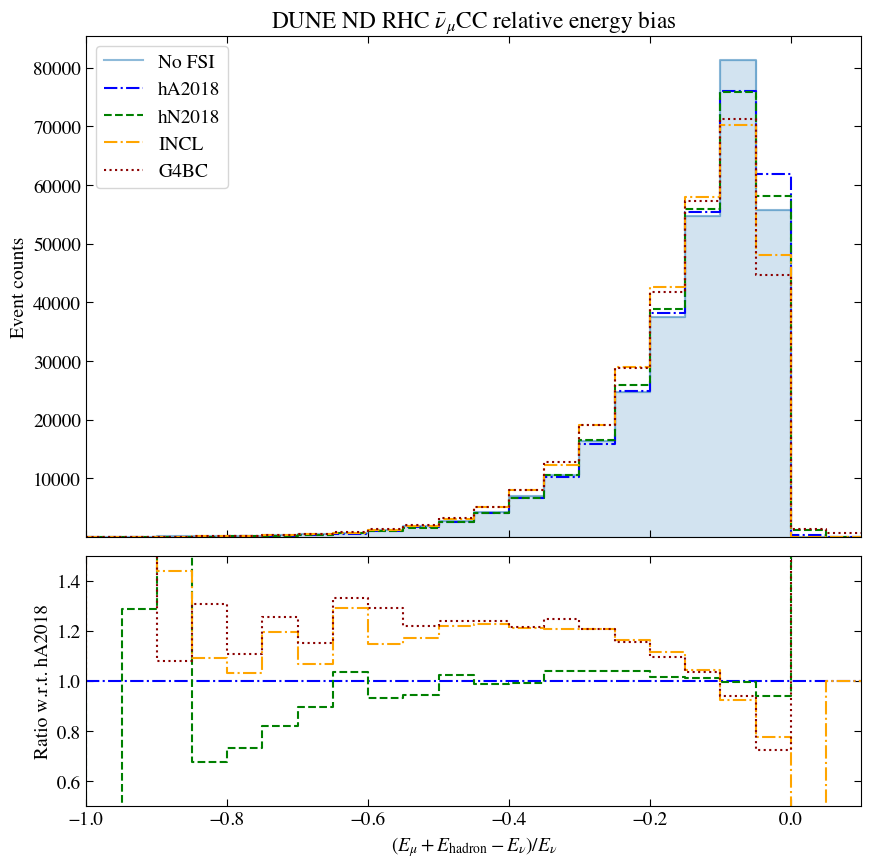

#events: 279942 280604 281329 279432 276495


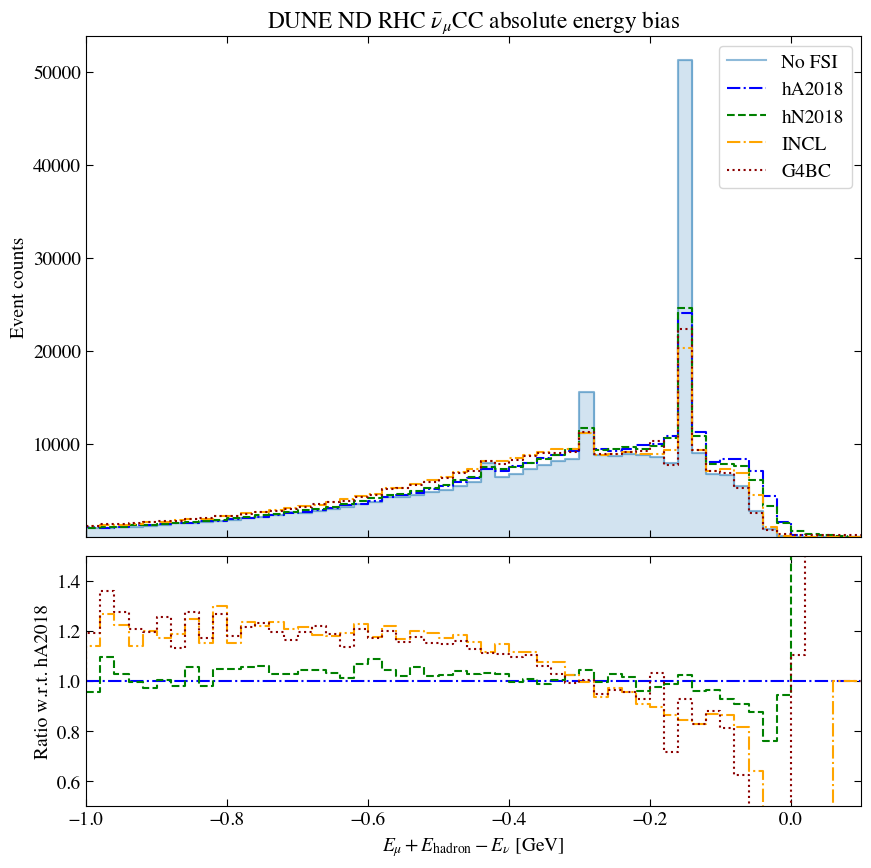

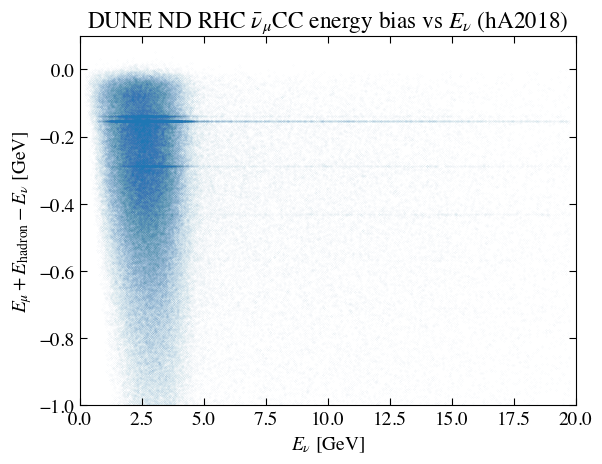

In [11]:
# relative energy bias
xx = np.linspace(-1, 0.1, 22+1)
yyi, _ = np.histogram(Ebiasi_numub_hA18/vars_numub_hA18["Ev"], bins=xx); yyi = np.concatenate([[0],yyi])
yyf_hA18, _ = np.histogram(Ebiasf_numub_hA18/vars_numub_hA18["Ev"], bins=xx); yyf_hA18 = np.concatenate([[0],yyf_hA18])
yyf_hN18, _ = np.histogram(Ebiasf_numub_hN18/vars_numub_hN18["Ev"], bins=xx); yyf_hN18 = np.concatenate([[0],yyf_hN18])
yyf_INCL, _ = np.histogram(Ebiasf_numub_INCL/vars_numub_INCL["Ev"], bins=xx); yyf_INCL = np.concatenate([[0],yyf_INCL])
yyf_G4BC, _ = np.histogram(Ebiasf_numub_G4BC/vars_numub_G4BC["Ev"], bins=xx); yyf_G4BC = np.concatenate([[0],yyf_G4BC])
print("Check if all having the same #events:", np.sum(yyi), np.sum(yyf_hA18), np.sum(yyf_hN18), np.sum(yyf_INCL), np.sum(yyf_G4BC))
yyf_INCL = yyf_INCL*np.sum(yyi, dtype=float)/np.sum(yyf_INCL)

fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1], 'hspace': 0.05})

axes[0].step(xx, yyi, label="No FSI", alpha=0.5, color='tab:blue')
axes[0].fill_between(xx, yyi, step="pre", alpha=0.2, color='tab:blue')
axes[0].step(xx, yyf_hA18, "-.", label="hA2018", color='blue')
axes[0].step(xx, yyf_hN18, "--", label="hN2018", color='green')
axes[0].step(xx, yyf_INCL, "-.", label="INCL", color='orange')
axes[0].step(xx, yyf_G4BC, ":", label="G4BC", color='darkred')
axes[0].legend()
axes[0].set_ylabel("Event counts")
axes[0].set_title(r"DUNE ND RHC $\bar{\nu}_\mu$CC relative energy bias")
#axes[0].set_yscale('log')
axes[0].set_ylim([0.6, None])
axes[0].set_xlim([-1, 0.1])

axes[1].step(xx, safe_divide(yyf_hA18, yyf_hA18), "-.", label="hA2018", color='blue')
axes[1].step(xx, safe_divide(yyf_hN18, yyf_hA18), "--", label="hN2018", color='green')
axes[1].step(xx, safe_divide(yyf_INCL, yyf_hA18), "-.", label="INCL", color='orange')
axes[1].step(xx, safe_divide(yyf_G4BC, yyf_hA18), ":", label="G4BC", color='darkred')
axes[1].set_xlabel(r"$(E_\mu+E_{\rm hadron}-E_\nu)/E_\nu$")
axes[1].set_ylabel("Ratio w.r.t. hA2018")
axes[1].set_xlim([-1, 0.1])
axes[1].set_ylim([0.5, 1.5])
#plt.savefig("FSIplots/relaEvbias_Eavail_FSI_numub.png")
plt.show()


# absolute energy bias
xlow, xupp = -1, 0.1
xx = np.linspace(xlow, xupp, 55+1)
yyi, _ = np.histogram(Ebiasi_numub_hA18, bins=xx); yyi = np.concatenate([[0],yyi])
yyf_hA18, _ = np.histogram(Ebiasf_numub_hA18, bins=xx); yyf_hA18 = np.concatenate([[0],yyf_hA18])
yyf_hN18, _ = np.histogram(Ebiasf_numub_hN18, bins=xx); yyf_hN18 = np.concatenate([[0],yyf_hN18])
yyf_INCL, _ = np.histogram(Ebiasf_numub_INCL, bins=xx); yyf_INCL = np.concatenate([[0],yyf_INCL])
yyf_G4BC, _ = np.histogram(Ebiasf_numub_G4BC, bins=xx); yyf_G4BC = np.concatenate([[0],yyf_G4BC])
print("#events:", np.sum(yyi), np.sum(yyf_hA18), np.sum(yyf_hN18), np.sum(yyf_INCL), np.sum(yyf_G4BC))

fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1], 'hspace': 0.05})

axes[0].step(xx, yyi, label="No FSI", alpha=0.5, color='tab:blue')
axes[0].fill_between(xx, yyi, step="pre", alpha=0.2, color='tab:blue')
axes[0].step(xx, yyf_hA18, "-.", label="hA2018", color='blue')
axes[0].step(xx, yyf_hN18, "--", label="hN2018", color='green')
axes[0].step(xx, yyf_INCL, "-.", label="INCL", color='orange')
axes[0].step(xx, yyf_G4BC, ":", label="G4BC", color='darkred')
axes[0].legend()
axes[0].set_ylabel("Event counts")
axes[0].set_title(r"DUNE ND RHC $\bar{\nu}_\mu$CC absolute energy bias")
#axes[0].set_yscale('log')
axes[0].set_ylim([0.6, None])
axes[0].set_xlim([xlow, xupp])

axes[1].step(xx, safe_divide(yyf_hA18, yyf_hA18), "-.", label="hA2018", color='blue')
axes[1].step(xx, safe_divide(yyf_hN18, yyf_hA18), "--", label="hN2018", color='green')
axes[1].step(xx, safe_divide(yyf_INCL, yyf_hA18), "-.", label="INCL", color='orange')
axes[1].step(xx, safe_divide(yyf_G4BC, yyf_hA18), ":", label="G4BC", color='darkred')
axes[1].set_xlabel(r"$E_\mu+E_{\rm hadron}-E_\nu$ [GeV]")
axes[1].set_ylabel("Ratio w.r.t. hA2018")
axes[1].set_xlim([xlow, xupp])
axes[1].set_ylim([0.5, 1.5])
#plt.savefig("FSIplots/absoEvbias_Eavail_FSI_numub.png")
plt.show()


# energy bias vs neutrino energy
plt.scatter(vars_numub_hA18["Ev"], Ebiasf_numub_hA18, alpha=0.1, s=0.01)
plt.xlabel(r"$E_\nu$ [GeV]")
plt.ylabel(r"$E_\mu+E_{\rm hadron}-E_\nu$ [GeV]")
plt.xlim(0, 20)
plt.ylim(xlow, xupp)
plt.title(r"DUNE ND RHC $\bar{\nu}_\mu$CC energy bias vs $E_\nu$ (hA2018)")
#plt.savefig("FSIplots/2DEvbias_Eavail_hA18_numub.png")
plt.show()

/var/folders/xk/87tb0s5506b1_cd1jnk_jm9c0000gn/T/ipykernel_47731/3196513971.py:2: RuntimeWarning: invalid value encountered in divide
  fluxND2FD_numub_1300 = FDosc_Flux_FHCnumub_1300*1e7/ND_Flux_RHCnumubar


Check if all having the same #events: 9.999999999999998 10.0 9.999999999999998 10.0 9.999999999999998


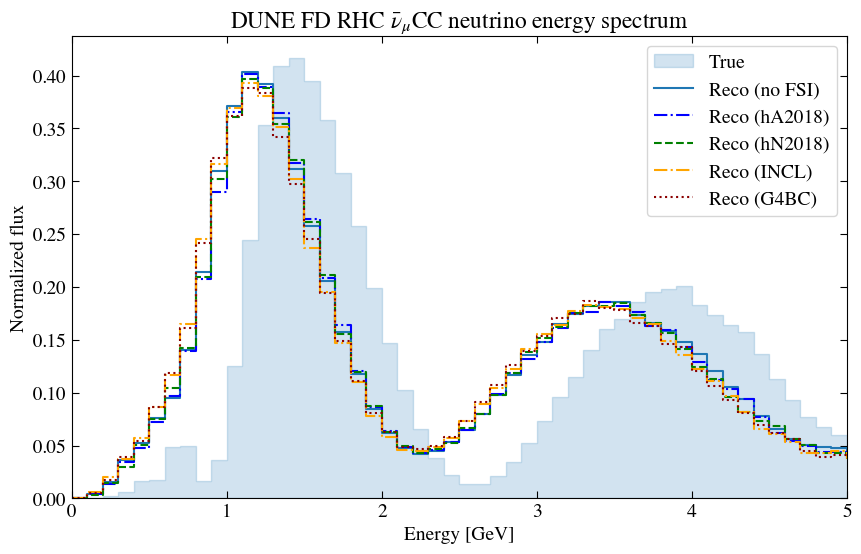

In [40]:
# oscillation
fluxND2FD_numub_1300 = FDosc_Flux_FHCnumub_1300*1e7/ND_Flux_RHCnumubar
ND2FD_numub_wei_hA18 = np.interp(vars_numub_hA18["Ev"], FDosc_Ev, fluxND2FD_numub_1300)
ND2FD_numub_wei_hN18 = np.interp(vars_numub_hN18["Ev"], FDosc_Ev, fluxND2FD_numub_1300)
ND2FD_numub_wei_INCL = np.interp(vars_numub_INCL["Ev"], FDosc_Ev, fluxND2FD_numub_1300)
ND2FD_numub_wei_G4BC = np.interp(vars_numub_G4BC["Ev"], FDosc_Ev, fluxND2FD_numub_1300)

xx = np.arange(0, 20+0.1, 0.1)
yyt, _ = np.histogram(vars_numub_hA18["Ev"], bins=xx, weights=ND2FD_numub_wei_hA18, density=True); yyt = np.concatenate([[0],yyt])
yyi, _ = np.histogram(vars_numub_hA18["Ev"]+Ebiasi_numub_hA18, bins=xx, weights=ND2FD_numub_wei_hA18, density=True); yyi = np.concatenate([[0],yyi])
yyf_hA18, _ = np.histogram(vars_numub_hA18["Ev"]+Ebiasf_numub_hA18, bins=xx, weights=ND2FD_numub_wei_hA18, density=True); yyf_hA18 = np.concatenate([[0],yyf_hA18])
yyf_hN18, _ = np.histogram(vars_numub_hN18["Ev"]+Ebiasf_numub_hN18, bins=xx, weights=ND2FD_numub_wei_hN18, density=True); yyf_hN18 = np.concatenate([[0],yyf_hN18])
yyf_INCL, _ = np.histogram(vars_numub_INCL["Ev"]+Ebiasf_numub_INCL, bins=xx, weights=ND2FD_numub_wei_INCL, density=True); yyf_INCL = np.concatenate([[0],yyf_INCL])
yyf_G4BC, _ = np.histogram(vars_numub_G4BC["Ev"]+Ebiasf_numub_G4BC, bins=xx, weights=ND2FD_numub_wei_G4BC, density=True); yyf_G4BC = np.concatenate([[0],yyf_G4BC])
print("Check if all having the same #events:", np.sum(yyi), np.sum(yyf_hA18), np.sum(yyf_hN18), np.sum(yyf_INCL), np.sum(yyf_G4BC))

fig, ax = plt.subplots(figsize=(10, 6))
ax.fill_between(xx, yyt, step="pre", label="True", alpha=0.2, color='tab:blue')
ax.step(xx, yyi, label="Reco (no FSI)", alpha=1, color='tab:blue')
ax.step(xx, yyf_hA18, "-.", label="Reco (hA2018)", color='blue')
ax.step(xx, yyf_hN18, "--", label="Reco (hN2018)", color='green')
ax.step(xx, yyf_INCL, "-.", label="Reco (INCL)", color='orange')
ax.step(xx, yyf_G4BC, ":", label="Reco (G4BC)", color='darkred')
ax.legend()
ax.set_xlabel("Energy [GeV]")
ax.set_ylabel("Normalized flux")
ax.set_title(r"DUNE FD RHC $\bar{\nu}_\mu$CC neutrino energy spectrum")
ax.set_ylim([0, None])
ax.set_xlim([0, 5])
#plt.savefig("FSIplots/FDoscNv_Eavail_FSI_numub.png")
plt.show()

/var/folders/xk/87tb0s5506b1_cd1jnk_jm9c0000gn/T/ipykernel_47731/1577793984.py:2: RuntimeWarning: invalid value encountered in divide
  fluxND2FD_numub_m23p = FDosc_Flux_FHCnumub_m23p*1e7/ND_Flux_RHCnumubar
/var/folders/xk/87tb0s5506b1_cd1jnk_jm9c0000gn/T/ipykernel_47731/1577793984.py:3: RuntimeWarning: invalid value encountered in divide
  fluxND2FD_numub_m23m = FDosc_Flux_FHCnumub_m23m*1e7/ND_Flux_RHCnumubar
/var/folders/xk/87tb0s5506b1_cd1jnk_jm9c0000gn/T/ipykernel_47731/1577793984.py:4: RuntimeWarning: invalid value encountered in divide
  fluxND2FD_numub_m232p = FDosc_Flux_FHCnumub_m232p*1e7/ND_Flux_RHCnumubar
/var/folders/xk/87tb0s5506b1_cd1jnk_jm9c0000gn/T/ipykernel_47731/1577793984.py:5: RuntimeWarning: invalid value encountered in divide
  fluxND2FD_numub_m232m = FDosc_Flux_FHCnumub_m232m*1e7/ND_Flux_RHCnumubar
/var/folders/xk/87tb0s5506b1_cd1jnk_jm9c0000gn/T/ipykernel_47731/1577793984.py:6: RuntimeWarning: invalid value encountered in divide
  fluxND2FD_numub_t23p = FDosc_Flu

Check if all having the same #events: 9.999999999999998 10.0 9.999999999999998 10.0 9.999999999999998


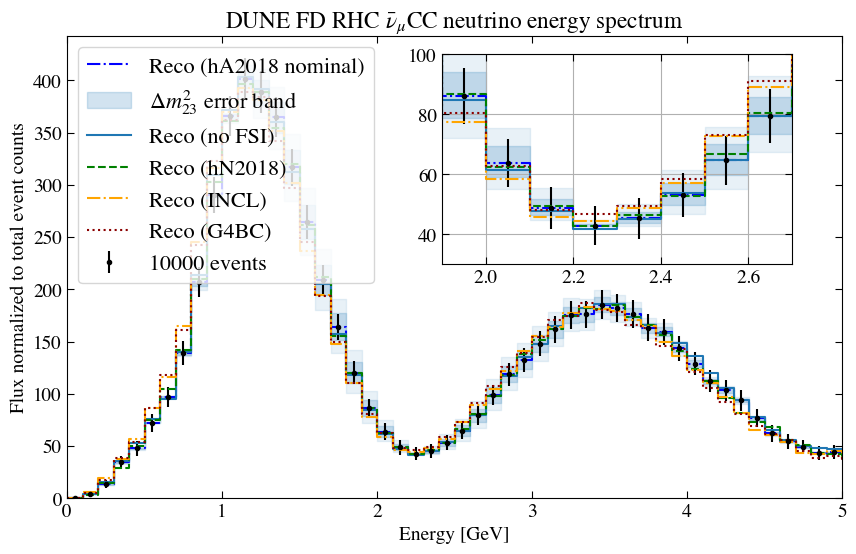

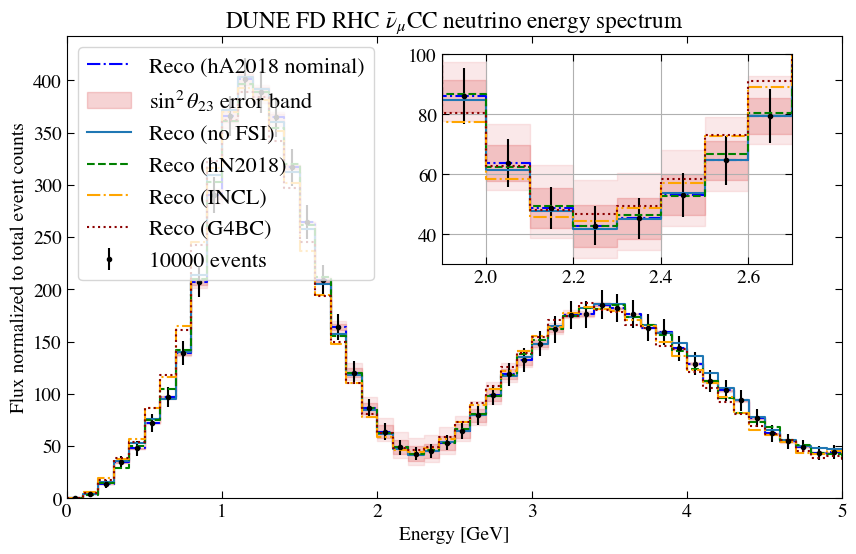

In [41]:
# oscillation
fluxND2FD_numub_m23p = FDosc_Flux_FHCnumub_m23p*1e7/ND_Flux_RHCnumubar
fluxND2FD_numub_m23m = FDosc_Flux_FHCnumub_m23m*1e7/ND_Flux_RHCnumubar
fluxND2FD_numub_m232p = FDosc_Flux_FHCnumub_m232p*1e7/ND_Flux_RHCnumubar
fluxND2FD_numub_m232m = FDosc_Flux_FHCnumub_m232m*1e7/ND_Flux_RHCnumubar
fluxND2FD_numub_t23p = FDosc_Flux_FHCnumub_t23p*1e7/ND_Flux_RHCnumubar
fluxND2FD_numub_t23m = FDosc_Flux_FHCnumub_t23m*1e7/ND_Flux_RHCnumubar
fluxND2FD_numub_t232p = FDosc_Flux_FHCnumub_t232p*1e7/ND_Flux_RHCnumubar
fluxND2FD_numub_t232m = FDosc_Flux_FHCnumub_t232m*1e7/ND_Flux_RHCnumubar

ND2FD_numub_wei_1300 = np.interp(vars_numub_hA18["Ev"], FDosc_Ev, fluxND2FD_numub_1300)
ND2FD_numub_wei_m23p = np.interp(vars_numub_hA18["Ev"], FDosc_Ev, fluxND2FD_numub_m23p)
ND2FD_numub_wei_m23m = np.interp(vars_numub_hA18["Ev"], FDosc_Ev, fluxND2FD_numub_m23m)
ND2FD_numub_wei_m232p = np.interp(vars_numub_hA18["Ev"], FDosc_Ev, fluxND2FD_numub_m232p)
ND2FD_numub_wei_m232m = np.interp(vars_numub_hA18["Ev"], FDosc_Ev, fluxND2FD_numub_m232m)
ND2FD_numub_wei_t23p = np.interp(vars_numub_hA18["Ev"], FDosc_Ev, fluxND2FD_numub_t23p)
ND2FD_numub_wei_t23m = np.interp(vars_numub_hA18["Ev"], FDosc_Ev, fluxND2FD_numub_t23m)
ND2FD_numub_wei_t232p = np.interp(vars_numub_hA18["Ev"], FDosc_Ev, fluxND2FD_numub_t232p)
ND2FD_numub_wei_t232m = np.interp(vars_numub_hA18["Ev"], FDosc_Ev, fluxND2FD_numub_t232m)

yyf_1300, _ = np.histogram(vars_numub_hA18["Ev"]+Ebiasf_numub_hA18, bins=xx, weights=ND2FD_numub_wei_1300, density=True); yyf_1300 = np.concatenate([[0],yyf_1300])
yyf_m23p, _ = np.histogram(vars_numub_hA18["Ev"]+Ebiasf_numub_hA18, bins=xx, weights=ND2FD_numub_wei_m23p, density=True); yyf_m23p = np.concatenate([[0],yyf_m23p])
yyf_m23m, _ = np.histogram(vars_numub_hA18["Ev"]+Ebiasf_numub_hA18, bins=xx, weights=ND2FD_numub_wei_m23m, density=True); yyf_m23m = np.concatenate([[0],yyf_m23m])
yyf_m232p, _ = np.histogram(vars_numub_hA18["Ev"]+Ebiasf_numub_hA18, bins=xx, weights=ND2FD_numub_wei_m232p, density=True); yyf_m232p = np.concatenate([[0],yyf_m232p])
yyf_m232m, _ = np.histogram(vars_numub_hA18["Ev"]+Ebiasf_numub_hA18, bins=xx, weights=ND2FD_numub_wei_m232m, density=True); yyf_m232m = np.concatenate([[0],yyf_m232m])
yyf_t23p, _ = np.histogram(vars_numub_hA18["Ev"]+Ebiasf_numub_hA18, bins=xx, weights=ND2FD_numub_wei_t23p, density=True); yyf_t23p = np.concatenate([[0],yyf_t23p])
yyf_t23m, _ = np.histogram(vars_numub_hA18["Ev"]+Ebiasf_numub_hA18, bins=xx, weights=ND2FD_numub_wei_t23m, density=True); yyf_t23m = np.concatenate([[0],yyf_t23m])
yyf_t232p, _ = np.histogram(vars_numub_hA18["Ev"]+Ebiasf_numub_hA18, bins=xx, weights=ND2FD_numub_wei_t232p, density=True); yyf_t232p = np.concatenate([[0],yyf_t232p])
yyf_t232m, _ = np.histogram(vars_numub_hA18["Ev"]+Ebiasf_numub_hA18, bins=xx, weights=ND2FD_numub_wei_t232m, density=True); yyf_t232m = np.concatenate([[0],yyf_t232m])
print("Check if all having the same #events:", np.sum(yyi), np.sum(yyf_hA18), np.sum(yyf_hN18), np.sum(yyf_INCL), np.sum(yyf_G4BC))

Nv = 10000 # estimated total event counts
scale = Nv/np.sum(yyf_1300)

### Δm^2_{23}
fig, ax = plt.subplots(figsize=(10, 6))
ax.step(xx, scale*yyf_1300, "-.", label="Reco (hA2018 nominal)", alpha=1, color='blue')
ax.errorbar((xx[1:]+xx[:-1])/2, scale*yyf_1300[1:], np.sqrt(scale*yyf_1300[1:]), fmt="k.", label=f"{Nv} events")
#ax.step(xx, yyf_m23p, "r:", label="Reco (upper Dmsq23)")
#ax.step(xx, yyf_m23m, "m--", label="Reco (lower Dmsq23)")
#ax.step(xx, yyf_t23p, "b:", label="Reco (upper theta23)")
#ax.step(xx, yyf_t23m, "c--", label="Reco (lower theta23)")
ax.fill_between(xx, scale*yyf_m23m, scale*yyf_m23p, step="pre", label=r"$\Delta m^2_{23}$ error band", alpha=0.2, color='tab:blue')
ax.fill_between(xx, scale*yyf_m232m, scale*yyf_m232p, step="pre", alpha=0.1, color='tab:blue')
ax.step(xx, scale*yyi, label="Reco (no FSI)", alpha=1, color='tab:blue')
#ax.step(xx, scale*yyf_hA18, "-.", label="Reco (hA2018)", color='blue')
ax.step(xx, scale*yyf_hN18, "--", label="Reco (hN2018)", color='green')
ax.step(xx, scale*yyf_INCL, "-.", label="Reco (INCL)", color='orange')
ax.step(xx, scale*yyf_G4BC, ":", label="Reco (G4BC)", color='darkred')
ax.legend(loc="upper left", fontsize=16)
ax.set_xlabel("Energy [GeV]")
ax.set_ylabel("Flux normalized to total event counts")
ax.set_title(r"DUNE FD RHC $\bar{\nu}_\mu$CC neutrino energy spectrum")
ax.set_ylim([0, None])
ax.set_xlim([0, 5])

ax_inset = fig.add_axes([0.5, 0.5, 0.35, 0.35])  # Adjust these values as needed
# Plot the same data on the inset axes
ax_inset.step(xx, scale*yyf_1300, "-.", label="Reco (hA2018 nominal)", alpha=1, color='blue')
ax_inset.fill_between(xx, scale*yyf_m23m, scale*yyf_m23p, step="pre", label=r"$\Delta m^2_{23}$ error band", alpha=0.2, color='tab:blue')
ax_inset.fill_between(xx, scale*yyf_m232m, scale*yyf_m232p, step="pre", alpha=0.1, color='tab:blue')
ax_inset.errorbar((xx[1:]+xx[:-1])/2, scale*yyf_1300[1:], np.sqrt(scale*yyf_1300[1:]), fmt="k.", label=f"{Nv} events")
ax_inset.step(xx, scale*yyi, label="Reco (no FSI)", alpha=1, color='tab:blue')
#ax_inset.step(xx, scale*yyf_hA18, "-.", label="Reco (hA2018)", color='blue')
ax_inset.step(xx, scale*yyf_hN18, "--", label="Reco (hN2018)", color='green')
ax_inset.step(xx, scale*yyf_INCL, "-.", label="Reco (INCL)", color='orange')
ax_inset.step(xx, scale*yyf_G4BC, ":", label="Reco (G4BC)", color='darkred')
ax_inset.set_ylim([0.03*scale, 0.1*scale])
ax_inset.set_xlim([1.9, 2.7])
ax_inset.grid(True)
plt.savefig("FSIplots/FDoscNv_Eavail_FSI_numub_m23.png")
plt.show()

### sin^2 θ_{23}
fig, ax = plt.subplots(figsize=(10, 6))
ax.step(xx, scale*yyf_1300, "-.", label="Reco (hA2018 nominal)", alpha=1, color='blue')
ax.errorbar((xx[1:]+xx[:-1])/2, scale*yyf_1300[1:], np.sqrt(scale*yyf_1300[1:]), fmt="k.", label=f"{Nv} events")
#ax.step(xx, yyf_m23p, "r:", label="Reco (upper Dmsq23)")
#ax.step(xx, yyf_m23m, "m--", label="Reco (lower Dmsq23)")
#ax.step(xx, yyf_t23p, "b:", label="Reco (upper theta23)")
#ax.step(xx, yyf_t23m, "c--", label="Reco (lower theta23)")
ax.fill_between(xx, scale*yyf_t23m, scale*yyf_t23p, step="pre", label=r"$\sin^2 \theta_{23}$ error band", alpha=0.2, color='tab:red')
ax.fill_between(xx, scale*yyf_t232m, scale*yyf_t232p, step="pre", alpha=0.1, color='tab:red')
ax.step(xx, scale*yyi, label="Reco (no FSI)", alpha=1, color='tab:blue')
#ax.step(xx, scale*yyf_hA18, "-.", label="Reco (hA2018)", color='blue')
ax.step(xx, scale*yyf_hN18, "--", label="Reco (hN2018)", color='green')
ax.step(xx, scale*yyf_INCL, "-.", label="Reco (INCL)", color='orange')
ax.step(xx, scale*yyf_G4BC, ":", label="Reco (G4BC)", color='darkred')
ax.legend(loc="upper left", fontsize=16)
ax.set_xlabel("Energy [GeV]")
ax.set_ylabel("Flux normalized to total event counts")
ax.set_title(r"DUNE FD RHC $\bar{\nu}_\mu$CC neutrino energy spectrum")
ax.set_ylim([0, None])
ax.set_xlim([0, 5])

ax_inset = fig.add_axes([0.5, 0.5, 0.35, 0.35])  # Adjust these values as needed
# Plot the same data on the inset axes
ax_inset.step(xx, scale*yyf_1300, "-.", label="Reco (hA2018 nominal)", alpha=1, color='blue')
ax_inset.errorbar((xx[1:]+xx[:-1])/2, scale*yyf_1300[1:], np.sqrt(scale*yyf_1300[1:]), fmt="k.", label=f"{Nv} events")
ax_inset.fill_between(xx, scale*yyf_t23m, scale*yyf_t23p, step="pre", label=r"$\sin^2 \theta_{23}$ error band", alpha=0.2, color='tab:red')
ax_inset.fill_between(xx, scale*yyf_t232m, scale*yyf_t232p, step="pre", alpha=0.1, color='tab:red')
ax_inset.step(xx, scale*yyi, label="Reco (no FSI)", alpha=1, color='tab:blue')
#ax_inset.step(xx, scale*yyf_hA18, "-.", label="Reco (hA2018)", color='blue')
ax_inset.step(xx, scale*yyf_hN18, "--", label="Reco (hN2018)", color='green')
ax_inset.step(xx, scale*yyf_INCL, "-.", label="Reco (INCL)", color='orange')
ax_inset.step(xx, scale*yyf_G4BC, ":", label="Reco (G4BC)", color='darkred')
ax_inset.set_ylim([0.03*scale, 0.1*scale])
ax_inset.set_xlim([1.9, 2.7])
ax_inset.grid(True)
plt.savefig("FSIplots/FDoscNv_Eavail_FSI_numub_t23.png")
plt.show()


### Hadron KE spectra 
##### numu

In [14]:
# pre-FSI
pKE_numu_noFSI = []
nKE_numu_noFSI = []
pipKE_numu_noFSI = []
pi0KE_numu_noFSI = []
pimKE_numu_noFSI = []
#Nhad_noFSI = np.ones(6, dtype=int) # p, n, pip, pi0, pim, other
for ievt in range(len(vars_numu_hA18["pdgi"])):
    for ipar in range(len(vars_numu_hA18["pdgi"][ievt])):
        if vars_numu_hA18["pdgi"][ievt][ipar] == 2212:
            pKE_numu_noFSI.append(vars_numu_hA18["Ei"][ievt][ipar] - 0.938272)
        elif vars_numu_hA18["pdgi"][ievt][ipar] == 2112:
            nKE_numu_noFSI.append(vars_numu_hA18["Ei"][ievt][ipar] - 0.939565)
        elif vars_numu_hA18["pdgi"][ievt][ipar] == 211:
            pipKE_numu_noFSI.append(vars_numu_hA18["Ei"][ievt][ipar] - 0.13957)
        elif vars_numu_hA18["pdgi"][ievt][ipar] == 111:
            pi0KE_numu_noFSI.append(vars_numu_hA18["Ei"][ievt][ipar] - 0.134977)
        elif vars_numu_hA18["pdgi"][ievt][ipar] == -211:
            pimKE_numu_noFSI.append(vars_numu_hA18["Ei"][ievt][ipar] - 0.13957)

# hA2018
pKE_numu_hA18 = []
nKE_numu_hA18 = []
pipKE_numu_hA18 = []
pi0KE_numu_hA18 = []
pimKE_numu_hA18 = []
for ievt in range(len(vars_numu_hA18["pdgf"])):
    for ipar in range(len(vars_numu_hA18["pdgf"][ievt])):
        if vars_numu_hA18["pdgf"][ievt][ipar] == 2212:
            pKE_numu_hA18.append(vars_numu_hA18["Ef"][ievt][ipar] - 0.938272)
        elif vars_numu_hA18["pdgf"][ievt][ipar] == 2112:
            nKE_numu_hA18.append(vars_numu_hA18["Ef"][ievt][ipar] - 0.939565)
        elif vars_numu_hA18["pdgf"][ievt][ipar] == 211:
            pipKE_numu_hA18.append(vars_numu_hA18["Ef"][ievt][ipar] - 0.13957)
        elif vars_numu_hA18["pdgf"][ievt][ipar] == 111:
            pi0KE_numu_hA18.append(vars_numu_hA18["Ef"][ievt][ipar] - 0.134977)
        elif vars_numu_hA18["pdgf"][ievt][ipar] == -211:
            pimKE_numu_hA18.append(vars_numu_hA18["Ef"][ievt][ipar] - 0.13957)

# hN2018
pKE_numu_hN18 = []
nKE_numu_hN18 = []
pipKE_numu_hN18 = []
pi0KE_numu_hN18 = []
pimKE_numu_hN18 = []
for ievt in range(len(vars_numu_hN18["pdgf"])):
    for ipar in range(len(vars_numu_hN18["pdgf"][ievt])):
        if vars_numu_hN18["pdgf"][ievt][ipar] == 2212:
            pKE_numu_hN18.append(vars_numu_hN18["Ef"][ievt][ipar] - 0.938272)
        elif vars_numu_hN18["pdgf"][ievt][ipar] == 2112:
            nKE_numu_hN18.append(vars_numu_hN18["Ef"][ievt][ipar] - 0.939565)
        elif vars_numu_hN18["pdgf"][ievt][ipar] == 211:
            pipKE_numu_hN18.append(vars_numu_hN18["Ef"][ievt][ipar] - 0.13957)
        elif vars_numu_hN18["pdgf"][ievt][ipar] == 111:
            pi0KE_numu_hN18.append(vars_numu_hN18["Ef"][ievt][ipar] - 0.134977)
        elif vars_numu_hN18["pdgf"][ievt][ipar] == -211:
            pimKE_numu_hN18.append(vars_numu_hN18["Ef"][ievt][ipar] - 0.13957)

# INCL
pKE_numu_INCL = []
nKE_numu_INCL = []
pipKE_numu_INCL = []
pi0KE_numu_INCL = []
pimKE_numu_INCL = []
for ievt in range(len(vars_numu_INCL["pdgf"])):
    for ipar in range(len(vars_numu_INCL["pdgf"][ievt])):
        if vars_numu_INCL["pdgf"][ievt][ipar] == 2212:
            pKE_numu_INCL.append(vars_numu_INCL["Ef"][ievt][ipar] - 0.938272)
        elif vars_numu_INCL["pdgf"][ievt][ipar] == 2112:
            nKE_numu_INCL.append(vars_numu_INCL["Ef"][ievt][ipar] - 0.939565)
        elif vars_numu_INCL["pdgf"][ievt][ipar] == 211:
            pipKE_numu_INCL.append(vars_numu_INCL["Ef"][ievt][ipar] - 0.13957)
        elif vars_numu_INCL["pdgf"][ievt][ipar] == 111:
            pi0KE_numu_INCL.append(vars_numu_INCL["Ef"][ievt][ipar] - 0.134977)
        elif vars_numu_INCL["pdgf"][ievt][ipar] == -211:
            pimKE_numu_INCL.append(vars_numu_INCL["Ef"][ievt][ipar] - 0.13957)

# G4BC
pKE_numu_G4BC = []
nKE_numu_G4BC = []
pipKE_numu_G4BC = []
pi0KE_numu_G4BC = []
pimKE_numu_G4BC = []
for ievt in range(len(vars_numu_G4BC["pdgf"])):
    for ipar in range(len(vars_numu_G4BC["pdgf"][ievt])):
        if vars_numu_G4BC["pdgf"][ievt][ipar] == 2212:
            pKE_numu_G4BC.append(vars_numu_G4BC["Ef"][ievt][ipar] - 0.938272)
        elif vars_numu_G4BC["pdgf"][ievt][ipar] == 2112:
            nKE_numu_G4BC.append(vars_numu_G4BC["Ef"][ievt][ipar] - 0.939565)
        elif vars_numu_G4BC["pdgf"][ievt][ipar] == 211:
            pipKE_numu_G4BC.append(vars_numu_G4BC["Ef"][ievt][ipar] - 0.13957)
        elif vars_numu_G4BC["pdgf"][ievt][ipar] == 111:
            pi0KE_numu_G4BC.append(vars_numu_G4BC["Ef"][ievt][ipar] - 0.134977)
        elif vars_numu_G4BC["pdgf"][ievt][ipar] == -211:
            pimKE_numu_G4BC.append(vars_numu_G4BC["Ef"][ievt][ipar] - 0.13957)

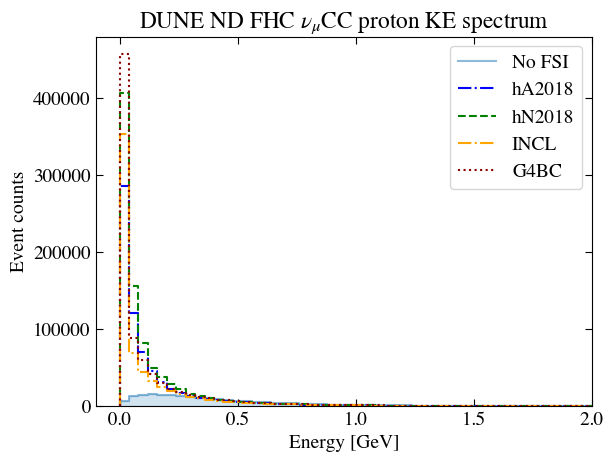

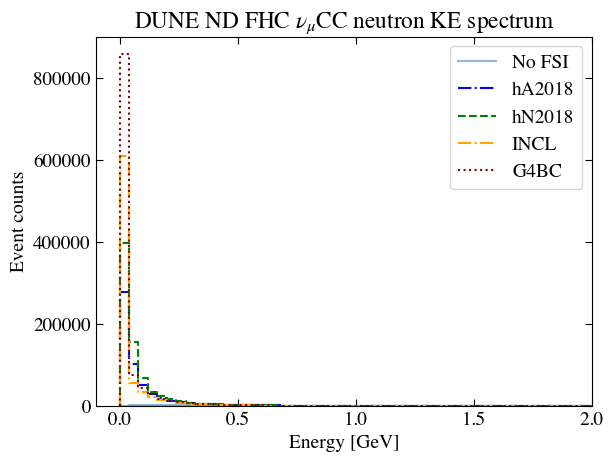

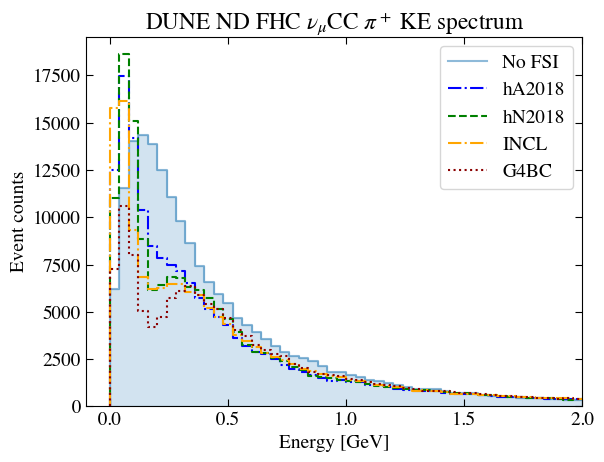

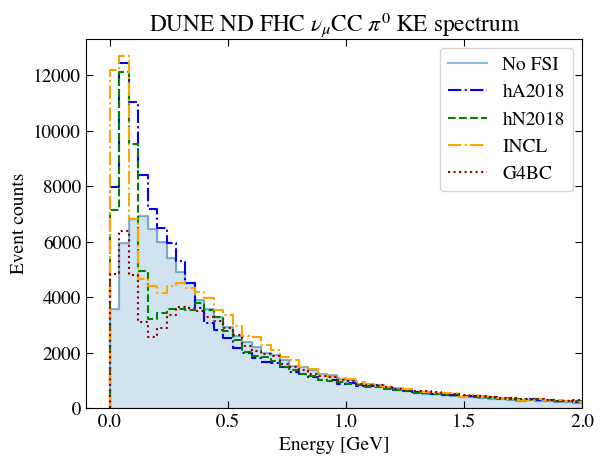

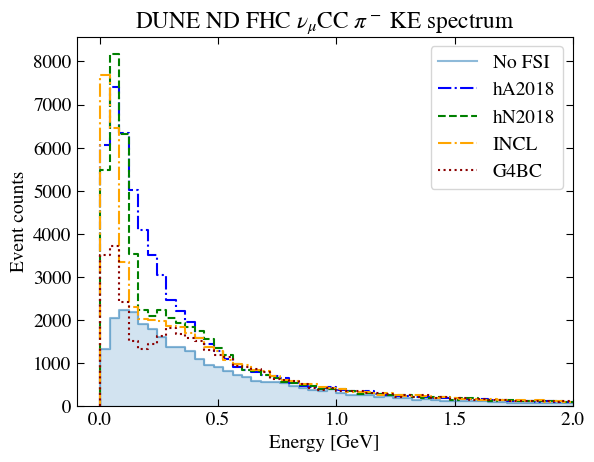

In [15]:
# proton KE spectra
xx = np.linspace(0, 2, 51)
yynoFSI, _ = np.histogram(pKE_numu_noFSI, bins=xx); yynoFSI = np.concatenate([[0],yynoFSI])
yyhA18, _ = np.histogram(pKE_numu_hA18, bins=xx); yyhA18 = np.concatenate([[0],yyhA18])
yyhN18, _ = np.histogram(pKE_numu_hN18, bins=xx); yyhN18 = np.concatenate([[0],yyhN18])
yyINCL, _ = np.histogram(pKE_numu_INCL, bins=xx); yyINCL = np.concatenate([[0],yyINCL])
yyG4BC, _ = np.histogram(pKE_numu_G4BC, bins=xx); yyG4BC = np.concatenate([[0],yyG4BC])

fig, ax = plt.subplots()
ax.step(xx, yynoFSI, label="No FSI", alpha=0.5, color='tab:blue')
ax.fill_between(xx, yynoFSI, step="pre", alpha=0.2, color='tab:blue')
ax.step(xx, yyhA18, "-.", label="hA2018", color='blue')
ax.step(xx, yyhN18, "--", label="hN2018", color='green')
ax.step(xx, yyINCL, "-.", label="INCL", color='orange')
ax.step(xx, yyG4BC, ":", label="G4BC", color='darkred')
ax.legend()
ax.set_xlabel("Energy [GeV]")
ax.set_ylabel("Event counts")
ax.set_title(r"DUNE ND FHC $\nu_\mu$CC proton KE spectrum")
ax.set_ylim([0, None])
ax.set_xlim([None, 2])
#plt.savefig("FSIplots/ND_pKE_numu.png")
plt.show()

# neutron KE spectra
xx = np.linspace(0, 2, 51)
yynoFSI, _ = np.histogram(nKE_numu_noFSI, bins=xx); yynoFSI = np.concatenate([[0],yynoFSI])
yyhA18, _ = np.histogram(nKE_numu_hA18, bins=xx); yyhA18 = np.concatenate([[0],yyhA18])
yyhN18, _ = np.histogram(nKE_numu_hN18, bins=xx); yyhN18 = np.concatenate([[0],yyhN18])
yyINCL, _ = np.histogram(nKE_numu_INCL, bins=xx); yyINCL = np.concatenate([[0],yyINCL])
yyG4BC, _ = np.histogram(nKE_numu_G4BC, bins=xx); yyG4BC = np.concatenate([[0],yyG4BC])

fig, ax = plt.subplots()
ax.step(xx, yynoFSI, label="No FSI", alpha=0.5, color='tab:blue')
ax.fill_between(xx, yynoFSI, step="pre", alpha=0.2, color='tab:blue')
ax.step(xx, yyhA18, "-.", label="hA2018", color='blue')
ax.step(xx, yyhN18, "--", label="hN2018", color='green')
ax.step(xx, yyINCL, "-.", label="INCL", color='orange')
ax.step(xx, yyG4BC, ":", label="G4BC", color='darkred')
ax.legend()
ax.set_xlabel("Energy [GeV]")
ax.set_ylabel("Event counts")
ax.set_title(r"DUNE ND FHC $\nu_\mu$CC neutron KE spectrum")
ax.set_ylim([0, None])
ax.set_xlim([None, 2])
#plt.savefig("FSIplots/ND_nKE_numu.png")
plt.show()

# pi+ KE spectra
xx = np.linspace(0, 2, 51)
yynoFSI, _ = np.histogram(pipKE_numu_noFSI, bins=xx); yynoFSI = np.concatenate([[0],yynoFSI])
yyhA18, _ = np.histogram(pipKE_numu_hA18, bins=xx); yyhA18 = np.concatenate([[0],yyhA18])
yyhN18, _ = np.histogram(pipKE_numu_hN18, bins=xx); yyhN18 = np.concatenate([[0],yyhN18])
yyINCL, _ = np.histogram(pipKE_numu_INCL, bins=xx); yyINCL = np.concatenate([[0],yyINCL])
yyG4BC, _ = np.histogram(pipKE_numu_G4BC, bins=xx); yyG4BC = np.concatenate([[0],yyG4BC])

fig, ax = plt.subplots()
ax.step(xx, yynoFSI, label="No FSI", alpha=0.5, color='tab:blue')
ax.fill_between(xx, yynoFSI, step="pre", alpha=0.2, color='tab:blue')
ax.step(xx, yyhA18, "-.", label="hA2018", color='blue')
ax.step(xx, yyhN18, "--", label="hN2018", color='green')
ax.step(xx, yyINCL, "-.", label="INCL", color='orange')
ax.step(xx, yyG4BC, ":", label="G4BC", color='darkred')
ax.legend()
ax.set_xlabel("Energy [GeV]")
ax.set_ylabel("Event counts")
ax.set_title(r"DUNE ND FHC $\nu_\mu$CC $\pi^+$ KE spectrum")
ax.set_ylim([0, None])
ax.set_xlim([None, 2])
#plt.savefig("FSIplots/ND_pipKE_numu.png")
plt.show()

# pi0 KE spectra
xx = np.linspace(0, 2, 51)
yynoFSI, _ = np.histogram(pi0KE_numu_noFSI, bins=xx); yynoFSI = np.concatenate([[0],yynoFSI])
yyhA18, _ = np.histogram(pi0KE_numu_hA18, bins=xx); yyhA18 = np.concatenate([[0],yyhA18])
yyhN18, _ = np.histogram(pi0KE_numu_hN18, bins=xx); yyhN18 = np.concatenate([[0],yyhN18])
yyINCL, _ = np.histogram(pi0KE_numu_INCL, bins=xx); yyINCL = np.concatenate([[0],yyINCL])
yyG4BC, _ = np.histogram(pi0KE_numu_G4BC, bins=xx); yyG4BC = np.concatenate([[0],yyG4BC])

fig, ax = plt.subplots()
ax.step(xx, yynoFSI, label="No FSI", alpha=0.5, color='tab:blue')
ax.fill_between(xx, yynoFSI, step="pre", alpha=0.2, color='tab:blue')
ax.step(xx, yyhA18, "-.", label="hA2018", color='blue')
ax.step(xx, yyhN18, "--", label="hN2018", color='green')
ax.step(xx, yyINCL, "-.", label="INCL", color='orange')
ax.step(xx, yyG4BC, ":", label="G4BC", color='darkred')
ax.legend()
ax.set_xlabel("Energy [GeV]")
ax.set_ylabel("Event counts")
ax.set_title(r"DUNE ND FHC $\nu_\mu$CC $\pi^0$ KE spectrum")
ax.set_ylim([0, None])
ax.set_xlim([None, 2])
#plt.savefig("FSIplots/ND_pi0KE_numu.png")
plt.show()

# pi- KE spectra
xx = np.linspace(0, 2, 51)
yynoFSI, _ = np.histogram(pimKE_numu_noFSI, bins=xx); yynoFSI = np.concatenate([[0],yynoFSI])
yyhA18, _ = np.histogram(pimKE_numu_hA18, bins=xx); yyhA18 = np.concatenate([[0],yyhA18])
yyhN18, _ = np.histogram(pimKE_numu_hN18, bins=xx); yyhN18 = np.concatenate([[0],yyhN18])
yyINCL, _ = np.histogram(pimKE_numu_INCL, bins=xx); yyINCL = np.concatenate([[0],yyINCL])
yyG4BC, _ = np.histogram(pimKE_numu_G4BC, bins=xx); yyG4BC = np.concatenate([[0],yyG4BC])

fig, ax = plt.subplots()
ax.step(xx, yynoFSI, label="No FSI", alpha=0.5, color='tab:blue')
ax.fill_between(xx, yynoFSI, step="pre", alpha=0.2, color='tab:blue')
ax.step(xx, yyhA18, "-.", label="hA2018", color='blue')
ax.step(xx, yyhN18, "--", label="hN2018", color='green')
ax.step(xx, yyINCL, "-.", label="INCL", color='orange')
ax.step(xx, yyG4BC, ":", label="G4BC", color='darkred')
ax.legend()
ax.set_xlabel("Energy [GeV]")
ax.set_ylabel("Event counts")
ax.set_title(r"DUNE ND FHC $\nu_\mu$CC $\pi^-$ KE spectrum")
ax.set_ylim([0, None])
ax.set_xlim([None, 2])
#plt.savefig("FSIplots/ND_pimKE_numu.png")
plt.show()

##### numubar

In [16]:
# pre-FSI
pKE_numub_noFSI = []
nKE_numub_noFSI = []
pipKE_numub_noFSI = []
pi0KE_numub_noFSI = []
pimKE_numub_noFSI = []
#Nhad_noFSI = np.ones(6, dtype=int) # p, n, pip, pi0, pim, other
for ievt in range(len(vars_numub_hA18["pdgi"])):
    for ipar in range(len(vars_numub_hA18["pdgi"][ievt])):
        if vars_numub_hA18["pdgi"][ievt][ipar] == 2212:
            pKE_numub_noFSI.append(vars_numub_hA18["Ei"][ievt][ipar] - 0.938272)
        elif vars_numub_hA18["pdgi"][ievt][ipar] == 2112:
            nKE_numub_noFSI.append(vars_numub_hA18["Ei"][ievt][ipar] - 0.939565)
        elif vars_numub_hA18["pdgi"][ievt][ipar] == 211:
            pipKE_numub_noFSI.append(vars_numub_hA18["Ei"][ievt][ipar] - 0.13957)
        elif vars_numub_hA18["pdgi"][ievt][ipar] == 111:
            pi0KE_numub_noFSI.append(vars_numub_hA18["Ei"][ievt][ipar] - 0.134977)
        elif vars_numub_hA18["pdgi"][ievt][ipar] == -211:
            pimKE_numub_noFSI.append(vars_numub_hA18["Ei"][ievt][ipar] - 0.13957)

# hA2018
pKE_numub_hA18 = []
nKE_numub_hA18 = []
pipKE_numub_hA18 = []
pi0KE_numub_hA18 = []
pimKE_numub_hA18 = []
for ievt in range(len(vars_numub_hA18["pdgf"])):
    for ipar in range(len(vars_numub_hA18["pdgf"][ievt])):
        if vars_numub_hA18["pdgf"][ievt][ipar] == 2212:
            pKE_numub_hA18.append(vars_numub_hA18["Ef"][ievt][ipar] - 0.938272)
        elif vars_numub_hA18["pdgf"][ievt][ipar] == 2112:
            nKE_numub_hA18.append(vars_numub_hA18["Ef"][ievt][ipar] - 0.939565)
        elif vars_numub_hA18["pdgf"][ievt][ipar] == 211:
            pipKE_numub_hA18.append(vars_numub_hA18["Ef"][ievt][ipar] - 0.13957)
        elif vars_numub_hA18["pdgf"][ievt][ipar] == 111:
            pi0KE_numub_hA18.append(vars_numub_hA18["Ef"][ievt][ipar] - 0.134977)
        elif vars_numub_hA18["pdgf"][ievt][ipar] == -211:
            pimKE_numub_hA18.append(vars_numub_hA18["Ef"][ievt][ipar] - 0.13957)

# hN2018
pKE_numub_hN18 = []
nKE_numub_hN18 = []
pipKE_numub_hN18 = []
pi0KE_numub_hN18 = []
pimKE_numub_hN18 = []
for ievt in range(len(vars_numub_hN18["pdgf"])):
    for ipar in range(len(vars_numub_hN18["pdgf"][ievt])):
        if vars_numub_hN18["pdgf"][ievt][ipar] == 2212:
            pKE_numub_hN18.append(vars_numub_hN18["Ef"][ievt][ipar] - 0.938272)
        elif vars_numub_hN18["pdgf"][ievt][ipar] == 2112:
            nKE_numub_hN18.append(vars_numub_hN18["Ef"][ievt][ipar] - 0.939565)
        elif vars_numub_hN18["pdgf"][ievt][ipar] == 211:
            pipKE_numub_hN18.append(vars_numub_hN18["Ef"][ievt][ipar] - 0.13957)
        elif vars_numub_hN18["pdgf"][ievt][ipar] == 111:
            pi0KE_numub_hN18.append(vars_numub_hN18["Ef"][ievt][ipar] - 0.134977)
        elif vars_numub_hN18["pdgf"][ievt][ipar] == -211:
            pimKE_numub_hN18.append(vars_numub_hN18["Ef"][ievt][ipar] - 0.13957)

# INCL
pKE_numub_INCL = []
nKE_numub_INCL = []
pipKE_numub_INCL = []
pi0KE_numub_INCL = []
pimKE_numub_INCL = []
for ievt in range(len(vars_numub_INCL["pdgf"])):
    for ipar in range(len(vars_numub_INCL["pdgf"][ievt])):
        if vars_numub_INCL["pdgf"][ievt][ipar] == 2212:
            pKE_numub_INCL.append(vars_numub_INCL["Ef"][ievt][ipar] - 0.938272)
        elif vars_numub_INCL["pdgf"][ievt][ipar] == 2112:
            nKE_numub_INCL.append(vars_numub_INCL["Ef"][ievt][ipar] - 0.939565)
        elif vars_numub_INCL["pdgf"][ievt][ipar] == 211:
            pipKE_numub_INCL.append(vars_numub_INCL["Ef"][ievt][ipar] - 0.13957)
        elif vars_numub_INCL["pdgf"][ievt][ipar] == 111:
            pi0KE_numub_INCL.append(vars_numub_INCL["Ef"][ievt][ipar] - 0.134977)
        elif vars_numub_INCL["pdgf"][ievt][ipar] == -211:
            pimKE_numub_INCL.append(vars_numub_INCL["Ef"][ievt][ipar] - 0.13957)

# G4BC
pKE_numub_G4BC = []
nKE_numub_G4BC = []
pipKE_numub_G4BC = []
pi0KE_numub_G4BC = []
pimKE_numub_G4BC = []
for ievt in range(len(vars_numub_G4BC["pdgf"])):
    for ipar in range(len(vars_numub_G4BC["pdgf"][ievt])):
        if vars_numub_G4BC["pdgf"][ievt][ipar] == 2212:
            pKE_numub_G4BC.append(vars_numub_G4BC["Ef"][ievt][ipar] - 0.938272)
        elif vars_numub_G4BC["pdgf"][ievt][ipar] == 2112:
            nKE_numub_G4BC.append(vars_numub_G4BC["Ef"][ievt][ipar] - 0.939565)
        elif vars_numub_G4BC["pdgf"][ievt][ipar] == 211:
            pipKE_numub_G4BC.append(vars_numub_G4BC["Ef"][ievt][ipar] - 0.13957)
        elif vars_numub_G4BC["pdgf"][ievt][ipar] == 111:
            pi0KE_numub_G4BC.append(vars_numub_G4BC["Ef"][ievt][ipar] - 0.134977)
        elif vars_numub_G4BC["pdgf"][ievt][ipar] == -211:
            pimKE_numub_G4BC.append(vars_numub_G4BC["Ef"][ievt][ipar] - 0.13957)

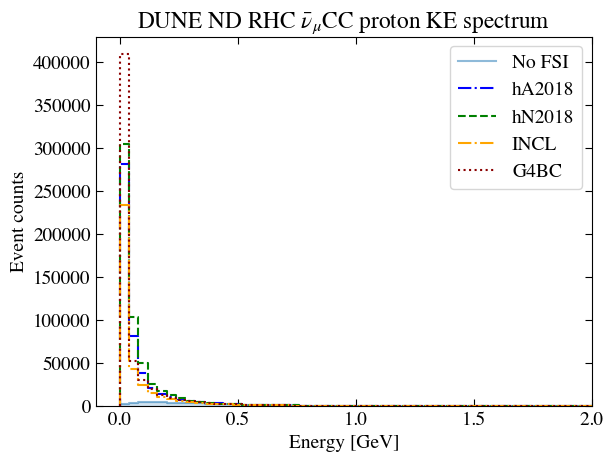

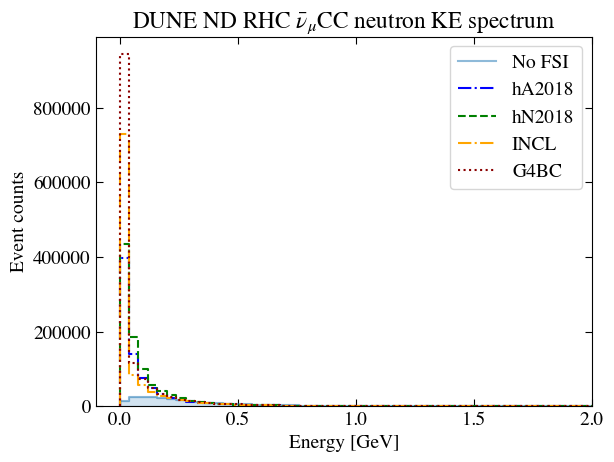

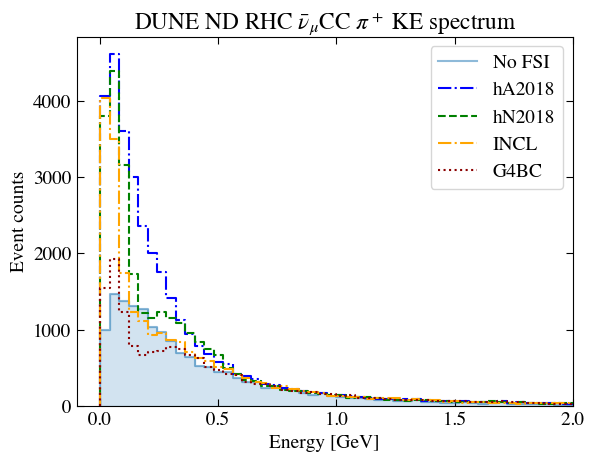

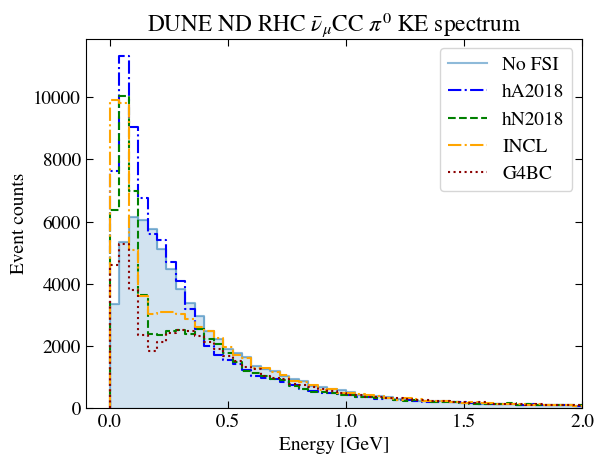

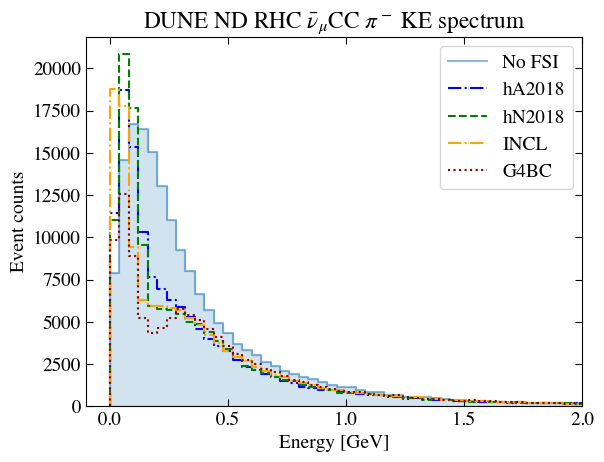

In [17]:
# proton KE spectra
xx = np.linspace(0, 2, 51)
yynoFSI, _ = np.histogram(pKE_numub_noFSI, bins=xx); yynoFSI = np.concatenate([[0],yynoFSI])
yyhA18, _ = np.histogram(pKE_numub_hA18, bins=xx); yyhA18 = np.concatenate([[0],yyhA18])
yyhN18, _ = np.histogram(pKE_numub_hN18, bins=xx); yyhN18 = np.concatenate([[0],yyhN18])
yyINCL, _ = np.histogram(pKE_numub_INCL, bins=xx); yyINCL = np.concatenate([[0],yyINCL])
yyG4BC, _ = np.histogram(pKE_numub_G4BC, bins=xx); yyG4BC = np.concatenate([[0],yyG4BC])

fig, ax = plt.subplots()
ax.step(xx, yynoFSI, label="No FSI", alpha=0.5, color='tab:blue')
ax.fill_between(xx, yynoFSI, step="pre", alpha=0.2, color='tab:blue')
ax.step(xx, yyhA18, "-.", label="hA2018", color='blue')
ax.step(xx, yyhN18, "--", label="hN2018", color='green')
ax.step(xx, yyINCL, "-.", label="INCL", color='orange')
ax.step(xx, yyG4BC, ":", label="G4BC", color='darkred')
ax.legend()
ax.set_xlabel("Energy [GeV]")
ax.set_ylabel("Event counts")
ax.set_title(r"DUNE ND RHC $\bar{\nu}_\mu$CC proton KE spectrum")
ax.set_ylim([0, None])
ax.set_xlim([None, 2])
#plt.savefig("FSIplots/ND_pKE_numub.png")
plt.show()

# neutron KE spectra
xx = np.linspace(0, 2, 51)
yynoFSI, _ = np.histogram(nKE_numub_noFSI, bins=xx); yynoFSI = np.concatenate([[0],yynoFSI])
yyhA18, _ = np.histogram(nKE_numub_hA18, bins=xx); yyhA18 = np.concatenate([[0],yyhA18])
yyhN18, _ = np.histogram(nKE_numub_hN18, bins=xx); yyhN18 = np.concatenate([[0],yyhN18])
yyINCL, _ = np.histogram(nKE_numub_INCL, bins=xx); yyINCL = np.concatenate([[0],yyINCL])
yyG4BC, _ = np.histogram(nKE_numub_G4BC, bins=xx); yyG4BC = np.concatenate([[0],yyG4BC])

fig, ax = plt.subplots()
ax.step(xx, yynoFSI, label="No FSI", alpha=0.5, color='tab:blue')
ax.fill_between(xx, yynoFSI, step="pre", alpha=0.2, color='tab:blue')
ax.step(xx, yyhA18, "-.", label="hA2018", color='blue')
ax.step(xx, yyhN18, "--", label="hN2018", color='green')
ax.step(xx, yyINCL, "-.", label="INCL", color='orange')
ax.step(xx, yyG4BC, ":", label="G4BC", color='darkred')
ax.legend()
ax.set_xlabel("Energy [GeV]")
ax.set_ylabel("Event counts")
ax.set_title(r"DUNE ND RHC $\bar{\nu}_\mu$CC neutron KE spectrum")
ax.set_ylim([0, None])
ax.set_xlim([None, 2])
#plt.savefig("FSIplots/ND_nKE_numub.png")
plt.show()

# pi+ KE spectra
xx = np.linspace(0, 2, 51)
yynoFSI, _ = np.histogram(pipKE_numub_noFSI, bins=xx); yynoFSI = np.concatenate([[0],yynoFSI])
yyhA18, _ = np.histogram(pipKE_numub_hA18, bins=xx); yyhA18 = np.concatenate([[0],yyhA18])
yyhN18, _ = np.histogram(pipKE_numub_hN18, bins=xx); yyhN18 = np.concatenate([[0],yyhN18])
yyINCL, _ = np.histogram(pipKE_numub_INCL, bins=xx); yyINCL = np.concatenate([[0],yyINCL])
yyG4BC, _ = np.histogram(pipKE_numub_G4BC, bins=xx); yyG4BC = np.concatenate([[0],yyG4BC])

fig, ax = plt.subplots()
ax.step(xx, yynoFSI, label="No FSI", alpha=0.5, color='tab:blue')
ax.fill_between(xx, yynoFSI, step="pre", alpha=0.2, color='tab:blue')
ax.step(xx, yyhA18, "-.", label="hA2018", color='blue')
ax.step(xx, yyhN18, "--", label="hN2018", color='green')
ax.step(xx, yyINCL, "-.", label="INCL", color='orange')
ax.step(xx, yyG4BC, ":", label="G4BC", color='darkred')
ax.legend()
ax.set_xlabel("Energy [GeV]")
ax.set_ylabel("Event counts")
ax.set_title(r"DUNE ND RHC $\bar{\nu}_\mu$CC $\pi^+$ KE spectrum")
ax.set_ylim([0, None])
ax.set_xlim([None, 2])
#plt.savefig("FSIplots/ND_pipKE_numub.png")
plt.show()

# pi0 KE spectra
xx = np.linspace(0, 2, 51)
yynoFSI, _ = np.histogram(pi0KE_numub_noFSI, bins=xx); yynoFSI = np.concatenate([[0],yynoFSI])
yyhA18, _ = np.histogram(pi0KE_numub_hA18, bins=xx); yyhA18 = np.concatenate([[0],yyhA18])
yyhN18, _ = np.histogram(pi0KE_numub_hN18, bins=xx); yyhN18 = np.concatenate([[0],yyhN18])
yyINCL, _ = np.histogram(pi0KE_numub_INCL, bins=xx); yyINCL = np.concatenate([[0],yyINCL])
yyG4BC, _ = np.histogram(pi0KE_numub_G4BC, bins=xx); yyG4BC = np.concatenate([[0],yyG4BC])

fig, ax = plt.subplots()
ax.step(xx, yynoFSI, label="No FSI", alpha=0.5, color='tab:blue')
ax.fill_between(xx, yynoFSI, step="pre", alpha=0.2, color='tab:blue')
ax.step(xx, yyhA18, "-.", label="hA2018", color='blue')
ax.step(xx, yyhN18, "--", label="hN2018", color='green')
ax.step(xx, yyINCL, "-.", label="INCL", color='orange')
ax.step(xx, yyG4BC, ":", label="G4BC", color='darkred')
ax.legend()
ax.set_xlabel("Energy [GeV]")
ax.set_ylabel("Event counts")
ax.set_title(r"DUNE ND RHC $\bar{\nu}_\mu$CC $\pi^0$ KE spectrum")
ax.set_ylim([0, None])
ax.set_xlim([None, 2])
#plt.savefig("FSIplots/ND_pi0KE_numub.png")
plt.show()

# pi- KE spectra
xx = np.linspace(0, 2, 51)
yynoFSI, _ = np.histogram(pimKE_numub_noFSI, bins=xx); yynoFSI = np.concatenate([[0],yynoFSI])
yyhA18, _ = np.histogram(pimKE_numub_hA18, bins=xx); yyhA18 = np.concatenate([[0],yyhA18])
yyhN18, _ = np.histogram(pimKE_numub_hN18, bins=xx); yyhN18 = np.concatenate([[0],yyhN18])
yyINCL, _ = np.histogram(pimKE_numub_INCL, bins=xx); yyINCL = np.concatenate([[0],yyINCL])
yyG4BC, _ = np.histogram(pimKE_numub_G4BC, bins=xx); yyG4BC = np.concatenate([[0],yyG4BC])

fig, ax = plt.subplots()
ax.step(xx, yynoFSI, label="No FSI", alpha=0.5, color='tab:blue')
ax.fill_between(xx, yynoFSI, step="pre", alpha=0.2, color='tab:blue')
ax.step(xx, yyhA18, "-.", label="hA2018", color='blue')
ax.step(xx, yyhN18, "--", label="hN2018", color='green')
ax.step(xx, yyINCL, "-.", label="INCL", color='orange')
ax.step(xx, yyG4BC, ":", label="G4BC", color='darkred')
ax.legend()
ax.set_xlabel("Energy [GeV]")
ax.set_ylabel("Event counts")
ax.set_title(r"DUNE ND RHC $\bar{\nu}_\mu$CC $\pi^-$ KE spectrum")
ax.set_ylim([0, None])
ax.set_xlim([None, 2])
#plt.savefig("FSIplots/ND_pimKE_numub.png")
plt.show()

#### More hadron plots

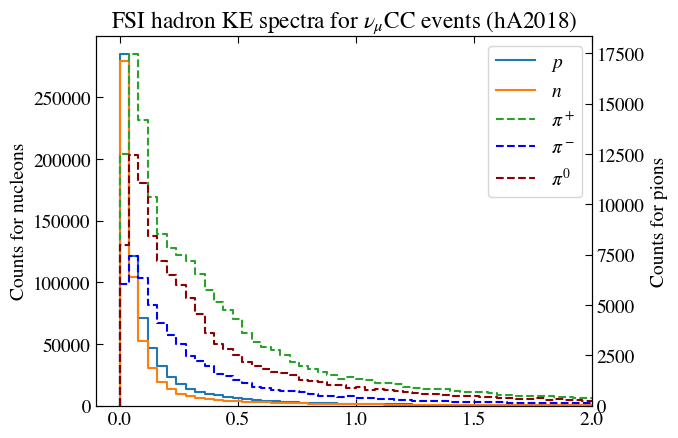

In [18]:
##### Or, plot different FSI hadrons on the same plot for a certain model
##### E.g. FSI hadron KE spectra numu hA2018
xx = np.linspace(0, 2, 51)
yyprot, _ = np.histogram(pKE_numu_hA18, bins=xx); yyprot = np.concatenate([[0],yyprot])
yyneut, _ = np.histogram(nKE_numu_hA18, bins=xx); yyneut = np.concatenate([[0],yyneut])
fig, ax1 = plt.subplots()
ax1.step(xx, np.array(yyprot), label=r"$p$", color='tab:blue')
ax1.step(xx, np.array(yyneut), label=r"$n$", color='tab:orange')
ax1.set_ylabel(r"Counts for nucleons")
ax1.set_ylim([0,None])
yypip, _ = np.histogram(pipKE_numu_hA18, bins=xx); yypip = np.concatenate([[0],yypip])
yypi0, _ = np.histogram(pi0KE_numu_hA18, bins=xx); yypi0 = np.concatenate([[0],yypi0])
yypim, _ = np.histogram(pimKE_numu_hA18, bins=xx); yypim = np.concatenate([[0],yypim])
ax2 = ax1.twinx()
ax2.step(xx, np.array(yypip), label=r"$\pi^+$", color='tab:green', linestyle='--')
ax2.step(xx, np.array(yypim), label=r"$\pi^-$", color='blue', linestyle='--')
ax2.step(xx, np.array(yypi0), label=r"$\pi^0$", color='darkred', linestyle='--')
ax2.set_ylabel(r"Counts for pions")
ax2.set_ylim([0,None])
plt.xlabel("Kinetic energy [MeV]")
plt.xlim([None,2])
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
plt.legend(handles1 + handles2, labels1 + labels2)
plt.title(r"FSI hadron KE spectra for $\nu_\mu$CC events (hA2018)")
plt.show()

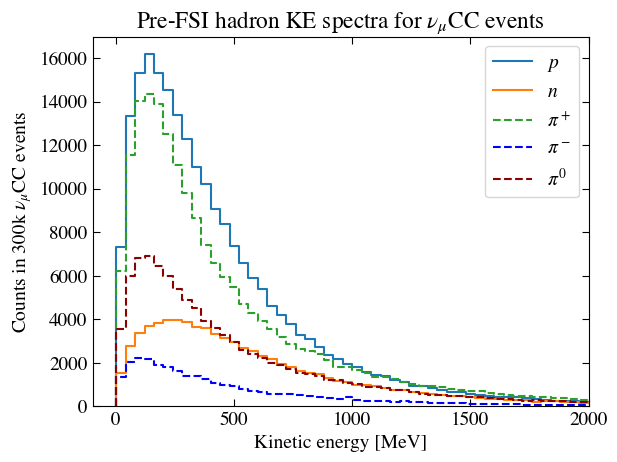

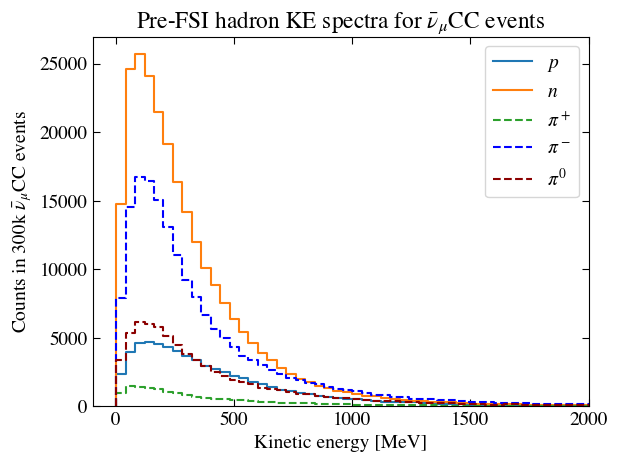

In [19]:
##### Pre-FSI hadron KE spectra
# numu
xx = np.linspace(0, 2000, 51)
yyprot = [0, 7328,13349,15311,16166,15327,14551,13368,12285,11015,10212,9045,8378,7361,6606,5886,5370,4588,4204,3771,3297,3096,2711,2374,2195,1924,1816,1580,1448,1373,1227,1127,929,913,861,753,680,682,559,519,477,448,425,412,370,344,273,249,231,233,191]
yyneut = [0, 1529,2750,3374,3692,3845,3987,3958,3858,3638,3583,3342,3117,2956,2669,2529,2305,2193,1958,1792,1644,1541,1508,1282,1183,1103,998,986,919,821,773,729,649,617,568,535,490,461,417,388,353,329,306,307,297,217,241,227,207,201,174]
plt.step(xx, np.array(yyprot), label=r"$p$", color='tab:blue')
plt.step(xx, np.array(yyneut), label=r"$n$", color='tab:orange')
yypip = [0, 6198,11557,14007,14337,13892,12523,11079,9815,8659,7429,6595,5928,5459,4693,4293,3923,3548,3185,2863,2639,2565,2396,2120,1810,1821,1665,1549,1371,1335,1252,1110,1020,923,939,902,810,732,699,686,605,546,509,491,462,443,424,372,373,351,312]
yypim = [0, 1342,2060,2228,2182,1913,1803,1620,1386,1385,1278,1095,968,923,816,724,670,580,562,563,544,465,420,390,349,411,312,268,267,267,221,244,187,200,158,163,152,136,128,126,125,123,100,95,70,79,75,74,80,78,72]
yypi0 = [0, 3571,5968,6826,6921,6463,6004,5408,4894,4530,3900,3580,3277,2937,2591,2388,2203,1995,1915,1728,1543,1473,1389,1223,1195,1067,1014,881,879,836,735,734,661,580,522,531,469,455,416,418,371,354,327,290,265,300,254,267,228,223,197]
plt.step(xx, np.array(yypip), label=r"$\pi^+$", color='tab:green', linestyle='--')
plt.step(xx, np.array(yypim), label=r"$\pi^-$", color='blue', linestyle='--')
plt.step(xx, np.array(yypi0), label=r"$\pi^0$", color='darkred', linestyle='--')

plt.legend()
plt.xlim([None,2000])
plt.ylim([0,None])
plt.xlabel("Kinetic energy [MeV]")
plt.ylabel(r"Counts in 300k $\nu_\mu$CC events")
plt.title(r"Pre-FSI hadron KE spectra for $\nu_\mu$CC events")
plt.show()

# plot pions and nucleons separately
#xx = np.linspace(0, 2000, 51)
#yyprot = [0, 2356,3975,4617,4676,4519,4340,4065,3683,3412,2969,2742,2473,2236,2054,1792,1653,1413,1229,1138,988,884,791,681,591,572,512,431,405,347,324,300,293,240,218,196,172,162,133,127,125,121,120,112,67,82,76,57,69,58,53]
#yyneut = [0, 14736,24609,25672,24114,21476,19147,16346,14188,11959,10086,8854,7521,6353,5460,4617,3879,3414,2796,2383,1985,1766,1488,1358,1151,1041,911,785,727,619,543,469,415,379,331,299,289,238,243,200,193,180,150,139,129,125,91,115,97,82,87]
#plt.step(xx, np.array(yyprot), label=r"$p$")
#plt.step(xx, np.array(yyneut), label=r"$n$")
#plt.legend(fontsize=20)
#plt.xlim([None,2000])
#plt.ylim([0,None])
#plt.xlabel("Kinetic energy [MeV]")
#plt.ylabel("Counts")
#plt.show()

# numubar
xx = np.linspace(0, 2000, 51)
yyprot = [0, 2356,3975,4617,4676,4519,4340,4065,3683,3412,2969,2742,2473,2236,2054,1792,1653,1413,1229,1138,988,884,791,681,591,572,512,431,405,347,324,300,293,240,218,196,172,162,133,127,125,121,120,112,67,82,76,57,69,58,53]
yyneut = [0, 14736,24609,25672,24114,21476,19147,16346,14188,11959,10086,8854,7521,6353,5460,4617,3879,3414,2796,2383,1985,1766,1488,1358,1151,1041,911,785,727,619,543,469,415,379,331,299,289,238,243,200,193,180,150,139,129,125,91,115,97,82,87]
plt.step(xx, np.array(yyprot), label=r"$p$", color='tab:blue')
plt.step(xx, np.array(yyneut), label=r"$n$", color='tab:orange')
yypip = [0, 995,1464,1379,1314,1278,1037,970,853,702,640,531,514,444,444,367,318,322,242,266,229,210,180,153,169,139,120,113,104,97,88,90,69,70,94,53,55,50,50,54,42,36,46,55,35,37,26,36,31,24,22]
yypim = [0, 7867,14555,16693,16416,15040,13059,11018,9230,8007,6639,5671,4950,4348,3686,3363,3039,2648,2389,2094,1891,1727,1603,1419,1291,1158,1117,955,836,849,698,662,561,542,527,468,432,364,344,344,289,274,255,227,242,203,199,201,179,169,172]
yypi0 = [0, 3366,5328,6152,6038,5760,5132,4468,3848,3376,2974,2486,2222,1917,1791,1648,1358,1280,1207,1026,929,872,730,680,608,582,522,445,398,390,372,298,295,238,244,223,227,196,185,170,133,132,137,140,115,130,98,92,93,97,72]
plt.step(xx, np.array(yypip), label=r"$\pi^+$", color='tab:green', linestyle='--')
plt.step(xx, np.array(yypim), label=r"$\pi^-$", color='blue', linestyle='--')
plt.step(xx, np.array(yypi0), label=r"$\pi^0$", color='darkred', linestyle='--')

plt.legend()
plt.xlim([None,2000])
plt.ylim([0,None])
plt.xlabel("Kinetic energy [MeV]")
plt.ylabel(r"Counts in 300k $\bar{\nu}_\mu$CC events")
plt.title(r"Pre-FSI hadron KE spectra for $\bar{\nu}_\mu$CC events")
plt.show()

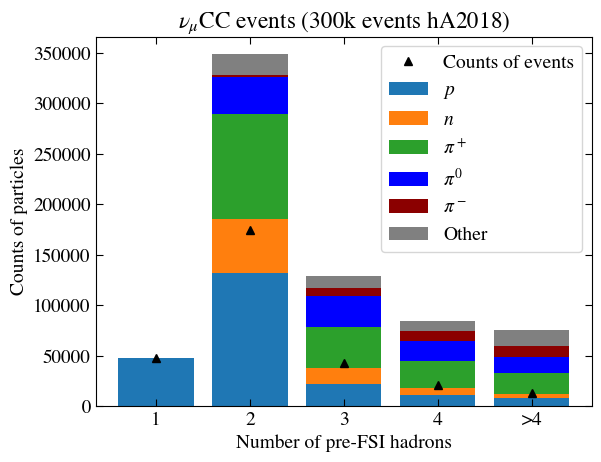

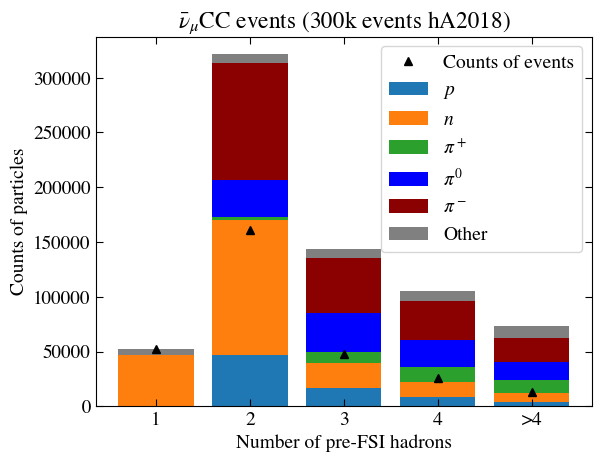

In [20]:
##### Pre-FSI hadron counts
# numu
x = ['1', '2', '3', '4', '>4']
proton = np.array([47758, 132119, 22208, 11209, 7992])
neutron = np.array([0, 53202, 15899, 7438, 4197])
pionp = np.array([0, 103923, 40748, 26416, 20361])
pion0 = np.array([0, 37187, 29995, 19241, 15935])
pionm = np.array([0, 1941, 8410, 10585, 11154])
other = np.array([538, 20252, 11917, 9659, 15808]) # n=1 are Lambda_c^+(4122), Sigma_c^+(4212), Sigma_c^++(4222); n>1 many gamma
ni = np.array([48296, 174312, 43059, 21137, 13196])
# plot bars in stack manner
plt.bar(x, proton, color='tab:blue', label=r"$p$"); bottom = proton
plt.bar(x, neutron, color='tab:orange', bottom=bottom, label=r"$n$"); bottom += neutron
plt.bar(x, pionp, color='tab:green', bottom=bottom, label=r"$\pi^+$"); bottom += pionp
plt.bar(x, pion0, color='blue', bottom=bottom, label=r"$\pi^0$"); bottom += pion0
plt.bar(x, pionm, color='darkred', bottom=bottom, label=r"$\pi^-$"); bottom += pionm
plt.bar(x, other, color='grey', bottom=bottom, label="Other")
plt.step(x, ni, "k^", label="Counts of events")
plt.xlabel("Number of pre-FSI hadrons")
plt.ylabel("Counts of particles")
plt.legend()
plt.title(r"$\nu_\mu$CC events (300k events hA2018)")
#plt.savefig(f"/Users/lyret/figs_GENIE/numu/multiplicity.png")
plt.show()

# numubar
x = ['1', '2', '3', '4', '>4']
proton = np.array([0, 46514, 16616, 8948, 4357])
neutron = np.array([47016, 123914, 23194, 13492, 7586])
pionp = np.array([0, 2569, 10088, 13437, 11740])
pion0 = np.array([0, 33739, 35744, 24649, 17133])
pionm = np.array([0, 106351, 50201, 35292, 21241])
other = np.array([4880, 8253, 8070, 9014, 11580]) # n=1 are Sigma^-(3112), Lambda(3122), Sigma^0(3212)
ni = np.array([51896, 160670, 47971, 26208, 13255])
# plot bars in stack manner
plt.bar(x, proton, color='tab:blue', label=r"$p$"); bottom = proton
plt.bar(x, neutron, color='tab:orange', bottom=bottom, label=r"$n$"); bottom += neutron
plt.bar(x, pionp, color='tab:green', bottom=bottom, label=r"$\pi^+$"); bottom += pionp
plt.bar(x, pion0, color='blue', bottom=bottom, label=r"$\pi^0$"); bottom += pion0
plt.bar(x, pionm, color='darkred', bottom=bottom, label=r"$\pi^-$"); bottom += pionm
plt.bar(x, other, color='grey', bottom=bottom, label="Other")
plt.step(x, ni, "k^", label="Counts of events")
plt.xlabel("Number of pre-FSI hadrons")
plt.ylabel("Counts of particles")
plt.legend()
plt.title(r"$\bar{\nu}_\mu$CC events (300k events hA2018)")
#plt.savefig(f"/Users/lyret/figs_GENIE/numub/multiplicity.png")
plt.show()

### temporary

Check if all having the same #events: 300000 300000 299913 300000 298522


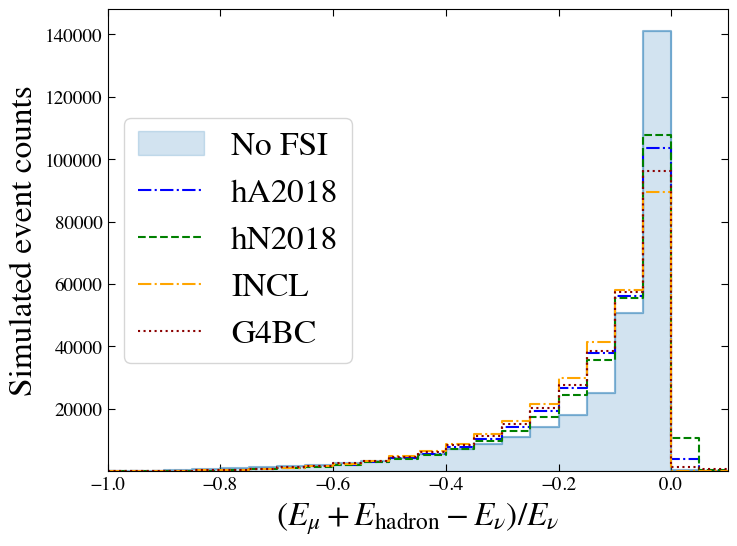

In [47]:
# relative energy bias
xx = np.linspace(-1, 0.1, 22+1)
yyi, _ = np.histogram(Ebiasi_numu_hA18/vars_numu_hA18["Ev"], bins=xx); yyi = np.concatenate([[0],yyi])
yyf_hA18, _ = np.histogram(Ebiasf_numu_hA18/vars_numu_hA18["Ev"], bins=xx); yyf_hA18 = np.concatenate([[0],yyf_hA18])
yyf_hN18, _ = np.histogram(Ebiasf_numu_hN18/vars_numu_hN18["Ev"], bins=xx); yyf_hN18 = np.concatenate([[0],yyf_hN18])
yyf_INCL, _ = np.histogram(Ebiasf_numu_INCL/vars_numu_INCL["Ev"], bins=xx); yyf_INCL = np.concatenate([[0],yyf_INCL])
yyf_G4BC, _ = np.histogram(Ebiasf_numu_G4BC/vars_numu_G4BC["Ev"], bins=xx); yyf_G4BC = np.concatenate([[0],yyf_G4BC])
print("Check if all having the same #events:", np.sum(yyi), np.sum(yyf_hA18), np.sum(yyf_hN18), np.sum(yyf_INCL), np.sum(yyf_G4BC))

fig, axes = plt.subplots(1, 1, figsize=(8, 6))

axes.step(xx, yyi, alpha=0.5, color='tab:blue')
axes.fill_between(xx, yyi, label="No FSI", step="pre", alpha=0.2, color='tab:blue')
axes.step(xx, yyf_hA18, "-.", label="hA2018", color='blue')
axes.step(xx, yyf_hN18, "--", label="hN2018", color='green')
axes.step(xx, yyf_INCL, "-.", label="INCL", color='orange')
axes.step(xx, yyf_G4BC, ":", label="G4BC", color='darkred')
axes.legend(loc="center left", fontsize=24)
axes.set_ylabel("Simulated event counts", fontsize=24)
#axes.set_title(r"DUNE ND FHC $\nu_\mu$CC relative energy bias", fontsize=24)
#axes[0].set_yscale('log')
axes.set_ylim([0.6, None])
axes.set_xlim([-1, 0.1])

#axes[1].step(xx, safe_divide(yyf_hA18, yyf_hA18), "-.", label="hA2018", color='blue')
#axes[1].step(xx, safe_divide(yyf_hN18, yyf_hA18), "--", label="hN2018", color='green')
#axes[1].step(xx, safe_divide(yyf_INCL, yyf_hA18), "-.", label="INCL", color='orange')
#axes[1].step(xx, safe_divide(yyf_G4BC, yyf_hA18), ":", label="G4BC", color='darkred')
axes.set_xlabel(r"$(E_\mu+E_{\rm hadron}-E_\nu)/E_\nu$", fontsize=24)
#axes[1].set_ylabel("Ratio w.r.t. hA2018")
#axes[1].set_xlim([-1, 0.1])
#axes[1].set_ylim([0.5, 1.5])
#plt.savefig("FSIplots/relaEvbias_Eavail_FSI_numu.png")
plt.show()

In [ ]:
# oscillation
fluxND2FD_numu_m23p = FDosc_Flux_FHCnumu_m23p*1e7/ND_Flux_FHCnumu
fluxND2FD_numu_m23m = FDosc_Flux_FHCnumu_m23m*1e7/ND_Flux_FHCnumu
fluxND2FD_numu_m232p = FDosc_Flux_FHCnumu_m232p*1e7/ND_Flux_FHCnumu
fluxND2FD_numu_m232m = FDosc_Flux_FHCnumu_m232m*1e7/ND_Flux_FHCnumu
fluxND2FD_numu_t23p = FDosc_Flux_FHCnumu_t23p*1e7/ND_Flux_FHCnumu
fluxND2FD_numu_t23m = FDosc_Flux_FHCnumu_t23m*1e7/ND_Flux_FHCnumu
fluxND2FD_numu_t232p = FDosc_Flux_FHCnumu_t232p*1e7/ND_Flux_FHCnumu
fluxND2FD_numu_t232m = FDosc_Flux_FHCnumu_t232m*1e7/ND_Flux_FHCnumu

ND2FD_numu_wei_1300 = np.interp(vars_numu_hA18["Ev"], FDosc_Ev, fluxND2FD_numu_1300)
ND2FD_numu_wei_m23p = np.interp(vars_numu_hA18["Ev"], FDosc_Ev, fluxND2FD_numu_m23p)
ND2FD_numu_wei_m23m = np.interp(vars_numu_hA18["Ev"], FDosc_Ev, fluxND2FD_numu_m23m)
ND2FD_numu_wei_m232p = np.interp(vars_numu_hA18["Ev"], FDosc_Ev, fluxND2FD_numu_m232p)
ND2FD_numu_wei_m232m = np.interp(vars_numu_hA18["Ev"], FDosc_Ev, fluxND2FD_numu_m232m)
ND2FD_numu_wei_t23p = np.interp(vars_numu_hA18["Ev"], FDosc_Ev, fluxND2FD_numu_t23p)
ND2FD_numu_wei_t23m = np.interp(vars_numu_hA18["Ev"], FDosc_Ev, fluxND2FD_numu_t23m)
ND2FD_numu_wei_t232p = np.interp(vars_numu_hA18["Ev"], FDosc_Ev, fluxND2FD_numu_t232p)
ND2FD_numu_wei_t232m = np.interp(vars_numu_hA18["Ev"], FDosc_Ev, fluxND2FD_numu_t232m)

yyf_1300, _ = np.histogram(vars_numu_hA18["Ev"]+Ebiasf_numu_hA18, bins=xx, weights=ND2FD_numu_wei_1300, density=True); yyf_1300 = np.concatenate([[0],yyf_1300])
yyf_m23p, _ = np.histogram(vars_numu_hA18["Ev"]+Ebiasf_numu_hA18, bins=xx, weights=ND2FD_numu_wei_m23p, density=True); yyf_m23p = np.concatenate([[0],yyf_m23p])
yyf_m23m, _ = np.histogram(vars_numu_hA18["Ev"]+Ebiasf_numu_hA18, bins=xx, weights=ND2FD_numu_wei_m23m, density=True); yyf_m23m = np.concatenate([[0],yyf_m23m])
yyf_m232p, _ = np.histogram(vars_numu_hA18["Ev"]+Ebiasf_numu_hA18, bins=xx, weights=ND2FD_numu_wei_m232p, density=True); yyf_m232p = np.concatenate([[0],yyf_m232p])
yyf_m232m, _ = np.histogram(vars_numu_hA18["Ev"]+Ebiasf_numu_hA18, bins=xx, weights=ND2FD_numu_wei_m232m, density=True); yyf_m232m = np.concatenate([[0],yyf_m232m])
yyf_t23p, _ = np.histogram(vars_numu_hA18["Ev"]+Ebiasf_numu_hA18, bins=xx, weights=ND2FD_numu_wei_t23p, density=True); yyf_t23p = np.concatenate([[0],yyf_t23p])
yyf_t23m, _ = np.histogram(vars_numu_hA18["Ev"]+Ebiasf_numu_hA18, bins=xx, weights=ND2FD_numu_wei_t23m, density=True); yyf_t23m = np.concatenate([[0],yyf_t23m])
yyf_t232p, _ = np.histogram(vars_numu_hA18["Ev"]+Ebiasf_numu_hA18, bins=xx, weights=ND2FD_numu_wei_t232p, density=True); yyf_t232p = np.concatenate([[0],yyf_t232p])
yyf_t232m, _ = np.histogram(vars_numu_hA18["Ev"]+Ebiasf_numu_hA18, bins=xx, weights=ND2FD_numu_wei_t232m, density=True); yyf_t232m = np.concatenate([[0],yyf_t232m])
print("Check if all having the same #events:", np.sum(yyi), np.sum(yyf_hA18), np.sum(yyf_hN18), np.sum(yyf_INCL), np.sum(yyf_G4BC))

Nv = 10000 # estimated total event counts
scale = Nv/np.sum(yyf_1300)

### Δm^2_{23}
fig, ax = plt.subplots(figsize=(10, 6))
ax.step(xx, scale*yyf_1300, "-.", label="Reco (hA2018 nominal)", alpha=1, color='blue')
ax.errorbar((xx[1:]+xx[:-1])/2, scale*yyf_1300[1:], np.sqrt(scale*yyf_1300[1:]), fmt="k.", label=f"{Nv} events")
#ax.step(xx, yyf_m23p, "r:", label="Reco (upper Dmsq23)")
#ax.step(xx, yyf_m23m, "m--", label="Reco (lower Dmsq23)")
#ax.step(xx, yyf_t23p, "b:", label="Reco (upper theta23)")
#ax.step(xx, yyf_t23m, "c--", label="Reco (lower theta23)")
ax.fill_between(xx, scale*yyf_m23m, scale*yyf_m23p, step="pre", label=r"$\Delta m^2_{23}$ error band", alpha=0.2, color='tab:blue')
ax.fill_between(xx, scale*yyf_m232m, scale*yyf_m232p, step="pre", alpha=0.1, color='tab:blue')
ax.step(xx, scale*yyi, label="Reco (no FSI)", alpha=1, color='tab:blue')
#ax.step(xx, scale*yyf_hA18, "-.", label="Reco (hA2018)", color='blue')
ax.step(xx, scale*yyf_hN18, "--", label="Reco (hN2018)", color='green')
ax.step(xx, scale*yyf_INCL, "-.", label="Reco (INCL)", color='orange')
ax.step(xx, scale*yyf_G4BC, ":", label="Reco (G4BC)", color='darkred')
ax.legend(loc="upper left", fontsize=16)
ax.set_xlabel("Energy [GeV]")
ax.set_ylabel("Flux normalized to total event counts")
ax.set_title(r"DUNE FD FHC $\nu_\mu$CC neutrino energy spectrum")
ax.set_ylim([0, None])
ax.set_xlim([0, 5])

ax_inset = fig.add_axes([0.5, 0.5, 0.35, 0.35])  # Adjust these values as needed
# Plot the same data on the inset axes
ax_inset.step(xx, scale*yyf_1300, "-.", label="Reco (hA2018 nominal)", alpha=1, color='blue')
ax_inset.fill_between(xx, scale*yyf_m23m, scale*yyf_m23p, step="pre", label=r"$\Delta m^2_{23}$ error band", alpha=0.2, color='tab:blue')
ax_inset.fill_between(xx, scale*yyf_m232m, scale*yyf_m232p, step="pre", alpha=0.1, color='tab:blue')
ax_inset.errorbar((xx[1:]+xx[:-1])/2, scale*yyf_1300[1:], np.sqrt(scale*yyf_1300[1:]), fmt="k.", label=f"{Nv} events")
ax_inset.step(xx, scale*yyi, label="Reco (no FSI)", alpha=1, color='tab:blue')
#ax_inset.step(xx, scale*yyf_hA18, "-.", label="Reco (hA2018)", color='blue')
ax_inset.step(xx, scale*yyf_hN18, "--", label="Reco (hN2018)", color='green')
ax_inset.step(xx, scale*yyf_INCL, "-.", label="Reco (INCL)", color='orange')
ax_inset.step(xx, scale*yyf_G4BC, ":", label="Reco (G4BC)", color='darkred')
ax_inset.set_ylim([0.03*scale, 0.1*scale])
ax_inset.set_xlim([2, 2.8])
ax_inset.grid(True)
#plt.savefig("FSIplots/FDoscNv_Eavail_FSI_numu_m23.png")
plt.show()

### sin^2 θ_{23}
fig, ax = plt.subplots(figsize=(10, 6))
ax.step(xx, scale*yyf_1300, "-.", label="Reco (hA2018 nominal)", alpha=1, color='blue')
ax.errorbar((xx[1:]+xx[:-1])/2, scale*yyf_1300[1:], np.sqrt(scale*yyf_1300[1:]), fmt="k.", label=f"{Nv} events")
#ax.step(xx, yyf_m23p, "r:", label="Reco (upper Dmsq23)")
#ax.step(xx, yyf_m23m, "m--", label="Reco (lower Dmsq23)")
#ax.step(xx, yyf_t23p, "b:", label="Reco (upper theta23)")
#ax.step(xx, yyf_t23m, "c--", label="Reco (lower theta23)")
ax.fill_between(xx, scale*yyf_t23m, scale*yyf_t23p, step="pre", label=r"$\sin^2 \theta_{23}$ error band", alpha=0.2, color='tab:red')
ax.fill_between(xx, scale*yyf_t232m, scale*yyf_t232p, step="pre", alpha=0.1, color='tab:red')
ax.step(xx, scale*yyi, label="Reco (no FSI)", alpha=1, color='tab:blue')
#ax.step(xx, scale*yyf_hA18, "-.", label="Reco (hA2018)", color='blue')
ax.step(xx, scale*yyf_hN18, "--", label="Reco (hN2018)", color='green')
ax.step(xx, scale*yyf_INCL, "-.", label="Reco (INCL)", color='orange')
ax.step(xx, scale*yyf_G4BC, ":", label="Reco (G4BC)", color='darkred')
ax.legend(loc="upper left", fontsize=16)
ax.set_xlabel("Energy [GeV]")
ax.set_ylabel("Flux normalized to total event counts")
ax.set_title(r"DUNE FD FHC $\nu_\mu$CC neutrino energy spectrum")
ax.set_ylim([0, None])
ax.set_xlim([0, 5])

ax_inset = fig.add_axes([0.5, 0.5, 0.35, 0.35])  # Adjust these values as needed
# Plot the same data on the inset axes
ax_inset.step(xx, scale*yyf_1300, "-.", label="Reco (hA2018 nominal)", alpha=1, color='blue')
ax_inset.errorbar((xx[1:]+xx[:-1])/2, scale*yyf_1300[1:], np.sqrt(scale*yyf_1300[1:]), fmt="k.", label=f"{Nv} events")
ax_inset.fill_between(xx, scale*yyf_t23m, scale*yyf_t23p, step="pre", label=r"$\sin^2 \theta_{23}$ error band", alpha=0.2, color='tab:red')
ax_inset.fill_between(xx, scale*yyf_t232m, scale*yyf_t232p, step="pre", alpha=0.1, color='tab:red')
ax_inset.step(xx, scale*yyi, label="Reco (no FSI)", alpha=1, color='tab:blue')
#ax_inset.step(xx, scale*yyf_hA18, "-.", label="Reco (hA2018)", color='blue')
ax_inset.step(xx, scale*yyf_hN18, "--", label="Reco (hN2018)", color='green')
ax_inset.step(xx, scale*yyf_INCL, "-.", label="Reco (INCL)", color='orange')
ax_inset.step(xx, scale*yyf_G4BC, ":", label="Reco (G4BC)", color='darkred')
ax_inset.set_ylim([0.03*scale, 0.1*scale])
ax_inset.set_xlim([2, 2.8])
ax_inset.grid(True)
#plt.savefig("FSIplots/FDoscNv_Eavail_FSI_numu_t23.png")
plt.show()
